In [1]:
# IO: do this:
#source activate fullenv
#python -m ipykernel install --user --name fullenv --display-name "fullenv"
# also see this https://anbasile.github.io/posts/2017-06-25-jupyter-venv/
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
bg_file_list = glob.glob("/Users/inesochoa/PhysicsWorkdir/snowmassWorkDir/ILCAnomalies/processed_lhe*_background.txt")
signal_file_list = glob.glob("//Users/inesochoa/PhysicsWorkdir/snowmassWorkDir/ILCAnomalies/processed_lhe*signal.txt")

# Defining event level variables
arXiv:1206.2135.pdf

In [3]:
def y23(jets):
    if len(jets) > 2:
        jet1_pt = float(jets[0][1])/np.cosh(float(jets[0][2]))
        jet2_pt = float(jets[1][1])/np.cosh(float(jets[1][2]))
        jet3_pt = float(jets[2][1])/np.cosh(float(jets[2][2]))
        return (jet3_pt*jet3_pt)/((jet1_pt+jet2_pt)*(jet1_pt+jet2_pt))
    return 0

In [4]:
def momentum_tensor(jets,r):
    m = np.zeros((3,3))
    totalPSq = 1e-10
    for jet in jets:
        px = float(jet[1])*np.cos(float(jet[3]))/np.cosh(float(jet[2]))
        py = float(jet[1])*np.sin(float(jet[3]))/np.cosh(float(jet[2]))
        pz = float(jet[1])*np.sinh(float(jet[2]))/np.cosh(float(jet[2]))
        pr = np.power(float(jet[1]),r-2)
        m += [[px*px*pr, px*py*pr, px*pz*pr], [py*px*pr, py*py*pr, py*pz*pr], [pz*px*pr, pz*py*pr, pz*pz*pr]]
        totalPSq += np.power(float(jet[1]),r)
    #print(totalPSq)
    m = m/totalPSq
    from numpy import linalg as LA
    w, v = LA.eig(m)
    #print("eigenvalues: ", w)
    #print("eigenvectors: ",v)
    return w, v
    #return m  #From this, the sphericity, aplanarity and planarity can be calculated by combinations of eigenvalues.

In [5]:
def sphericity(w,v):
    return (3/2) * (sorted(w)[1]+sorted(w)[2])

In [6]:
def aplanarity(w,v):
    return (3/2) * sorted(w)[2]

In [7]:
def transverse_sphericity(w,v): #
    print(sorted(w)[0],sorted(w)[1])
    return (2*sorted(w)[1])/(sorted(w)[0]+sorted(w)[1])

In [8]:
#def planarity(w,v):
#    return

In [9]:
#thrust

In [10]:
#From Ben, function to parse files:
def parse_file(file_object):
    all_records = []
    mymeasuredenergy = []

    count = 0
    for line in file_object:

        metadata = line.split("J")[0]
        eventinfo = line.split("J")[1]
        jets = eventinfo.split("P")[0]
        particles = eventinfo.split("P")[1]

        this_record = {}
        this_record['label'] = count
        count += 1
        eventweight = float(metadata.split()[0])
        this_record['eventweight'] = eventweight #this is the event "weight".  Let's ignoreit for now (we will need it later).
        njets = int(len(jets.split())/11) #number of "jets"

        nparticles  = int(len(particles.split())/5) #number of particles

        #True collision quantities
        this_record['truthcenterofmassenergy'] = float(metadata.split()[1]) #true total energy - should be delta function at 1000 GeV
        this_record['truthsqrtshat'] = float(metadata.split()[2]) #energy available for making new particles (electron energy - photon)
        this_record['truthphotonpT'] = float(metadata.split()[3]) #photon momentum |p| in units of GeV
        this_record['truthphotoneta'] = float(metadata.split()[4]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['truthphotonphi'] = float(metadata.split()[5]) #photon azimuthal angle

        #Measured collision quantities
        measuredcenterofmassenergy  = float(metadata.split()[6]) #true measured energy - should be noisy version of truthcenterofmassenergy
        this_record['measuredcenterofmassenergy'] = measuredcenterofmassenergy
        this_record['measuredsqrtshat'] = float(metadata.split()[7]) #energy available for making new particles (electron energy - photon)
        this_record['measuredphotonpT'] = float(metadata.split()[8]) #photon momentum |p| in units of GeV
        this_record['measuredphotoneta'] = float(metadata.split()[9]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['measuredphotonphi'] = float(metadata.split()[10]) #photon azimuthal angle
        this_record['metadata'] = metadata.split()

        mymeasuredenergy+=[measuredcenterofmassenergy]

        this_record['njets'] = njets
        jets = jets.split()
        jets_vec = []
        for i in range(njets):
            jet = np.zeros(11)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - mass (units of GeV/c^2)
            # - bit encoding of the jet "flavor" (not totally sure what the bit means, but will look it up)
            # - 0th angular moment of jet radiation
            # - 1th angular moment of jet radiation
            # - 2th angular moment of jet radiation
            # - 3th angular moment of jet radiation
            # - 4th angular moment of jet radiation
            jet = jets[i*11:i*11+11]
            jets_vec+=[jet]

        this_record['jets']=jets_vec

        this_record['y23'] = y23(jets_vec)

        w,v = momentum_tensor(jets_vec,2)
        this_record['sphericity'] = sphericity(w,v)
        this_record['transverse_sphericity'] = transverse_sphericity(w,v)
        this_record['aplanarity'] = aplanarity(w,v)

        this_record['nparticles'] = nparticles

        particles = particles.split()
        particles_vec = []
        for i in range(nparticles):
            particle = np.zeros(5)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - particle identifier (https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf)
            particle = particles[i*5:i*5+5]
            particles_vec+=[particle]
            #print(particles[i*5],particles[i*5+1],particles[i*5+2],particles[i*5+3],particles[i*5+4])
        this_record['particles'] = particles_vec
        
        #w,v = momentum_tensor(particles_vec,3)
        #this_record['sphericity'] = sphericity(w,v)
        #this_record['transverse_sphericity'] = transverse_sphericity(w,v)
        #his_record['aplanarity'] = aplanarity(w,v)
        
        all_records.append(this_record)
    return all_records

In [11]:
bg_records = []
for filename in bg_file_list:
    file = open(filename)
    bg_records += parse_file(file)
sig_records = []
for filename in signal_file_list:
    file = open(filename)
    sig_records += parse_file(file)

-6.933816607036331e-17 4.589609257175561e-17
5.641142204618343e-18 0.011235961102160739
0.0002117151621070622 0.09032272402618423
-6.123924545147015e-18 0.034044050043308585
3.790672205636618e-18 0.04768906630737139
-5.184619186972118e-19 0.03984540441710862
2.336322875913198e-17 0.041861499478038286
0.006844887431260317 0.016561730781351737
1.2140046776963056e-17 0.15685813829192324
0.0007537442337308183 0.026281641256382656
4.4934039264250964e-18 0.022035981603041908
-1.2840154869839922e-17 0.05553475981421775
2.918203954399163e-09 0.015015957440044527
-3.2242671455120895e-17 9.222993022784953e-18
0.0002825796092284982 0.01874351592124713
0.0 0.0
0.0 5.1104171866348003e-17
0.015045237352092067 0.3226042107054745
-1.1102230246251565e-16 -5.3837505724574827e-17
3.5188121670056874e-18 0.029428138897640226
-2.203005380426312e-17 0.0171116180723025
(2.5153808996513598e-17-8.543030127497689e-17j) (2.5153808996513598e-17+8.543030127497689e-17j)
4.36189986686723e-18 0.0395219456641882
-6.927

<ipython-input-7-7c257ce77164>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (2*sorted(w)[1])/(sorted(w)[0]+sorted(w)[1])


3.4539621027600675e-06 0.02301564905251334
0.0027533233053969887 0.04726588901351625
(5.062475823847306e-17-6.430873795964646e-18j) (5.062475823847306e-17+6.430873795964646e-18j)
0.1168935397436486 0.32676218164997367
-8.665798448773242e-17 0.00852779802680168
2.7550436525557107e-18 0.0016801855233200755
0.018188302958420388 0.12098408786953557
-2.1763256624887795e-17 3.711511533332942e-17
(1.596146830978437e-17-1.739073692913858e-17j) (1.596146830978437e-17+1.739073692913858e-17j)
0.00037862355206483896 0.0458479880945239
-3.080226812825636e-17 9.153471642483886e-06
-1.2105025993585123e-17 0.031441530194421155
(-8.572520036855285e-18-1.1327027439174764e-17j) (-8.572520036855285e-18+1.1327027439174764e-17j)
-3.3037721974558e-17 0.048613793687376894
2.511861134710775e-17 0.002811637043158571
-4.4895146327893197e-17 0.021453401340987405
2.5728010227105174e-17 0.007190402936437339
-5.561582905567865e-17 3.4303809619803447e-18
1.8538436588503357e-17 0.032769719186836195
0.0 4.2214873216908

3.362215259816972e-18 0.011519961426181863
(2.3643489841915702e-17-4.103142071780421e-17j) (2.3643489841915702e-17+4.103142071780421e-17j)
2.464243205359615e-17 0.038514887044850905
-3.399088237396732e-17 5.80935060588535e-17
1.3877787807814457e-17 0.24116679753363734
3.7821895787970455e-17 0.11655711351526439
-5.407996774846627e-17 4.2769441275660806e-17
3.931755616646749e-18 0.021598100438103954
-1.6740081543176188e-16 0.19480697343018885
9.509967289527213e-18 0.04447931924356854
2.0623372833451865e-05 0.005902687329940663
9.476727616093366e-18 0.029069083858924066
3.107561962057825e-17 0.03705989176832955
-2.1422545834455977e-17 4.934357380835048e-18
1.5072556217411757e-19 0.031466079842601385
-6.938893903907228e-18 0.03276176479951028
0.00190209996789034 0.020741721918965336
-3.2268394761981126e-17 2.2502406744914516e-17
-2.8088009191403562e-18 0.0
-1.9234232941889017e-17 0.004333539140296514
-1.8409260271729817e-17 0.033350256868976004
6.702837569751301e-18 0.019620337475256495
(-

-1.9401528195861373e-17 0.024599209587316526
0.0007563244211300721 0.004809163376388781
4.126475621183366e-18 0.034117490292924504
-7.755027835972433e-18 7.21536170503761e-19
6.093308934392155e-17 6.30424273784024e-06
0.0001455185526886467 0.07519483896972819
4.6262417344019366e-17 0.019282621477673182
-3.098922004810604e-17 0.02678256372321413
-1.1102230246251565e-16 4.854108707775998e-17
1.889067113275753e-05 0.09058709628956695
-5.3176423101565283e-17 6.077456227714128e-17
2.7047288215834435e-18 1.1102230246251565e-16
1.3248300379914553e-17 0.047870263714093815
-2.220446049250313e-16 0.0
-1.1102230246251565e-16 -1.0471636559725787e-17
2.2467149165039906e-18 0.028735621500500276
1.2484171962055186e-17 0.03394775895023727
6.108749485884894e-17 0.003989757142090692
0.0001178508007292636 0.056602448142315145
2.7034768931696095e-20 0.15417180285697205
4.671135052912269e-19 0.003462385088603297
0.00036993280366529724 0.001627600166132098
0.001638073432292904 0.030356106727570054
-2.087315

0.0005108605941499083 0.014848744855007867
-3.776152114968548e-18 0.03820539193217394
0.006240984222815535 0.28380160751324685
7.680367134620264e-09 0.0230136718745376
-1.3486274085208659e-17 6.794759285190687e-17
-3.985502419923001e-17 0.03797918329508793
-6.141889715991915e-18 0.016462342564813735
0.0 2.6903192157703835e-17
3.139761166633809e-06 0.010535739591607038
2.2350160421629012e-17 0.00169674137234774
8.362390685944204e-18 0.004247949636184591
1.0755904719007911e-17 6.991292202814909e-17
2.4763567523666988e-17 0.024281506244747786
-5.551115123125783e-17 0.20732772315002057
-1.9777392798550498e-17 0.027305113787267302
1.884214851533843e-08 0.03204129014310868
6.5356458377905226e-18 0.032928958695067866
3.5868724013479055e-17 0.0187792436835224
4.23878267380424e-17 0.000814623002704328
-2.7327215767954286e-17 8.040595189395952e-18
-6.748691344788841e-17 0.05829313520600819
-1.1102230246251565e-16 0.0
-3.409026019810852e-17 0.02528806101930779
1.5668762256013645e-18 0.00452548772

0.0013498378962760022 0.019786373113509118
7.380565979410011e-18 0.019354562316394347
0.0 0.041887773438748374
-2.46771018116333e-17 0.02705059053836718
-1.4989870298782334e-17 0.007146960407721674
2.406870279764878e-17 0.018332809575032413
2.2480836848426617e-18 1.8740915230559652e-17
0.00034119133695943417 0.11085074191426283
2.2729436115338254e-06 0.05185109748939892
-1.5486833716850154e-17 0.000331409817437393
2.0254999779155006e-05 0.28292908488241925
-4.456248063669763e-17 0.017305837530439485
0.0 0.0
3.383496501912898e-17 0.12552245722884492
4.2607061102522814e-17 0.022395308104603683
2.8274636677376167e-06 0.009337328715407885
-2.480206805007483e-18 9.048695425614888e-17
-7.732881264240459e-18 0.024931703742057863
-4.746453672377994e-17 5.959967243771663e-19
-1.1102230246251565e-16 1.5233663699957533e-17
-3.018509101456031e-17 0.16815222424920967
-6.358189576781614e-17 0.0
3.148931423904171e-17 0.03289435313511508
4.3116349654523534e-17 0.036176797799957174
0.00534176142067634 

0.0 4.8387824050918554e-17
3.057415095741969e-17 0.040432096288255684
-2.807328643542163e-19 0.023110738461327943
-2.7755575615628914e-17 0.23989109956941318
-5.6419687435199706e-18 0.029635745943459305
0.0036493007706244114 0.019131792385609466
5.2287842661732166e-17 0.06847052974041466
5.843791004598874e-18 0.02486084533230148
-3.379048237795776e-17 0.0
2.6212790203531737e-06 0.03244956097848449
-4.230109018485549e-18 0.029464269515942727
0.0009764705903886015 0.010945077249402947
-1.6286289214353695e-17 0.03825955489828343
0.0 0.0
2.1159914655408813e-17 0.047391082130111305
-5.092362078892854e-18 2.7369101249864e-05
5.288626530656934e-17 0.026751450078359457
-5.551115123125783e-17 0.29876208377678104
0.0 0.0
-1.9614877413121895e-17 0.0
1.2853798093346357e-17 0.018453896490714987
-3.197376370736751e-18 0.022297501823019206
0.00028501644812349537 0.0020752234866682597
0.0 0.3079600663137824
-5.2346889396639005e-17 0.0
2.918693786289673e-07 0.006289493247572462
7.28779436272808e-18 0.0

-1.982305988079019e-17 0.0026314306158067395
-5.5516290392099225e-18 0.001828698704164528
-4.178465227593748e-18 0.03181435810742754
1.549105554078877e-17 2.1484697994689098e-17
4.7902015624419985e-18 0.0004868854552180505
0.017024864492288638 0.2641342940837036
0.0016831937116141955 0.024019582071564256
3.935474378146705e-17 0.03114929777305038
-7.801628112461427e-17 7.190014873485542e-17
3.381866130197459e-19 5.509556509087371e-17
-2.42861286636753e-17 0.03237820578691646
-2.7048895847535796e-18 0.14645192524635436
4.647444616027771e-17 0.0107406697291999
1.2083278339910808e-17 0.012857581667742458
3.498484300176676e-18 0.07752047751379079
-1.8888109351874387e-18 0.012320125915635399
-2.6031017376391954e-17 0.0
0.0 0.39927316234131777
0.0011480339778333212 0.05093166915515182
-7.016634562144394e-17 3.386132274452437e-17
0.0017960922698374256 0.035742706429841856
3.927591881482852e-17 0.0003033279902677005
2.0107823111020342e-17 0.024138949798036824
-9.163109886351074e-18 0.0220385220

0.0008897351392487647 0.005391920827646783
0.0018941396757316481 0.02401617075231684
-7.449460487055198e-18 0.030320726307816157
-5.674128066291361e-18 3.1000159779307133e-17
0.0018916614494627647 0.07615990388154079
0.00022184061979368448 0.04540778698746407
-4.386054045027686e-17 0.06277344958237802
0.0 5.195880742832383e-17
-1.1102230246251565e-16 0.0
2.7569742606886613e-17 0.010684723879683358
0.0 0.0
(-8.221630631165993e-18-2.3146913041836775e-17j) (-8.221630631165993e-18+2.3146913041836775e-17j)
-3.1026255237257404e-17 0.0328133867500049
-1.997960222726978e-17 8.023566244796036e-18
2.5719637064131642e-17 0.01728874240527791
1.9428459546554227e-17 0.0183904493924852
-2.9229303042897537e-18 0.041164727811788274
0.000814089400946191 0.031804925020245546
-1.1102230246251565e-16 4.9839108350009194e-17
3.943200869470703e-17 0.03487870648967556
1.7116857979835634e-18 0.02646991238951111
-5.005313454983892e-17 0.008976654140529935
4.551013226313915e-07 0.020947516165847273
3.016904176804

0.0026169787843073793 0.03638893355923071
0.001227712828763643 0.007755842283077742
-3.849047848838045e-18 0.0285134843167888
0.05470802251291688 0.12313686091351969
1.1330073878595803e-16 0.04527214734691546
0.0 4.922698733888512e-17
0.0 7.827883031197498e-17
0.0 0.0
0.0 0.45919259660713746
0.001687147617021479 0.03430485987576582
7.865010298805372e-06 0.021142576909276754
0.0 2.715613944270789e-17
1.1555219306751145e-05 0.01665194936680608
0.014364391255835052 0.39735433882763505
4.070238445638366e-17 0.03171786924182565
0.0 5.281276778566943e-17
3.595134854436529e-18 0.022319288726458622
0.05126030787622152 0.12241025523159278
0.004940275928920768 0.012332669974633859
8.157318621688711e-05 0.2637808108866192
-2.876665209033716e-17 0.03085312622865924
-5.600680179523222e-17 0.0
0.002122721922145049 0.023428738092674973
-2.969018977450545e-17 4.6260175766141863e-17
2.0924085411771902e-17 3.394746040943745e-17
2.4228703104763656e-05 0.02645215300367209
0.0005919869988303846 0.305326188

-3.218196957822866e-17 0.00012511112568544373
-2.335140206493247e-17 0.0355973130170304
-3.064015747851848e-17 0.032505909188339184
0.0 1.3819140521264883e-17
0.0 0.0
5.2721850065108644e-17 9.283993119620467e-07
4.255384302888064e-17 0.0023560924290099193
-1.1102230246251565e-16 -4.552076813916584e-17
0.0006945790846265626 0.040371415358941565
1.6290904921107486e-19 0.0839445364632334
-1.1102230246251565e-16 0.0
4.212852777261667e-17 0.10608224652556679
-8.904810915951028e-17 2.337195353639531e-17
0.0 0.0
0.0004393156809069376 0.21202895249020018
1.3218312663814555e-06 0.09525600727907592
-6.120853082255629e-18 0.014409973048940927
-4.3805716951197657e-17 3.458061200487284e-17
0.0 0.0
-2.401436613185982e-17 0.0
-1.85719172530041e-17 0.03604220973108515
2.2396517796369197e-05 0.18345643803037445
-5.1500093620691825e-18 0.03278107576126981
8.943814934507618e-07 0.014180557359915656
-1.5961735496894795e-19 0.02924766505783044
-1.927786412779574e-17 8.466568512566664e-17
-9.194034422677078

1.6508939370280198e-17 0.05435539255647211
-1.0853388431515516e-17 0.01986888445764097
6.523110952347262e-18 0.03277577940034593
-2.030882100276285e-17 0.026652181785690766
-1.4671867979667287e-18 0.026527239373658768
-5.136588117523614e-18 0.03128280110034499
1.214306433183765e-17 0.03270434473655959
0.0 0.0
-2.6825802493873152e-17 0.0
0.0017897363417516202 0.16317586275927518
8.759693561781756e-18 0.03030354685610104
4.183344451696969e-17 0.0005993806633218256
0.009836936234092274 0.017593390571795778
5.551115123125783e-17 0.2353178527238673
-2.262841351723809e-17 2.930493746637354e-17
-1.1026753366660183e-17 0.04122848153324545
0.0014508686432702954 0.04146021664857728
1.6693699005710257e-17 0.0279097493186536
5.098995170207174e-05 0.009155673343510312
-1.4348127394122448e-17 0.02941059527388317
0.0 0.19683458178040786
-3.5654249982559884e-18 0.03014631565334075
-5.999713822508223e-17 0.002925284750141341
-1.0510632607461345e-17 0.03462043463979498
1.9475816812700766e-08 0.005112375

0.0005201996394308368 0.02739903111000434
1.5142302608642173e-17 0.01811646121176689
4.625223968112525e-05 0.0022146970653720345
-1.1102230246251565e-16 -1.6180152593771312e-17
-5.168588762248817e-18 1.1102230246251565e-16
-3.215606918044218e-17 0.018456938902219635
3.394908052595236e-17 0.15270424563614007
-3.469446951953614e-18 0.027376440421266395
-5.979205574668106e-17 1.269618918106527e-06
0.00030342353218272875 0.005871662547555182
-5.551115123125783e-17 0.3925237897537511
-1.5500923177299037e-17 0.171819568961481
-1.4317656879513252e-17 0.02559423154065481
5.551115123125783e-17 0.26261300966203116
-7.055315616845836e-17 1.0127340877097137e-16
0.00033241263206418005 0.018610313339228794
0.0 0.0
3.5230247551744074e-17 0.0010112204036576476
4.685409483522119e-17 0.03187334048138782
1.288177310751217e-07 0.05043289779911212
3.479232929745038e-17 0.022147229816388267
4.811377209270035e-17 0.037885527068608496
-7.7958937845182e-18 0.0317105629350338
2.7028059938843922e-17 0.0038434394

-4.3042761859160944e-17 0.03600271935955212
-6.780054101009733e-17 3.1723784425415346e-17
-5.692950925036194e-18 0.016181010709466755
7.055143775979445e-17 0.10619093143932667
-2.7755575615628914e-17 0.07711648611751613
-9.471074011299796e-19 0.010789855192683141
3.9233911858733756e-18 0.022079405757643725
3.352308852821499e-17 0.02077761871523352
(2.652080623492321e-17-2.2811198271593037e-17j) (2.652080623492321e-17+2.2811198271593037e-17j)
8.977661710270716e-18 0.01229959898094679
0.009448099401719902 0.025283043902466405
-4.6717264141379136e-17 1.4312797594522717e-05
6.606555993068271e-17 0.04892385657014701
0.02504385912770233 0.18349620593516194
-1.3305840925631841e-17 0.025422779967246917
0.00026473738652774625 0.007511590014101392
2.6146858484450574e-07 0.015811217801202863
2.0442372132453234e-17 0.025648896863545014
2.422887771087451e-17 0.02741937293331833
6.83311017498009e-05 0.11417877706908675
0.010900940531573889 0.09628993150232164
-1.2112161846744357e-17 0.00018307659622

0.0004544838385375997 0.014443838788819148
5.741837213209925e-17 0.03568781352505897
-6.2277800025814994e-18 0.09201235281509552
-9.044215304580049e-17 0.03707373143236625
2.0589433504207615e-17 0.10232030804768716
-1.8112856036489758e-17 0.00940278641906545
-6.7328996811454426e-18 0.115519362077182
4.6067826403709325e-17 0.027708648742017644
-6.707211021520225e-17 0.015439239676052284
6.5192608350890324e-18 0.03448428697703912
-1.0350521886748841e-17 0.0011009662579123313
1.317352296059257e-18 0.03127213452494205
1.3347251121251817e-17 0.03933680771143905
4.627976265560683e-19 0.0735663014681821
-5.0775008562851466e-17 1.7976923011157132e-17
7.846913223363838e-18 7.986609350498946e-05
-1.3628456966647163e-17 0.0003645158105262428
-4.9195887973420615e-17 2.5165182213710042e-17
6.443050213706113e-18 4.504555213302022e-17
(1.0285246815667498e-19-2.1217483685782916e-17j) (1.0285246815667498e-19+2.1217483685782916e-17j)
1.1057294120874199e-17 0.035531479384061544
0.0 0.0
0.0 0.420498922411

4.0850578383027325e-17 0.036033859035788214
2.7755575615628914e-17 0.135330123331569
0.020512296354381274 0.05013769141191439
0.0 0.032852637211992136
-3.060231586356694e-17 0.027024867374056735
0.02441587794682548 0.12275936765822243
-1.5963662517866798e-17 0.027672065171409306
1.4951183460852056e-19 0.029866105455136245
-1.3579692908105745e-18 0.00800452395958492
-3.1069401076324884e-17 0.026154820141599044
0.0016232570862228057 0.22506048457041108
-7.251917896534932e-18 0.029607727270898054
6.171009867052397e-18 3.3467934080122025e-17
2.791623447418942e-18 0.029440092550940797
0.007498278140148125 0.037603437237537
2.1807550896843906e-17 0.019230873467370097
-1.1102230246251565e-16 -5.16968665077822e-17
0.010015729122636242 0.018737520376974428
1.5292541740894616e-18 0.035907991980278435
2.8631227896388803e-17 0.02335959408668443
0.0 0.0
-1.734723475976807e-17 0.14614943678354206
-6.190149395171023e-18 2.5655927868684658e-06
0.0 0.0
-1.216991711596391e-17 0.0
-3.878190208214419e-18 

4.564814024973187e-18 5.708228010365946e-17
6.255992321366321e-08 0.013395570205912668
-8.120777624150335e-18 0.044487463525071984
3.716238873742165e-18 0.03404794797024509
1.854198331039628e-17 0.02791118676696871
0.0007276555789508227 0.012738888367063463
0.0 0.07868505263038364
3.8102065918198724e-05 0.0016513840798005814
-2.118995423912994e-17 0.030657406172270942
0.0 4.63812484649654e-17
(-7.439412752897272e-17-4.37979832936061e-17j) (-7.439412752897272e-17+4.37979832936061e-17j)
0.011829781039259144 0.020587091973784256
3.130071819017932e-07 0.03034192956999114
-4.4365264303505976e-17 -3.2542441040011777e-18
-5.817002010622855e-17 0.004021283218146107
-7.075360713800155e-19 0.02839066610514439
6.0809783578755965e-05 0.0017086379443538207
0.0 2.255843299630787e-18
-9.961227678496477e-18 0.01630340460662545
0.0 0.0
3.404645982984623e-17 0.04057164303794289
0.0013000637547021397 0.013796960764419608
0.0 9.99019926641526e-18
-4.321940110452938e-17 0.09071158975602334
-2.7755575615628

-4.717973516206453e-18 7.271385798043713e-06
-2.0642348421686985e-17 0.03925353570275625
0.0007586552741052891 0.05048544387467439
2.6191499500021796e-18 0.04112840396989668
1.6892298065569793e-17 0.028181303089808863
-4.09026808462692e-17 0.021971847861402407
-6.384168687690084e-19 0.0051520208572130586
-1.9380113833178392e-17 0.22155764387648216
0.00044849668496101136 0.0005862193720843978
-1.0481555567068602e-16 0.0
-2.7452393053416304e-18 5.390603567252511e-18
-5.4196934108186406e-17 0.10042466408830757
-5.551115123125783e-17 0.0
3.238172215767463e-18 0.03193655436879043
6.1048131275304e-17 0.032819363677786276
0.0 7.80729159650081e-18
-1.4400076051463936e-17 0.020881100970142612
3.895329151688487e-18 0.00011955119549693964
0.0 0.4185844348529303
-2.231382222146807e-18 0.03553824838389132
-4.7490684130586236e-17 7.538103053420559e-19
3.229958925069325e-17 0.03433190902681717
-1.14339214573677e-17 0.01275025867028886
-1.3115211092970649e-17 1.502277272724671e-17
-2.080165216361482e-

(2.0050881450373202e-17-3.065196207148745e-17j) (2.0050881450373202e-17+3.065196207148745e-17j)
1.9545662251111706e-18 0.02150287552868381
-2.589961500783269e-18 0.259936635162894
-6.735186557483945e-18 0.0
0.0 9.17666406203131e-17
-7.241454072666464e-17 2.6672609115480732e-05
1.0079803924477192e-17 0.05477991589607344
-1.2420662303256967e-17 0.016348854660438054
-9.329437944929082e-17 0.0
-1.214306433183765e-17 0.1251829511118495
0.002184365706893227 0.012168805018670596
-5.758229245662911e-17 1.1102230246251565e-16
6.764814998756475e-19 0.02463599959657333
0.009670333092260012 0.34018541341968617
-1.0875370441828309e-17 0.037649014734170136
2.386139026724044e-06 0.02958559628508843
2.3567774328653303e-18 0.0008289280507235104
(6.409956659187068e-18-2.7737021665928335e-17j) (6.409956659187068e-18+2.7737021665928335e-17j)
(2.1890099990449172e-17-2.9900345896505415e-17j) (2.1890099990449172e-17+2.9900345896505415e-17j)
0.0007561112124748158 0.0023734492628476375
3.552744302295606e-17 0.

0.0006796385140545261 0.07522386308716886
2.6682975307594986e-18 0.01667430437387381
2.808191029544774e-17 0.03132954607382484
0.0019429054973939203 0.037177110518890194
0.0 0.0
3.447899154688415e-17 0.0005153548952305633
1.374653409247534e-17 0.0337946483159862
9.500493875204313e-06 0.02188033712750856
-2.5749407961106222e-17 0.16973849885331876
0.016633848276415755 0.030503566637058447
-5.128410650139426e-17 3.327109210051927e-17
3.2456246689012636e-17 0.002389211031234885
6.938893903907228e-17 0.2413442141601655
-1.1102230246251565e-16 -5.289085038464558e-17
2.1841226611115346e-17 0.0026680599608889547
-8.358683834835431e-18 1.3065442260022977e-18
5.0114646395808407e-17 0.12561527901715597
1.7028246530882767e-17 0.03862454072525333
-1.865124264170177e-17 0.026488007974353894
3.4356601056660513e-18 3.368448722524453e-05
0.0019074456082691254 0.00953353839476421
0.0 5.183280345210168e-17
0.0002511816949690138 0.02166566063432844
0.00025397459776680683 0.013949000853193458
0.0005774371

0.004463799273584798 0.28390159310501306
0.002589647186665821 0.16728677870397599
-1.927317450302303e-18 0.0002685041461447905
-4.937393175809398e-17 2.3139707265265195e-18
0.0004862437475927809 0.21678385340759843
-1.690610647196675e-17 0.02402644089715622
5.9565995936817794e-05 0.00997801214845773
0.0 6.989016034857698e-17
-2.7755575615628914e-17 0.09956707191389022
0.0 0.0
-3.608884569256647e-17 0.02916844939725467
-2.0066704278054976e-17 0.02122323860452872
-6.306032726027836e-18 0.05232693458045719
-1.0277488464091429e-17 0.04374841232681758
0.0 1.3055995204230434e-17
-1.957610495556203e-18 3.015025746208573e-17
0.07022258494494943 0.3662685611482815
7.748706003622515e-18 0.14854755542578768
-3.1585021711192006e-17 0.0004239204512759381
-2.640716225039361e-18 8.302913151551944e-17
-1.2286988174952742e-17 0.025970777658097747
3.425782130718127e-17 0.12284764247474293
-3.1458026072198235e-18 5.060587836447968e-17
0.00767478567933885 0.017998837591925138
-2.0449283076988826e-17 0.028

-9.902559721242386e-18 0.03018468140001381
3.470319627306832e-17 0.029638965374089395
-1.8576605006856008e-18 0.0
-4.2120668550393007e-17 0.0551440314292989
(-1.6000923660507576e-18-2.4577509880588613e-18j) (-1.6000923660507576e-18+2.4577509880588613e-18j)
7.233221702828497e-17 0.07266451626507282
(1.6045580839402488e-18-5.1763895816819285e-17j) (1.6045580839402488e-18+5.1763895816819285e-17j)
1.2194557828606025e-17 0.026879690736626917
-2.4257170826061968e-17 0.03525292915283982
0.0002271530054348602 0.015192640390500169
-1.693623529251092e-17 0.007758385609839155
2.4801599674051378e-05 0.22751057730607965
-8.652815975121274e-19 1.4354139689198647e-17
-1.5612511283791264e-17 0.026955733723014894
-7.817753755745053e-18 1.2923673467492846e-17
0.0002808095963737392 0.03819419763431963
0.003113325313278192 0.034300461998554875
-1.9949319973733282e-17 0.04771493251210073
0.02934722869768387 0.139525451080924
-1.1102230246251565e-16 0.0
0.002038421206489468 0.03070743945388589
1.39890138217

-3.3880218286844015e-18 1.0224986006034245e-16
-1.4914513500169566e-17 0.028331376049176186
0.010042007000617584 0.03647496846516808
6.116635604658514e-05 0.02456937764241229
0.004490352163966479 0.16271726146894447
-6.938893903907228e-18 0.02957808288698522
0.002723736452456555 0.035640021803806786
-9.945691460070544e-17 1.5251686943976812e-05
-9.121877273244412e-19 5.554151276846418e-17
0.0 3.781104276301133e-18
-2.6781514073281448e-17 0.0352393166394851
-1.2288790786485393e-17 2.7018871273522377e-17
6.263008587223596e-17 0.16403181447641724
-4.4297130151518165e-18 0.04101540163822535
5.551115123125783e-17 0.43396471190882735
0.0009876779613224307 0.18821285592104428
2.1513832828693306e-06 0.02847002093572311
0.0 4.934640648408896e-17
-4.0628861309646995e-17 5.895217811120374e-17
-1.278495142693512e-17 0.03182944562180554
1.252567255855691e-05 0.004606640089757336
1.9492149467003687e-17 0.022482910976773476
2.1522463227133146e-17 0.02765014064792889
-2.1974416802693733e-19 0.02609347

1.7420241245676852e-17 0.012905261888220889
0.0019216743765907926 0.012056986576952311
-7.083500795871507e-18 0.0330006536628946
2.2926572694240393e-19 0.03553380163678801
0.00022377790252259822 0.013995676208820848
3.964032826154759e-17 6.532015917253886e-17
6.79370827879983e-05 0.02007382908330206
(2.7589235781505237e-19-2.530146240064349e-17j) (2.7589235781505237e-19+2.530146240064349e-17j)
-1.0408340855860843e-17 0.033157955509499806
-9.236913543698447e-17 0.015208417946152636
3.110815572510541e-17 0.024373229224183876
0.0 0.3366671345063161
-2.8937596437241457e-18 0.0
7.247473878836568e-18 0.2618590186119339
0.0015444376160248764 0.16339139424289933
-7.193472316286737e-17 4.142701487967292e-18
-9.505479096342607e-18 0.0
9.011137632675276e-19 0.020670178548999288
-9.67502010299409e-17 0.005144323914976324
0.0007666639145403637 0.031674680258042
-5.235017532289901e-17 0.03265805489367599
0.0008813028561514588 0.006240645274070582
-1.1102230246251565e-16 0.0
-4.9206239109546464e-17 -

0.0 0.0
-4.7704895589362195e-17 0.0353292518884513
0.0015212625668394775 0.02768067234550308
2.7458377322993217e-17 0.026291395186027036
3.028328880199458e-17 0.041254693518487595
1.873438018039004e-17 0.025063343369683577
2.3804007423620928e-08 0.026956812225128187
1.1366821900716055e-08 0.06516604263570139
0.021445456346588277 0.15340383591612425
7.876611629520434e-18 4.472195790184107e-17
0.0 1.3834790585507244e-17
0.0062923999357857975 0.02245068713245319
-5.551115123125783e-17 0.451668408276506
6.868340280491209e-19 9.155464171145715e-17
0.0 0.09663768773236783
-7.083167631014663e-17 -1.5912345305667293e-17
0.005748091390147925 0.39055854886426844
0.0 0.0
0.00016866705810816604 0.06608505762292732
4.030125392060704e-17 0.02971854785975223
0.00043739062618096446 0.02271485238696786
(1.9937166844521177e-17-5.815833156253699e-17j) (1.9937166844521177e-17+5.815833156253699e-17j)
1.613704280677924e-17 0.0006323539754126582
0.0018562856390643907 0.023912515720626887
-1.076461758884678e-

-1.4985573478590277e-16 0.06905511630694562
-2.2115188579730462e-17 0.26597241422989926
7.073978425206391e-06 0.004749907896035407
0.0014228555043086278 0.1070355237043637
0.0027242027004931602 0.10768911912217134
2.259193785162154e-17 0.004597015895539383
1.213460945102702e-17 0.003630677347587992
1.4132827238904032e-17 0.033233247650126044
-5.620211835798052e-17 0.15389233258765625
(-3.32798890242085e-17-1.3223667658190619e-17j) (-3.32798890242085e-17+1.3223667658190619e-17j)
1.0411725221851946e-06 0.011580066254888825
-2.99950085312259e-18 4.5612185421552234e-17
0.000592120045465789 0.06190668900917781
4.672060550730489e-18 0.025992171069825248
-4.1779631057812585e-18 0.03592720597580482
5.551115123125783e-17 0.29146985723576835
-1.65003468244134e-17 7.112084789759066e-17
9.799520183161442e-18 0.029122230137016245
9.316734779052371e-06 0.3601661214753043
-5.242489920508759e-17 -6.162975822039155e-33
3.122502256758253e-17 0.035971070239806745
8.280000093960166e-17 0.16124520230504968

3.3988909651968877e-18 9.106700815158358e-17
(3.3196691911021735e-18-2.2633691617928635e-17j) (3.3196691911021735e-18+2.2633691617928635e-17j)
3.485162068720216e-17 0.026770746680290274
9.280770596475918e-17 0.2582627277235734
5.7459663160366424e-05 0.06690143261223909
4.785153501274873e-17 0.0248130017162144
-3.801996362483647e-18 0.022308397246540507
-3.5739793504865396e-17 -2.9513689145198223e-17
0.011898952110696068 0.0735910674012414
-4.039513563194492e-17 0.010171322125529958
-1.350147081203106e-17 4.918166011649533e-17
2.7755575615628914e-17 0.036345419276605076
-1.5479347214564534e-17 0.00032915897729153597
-3.686708049160302e-17 0.016767995028525724
-1.5118134916505553e-17 0.18606593975516733
(-1.1416632468069988e-17-4.159649197724335e-17j) (-1.1416632468069988e-17+4.159649197724335e-17j)
-3.490206388576571e-17 8.090387986105676e-17
9.821728188239877e-17 0.12290439616205426
-4.4484370335926246e-18 0.07052774412894298
-2.3720652361248753e-18 2.8236387425819195e-17
3.98678260664

0.008917391465292478 0.09627891749720824
5.280341488933177e-17 1.1102230246251565e-16
0.0006565838795922803 0.014904344004991207
-4.835552730817244e-17 4.861704873482795e-17
-4.510600709096238e-17 0.08852689786665405
2.8836392676698236e-17 0.004480945851367189
-3.3241567378856794e-17 2.846239291791904e-17
-6.340861882836155e-17 1.147399622385689e-17
1.3298424213262636e-17 0.027530613661125417
-3.8481241604877414e-17 3.289734872799027e-17
-1.0233858328713895e-17 0.008629207307116995
1.4005784381084633e-08 0.01366450109588421
0.0 1.2388286093614738e-17
0.0060857711991193966 0.2101620600471767
7.871238327309819e-18 3.559777250036949e-17
-8.165283874197229e-18 0.0386904447178773
2.4616114469915168e-17 0.0003095951459812495
1.5068271146946776e-08 0.01290046674715663
1.3051906289980743e-05 0.008987281454645939
-4.4945453358247337e-17 -5.155451992775241e-18
1.807754920133319e-05 0.12217061088365083
-1.1102230246251565e-16 0.0
(-8.446905384056232e-18-2.3513713751057692e-17j) (-8.44690538405623

1.5377987382159004e-17 0.03498498149527757
-4.275029623897461e-18 0.029588529569506798
-1.0870737192318961e-17 0.0
-6.462514558889182e-18 3.915453913779596e-17
4.022209476889809e-18 0.04441425756526194
8.849369053576144e-06 0.00018345403171515011
-8.675307166326472e-17 0.0005088314304561738
-1.9068946556144024e-17 0.031097403662395207
0.009473717641025557 0.05320123385351484
-1.1455112360686952e-17 0.027481588149625202
0.0006029141789650383 0.1698262172828618
-1.715496430785478e-17 0.00048622042190400613
4.044097516976134e-18 0.004669627014490879
(3.2786887037165614e-18-5.976143075900406e-17j) (3.2786887037165614e-18+5.976143075900406e-17j)
9.389660261851068e-08 0.029660048075481536
9.323490855268157e-08 0.020822905778745546
0.0060565941250881345 0.018244495317694138
-8.271824260408872e-18 0.0060609011866134075
7.003058074205697e-19 0.023921412197082527
-3.883391696849506e-17 -9.064947095842682e-18
-4.899924889401808e-17 6.177283601392025e-17
0.0008888162425204648 0.08635748623283829
-

0.0011873519493579429 0.18787324742501493
-4.966466634715505e-17 0.03172879845201567
3.8163916471489756e-17 0.024131076091789765
0.0016481151656848846 0.00644636237953058
9.621595281289594e-18 0.021695124720114804
6.327408605280084e-17 0.044603512593084906
0.019980695104819368 0.3783787132996657
0.0 0.0
9.729655706873334e-18 1.3652394075493964e-06
0.0009394287895674314 0.3830994161070031
1.0842021724855044e-16 0.2164777702565408
-5.494116109328366e-17 5.3957118564760244e-17
0.0001649862503258608 0.010783024598746348
(-8.10099167918202e-19-1.2445391134942532e-17j) (-8.10099167918202e-19+1.2445391134942532e-17j)
0.005463379052329959 0.19801601822562442
0.00045891455050861167 0.014654560042807163
5.680949214560894e-18 0.01655744825617871
1.6834378127832966e-18 0.1553207776413692
1.609538052502952e-17 0.03193093162225008
0.005145831567911317 0.020064001302205058
-1.1102230246251565e-16 0.0
2.7623401880698174e-06 0.021649160357829867
6.141068805660541e-18 0.039903637969899666
2.110716769051

2.693763303190749e-18 0.012124113851787709
-9.107298248878237e-18 0.03182515640150546
0.0011004761419613485 0.3700587934893135
-2.8819240312198273e-18 0.027855201906870367
1.7664585819379552e-17 0.015555080795885945
0.009699438892674994 0.42019710829932166
0.0032267942243424763 0.008604767264830494
4.649891155885746e-17 0.03019715310944108
0.0012213702491399945 0.021092975097303714
0.0 1.1102230246251565e-16
1.2326275768501278e-05 0.010381720516146681
0.0006192783254786117 0.0016471828274885341
2.300916470359957e-18 0.0302288803610009
1.928664780063388e-17 0.040196768281653354
-7.359757561918175e-18 0.011935813120943805
9.262738356552867e-18 0.030401467724685185
-7.852251680176274e-18 0.027598545669125882
4.153005423016788e-18 0.04243267143716232
-2.3747415709221564e-17 8.747872529280251e-06
2.4269395048446365e-18 0.025108964308399574
2.3250525381851843e-18 0.0003190142634429267
2.023319088086908e-17 0.0024523267316466806
8.977731817159105e-05 0.03408019829736269
4.361818738088796e-19 

0.007305798755567475 0.0560897440513299
-2.7384889099773994e-17 0.050804492832225594
-8.148612519027744e-17 0.0
1.1672696046662206e-17 0.018846438943637172
3.319659269082112e-17 0.005363388040129405
1.2197628762847504e-17 0.021391517443094872
-1.1228070102854851e-17 1.0015096650338176e-17
2.7755575615628914e-17 0.235564775936845
-3.43354811637695e-17 0.008251373798224998
-3.285060115378242e-17 -9.361987423346745e-18
0.0 0.0
-2.991928940123209e-17 0.02167531601900312
0.003356515754627209 0.007425277873132626
(3.313204230005258e-18-1.5265454008957386e-17j) (3.313204230005258e-18+1.5265454008957386e-17j)
5.551115123125783e-17 0.2670299680898132
-3.3884329992588946e-17 0.010097790205168756
0.008548988677128484 0.07934319233592309
-2.7755575615628914e-17 0.03028660343048075
0.001120736369960487 0.010963078587461579
-2.236035785382558e-18 0.030285479070752405
0.0 0.3822163408125054
1.598302383290492e-17 0.0331493450878048
-3.500969123351271e-17 0.03428858026642341
-1.4547780879525853e-18 2.6

0.0 0.02791766112461961
-1.9230285532706477e-17 0.027034632430320032
1.3350280827128051e-18 0.016586984900192725
0.007277757657911433 0.024521419634400052
4.883473057661009e-17 0.027790028585734143
9.180286148234543e-05 0.12577011794064144
3.469446951953614e-18 0.03482703317532903
-2.2817367112793072e-17 0.02940923685766378
0.0023082059977589013 0.2067232567991036
0.0037342019311970287 0.03031044006750106
0.0 3.037292264302417e-17
1.673292411477189e-17 0.15921235842298676
0.021423768519589263 0.02381119437709981
0.0 0.0
-1.2825881783531129e-17 0.0174903375605662
0.004146959071623395 0.023170100190810353
0.0017581583606203722 0.0279379478705979
-1.772634344066994e-17 0.06545277864592992
-2.152127058314708e-17 9.6503217687915e-18
0.0020206853929130657 0.026892789955942208
-9.578337647655366e-17 0.0
9.36170232861453e-05 0.004434515034267736
6.0721728395605624e-18 0.028792245142269968
-1.8837295660601954e-17 0.03052222711447232
1.4581026900162295e-18 0.006348230433449325
1.7916942195548747

1.1030995199385506e-16 0.014386870239171236
0.010730653878566278 0.013320306764721512
1.1612083654954907e-17 0.03496417592787264
(-1.3022314426797848e-17-3.491309557369998e-17j) (-1.3022314426797848e-17+3.491309557369998e-17j)
-3.803012976273168e-17 0.027813203606627777
2.465705662322462e-18 0.026127477498764994
-4.4187342620961436e-18 0.0270613427658049
-6.807977259258432e-17 0.21550004261503528
-2.644273889255265e-17 0.0689848319575793
-7.038481843250009e-17 0.012424471032632646
-3.0302794755415546e-17 0.0008635601697278414
-1.9867090354207255e-17 0.01632693004451441
0.0005076124944516273 0.05499234051982261
1.5189167021646197e-17 0.03538484978620798
0.0463256083537876 0.23790032180885373
0.0014354145452704567 0.04543634170073138
-4.759017309644789e-18 2.4908854864242566e-06
-1.1102230246251565e-16 5.032447753865245e-17
-1.1469141325202476e-17 0.018118131944595783
-1.550428272822591e-17 3.6250797357266504e-05
0.001333885273279197 0.024555501863780325
1.2477290611666957e-18 0.03479957

0.0012927860864636875 0.25433522100273614
4.8041585390662624e-05 0.017325654328560883
-1.0767121850315217e-17 0.030603165380798183
5.712420218807575e-18 0.029190293360175965
8.051355281091427e-18 0.015246067340954364
1.4111806267539724e-06 0.006758892683613995
1.0962756504298662e-17 1.4714459438534036e-16
0.004772234282944059 0.032184394279856726
0.00019028901083862273 0.0036779931492186987
7.810562117455023e-07 0.02890781840449339
(-2.34408670265682e-17-3.61040733657971e-17j) (-2.34408670265682e-17+3.61040733657971e-17j)
-4.098520516341626e-17 0.03242755025198903
0.001288361120884124 0.10089159450311341
0.0009386214253361337 0.2161498964986457
0.0028230081118486294 0.2739904513320954
-2.0889832482465337e-17 0.017018137391879136
0.005842873542041233 0.043203663791503935
6.469781455409329e-06 0.23293792460793922
-4.249818406259001e-17 6.960462087599335e-06
-1.3884919576533052e-17 0.02628012644363737
4.1297555560765244e-18 0.031480187053560975
5.577908803309634e-18 0.015163495317798606
-

0.010597170703756213 0.08111464518753113
5.979369059473806e-17 0.009584173496224367
-4.650442551820309e-19 3.2380555809894705e-17
2.404115526462506e-06 0.0022716315073314894
7.076131031230084e-18 0.01779263371604609
1.1019852377186936e-18 0.045835235121918366
9.80707488066573e-07 0.01043222624981361
4.038046603360263e-17 0.02678889779405895
0.0007067755650510939 0.011066820877099965
0.003907980521466764 0.02869802726434305
-2.1561935607921684e-17 0.12196597983078208
(-1.7710070086090574e-17-5.842328512499608e-17j) (-1.7710070086090574e-17+5.842328512499608e-17j)
2.3105902773022158e-17 0.025018953608383472
-8.143819174883732e-20 0.00755679841242202
-3.6954852965286675e-17 0.03401010026102975
0.0010493712935792606 0.10657314815535744
0.0005360307595674012 0.025695291859935823
8.696545275521261e-06 0.016406143116212975
(2.39274176448275e-18-4.8428387786465716e-17j) (2.39274176448275e-18+4.8428387786465716e-17j)
1.4936510099625332e-17 0.017560841477885197
-3.957979274554688e-18 0.016889636

1.0188126351645138e-17 0.048343247720738426
0.002072502247847693 0.010948761058058002
9.020562075079397e-17 0.029942462821658185
5.8087219709677784e-18 0.02622287311417433
6.2667040704419e-05 0.2833967650832107
8.287687439909887e-05 0.09658633685258883
-2.5512632371299526e-17 5.003662469051063e-06
1.5327870554757784e-17 0.0003054596875071358
(-1.6283127327216462e-17-6.204184039263487e-18j) (-1.6283127327216462e-17+6.204184039263487e-18j)
4.101875697320783e-17 6.459558616042334e-17
(1.895218822850444e-17-2.3981826732974584e-17j) (1.895218822850444e-17+2.3981826732974584e-17j)
(4.1419942995574285e-18-7.10870817712967e-17j) (4.1419942995574285e-18+7.10870817712967e-17j)
3.469446951953614e-17 0.04348084806779746
2.6195891891000034e-18 0.05254077091510346
0.0 0.0
-3.9439558142448425e-18 0.02958080552156111
(-1.5698187542434169e-18-3.590959629453922e-17j) (-1.5698187542434169e-18+3.590959629453922e-17j)
-6.409030764746638e-17 0.0007924579806461528
-6.049238486066432e-17 -2.0159678818024813e-

-5.2228647262531085e-17 0.09764663150816182
5.256477423055878e-19 0.0363996331899909
2.648470799153285e-17 0.01595387051305769
0.0053391967948549935 0.06090014896658101
-6.049048950730835e-18 0.03404898217915865
5.1062678121704826e-18 0.045238684281431234
3.0789443296391436e-06 0.020740651846945523
0.0018341245587554086 0.14301939843357755
2.5586350707490252e-17 0.08681718329869477
2.2869232476542486e-17 0.05029410953166184
-1.0408340855860843e-17 0.029062399534849737
0.0 4.8828973069703997e-17
-1.9081958235744878e-17 0.023395705739152128
7.446416397976772e-19 0.04692835263069974
8.91108885763781e-17 0.002834887002310776
(-1.491176508611331e-17-5.804162361850447e-17j) (-1.491176508611331e-17+5.804162361850447e-17j)
-9.725866457480324e-19 0.0016123631890892487
0.0005314240053490571 0.43255921730378344
0.0015246816892993992 0.13156748369108315
-2.3207988454736072e-17 0.04974673362978124
-6.789883593985765e-17 2.4676670947989462e-17
0.0 3.5958835972350035e-17
1.1417427564546038e-07 0.0007

0.0 1.3299944309159302e-17
0.0 7.830218667300993e-18
-2.075656884224623e-17 0.09553897758833295
2.6020852139652106e-17 0.030931961378278187
4.796610864419276e-18 0.0018073714421955325
1.8419649614691988e-17 0.026973885536544402
-4.034296511640668e-18 7.463025817452887e-17
-1.822908787490779e-18 0.032088339723307525
-1.8920758334522603e-17 0.02650934243723143
0.0 0.0
-4.131855646530544e-17 0.03864794733283938
-5.421010862427522e-18 0.28642329175093906
-3.404780689627284e-17 5.394688915885913e-17
0.0001435310721602406 0.0064478466350251715
5.811101192094837e-18 0.0345684014946729
1.2077653101749933e-17 0.01745511974951647
-1.8648859586352724e-17 0.013116815410218571
0.04736477285886831 0.356779309970443
5.223638393866917e-07 0.04449115964092589
7.742462589864213e-05 0.0328002874711941
3.048544916743417e-17 0.023466498562858346
3.9547870021975956e-17 0.00017222339106154853
-2.0867106941242117e-18 0.00023878349009922868
-3.260614011055566e-17 1.3902668852311286e-17
0.0002549382880265397 0.

0.0012058619449089288 0.005805296302049068
-2.946028240566212e-17 0.0048474073867950315
0.0 0.03614874705402008
-5.252796696701869e-19 0.0008599134357262979
1.7921956680761348e-17 0.014314404819594262
-5.2741491839693714e-18 0.0321463466215142
1.5723141449996584e-17 0.024951362517152128
-1.1132718091665863e-17 0.025385896803138863
8.24262470956613e-05 0.0017743303155729484
-6.938893903907228e-18 0.03967948237261852
0.0012270942095928088 0.08263953115800196
5.551115123125783e-17 0.2677695459541856
1.0492077878869913e-05 0.00041370398648946436
-1.327316617476993e-17 0.03139991583402459
0.002506427799242156 0.08661344431728757
-9.04345451425047e-18 0.0774991058695687
9.021646177990209e-18 0.03147079043389666
0.0012295006381684325 0.051121425208032645
0.005577257980946168 0.03739469022490686
-1.1102230246251565e-16 4.499383495166021e-17
2.8335444934280167e-17 0.027273155077164685
-1.2955390104078205e-16 0.12980136135250342
-1.1435567597825124e-17 0.03563392008328168
6.521417217944697e-18 0

0.00992896457668201 0.21494189201298053
2.476575696705452e-05 0.326270048676132
1.3152727604964776e-17 1.8193659943061767e-05
7.177064017679622e-18 0.03976977321245933
3.1198888207427445e-17 0.0010228278560476486
4.291864478872388e-17 0.04517159555653731
7.421233953372813e-17 0.011605821742805202
-8.69770993775014e-20 0.08049248509284572
-1.0957745172353918e-16 2.462634653514813e-18
-8.954278303140131e-17 4.8288484737281887e-17
3.816388508609038e-17 0.0017784317684272082
0.0012070914405424562 0.02543685256408216
1.7492538410511535e-17 0.01898393325079575
6.938893903907228e-18 0.030610841061230257
-3.469446951953614e-18 0.024051592194517343
-8.137577873170072e-18 0.034246082941967244
-2.141212080896828e-17 0.08208296590821448
-6.458072309384146e-17 0.019743385856784288
-8.080945071248009e-18 0.02774647903700979
0.0032119477096470062 0.3033505016244336
-2.5028129525470066e-17 2.0308682154271908e-05
-2.4032629523483535e-17 0.020743029376927073
8.019045410933181e-17 0.00809767308247757
0.0

4.248330966533599e-05 0.003329758685684367
-5.580505474176561e-17 1.6076173368818386e-18
1.4549238564411547e-17 0.03422072579687549
1.7340316221124677e-17 0.15195411882958978
5.2149004288608274e-09 0.014150091408569142
0.001106712069220599 0.02000557203977708
-4.0304196763899966e-17 0.02827406238089976
-1.1177970701991896e-17 0.0006911081763210245
2.5182119235426157e-17 0.027243114294488505
-5.4444421333095655e-18 0.0030602523876844196
-2.5866674416441793e-17 0.04472907618901048
0.0 0.0
2.5826319370613862e-17 0.00039410320872626796
5.544915492604226e-18 0.04022058917051865
-1.0207570166921425e-18 0.02897320356673064
3.834046774709616e-17 0.034952160424098884
1.6934609282816593e-17 0.04279950411297858
0.0 0.47258695913878096
0.0001623588606693333 0.022210922205036638
5.2221824113256536e-17 0.026270036128316705
-3.384436791490096e-17 1.1102230246251565e-16
-4.852421628581657e-17 9.179968557895848e-17
7.806255641895632e-18 0.030718503672920755
-4.946660166057795e-17 0.029074809467230435
1

4.272603701706695e-17 0.030643040150870604
2.98671144386814e-05 0.0026860058550713553
2.3290395112063566e-17 0.03887629014817696
2.1096901125872198e-17 0.04615341249356329
9.927142935530617e-05 0.0758321309703871
2.2530374995834565e-17 0.013887501073124323
(7.396333945659081e-17-7.409621570144213e-17j) (7.396333945659081e-17+7.409621570144213e-17j)
(3.879094517056571e-17-1.056407075874489e-16j) (3.879094517056571e-17+1.056407075874489e-16j)
-1.1102230246251565e-16 2.3014206483823535e-18
3.156306210079286e-05 0.0026564906413307776
-1.1089685811378157e-16 0.11072114500332386
-1.4275477684174365e-17 0.03045065901260906
1.4813133865987369e-18 0.027629523628050684
0.0006864846674664546 0.0021917542720056708
0.00014792291669516543 0.0299344203703517
3.184344617964328e-17 0.027478237069858785
-6.080681168331448e-17 0.01467855927074179
-1.390113595684223e-18 0.04097120290961566
-3.530175179144366e-17 2.703922973771911e-17
0.00019170693912695617 0.02430510253645993
4.605230604937116e-05 0.30588

0.024461098560315208 0.047852545101657644
0.0037313296927311912 0.054050198202935947
0.00442616879988778 0.13146718440478303
2.6975788496282503e-17 0.03350946160291787
2.9622674459393807e-17 0.03274662675635881
4.7436488809697484e-17 0.05821150047959158
3.469446951953614e-18 0.030873872619694216
3.44458124099578e-17 0.22185098180613885
-1.4036937890064039e-19 1.8373786014942142e-17
0.00013873315333245685 0.018109866728145876
-7.458055378092812e-17 6.477895833799272e-18
(1.5101641374723647e-17-2.6633707520652707e-17j) (1.5101641374723647e-17+2.6633707520652707e-17j)
0.0010556685645454757 0.06972465417570567
-7.018588068459439e-17 0.025173909890933554
-2.3491353665375e-17 3.266168533276697e-17
0.0006235052777663291 0.015692925947703888
(-1.2643131123353348e-17-1.654933183363737e-17j) (-1.2643131123353348e-17+1.654933183363737e-17j)
0.0 0.0
-3.05793824568859e-18 0.03212500681067017
0.06477048092117488 0.2927895198349576
1.0189289986882609e-17 0.020302767292061964
5.133067865527303e-17 0.0

0.004058747195455433 0.012513917424324223
-9.790533114632344e-19 5.0940694156562073e-17
-5.114777808825227e-17 4.7629547668359574e-18
-4.5997129639457996e-17 0.01263546860541731
9.441993206924198e-18 0.0005893167054483182
-4.9973265623967645e-17 0.0
2.6265581007348795e-17 0.03299680221445576
-1.0023328970828686e-17 0.028705433150969014
-4.55681563198351e-17 9.685683182620692e-17
-3.265413376081901e-17 0.0
-1.1102230246251565e-16 -1.610134381512515e-17
0.0 1.1102230246251565e-16
3.827227656918139e-17 0.03359036862818886
2.464916831821833e-17 0.08088102445953592
6.938937206066523e-07 0.15256269790557148
-1.842784410408996e-17 0.028687830032372377
1.4400640429965113e-17 0.0078910469116926
1.2494751920848482e-16 0.02290201796260616
-3.3467058495521993e-17 0.0027338953426445677
-3.7689807259931094e-18 3.851859888774472e-34
2.629663243520027e-17 0.057144642459778856
2.880736618219789e-17 0.028533230897433204
-1.4290725939421544e-17 0.030402697046509
0.0024871827691399103 0.2593218801524856
0

0.0 0.04322805816992834
1.5333490511802637e-17 0.01623228552531277
4.949891689846108e-08 0.008391237951722523
-3.309636554842573e-17 1.8182409443107478e-17
3.536936230029272e-18 0.031248409242336492
0.0017495208029815626 0.004462922155859136
2.9601466084429e-17 0.0570504869888129
-6.938893903907228e-17 0.19880423566180574
1.50655397581018e-18 5.812297382404121e-07
2.2145401100343536e-17 0.037783063272390026
0.0 0.0
6.263487348372839e-18 0.03233294849033114
(-4.725378658916343e-17-5.721123546897886e-17j) (-4.725378658916343e-17+5.721123546897886e-17j)
5.793281091515899e-05 0.12360320512168108
3.198859388755147e-07 0.0572300744267213
(-2.3446587720148456e-17-2.5788580964567508e-17j) (-2.3446587720148456e-17+2.5788580964567508e-17j)
9.79841474733157e-19 0.03642333124244863
-8.381474145543522e-17 4.68399228653346e-17
6.249636329426355e-18 0.02283068999869474
4.3027739103819154e-17 0.01437787019228693
2.1265947900319505e-18 0.03612982540972104
0.0 0.03773591105644085
0.00019599724382297096 

-3.45322474979491e-17 0.03427733365571038
1.5271797473798733e-17 0.011469570650568738
0.0020629165512454674 0.041537156013323334
-3.0403552139528444e-17 0.04484025270831982
-1.3889008568153268e-17 0.003524681383076055
-4.076149117140687e-18 0.048122978581883906
3.549683656270529e-18 0.00228875447663157
-4.5367483198341115e-17 -2.3835005456416525e-19
-1.0217420750849678e-17 3.601739937018707e-17
0.0 0.0
-3.863256455579327e-18 0.021718889706368896
-6.107664006247121e-17 8.874124838811626e-17
1.433780733833442e-17 0.02943209996142997
0.002351303945444704 0.28940363612639797
-5.941802733292505e-17 1.1102230246251565e-16
1.5091982391722545e-17 0.058714086551518684
-3.797441130447204e-18 0.031109900752183155
-3.1481231380479214e-18 0.019095935859904854
-4.87890977618477e-19 0.03465894998468173
2.03076191810617e-17 0.00978291499461096
3.4531005624041455e-17 0.05426852449458826
-6.283208267370528e-17 4.3743257976327405e-17
8.665074163478103e-18 0.02460881059951394
-2.5513506002371235e-17 0.022

-4.8735269884770235e-18 0.06350560119447708
4.110321022517246e-19 0.004358302061955444
4.350684021533707e-05 0.024372877224131024
-5.551115123125783e-17 0.2618152412169604
0.0 0.0
-7.659594444749536e-17 0.06061253260561018
0.03262700791070087 0.10297990251846488
4.6798804692529856e-05 0.03704507544910818
-1.387115521553091e-17 0.0157664227811539
0.0007622444403241414 0.020980663766532553
6.099535232540567e-17 0.033120463752711646
-1.734723475976807e-18 0.030037904153006723
-6.060039370186801e-18 0.03373088629041332
-4.4107223679688036e-17 0.04255626180503865
-3.2961803241742754e-17 0.10204684560049491
2.012197789983947e-08 0.009097540148920665
-1.0583405942217073e-17 0.23957877975621203
-3.4899902178204263e-17 0.0454605963946598
-3.2896200890987216e-17 0.02184492624231163
3.589426417654552e-17 0.03014616597097006
1.1102230246251565e-16 0.45798935107174304
0.0 0.024722689931544157
0.014635236438973244 0.2938730810030342
0.0022115564854029435 0.02529112391819493
-1.7757660686611263e-17 0

(9.879484628895493e-18-4.309918008715985e-17j) (9.879484628895493e-18+4.309918008715985e-17j)
1.1381623249336307e-17 0.012008614731375064
-1.2308423381561166e-17 0.019319383948412303
-8.626284438586186e-17 1.7120454474281818e-17
1.4445396042178393e-18 0.0005189747205215214
-1.4173426866902605e-17 0.0466592979229165
0.0 0.3665170547619321
1.0196121431978218e-17 0.015670330752485865
-4.3554244368695615e-17 0.033859477756209046
-9.104083602010436e-17 0.0048176487063495525
-1.892113097301829e-17 -5.127524724173136e-18
0.0003801971476020889 0.01735010850650448
3.487353800770193e-17 0.0002979216902918272
-8.433437460225546e-18 5.2480983173350634e-17
1.902999076752216e-17 0.00041269391422309854
5.510979989804111e-05 0.05714750697459029
5.654114329511906e-17 8.813454673210396e-05
-3.548843237085834e-18 0.028271304582530753
-9.889140536146737e-17 0.0
1.8531488575564614e-17 0.05416186123449739
8.018538957452419e-18 0.12808370027688565
3.945169901826019e-06 0.00016595982527866927
3.92300616013959

1.424582569575531e-17 0.0011190231551669457
1.0559704532657473e-17 0.10557454161214797
-4.420842343851236e-18 0.023984937798822714
2.568999488802782e-17 5.7665604728416074e-06
-3.5989054105066236e-17 0.03065573500857309
(1.679767167626528e-17-4.0334427433065687e-17j) (1.679767167626528e-17+4.0334427433065687e-17j)
-1.8334930667028962e-17 2.838171751272943e-17
2.7907454605914676e-17 0.03612432074504333
1.395261845731849e-17 0.031547953600145597
2.0223858386850366e-17 0.034040376482524504
-8.198833748241903e-19 0.03496990191846672
1.4907643907425338e-05 0.05294448122648064
-6.816771742026897e-18 0.02565265318733516
3.676642994969341e-17 1.1102230246251565e-16
-5.551115123125783e-17 0.27227506939706353
-1.4179026826328214e-18 0.026317417717046248
0.0007919688264574536 0.007990397156165806
-1.9188195121344552e-17 0.02487041726885943
1.6653345369377348e-16 0.2988688998408473
-5.2525420910177025e-17 0.03188723829138947
6.938893903907228e-18 0.04668827734673819
-3.6568579881273394e-17 7.84855

-1.7671183019790792e-18 0.026421079211917397
(-2.6586838185387568e-17-3.2414061087025005e-17j) (-2.6586838185387568e-17+3.2414061087025005e-17j)
2.925843036836938e-07 0.02577661152931643
2.193991885871079e-17 0.1428385861697744
-9.427151870918925e-18 0.0021066361404771363
-2.5560370261205168e-17 0.0
0.0 0.32627454082263796
0.0 0.09007706123209593
0.008060896341357655 0.0444084937659379
9.806631480316294e-19 0.033216681374877044
7.871078952483799e-18 0.025526936618241482
0.02242465510207732 0.15838841191015599
3.223400723797428e-17 0.030469382846009724
0.0011747257488912736 0.1466673695129431
5.6824785987275386e-18 0.049128633942415435
-5.119202130044533e-17 7.24330763031647e-18
-7.863554526308334e-17 -1.0215428175718869e-17
3.469446951953614e-17 0.04798081012398421
-4.9996009958540185e-17 0.02492631517619024
-7.154428232918095e-18 0.012104296430017873
0.0004583627113613637 0.055629091848795005
-1.7373792458480236e-17 8.718103122830527e-17
-4.661111686258183e-18 0.027895056663482555
2.0

0.0031205052548714564 0.013879041620298146
2.552984113820919e-17 0.0316331003665633
8.850066456596501e-05 0.02105341315887553
-2.966960701059349e-17 0.06459030264637744
0.0005480506988510915 0.0016227257975969071
-1.0508676796830067e-17 0.023309391833712376
-1.0664667610787389e-16 -2.9381320280260955e-17
5.9836176251826245e-05 0.47018428992093936
(2.515138753818148e-17-7.275769398358358e-18j) (2.515138753818148e-17+7.275769398358358e-18j)
0.0 0.0
0.0004954093860331277 0.025074537040080534
-1.0344937403490811e-17 0.008709609338094983
0.0 0.0
-6.570265165262157e-17 0.031100796940570035
2.7205014480161544e-17 0.03007728704483756
-6.7156359405284166e-18 0.004786353823136593
-1.3214053724409109e-17 0.02251150139300147
-3.048907166654042e-17 0.03935763959587522
(1.941753577782921e-17-2.756013820251938e-17j) (1.941753577782921e-17+2.756013820251938e-17j)
-7.134646607080636e-17 0.032742732794054485
-5.011317579491609e-17 2.771709085583961e-17
-1.947097043774377e-17 0.020436107565986565
2.94307

0.0 0.0
-4.9184758135093844e-17 0.0398290143004604
-1.0648609712661814e-17 0.15064305006775255
0.0016336356662845668 0.044929003028957866
-1.9773868348365884e-18 0.03440026732970424
4.86136447575713e-17 0.00624989355955647
3.5606918979445033e-19 0.025466542462256374
-1.1102230246251565e-16 3.4674796898034758e-18
0.0 4.907323943559059e-17
-1.1102230246251565e-16 -3.565384243711888e-17
1.8907551626381319e-07 0.009357047886406003
0.00040998952359902973 0.10526729342338016
2.8004992730861725e-18 0.037461957438914686
-6.6639300000040194e-18 0.01784739028104367
(2.4232666020762637e-17-1.7594201157630488e-17j) (2.4232666020762637e-17+1.7594201157630488e-17j)
-3.0513080137091276e-17 0.030352866479615576
0.0016800307886336554 0.03009550221530844
-6.878046155806961e-18 0.019354575067954613
3.3600129941466205e-18 0.0269524171874273
0.00021573729291023692 0.021096283168298348
-1.111062422695357e-17 0.03109318522510827
-1.0561145599545518e-16 0.15612846241539982
-7.613318965992899e-18 0.02245743575

-2.4342831377432566e-17 0.08548463523124514
1.9157152256916716e-06 0.23888686194918862
2.6839518120404657e-17 0.026595215584595808
-8.066565698975608e-18 0.032237903399315045
2.2040682679020874e-19 0.030381012054144972
0.00017521257523025156 0.2211662672442743
-5.263601938452561e-17 4.912621346680156e-17
-1.9915276596451836e-17 2.9077406506211518e-05
0.0008621853095841918 0.0030353195934427067
1.902266773727908e-17 0.030698301887489645
2.4646307517630822e-17 0.0076087683390300715
1.3439038803207143e-17 0.030915131083871512
1.0165010402171581e-17 0.04251922615758444
1.2987292441602436e-18 0.03156567126635085
-1.1102230246251565e-16 0.0
-2.7378041465354863e-17 6.43189256712641e-17
-1.927684860550727e-18 0.03688414950641855
-5.2622666948488297e-17 0.00075599372771861
-1.9547098695093213e-17 1.1898716501020984e-16
-2.2679680996671977e-17 0.03898422315513834
-2.874753357232886e-17 0.011543964397977243
-9.999132435481752e-19 0.030368323986393695
1.7950532429986974e-17 0.01560984361506133
-4.

7.620645939217939e-18 0.0010216441401695064
0.00024856438740780007 0.04078470151044344
-7.588951986255501e-18 0.02767798821769825
0.0012954006806943945 0.07166522930234263
1.0023702713743084e-18 0.03874048569587152
1.9951418284285888e-17 0.0018452826578542355
9.01859205300831e-18 0.0017129611021738456
0.058174027118207294 0.3528519530464085
-1.2865708137456323e-17 0.02145089543275898
-4.2302668665727005e-17 0.011889060978886545
(-1.3423903989891397e-17-1.0622871065174832e-17j) (-1.3423903989891397e-17+1.0622871065174832e-17j)
3.123223451623648e-17 0.03031854840393372
-1.0501103083615246e-17 0.02538827939204441
4.200888206785771e-17 0.02464238798558783
-8.784011697220098e-18 0.02041617956800986
-2.220446049250313e-16 0.3753792429111252
0.0002909612558328334 0.40391719471936605
0.0007556722095275481 0.004645667136116307
4.5768423622248145e-18 0.028629778676358797
-2.073587913747484e-18 0.0775522112268921
0.0014767430530917183 0.0591587915694024
0.0007681346253574498 0.22301378328020072
2

-1.425379127255678e-17 0.04001181304927477
0.0003753613519831663 0.10021102390023863
0.0015510382181408307 0.01909938063034573
(3.232610261511833e-17-8.167769416786501e-17j) (3.232610261511833e-17+8.167769416786501e-17j)
7.93549045137854e-17 0.023772083839569833
1.835302535193097e-17 0.4087414379342199
(3.252204949071661e-18-1.6870089702547876e-17j) (3.252204949071661e-18+1.6870089702547876e-17j)
0.0 9.995396635633732e-17
-6.938893903907228e-18 0.031608269569087986
1.0121640833161912e-18 0.24356316257193544
0.0016637606643606047 0.03289775981879928
-1.0408340855860843e-17 0.029556158975379276
3.738052538185935e-05 0.012635241717160971
3.416942945677648e-17 0.18028908077519196
-2.290041243466432e-17 0.03025270617792919
1.6594429157996125e-07 0.11551633198563468
(3.162940180907654e-17-6.579373425843673e-17j) (3.162940180907654e-17+6.579373425843673e-17j)
9.81851701970409e-05 0.019706250196495283
6.474118896119348e-08 0.043885326262841334
4.525294325401253e-18 0.0005345728910641686
-1.659

1.2609329260616593e-17 0.015212246311605475
1.3877787807814457e-17 0.3264809526640029
1.959548863054942e-17 0.03374720581262311
3.746345454689122e-17 0.012810492809203334
-5.026397048455776e-17 0.0
0.001776252354165344 0.0811575982169578
0.004619071103525574 0.013387255615439651
-3.7184562605302886e-18 0.02330901116861025
-2.7969885611261873e-18 0.030497132458994033
-2.6556607327247995e-17 0.0
4.1284925600043476e-17 0.005891241350694638
0.000496981977945886 0.03868704687543387
0.006997727355719905 0.09706416418619362
-1.5612511283791264e-17 0.03852840664120867
-1.5020731398306144e-18 0.0061647085442182266
7.407293263777592e-17 0.002521021470140993
-9.183130522672525e-18 0.02763440409972874
5.371709531740146e-17 0.02195694060253452
-1.061608356752449e-17 1.0326028104258177e-17
-3.903084566869834e-17 2.7646142907257468e-17
0.005312911335745704 0.30626574506773496
0.0003334541292338606 0.005557731101270996
0.0 3.269092110293831e-18
3.9239020555216306e-17 0.15292676167542724
-5.91913907237

-1.1112639588506234e-17 -5.9948895278288234e-18
-3.854778987246733e-18 0.03494318631180945
-8.264823170196681e-19 0.030205759533633445
4.3407175355699247e-05 0.1109044087932702
-2.611793661868766e-17 0.03141340070663989
0.00015863303930084457 0.02717342225521848
-5.117326665471878e-17 1.6272264487392162e-17
7.746835432785615e-19 0.033004875436038805
-4.990082850511897e-18 0.03305417546785799
(-4.108386579424847e-18-2.6560735418667745e-17j) (-4.108386579424847e-18+2.6560735418667745e-17j)
7.54009671404465e-17 0.1237478594665907
7.96552410972072e-17 0.038905125427396735
-2.986969431038311e-17 0.039687441506034815
1.519529216138287e-17 4.6214512994794746e-17
0.006038334711396139 0.022824439478093664
(4.047520862820062e-18-3.4839970786154855e-17j) (4.047520862820062e-18+3.4839970786154855e-17j)
7.087971702623985e-18 4.163039694787342e-05
-2.9351567305982976e-17 0.0017088614732089671
-1.3784032699384261e-17 0.05496872599297568
-2.3999800719928237e-17 0.06265458231649698
-1.107205726062359e-

-5.851857989188965e-17 0.04714545204018198
-5.409416279647148e-17 -3.3797103018638087e-18
-5.638721906267902e-19 -1.0241132479279127e-31
-1.9490489766716236e-18 0.059508658639835475
4.79482286479986e-17 0.030484172520557178
-4.24849937190582e-17 0.0056129400307332504
-7.143798715590538e-18 0.017822454567510096
0.0004233357330803947 0.04358243159589553
-1.2746639062210474e-17 0.031186162545667962
-2.7612727480240285e-17 0.031491547361219466
-3.915228431608206e-17 0.03317559150737719
-5.699393092381309e-18 0.030436822823067436
-1.1275702593849246e-17 0.032453522556661805
3.242178511540381e-17 0.0029221474665220523
1.0785741686865213e-05 0.012940475519659926
1.0202969670806188e-17 0.01551776503304978
0.001893024488414862 0.032000033431381955
-3.402600805893656e-17 0.16544265720019352
5.4712119330084345e-18 0.018662583901233248
5.119808778144423e-18 3.61543673691728e-17
-4.027620084636152e-17 7.559614600758563e-18
0.00034233464255536955 0.03449658078515147
2.3196472130313594e-05 0.07150252

5.271880182656726e-05 0.12335168189692365
3.0393419071992967e-18 0.03162994216559076
8.499474433717453e-06 0.0015022118562600772
2.8037877989516548e-18 0.007119113442228267
-1.0629639289796418e-18 0.029370700073568273
-5.5067708183342704e-17 0.0
0.0017650798085375517 0.054788858669827946
0.013875686228109948 0.08503825526080536
9.687346411157982e-17 0.23334002588780822
0.00031501619446000826 0.08758279668114155
7.78406659563467e-17 0.11001994532841858
1.9114170173911947e-17 0.033542739186625724
3.914888216977654e-17 0.032713486666516293
-5.551115123125783e-17 0.37440545972172773
-1.1922084679493258e-17 0.028241637725730934
-3.351135140018749e-17 0.03637904174939552
2.15740473903297e-17 0.016161110371548465
7.233210674626832e-06 0.004996181824039295
9.812691430731801e-05 0.008616896052374624
-4.463021298292739e-17 0.00036554688219471367
3.2996020190841176e-18 0.11615946648191036
0.0010909639672062967 0.049833695784958075
0.00010640564339893668 0.09442685393318351
0.0001953615289857506 0

-5.314623398797743e-17 0.0064965703037267895
0.001062324654379273 0.02832010751144644
0.00014568965033845093 0.055144975026408305
1.2076553220324098e-17 0.037279389133112434
0.0 1.2973873509849105e-17
-9.760784607792927e-18 0.0154153090219891
-2.80303185030944e-17 4.4200512550231053e-17
-2.3649923872473874e-18 0.0
3.6123574949747754e-20 0.04099468252049636
(1.2823353152587027e-17-3.568941690267105e-17j) (1.2823353152587027e-17+3.568941690267105e-17j)
0.0023585402700501174 0.020033707311165196
0.0012939067261517334 0.31813276740266644
0.0006880804742802691 0.10423485604427588
-6.223578095033208e-17 5.3883001238120866e-17
-3.050399942512102e-17 0.02856228119669549
-1.686328825979591e-17 0.031437476334739645
0.018497069832356425 0.07427281886707653
0.038086105024327944 0.20066916536775128
-6.267868717246903e-18 0.226134243827018
2.5897825760414426e-17 0.029996719804984313
2.4682604757939682e-18 0.01076186488104192
5.932911247468797e-18 0.10425038102177943
-4.066762073881355e-18 0.07383258

-7.923143183262856e-18 0.023393289748339412
-7.313456011894797e-17 1.904799107959357e-17
-5.634593506368471e-17 2.646576773798904e-17
1.1485983143126479e-17 0.0035545308403179005
1.3839344599745687e-17 0.00033585059034341825
0.024490852851201412 0.10733093299820491
2.861118043656304e-17 0.03396130332546467
-2.7684030226206446e-17 0.026898985248559507
-3.447762908503904e-17 0.25842036600170765
4.240038301558825e-17 0.022309823583993867
0.0008247414751591956 0.006451822686751528
0.00022192535880121803 0.009587813598297126
-3.8159710665808727e-17 0.0789566203575432
0.0002088800215346298 0.3394717058434711
-2.136203778182514e-17 0.031187602398435512
0.0 1.0422412876365084e-17
(1.8913981809311857e-17-1.2212339332589542e-17j) (1.8913981809311857e-17+1.2212339332589542e-17j)
6.495436270336082e-05 0.000511176085330186
-1.2424714912381991e-17 0.03788026111983271
1.8615978346729083e-17 0.02026422097494914
-4.1455645040650983e-17 0.018627683026161447
-1.1102230246251565e-16 0.0
-1.835064747764640

6.0425742270345684e-18 0.0818580734049165
-2.760563543981503e-17 0.019870473675198667
0.0 0.02971596976829236
-1.499482305557836e-17 0.022890050519014524
(-8.651824914377331e-19-3.316240200240853e-17j) (-8.651824914377331e-19+3.316240200240853e-17j)
0.000739513334384917 0.0013143938908213365
8.299079304301916e-19 0.033247482585316346
0.009765590600058032 0.05805008714337606
-5.163023636670145e-17 2.2824535074573342e-17
-4.317951250344106e-17 0.042422517466567854
1.2134551620238695e-18 3.4137465880690464e-17
0.0011244153790143218 0.056096568267449014
-2.0106754183642596e-17 0.03161879435030784
-2.6486038287305705e-17 0.000543295834350801
0.0004444681541439104 0.12438144848914975
0.00012332246941520084 0.019895257376416293
1.3541457784225726e-06 0.0008691640087731975
0.0005549190864220435 0.03484785831554407
-9.050147919795918e-18 0.05295365127682581
1.2162762291333461e-17 0.03351810260073533
-5.6369024374078e-17 0.02865897028274974
-5.01237452232511e-17 0.0
3.415696771607186e-17 0.03803

2.94258835064701e-17 0.026910780880757802
-2.848814993627293e-17 0.03983687513156044
-3.0765873839908495e-17 0.005273715596565245
-2.8115845756222683e-18 0.035341570897379534
-5.27790308402917e-18 0.01092061577036535
0.00021514644989628376 0.0014240495743636516
8.224832499539978e-18 0.029770490917862942
-1.861878944560429e-17 0.03224810452729988
1.1968993224636783e-05 0.0008439486029654493
-4.121901720209934e-17 0.0
-3.8355351790038726e-17 0.012061832476565542
-1.3752559038138385e-17 1.1102230246251565e-16
2.928986254183918e-17 0.05826777266895288
-1.1102464436319315e-17 0.029828276673766668
-4.67819433389284e-18 0.012337555504275927
-1.2614509876910708e-17 0.0047407903948009904
0.0036869942746488686 0.017774965642046846
0.0002682656801646921 0.34428270429062696
5.451944393965915e-05 0.053694313871261494
-1.1102230246251565e-16 4.282120195523202e-17
0.01640680302461999 0.050404689241772035
6.201844013894662e-18 0.02902651646375116
0.002457656840042889 0.032817751642267814
2.77555756156

3.9809990599553765e-17 0.038081615381160186
-5.072035955359458e-18 0.033439946862867796
1.4665263271095523e-16 0.004337693026272958
4.183580661633541e-18 0.2116637225333211
3.1232467318185e-17 0.02746544101666481
(3.0171715865824324e-17-6.359280805075909e-17j) (3.0171715865824324e-17+6.359280805075909e-17j)
0.0 2.7089581392453625e-17
-3.0115864433674964e-18 0.001953330099564865
3.516258522521449e-17 0.026002202321375855
-4.754847910882663e-17 0.03855828385927876
0.0017261489214203908 0.10863169555396451
1.8874848743375616e-17 0.008987239176930664
0.0004612209720702869 0.16570502232152207
0.00017883561786756648 0.023328750894218073
1.7303782018363023e-08 0.39981384400640313
6.537518647952319e-18 0.05862773222802939
-4.5503764780040774e-17 0.05226555294037153
0.0016849288062025492 0.0806811092056277
4.477365143503215e-18 0.005739577845534027
2.70117086996742e-17 0.03268776990163699
-3.910559051223969e-18 0.012734091069680282
(2.0397921015302964e-17-4.824417793397162e-18j) (2.039792101530

1.4827339142044318e-18 0.03458439393097204
0.006029330622068548 0.015381454151085633
1.347623238115205e-07 0.04501762543398794
-8.483969554964014e-18 0.017489764638644642
9.961890891291725e-18 1.4555421657962444e-17
3.1004807200266126e-17 0.00841387540732284
0.0 4.678223344435188e-17
3.369698337900156e-17 0.055714749526346585
-1.1812083427310417e-17 0.07724712894386973
0.0 0.0
0.007663851332500291 0.09540642427217282
4.8920569477057934e-17 0.00462558607759792
1.9908889841084133e-17 0.03306947242401143
4.090312569275498e-18 0.002983106359701825
0.0014527937944105724 0.011676531368376972
0.0004804681479555695 0.025492288173413195
1.1763758863634991e-17 0.02982538000896075
0.0 1.0579662170397099e-16
3.23813433503759e-18 0.033688406241973744
5.399008446826584e-18 0.040265142982431015
0.0019999223710305196 0.05124363047380357
9.195777450829207e-05 0.17253430288533061
3.866084572638073e-18 0.049888346844747265
0.0 0.307493914468872
-2.653826906907536e-17 0.0
0.0 3.7276782130188194e-17
1.4745

-2.7346458702105086e-17 3.4329704691014927e-06
2.9748572068270615e-17 0.02597518191291318
0.0 0.06190869601500992
5.786505579167753e-17 1.221096630798366e-06
0.004061854894332055 0.016417175035996233
-7.145008770642448e-18 0.014764327668674063
5.4766788262283984e-17 0.014859869605198004
0.005757962217346396 0.009795655869657917
-2.6915200645125052e-17 0.1571353339095462
0.07501960672675427 0.22791312712054188
0.001005539905726279 0.03623917218558466
-4.524602433467572e-17 0.03256728617652875
-6.614472952574491e-18 0.03650314963934529
0.0 0.3046343878715076
2.3314247781238277e-17 0.009792052374766495
-3.1644125689268236e-18 0.0271160663068352
-2.721459175152509e-17 0.04060056984359445
-1.2882604846516509e-17 0.04013342416713964
0.0 4.121949141449293e-17
-4.640385298237959e-17 0.1935564610129017
-1.3480661521328271e-17 0.03028367616966941
0.0 0.0
0.000980678897675169 0.35520143590043535
-3.7995117158042867e-17 3.3524904432557417e-17
1.1109927809423739e-17 5.732875502086648e-17
2.01334013

0.044498746162616176 0.3811860331267661
-2.394079430301694e-18 0.02627774607751355
-3.061981752676933e-17 2.1813037487803865e-06
0.010113972276153512 0.025821941744368682
0.0 0.0
7.632783294297951e-17 0.28579538254832304
-3.730738489310279e-17 0.021282763059619705
0.0 0.3246263284997169
2.720279101248761e-07 0.019073612794978777
(-1.8336130034455324e-17-3.118593800690294e-17j) (-1.8336130034455324e-17+3.118593800690294e-17j)
0.0 0.0
6.130824472226626e-18 0.17679811295450445
1.9596362007458378e-06 0.024417246571114357
-9.72863384397891e-18 0.021559772432466394
-2.6640727882259005e-17 0.0
0.0033467731401222037 0.033762842489626785
3.2733343858716945e-17 0.019178219412110835
-2.292388792625357e-17 0.16941990736908694
-5.577744873378435e-17 0.0
0.0010343988070625155 0.020384016262745323
2.917764113598403e-17 0.04266730694763267
3.353038265297542e-17 0.044286515812513846
-3.8584468329801516e-17 0.1312274376819165
0.002757560033028434 0.1008265390559068
5.9344957768310916e-05 0.0070026891806

-1.364321923842912e-18 0.03418177611462839
0.0006079252636276856 0.15950261796810342
0.001005319423986184 0.26672147660214096
-2.6595762724601012e-17 2.220446049250313e-16
1.5740145976034434e-19 0.04152332489196961
1.4453297368367382e-17 0.03447741486420087
-1.0775234939711419e-17 0.004319562818209891
-8.747987454904098e-19 0.04182836881467788
4.348634230673054e-07 0.00396396944702938
0.00119294831960185 0.0561390901276959
-2.675328509159776e-17 0.0
-5.113904808874667e-19 0.033901759233635156
0.0 4.20022354829961e-17
-4.206704429243757e-17 0.2082693691221006
2.632350680793759e-18 0.030060332692233308
0.0 2.7399643273483832e-17
1.1056095510284625e-17 0.005555201516073938
0.00050975867000049 0.036681319306966276
(-5.5263398212514845e-18-7.450960051127318e-18j) (-5.5263398212514845e-18+7.450960051127318e-18j)
0.00024331661670207766 0.033010712713511456
-5.107143892364662e-18 0.09439200922883768
1.1755907162733146e-17 0.028068365982787086
0.021445744471254087 0.04948411823412193
3.52755673

2.0791947072331305e-18 0.022836290781125358
-7.209475469449302e-18 0.12847459363594507
-2.23814957427329e-17 0.026304123860872695
0.0 4.396373676793373e-17
-5.173816633670874e-17 4.5105699932274823e-17
-3.3774477381346747e-17 0.036153676811926744
1.3787159252880155e-17 0.0024104089259186535
(1.8785945194838298e-17-2.5280101353011273e-17j) (1.8785945194838298e-17+2.5280101353011273e-17j)
0.0008294309962020665 0.21680602045123581
-5.3908293127991024e-17 0.03163854027844265
-1.3877787807814457e-17 0.04544113782249195
0.006680690619892687 0.022535715557113378
-3.1467308610659567e-17 0.03403354738992421
-1.0613219707905437e-17 0.02336070270056526
-1.089642317069476e-17 0.041010516683711286
9.840782691713003e-18 0.03134045178939864
-1.9436891487837684e-17 0.0006313411560937253
-1.0118199796673494e-16 7.979021781409301e-18
6.314439107908996e-18 0.04698951400291044
3.037557135780743e-19 0.02664210749161954
3.4494801549742415e-07 0.013051811619698412
-3.356895712457248e-17 0.018674122919206577


0.003623618551639345 0.1699599679633941
(1.538301292314198e-17-1.845258184046615e-17j) (1.538301292314198e-17+1.845258184046615e-17j)
(2.6239904937042417e-17-3.8335071499469136e-17j) (2.6239904937042417e-17+3.8335071499469136e-17j)
0.0006238685661747496 0.02926344157008727
6.811562160121746e-06 0.08655927948337552
3.059469871839715e-07 0.01605843188040971
-1.1292416572244583e-17 0.029412532789343544
6.5569867864406035e-18 0.03466271096996196
-1.1102230246251565e-16 0.0
-3.290072492532658e-17 7.068141730619841e-17
0.010564897013280138 0.10921348525242633
-3.061088633403408e-17 0.020578140086461534
-5.168384566998064e-18 0.01337533804964594
-6.766982358852909e-17 0.01800897454481206
0.0 0.17559660660164672
0.0032515270257139255 0.014932102720330069
1.9934724712368148e-17 0.038513649993162945
0.0 0.0937232884625499
1.34033286285645e-17 0.10158996922852451
9.295041188012768e-18 0.03987466313290638
-6.351090143495578e-17 7.805305014294851e-17
(6.694076316912572e-18-7.008978888497724e-17j) (

9.910017604574222e-05 0.021311826534135617
-1.1289733696396887e-17 0.0006833368543154158
-2.8922257621353305e-17 4.2406000665154534e-07
0.00016452095146679557 0.05899754910886183
(-3.6506912796824926e-18-1.8504803052851037e-17j) (-3.6506912796824926e-18+1.8504803052851037e-17j)
0.008087057501050422 0.09372181635763559
0.0 1.1102230246251565e-16
-1.820488771032477e-17 -1.2456302498724255e-17
(2.647286446883064e-17-8.473879199340025e-17j) (2.647286446883064e-17+8.473879199340025e-17j)
-5.7262547186909645e-18 0.01639697683270204
-1.041566344321418e-17 0.024775131437891174
-4.73139882417733e-18 0.009676560129031862
1.8947938972658335e-17 0.013606462325329055
0.010565095482111445 0.3010311031464093
0.0005442495581689241 0.019300713320774144
-2.7262039233868107e-17 0.03711997936664725
-8.673617379884035e-18 0.02971061910597851
9.688085871280304e-17 0.00011787958533562426
(-2.4671456612389778e-17-4.237689047779999e-17j) (-2.4671456612389778e-17+4.237689047779999e-17j)
3.987275844564651e-17 0.

-3.037447040851161e-18 0.002262512717998327
1.1146459690232774e-17 0.0003210352322454462
(-4.461486018378025e-17-8.051944698988875e-17j) (-4.461486018378025e-17+8.051944698988875e-17j)
1.497600654348388e-17 0.00043615601123194294
(9.917643887396307e-19-9.2428660659651e-18j) (9.917643887396307e-19+9.2428660659651e-18j)
2.7919458452265126e-17 0.06746760455255556
0.00908373295614971 0.038533173859418825
0.0024520069627169258 0.02936742637395343
-2.596671570522426e-17 0.0
(-2.080668134315907e-19-2.0496490653258245e-18j) (-2.080668134315907e-19+2.0496490653258245e-18j)
(-3.0851606293148e-17-5.900694986434498e-17j) (-3.0851606293148e-17+5.900694986434498e-17j)
-1.2448375684041534e-16 -1.815678930217837e-17
2.902691986319597e-06 0.02101612629080911
1.1864573675230146e-18 0.03434385234499205
1.8599683969582e-17 0.032548661741154124
0.006152116566895516 0.39822129025215275
1.5069932877278789e-18 0.05155750436072809
0.0005063799148765871 0.0026645432437106755
-2.621423364035703e-17 0.04323328325

-1.1905905068276527e-17 0.0026741855030239453
-8.527221191704282e-19 0.06248625698216767
-1.0297987931111062e-17 0.04823355088752984
0.007258359286093428 0.09371368702337309
3.1252487481620894e-07 0.011720904413385141
-4.910028924297742e-18 0.05194849425462273
0.00014098725106425405 0.030132244106326832
2.0454724013278523e-17 0.02599938519904643
(4.817161572643108e-17-2.878656966099188e-17j) (4.817161572643108e-17+2.878656966099188e-17j)
0.018362999761269316 0.40445410385683644
-3.704757161136409e-17 0.14711493325560357
2.90329013000884e-17 1.0571573225111174e-05
-2.7913570519852274e-18 0.03190574129435637
8.086269128304041e-18 0.009071836848437757
(2.2467908881151587e-18-2.503041205710496e-17j) (2.2467908881151587e-18+2.503041205710496e-17j)
4.0150281670203736e-05 0.13223568494002944
-8.306539410592456e-17 4.6347753453099504e-17
5.302802455948561e-17 2.5681262783351924e-06
0.002684915042424268 0.14306753348671383
-2.367962660366162e-17 0.0798193399168501
0.0001575660869092373 0.006756

2.6499251687169958e-17 0.020948940324157884
-3.0317365581554045e-17 0.23649810663985468
-1.7758968496877122e-17 4.488579838497416e-17
3.8275972063519946e-17 0.03341171299403124
4.623885335614733e-17 0.012658785742385548
-1.5513212030193406e-17 0.02614432626925284
-1.7624331310145846e-18 0.020402390396037598
-1.9081958235744878e-17 0.03156461503555798
0.0006184000596646621 0.102086465356354
(1.9499719279314085e-17-4.697876008089542e-17j) (1.9499719279314085e-17+4.697876008089542e-17j)
(-8.18610655352714e-18-4.357062492286506e-17j) (-8.18610655352714e-18+4.357062492286506e-17j)
1.2810388142691916e-18 0.061427816668585614
-4.0210432307737594e-17 1.8600707885447865e-17
3.469446951953614e-18 0.0315051654744357
5.814211044125819e-17 0.005210269100588072
(-2.4526640140124034e-17-4.357262399167704e-17j) (-2.4526640140124034e-17+4.357262399167704e-17j)
-1.9337508663073344e-18 0.08249154048639219
-2.054550294470015e-18 0.019631661890010955
0.0019006863784209636 0.024109562975189507
0.0 5.1542282

1.1850447619803069e-17 0.2824613421449584
-1.1102230246251565e-16 3.4682897315994e-18
0.006829364165499525 0.02356001263573667
0.0001630666311399457 0.037782609665231406
2.6461309272224343e-18 7.282217757909352e-06
5.792286021517278e-18 0.01892761283297561
0.002578527728891334 0.11448289718833488
0.00036204745343065684 0.026423762705062605
(3.607977918659603e-17-6.548020359108043e-17j) (3.607977918659603e-17+6.548020359108043e-17j)
-1.977479851731014e-17 0.01008803510886732
0.0 6.816328073901819e-17
-2.5225043996664615e-17 0.026351429442113484
-5.349077284367487e-18 0.004728125561417126
-2.465830554407696e-17 0.00013601894199907042
0.00032459406727071844 0.021800367449119083
3.7549768778844857e-07 0.021523607038777846
-4.663072373209774e-17 6.231745450844466e-17
-6.379502154192718e-17 0.00021292539284314643
-3.306756991515541e-17 0.236335437282173
0.01548706726951807 0.1512042517787991
3.051261039157094e-17 0.0002726154274525748
4.866525538246356e-18 0.03185376166448332
-2.216712898345

-1.5837716546094547e-19 0.008247861295305001
(-2.8512084242538564e-17-2.4769920561053402e-17j) (-2.8512084242538564e-17+2.4769920561053402e-17j)
-1.1102230246251565e-16 0.40000941957409697
0.0006214109999001038 0.02752081032651988
(5.798407413887831e-18-1.8110715652311453e-17j) (5.798407413887831e-18+1.8110715652311453e-17j)
2.0515489201410674e-17 0.015829398382097452
0.0005339636100912995 0.016868910814856003
-6.6718537391906625e-18 0.03155815101915808
-1.1865138401512279e-17 0.03282851929498699
(2.2676207934461404e-18-4.425923968170574e-17j) (2.2676207934461404e-18+4.425923968170574e-17j)
-2.0816681711721685e-17 0.04295309021161192
0.0 0.260746121866055
-3.287328623585914e-17 1.5592857030157943e-17
-1.0477554143015531e-18 0.04689393994758661
0.0001464971958416413 0.01178343717784505
4.573843545468992e-18 0.027533457623952307
-1.8753238755733425e-18 0.028762172856851426
3.473682031518971e-18 0.029394745664657603
0.005068191755306471 0.0362685297331107
1.7348119268109495e-05 0.07699411

3.913969842672671e-17 0.11289197105626361
-3.015799526288978e-17 0.11671994310512969
5.424812811616938e-06 0.039831656277425555
4.06046577772475e-06 0.0009009008751809659
4.9775514832966634e-17 0.038319051232674595
-2.2479353649573116e-17 0.061405441557543176
-8.399053345822028e-17 0.025809867188811952
-1.1102230246251565e-16 0.0
8.59207829494381e-06 0.040265512691566946
2.7717087636388422e-17 0.026209981834087712
1.2957778592101806e-18 0.1357270327656798
1.7746606605250078e-18 0.019912375121470167
-6.863380581867955e-18 0.03442701640450443
0.0 5.0400516903920826e-17
2.0894170745115203e-17 0.030033666364413212
9.331131247001266e-06 0.059764027073920666
-3.047751115706553e-17 8.437876700533519e-18
-2.732538634830574e-17 0.0
-6.759441353657798e-17 0.02904002911094101
-1.1041348677832866e-17 0.03337255940052783
-4.081223801147736e-17 0.013622353417560044
1.8284330415200354e-18 0.017581003359500275
3.5775683840726415e-18 0.03136244097886879
4.329252861849868e-06 0.00019075891948276913
5.55

0.000535398627973413 0.06290578017983532
0.0014646311611716655 0.22083161729821177
-1.1102230246251565e-16 -5.489255029193988e-17
-4.500740911546028e-17 0.023384557997859292
0.00014998117668764703 0.00019663335466724293
-2.901381240186543e-17 0.0003518370185417847
-6.345267166319712e-17 5.420203011941919e-17
1.9761990512356393e-17 0.025727664816114874
0.006066455338827698 0.02161042491185265
4.5417311634738604e-17 0.0394610989763435
-2.6867885086906407e-18 0.143562382181357
-9.464050034807187e-18 0.040107429024498806
0.014022116232715265 0.2759769866795543
2.4361737561171185e-05 0.24442914241576877
1.1216503829744619e-17 0.03385811107678494
2.931889355132361e-07 0.032965920587051493
3.975865959881294e-18 0.01923190816581644
0.00012171533142382806 0.0683426374194894
0.01336381052304303 0.3200968191094349
1.1759778520721868e-17 0.03448262808666918
0.0370364321435304 0.15438499989246557
5.617750299381548e-17 0.03383894543962683
0.0011639381249055928 0.06425222234573319
-1.370176629590485e

-1.6653345369377348e-16 0.333691911088249
0.0 0.0
0.0008097125465834631 0.019227026348046104
-5.108578045975838e-17 0.0
-3.548816870695507e-17 4.804916180568521e-17
6.2846761507026674e-06 0.0005861519178661719
-6.938893903907228e-18 0.031413539843019214
0.0 0.0
-6.543267023694254e-17 0.00405675287806142
-9.235482983091862e-18 0.015331487771052194
2.0481243530087532e-17 0.05965286552782005
1.0233021475993877e-17 0.02866058787485412
1.1345047968645876e-17 0.03243703088587257
1.953301211136166e-18 0.023982996374076773
0.0 0.0
5.0247644836054855e-17 0.02498602347780013
-1.2878390320876705e-16 1.1102230246251565e-16
-9.62748631137405e-18 0.049977068165349754
0.0 9.063162438655639e-17
4.656516889079883e-17 0.016550938975279463
(5.15804307847712e-18-4.7119762467019175e-17j) (5.15804307847712e-18+4.7119762467019175e-17j)
-2.3475010706390724e-18 1.1102230246251565e-16
(-5.849131819338354e-18-4.399380688115543e-18j) (-5.849131819338354e-18+4.399380688115543e-18j)
-5.324121062799473e-18 0.0680008

-1.0568325306662474e-16 4.2975953320353027e-17
-1.1102230246251565e-16 4.793933609923025e-17
6.698666431284043e-18 0.02495874486426789
0.0007197231476096683 0.0008947051093584758
0.0014943051267856037 0.034666053400150255
-1.0049941363542847e-16 0.11533421080988959
-1.0902665485480113e-17 0.03308938710341912
0.0 0.0
0.0008655255215309998 0.03377619528762743
3.530439908812576e-17 0.03682000174712065
0.0005488682737283603 0.09563538370438657
-3.81285617039371e-18 0.01668333952307612
-2.3834123326754296e-17 4.8203197947109e-17
0.0 5.1946792547349246e-17
1.440294825042583e-17 0.03610309042006418
0.0008564618224151583 0.05316324742470787
-5.786127407778458e-17 0.03255200929225922
3.2959746043559335e-17 0.03358167637389323
-1.0523941162837525e-17 0.03136281176495736
2.409272214998465e-18 0.015334324246688008
-7.713658459576284e-17 0.02134752061476586
(1.4465036276378797e-19-9.997895959313613e-18j) (1.4465036276378797e-19+9.997895959313613e-18j)
5.935428860995499e-18 0.03305214016550269
0.000

0.0004945586896985515 0.01795525248803287
-2.280418160374048e-18 1.0268924650801532e-17
-7.669445965638802e-18 0.036315798844804244
(-1.990032184082854e-18-1.2736065110799062e-17j) (-1.990032184082854e-18+1.2736065110799062e-17j)
-4.010542329114128e-17 0.03641585233586885
-2.7471288417518284e-17 9.073266740775741e-17
0.008554856199085092 0.12459234441420505
-1.4927457224303692e-16 8.96426486088703e-17
-2.6531586512743148e-17 0.01818120523451588
4.058325446249499e-17 0.006195223908392175
(-9.999439840151956e-18-1.5070109937710236e-17j) (-9.999439840151956e-18+1.5070109937710236e-17j)
0.00016759147837819288 0.3538201901181748
0.005623868385147123 0.09220696995998641
0.0030016064120786945 0.10758290115787111
0.0 0.39768061269605254
(2.5024798982601693e-17-4.063145322543067e-17j) (2.5024798982601693e-17+4.063145322543067e-17j)
-2.4720163481882984e-17 0.0
-1.992427003993831e-17 0.03306463416406291
1.3073198257120297e-17 0.03527527333489117
0.010628692401182003 0.057180126018371115
-1.972664

1.2802831922013927e-18 0.328617832539817
0.002987088396658481 0.05436685990259291
-2.6522050362803976e-17 0.021116803171187724
(-2.271458247096342e-17-6.326818894960476e-17j) (-2.271458247096342e-17+6.326818894960476e-17j)
6.1211350782278e-05 0.0020444509581153763
0.0004236365959598656 0.0011662473643300087
(-4.526006147167273e-18-1.3004256290942495e-17j) (-4.526006147167273e-18+1.3004256290942495e-17j)
-2.7755575615628914e-17 0.21414679208715157
6.750170085207196e-18 0.03639066403497597
3.5070565980956606e-07 0.0064350182079530045
-7.941662525402169e-17 -2.536073534942951e-18
0.0005108064985602577 0.033121479590029174
0.0 5.527996247609023e-17
-1.5971546702224433e-17 0.028756698278994214
-4.364829286765739e-19 0.03091442957412929
3.389599505930656e-17 0.0216959182580882
3.511219148482405e-18 0.026013116841031216
0.0 0.0
0.0014464106034302116 0.028604370159219433
1.723468291096295e-18 3.156156405894869e-17
4.7289294920404764e-17 0.05636163693175848
1.2324639666164171e-17 0.037098914737

(-5.760339152049029e-17-8.763840945204044e-17j) (-5.760339152049029e-17+8.763840945204044e-17j)
-7.55807133221712e-17 5.4889977065482515e-19
0.0019683092499454755 0.029794792038641757
-6.115827925226942e-18 0.031220621820201844
0.004011357297931194 0.16059996192934525
0.0 5.323838272923954e-17
0.0 0.0
-5.362102237563115e-18 0.025525417895154116
0.0007015873032692119 0.0369369630693663
0.00023627692768640653 0.1856977807307661
0.0 0.0
-1.0179684394015948e-17 0.015521252063874119
(-1.7344923025273535e-17-4.0485422005583644e-17j) (-1.7344923025273535e-17+4.0485422005583644e-17j)
(-1.6639167982791613e-17-1.5193544072828315e-17j) (-1.6639167982791613e-17+1.5193544072828315e-17j)
9.361005729091403e-06 0.005268490711635621
-5.364956900072117e-17 1.1102230246251565e-16
-2.1231214653259746e-18 0.021117277242491735
1.903302683938018e-17 6.446877765584376e-06
1.9924641612144876e-17 0.013521790392968159
0.006758249276242926 0.030282591505836336
-2.1470955717472048e-17 0.020911666817953575
0.021751

0.0 0.0410888021362407
4.622460614366837e-18 0.2426132446644675
2.183328775155727e-17 0.02679290197256679
-3.232597851454142e-17 0.027623967792241844
9.09679034369971e-17 0.03576797387391897
-3.5616342711587716e-17 0.03655058452962594
-5.828172393261133e-17 4.0007917948751403e-17
1.3402351509366634e-05 0.0013566017719688548
-3.124289506512635e-17 0.010404214522876862
-7.780536734716379e-18 0.023714242872670793
6.727814177500736e-17 0.046454013107642
1.1795077609824671e-08 0.0006195890356534262
-4.0725708823541127e-17 0.043039856628904874
-1.6053959301189156e-17 0.09094531436081144
1.3877787807814457e-17 0.16243445568413795
1.610318772060693e-17 0.015169903987789102
-1.9632390800234836e-17 2.1120041325171836e-16
-3.4049478972395594e-17 0.03731575268779561
4.157947620542711e-18 0.014847193529124189
2.582544873793781e-17 0.016556396724693553
-5.28687426647462e-17 5.225826525454294e-17
-3.871250058510184e-17 0.04221102421884076
2.390720102215831e-17 0.07661189447256161
-5.648453576541988e-

-6.75647767956685e-17 2.5316041418236897e-17
-8.909107496744217e-18 1.4155415452541814e-16
0.0 0.0
1.145781467750892e-17 0.0719510566463258
-4.924580565688217e-17 0.0005521406665615497
8.411868918646643e-18 0.027494996050391123
0.0 1.1102230246251565e-16
3.2959447764976946e-17 0.025796713562713507
1.893525609096792e-05 0.0003196961063131198
3.784603170335312e-17 0.03144136678022052
5.6763344519191394e-18 0.004873096554713509
7.039475752269107e-17 0.021570462856913112
-5.437482158456182e-17 0.002457572526444436
-2.866974999961205e-17 0.013709534434221897
8.112003312556681e-07 0.018440021798547958
-1.2598089432384315e-17 0.018120366805215397
(1.2395109752744278e-18-2.773698343998101e-17j) (1.2395109752744278e-18+2.773698343998101e-17j)
2.4604632108278847e-05 0.11106760995674986
-5.306186347129029e-17 7.391829814144088e-17
1.604541538235007e-17 0.032674801749158995
2.202406529377611e-05 0.0665262456780186
0.0 0.2539952231172844
0.004048635638192069 0.09099266725468592
(-1.3916940380900326

4.718627149055509e-18 0.032081331386350886
-4.130810277169772e-17 0.16399219796427647
8.344117639730669e-05 0.002695186740952959
-4.017288981840214e-18 0.031925946331994595
8.880283650604332e-05 0.00971533163935734
0.0004165180776952213 0.046620501903871146
-2.6963355606644875e-17 0.0
1.734723475976807e-17 0.034026102358100996
-5.144735309624113e-17 2.1908958275320417e-07
2.260331096260705e-06 0.06400932138416814
3.579543325184801e-08 0.01574467265943836
-1.1102230246251565e-16 -9.857190249118855e-17
-2.3230901655032082e-17 0.00013387090031028234
7.84510760795662e-08 0.1625751844747291
1.781463064883691e-18 0.02935575293008567
0.0 0.0
-1.5482362502036734e-16 0.012164346952786979
0.021192200312406973 0.10838621448241444
-2.6186828211979838e-17 2.3865408127602237e-18
-3.045109170447084e-17 7.203062856794677e-06
0.0 0.4045530836589092
0.0 0.0
-3.046180369589516e-17 0.04636038687304655
0.0026560233651074633 0.20357699830464493
-1.5004036139764618e-17 0.031326400675202225
0.0 0.378065358822

0.026996405826907932 0.32144397522452844
1.3541709014799012e-17 0.06010278064633974
-3.2917949389735576e-18 0.03242082725784284
0.0008150188914337362 0.14256956058667053
0.03562087193154011 0.06264041301717321
4.3203360808437025e-07 0.37539723706689343
2.9218638729693594e-17 0.038060407552207146
0.006563459937326671 0.11382987803712774
0.016631004543832595 0.024393236328246484
0.0 5.9507353814753845e-18
(2.290171525353056e-17-2.5147862751693574e-17j) (2.290171525353056e-17+2.5147862751693574e-17j)
2.6374755589991047e-17 0.013530000618809957
6.606115313315691e-18 0.014869777246152599
-7.795873138603563e-18 0.10066910026753001
0.0 0.0331835209522235
0.0 0.0
-1.1102230246251565e-16 9.99461849228306e-18
0.0 0.4429043352354433
1.2193957686019215e-17 0.138506289255808
0.0 4.9502337544986976e-17
0.0004804388822856294 0.0009779523333826277
3.067561967906523e-17 0.04247761276728593
0.0 4.5599284820331244e-17
0.0 0.35522192368018873
0.012979733767533998 0.11637666958680062
0.003941796144547042 0

3.123116355645012e-18 2.6073301992805485e-07
8.09842460513577e-18 0.016526869002894042
0.0056668856270119285 0.060262186090967465
4.7069838151422555e-17 0.07012284624305282
0.0 3.337776412262133e-19
-3.551237546094723e-17 0.04392984117049383
1.6248737509206846e-17 0.013752363991529033
6.227532024873475e-17 1.1102230246251565e-16
-6.276598589125028e-18 0.04615388545777257
0.0010936358817421551 0.004382258942038553
2.9158990413724606e-05 0.31137318658493685
1.4182160804367084e-17 0.007805056007351613
-4.476398086010485e-17 4.0400158501592893e-17
0.0008158124504268323 0.007253887027785581
-1.147347768947876e-17 0.09609777899785643
-5.310438776742456e-17 1.1102230246251565e-16
4.538407261827669e-18 0.10011182748524895
-4.495629996173304e-18 2.3494347838135388e-17
1.6860269160796267e-07 0.026322299935040084
9.956090791417783e-18 0.03927222518844534
0.008589257241443575 0.09425182063694235
2.0155124285878741e-19 0.03863106259729841
-3.922307393230479e-18 0.04336636761635434
-8.35440833751401

-4.484678081088624e-17 0.021158864906771678
0.003340025430287925 0.023943681673245974
0.0033437646239232732 0.04812355363886769
-5.075305613678252e-17 -6.162975822039155e-33
-3.538711797645391e-19 0.010495812794606948
2.48726460400897e-17 0.039984945983248296
0.04100143032313045 0.14382667929083767
-1.045833236158115e-17 0.3314121681984866
(4.436578820730658e-17-5.378506563880624e-17j) (4.436578820730658e-17+5.378506563880624e-17j)
-1.0229936400164407e-17 0.028265025778393314
4.500063405807831e-05 0.0522767963671471
(2.141394075928737e-17-1.094809280394538e-17j) (2.141394075928737e-17+1.094809280394538e-17j)
-3.666395362226169e-18 0.015793625698155477
0.0030035035452080213 0.03945085416723688
-2.2083662100475447e-17 6.020213886514981e-17
-4.295180332274064e-19 5.2068144625129997e-17
9.884785930222668e-18 0.029761658847661285
1.2470879139088687e-17 0.038322183618646394
-1.4128619890003728e-17 0.0014491785643144723
-2.5413494560405488e-17 0.02738805322233368
-5.9416706835253375e-18 0.019

3.2740453400274265e-17 0.04095685109647066
4.528213574876386e-17 0.004083618488993432
0.006119773484780953 0.023292092071293416
-4.559902804216373e-17 3.753137952845334e-17
9.724872636119957e-05 0.24312311714780166
8.153537456496329e-07 0.01510006715066899
6.117864025880504e-08 0.033058260015576144
0.0 1.3810629862366692e-17
0.0 0.0
-3.159751053175065e-17 1.1823879893614148e-05
2.991894319684276e-17 0.023733946060408583
-2.3408946559906484e-17 0.037299622061849544
-3.7617272171463203e-17 0.01752046536230765
0.000644706574788767 0.03565721732878978
5.2276427442575664e-17 0.03429487918296634
5.550250884821787e-17 0.09263164340924727
1.1582599056020715e-17 5.101071539691303e-17
3.715930313303788e-17 0.004898805384988588
-8.050859293794059e-17 0.0001396542412782908
9.60034207911525e-18 0.15118663671698687
0.0006243611363757043 0.03861281840589064
(1.9935440118422417e-17-4.730924451264904e-18j) (1.9935440118422417e-17+4.730924451264904e-18j)
-3.312811389021857e-17 0.04449485860196722
4.7575

0.023125621940245977 0.27725507039285935
8.396714408037516e-18 0.012863744517436524
-2.7389826545427454e-17 1.7059071813853482e-17
0.0006854227466254748 0.2376356035615641
-1.202778314771634e-16 0.2238105065629533
-5.921035789573873e-17 5.1317087115728216e-17
3.374628234071347e-18 0.0002117685958168684
-4.486907059632089e-17 0.02840594827669625
-7.57871256980189e-17 0.309560149560288
(9.476004712220103e-18-2.4913412486094912e-17j) (9.476004712220103e-18+2.4913412486094912e-17j)
2.479051671328082e-17 6.294278854620578e-17
-1.1102230246251565e-16 0.0
-1.1102230246251565e-16 0.0
7.249099644578294e-17 0.03087136677027249
0.00010413582115799283 0.02474119535588137
8.603608327564231e-19 0.024202166396629636
0.0007527574390335592 0.06942878862783533
-4.154257984909451e-17 2.871402443999283e-17
1.0009581061518587e-17 0.008485229445535931
8.403063553226887e-18 0.003875044061910014
0.0 0.0
-2.502279136816885e-18 0.0
(3.9049667086183715e-17-3.782204629918657e-17j) (3.9049667086183715e-17+3.782204

-3.255475040397376e-17 8.558179336901258e-17
2.5106200847689218e-17 5.551115123125783e-17
8.433021114933577e-17 0.030100651501598623
1.9803630306805542e-17 0.04265569009828785
0.0004889431865762058 0.030911734881706007
0.0010105787462965463 0.03265067857141312
2.7561863326940295e-06 0.09485195485012582
4.3042826247674526e-17 0.22793420755706043
0.002193348372209882 0.03279432005365071
5.568966482627617e-05 0.01388828586952342
-2.2981895763470727e-17 0.02192620075992902
0.0018661141749724787 0.03493497854217002
0.0 2.7187805096447014e-17
0.0003804168375847149 0.21407096027848982
-2.2150818133240577e-17 0.0
-4.145801176111888e-17 0.0
-2.7755575615628914e-17 0.050562360836763624
0.016046259864297443 0.23137539730710827
0.004801738098411625 0.06494466055929883
3.7415446781801365e-17 0.0311162762626642
0.00023222622893259373 0.06016878695515492
0.0 0.0
-1.8816590061540223e-17 0.035901990756500725
3.0780396214438757e-18 0.029760601796705997
-1.8874181972460662e-16 0.03478545347232863
-1.4602

6.131021138107552e-18 0.032887321022514134
2.6199518757566556e-17 0.031177728026698423
-4.594723394286164e-17 0.0
3.98888948353588e-06 0.0011713709072521427
-3.76495459659426e-17 5.4851260026677256e-17
3.59716765289893e-17 0.03352448615127126
4.703598988088311e-17 0.02447184326239347
0.0019323854626267793 0.2366183258001309
0.0011140163501587635 0.10688496354409004
-5.963011229281007e-17 -9.654086857305472e-18
-2.7356897084774515e-17 0.0002160663746712784
4.383550416880691e-06 0.03985395852875622
1.6423541827892882e-17 1.2489708037349741e-16
-3.392913735363398e-17 -1.407483585094372e-17
-1.0168887537763298e-16 -2.0576870466006665e-18
-1.0779353066655449e-17 0.0007746000215490222
0.06054250552473183 0.09629847028763162
-1.8293484738281114e-18 4.1042513876151605e-17
3.330873909011088e-17 0.0019182042561863163
-7.576022857928992e-18 1.2118051384513406e-17
0.0013515860517038711 0.07034116998437014
1.0603901433578478e-05 0.08369032896072288
1.1392106927765906e-18 0.02418059473765849
-1.1102

-2.503030296397709e-17 -1.8127457660764213e-18
0.0003438450042494807 0.09933662860796204
0.036785707730471996 0.17844941331714306
-1.376571747168479e-17 0.0
0.0005403934190045818 0.006851320039057862
2.490888530093944e-17 0.11223407219339476
-1.9115595540377906e-18 0.030728806843805193
0.0015640399318155285 0.0406294352787526
0.00012607146227197044 0.0356055602243862
0.0076349977006819674 0.4054882714130109
9.740255217041801e-18 0.022208794018868425
-1.2903913204390567e-17 3.391704207080665e-17
-2.9439735294230316e-17 1.228892427163495e-17
9.562067198343244e-18 0.032836708405568536
0.0 1.3815594760181008e-17
2.6493513825357946e-17 1.1102230246251565e-16
-5.0267101458912394e-17 0.0024414173449003413
6.725450140119531e-18 0.0016781497481892784
1.6337407472125534e-17 0.03271801740796149
-1.3688600228356417e-16 7.494324139573991e-17
2.897400803087797e-18 0.03171845941458887
0.011961131102662038 0.11124115532058024
-6.938893903907228e-18 0.03255401688258649
0.0014083203510707677 0.019483997

0.0 4.675714453509963e-17
0.00013942728209145883 0.03657717744637135
-6.418476861114186e-17 0.03094953668554111
0.0029170951807120033 0.1700356216180961
-4.811494254032125e-17 -6.796400851077498e-19
0.0 0.10710401099128941
1.3363617238967016e-17 0.03856539635355627
7.154642046405453e-18 0.030549826816123424
-1.1102230246251565e-16 3.739195542234196e-17
-5.0846955291452516e-17 5.747527848309702e-17
1.3998267258213168e-17 0.03198550982945723
-1.139551417682632e-17 0.18599336072667827
0.03042180002577865 0.08328723500295857
2.7916212531015113e-18 0.3383937022420996
1.0901686262438494e-17 0.029411614620562045
-3.8565344770331835e-17 6.430548142008757e-17
-8.200755048208838e-17 0.002231176655343266
1.8270741947913012e-17 0.025130942253106404
-1.503031003900291e-17 0.03490832857905514
0.0022883952602629483 0.012772459081429322
1.5859728029372595e-17 0.014543465446636967
0.0 2.7188711417296554e-17
3.4389818139195834e-06 0.023174162990578114
-1.8633285060055824e-17 0.0011682671093834664
-1.774

1.1649737521879366e-07 0.20983361126476485
2.3238383643819744e-18 0.032218185287626176
-3.122502256758253e-17 0.023193464085565305
0.0024858086555984054 0.0626452169168068
2.525383998473372e-07 0.0079908724651812
2.701265895942255e-18 0.031739366133600865
-2.9136033315481636e-17 0.028175213476320828
-1.1680446249991923e-17 0.013294322573994103
-4.3636789397802916e-17 -3.804754078935013e-17
-2.7917270727368444e-17 0.031215546623076677
0.006543290064994525 0.4242003873164641
0.004446957000073137 0.0650405870664623
(1.394789535842699e-17-3.515941147326801e-17j) (1.394789535842699e-17+3.515941147326801e-17j)
0.005977672431653036 0.3617942513243676
0.0 0.0
0.0 4.8764829840004595e-17
-5.984795992119984e-17 0.03168518662801374
(-3.245172143641327e-17-5.2069196310097764e-17j) (-3.245172143641327e-17+5.2069196310097764e-17j)
6.992323751271288e-17 0.030736945729813166
3.469446951953614e-18 0.03200320363767384
0.008143856280888423 0.04195837905724668
0.0002964129627332225 0.06916777556935018
(-2.

0.07538891345861676 0.1553805899186829
0.0 0.0
0.012956427633045916 0.12292597581404512
1.7969141869426042e-07 0.017823785269195074
-1.1102230246251565e-16 1.1704789301551674e-17
5.543757258263781e-17 0.3113791878180924
8.542103370024545e-18 0.04919562359380098
0.0012852489942064248 0.02608960616995437
0.001151522305900071 0.016463074516613933
1.3877787807814457e-17 0.03767866217335661
-1.4646195814608757e-17 0.03638793373433298
-1.539257267340016e-17 0.0002372180979412451
-1.5245295655641641e-18 0.0813237346901491
1.6035291350126028e-18 0.09191688880612571
-3.994385315242491e-17 0.029046142911543976
0.015440803774403235 0.21067161381160304
-1.9282507916764418e-17 0.09037298849779853
0.0005946669664998982 0.02605718851634332
-1.369200892138281e-17 0.0
0.0004369400975905065 0.03206892725452149
-2.4281274265779633e-17 4.977176977681817e-17
0.00044538225704043866 0.3462331907815019
-1.8214596497756474e-17 0.040790752820486574
1.3943355169124334e-17 0.03843919249048502
-1.898316629207764e-

0.00012465156144167742 0.012697999734033896
-1.8255641090228928e-17 0.026284665282080635
0.003215829670830522 0.04740329909257481
0.0004540486136716217 0.0240427899898028
0.0004678993503398517 0.011892883700208693
0.0048902760727698785 0.24345348503417008
0.0013916414637908845 0.16837721146580462
8.083168958646618e-05 0.0020202368673920413
0.017298972035593902 0.09461776249902383
1.6656831294757058e-18 0.023971033448833924
-6.180083444893786e-17 0.007841258058929077
1.0315043816574261e-16 0.017580662754253726
1.3450224629746026e-17 0.032804776884255656
5.97942763761831e-17 0.11759733488628084
0.00040714195655955354 0.35251876128663723
9.995118160676646e-07 0.0018440034473881737
-1.1630462007168615e-17 0.0044748165508161205
-4.573826504661589e-19 0.03839632465107231
-3.469446951953614e-18 0.02985363162178086
(2.4759972750728394e-17-1.5310712983517498e-17j) (2.4759972750728394e-17+1.5310712983517498e-17j)
5.120261950376078e-18 0.03164421970084841
-8.937790879899298e-19 0.0022052558748775

-4.8253591287676436e-17 0.011938630087992487
-1.9019914830971346e-17 0.027739934037082088
0.002502228043687809 0.02265493852080989
-4.9823620173805776e-17 0.0019735251303884148
-1.1371638722029839e-17 0.02971453531325069
(-9.548221437125016e-18-3.367830443577497e-17j) (-9.548221437125016e-18+3.367830443577497e-17j)
-4.5771228623341004e-18 0.025830130302243556
2.7755575615628914e-17 0.14940201723019533
0.006716689792590463 0.2506007970286528
1.9058241313221758e-18 9.217015174349932e-06
9.096025654055254e-05 0.001189880980181547
9.171672752869564e-18 1.62184695985155e-05
-3.66733444009082e-17 4.920011565490937e-17
0.000794738341779485 0.04478645881318403
0.046072523469946926 0.08046102996555608
2.510855125224371e-17 0.054458261011899184
1.810298511429513e-17 0.032205189339104975
1.7272900303182268e-17 0.032205908242195484
0.0001885263954260588 0.24915852408277733
3.439971043546121e-06 0.2036702360928805
-3.3729766723529653e-17 0.024197164324057344
1.359722422885217e-17 0.0283148233255139

-3.861819083085076e-17 0.0007157912234602296
3.021263943210133e-17 0.04217313370074067
-8.596974133047322e-18 0.04029111822942471
-1.4221981778256808e-17 3.1821717521633084e-17
-8.174633858298337e-17 0.00018146566935291187
0.00015990244079095212 0.02744689847373067
3.7829511201176503e-17 1.1102230246251565e-16
1.961656837436035e-17 0.16309822886605435
-8.3293203050373e-18 0.0016243414981634548
-1.6577583419889678e-16 2.3986269597836556e-17
2.6397177200475663e-17 0.020952871533215386
-2.738398332971064e-17 4.684308255421572e-17
0.002701467787668993 0.09337226324513373
3.8943132985398694e-17 0.000577481093629645
-2.391604351987532e-17 0.0282172492814863
2.777103823628235e-17 0.02867875851575007
-4.814083623190881e-17 0.16708881379741686
(9.00582625727698e-18-8.65622141109227e-17j) (9.00582625727698e-18+8.65622141109227e-17j)
2.8695277934486836e-05 0.0008568493462501671
6.152643697052009e-06 0.011375757772426663
1.1102230246251565e-16 0.30681912629085273
-5.71804889806495e-17 0.0881018932

-1.895048304857918e-17 0.03038589035057552
-2.1555939533730857e-17 0.03228237755866774
5.617081386145825e-10 0.09013887192266175
-1.9335509329394612e-17 6.86064453319527e-17
5.955431360866504e-17 0.023711719803367694
-1.8246029120135153e-18 0.005930870173739105
4.3031003442912705e-17 0.039743656845248714
2.9562742685574483e-07 0.027081152724769245
0.0 1.934223245496514e-17
0.0007906241943016648 0.25658708679366604
0.00018482964957906595 0.031126454940881614
-1.1102230246251565e-16 0.0
(-3.9096937119655293e-17-1.0243293810334065e-17j) (-3.9096937119655293e-17+1.0243293810334065e-17j)
1.9806464956741802e-17 0.023976263878480564
4.845464020383947e-18 0.016972546057917936
2.5846501013198623e-17 0.022188108427798916
5.269858946821569e-17 0.037621875672902906
0.00027115456471737964 0.29071686598243374
8.739609674937184e-18 0.0251917908892906
1.0139141488599788e-05 0.045927636621517484
-2.6089606332342354e-17 0.03513590284006076
0.001352510583985948 0.03166277165129308
0.00012168482735367034 

6.920843053886199e-05 0.06594579013283923
-2.5746753544058343e-17 0.0009098145398073542
0.007158046296909049 0.02776533808491835
0.00028222939947444175 0.020082802266053818
-2.5486068199621362e-17 6.091427634028206e-17
4.585848710363439e-07 0.02253923717020117
7.448435200918536e-18 0.03225267501255352
7.759279891231499e-05 0.08345091350150462
-1.3877787807814457e-17 0.1225708052087493
8.76894152873277e-17 0.01969394995125483
-1.3958517326877182e-17 0.03222434923520082
-6.174560747018724e-17 1.1102230246251565e-16
0.00016996369687889414 0.060012661625389666
-1.0984939158401221e-17 0.044816485431059365
3.293967541072453e-17 0.034840223072588196
-6.255239674184961e-18 0.03096046085342344
8.604013938600138e-18 0.029920400640832224
1.5151178786517105e-17 0.036270464782714326
0.0034545172612891577 0.018063511147064178
1.0550803343536222e-16 0.01486760489554646
-6.740584968260665e-17 3.760737147795248e-17
-7.08205105399206e-18 0.03001509152017871
1.1102230246251565e-16 0.44093680095330945
7.2

7.048310873793905e-19 0.028009726056605802
-4.636341718854196e-17 4.5791956680444886e-17
3.469446951953614e-18 0.030359951657914906
6.97727606983784e-18 0.02526264751238012
-6.366724947688255e-17 0.020681566008559502
1.4755580084575885e-17 0.033050796672014764
0.0 0.0
-4.415398447856433e-17 0.042146056655948824
1.0625117608967927e-16 0.027415187313453705
-3.636231838863899e-17 0.07115480604965303
0.00039763099224849073 0.16897561256577937
0.001089821605864169 0.038205964489532944
6.92229334635727e-18 1.0681516722389747e-16
-2.7693710292939932e-17 0.029946951471481575
-5.1299422384136044e-17 -8.543269912373302e-18
1.235698396290096e-05 0.044334087652167335
1.3292971890966263e-17 0.03791771347765471
5.92675208165605e-17 0.1091888065404134
-2.061511060836852e-18 0.029735645205697752
-8.653495068988933e-18 0.09142568005425651
1.884003289562068e-17 0.03075339727247769
2.0265632412172188e-17 0.014679174196999717
7.068664984009571e-18 0.03113183931351371
1.5053132602252097e-17 0.0721448955724

-1.7856674603570244e-17 0.02129953301315431
2.4694897282462453e-17 0.03946576743331245
0.0009675910590793463 0.02541923889737673
8.292885789465425e-18 0.03252055201348527
-6.945622293218066e-18 5.684321766139583e-17
-1.2618750367435588e-17 0.01938194464177418
6.48537920178678e-17 0.022867955721656168
0.0004762552846347599 0.013384868704096798
1.8719604047797182e-05 0.21620056078190683
1.1119151568292225e-18 7.345391251757025e-17
3.815036394433369e-18 3.2067730140263445e-05
0.026618145853394556 0.12785101831248774
-2.2871805901849765e-17 0.007389506223961247
2.1634309828932536e-17 0.036260485030527846
0.006644936878100681 0.1765622546103721
0.0019352854472710866 0.030194530826330584
0.0002422952123164281 0.06297728281609766
0.00030936450470597045 0.014318660802662943
0.0 1.1102230246251565e-16
(2.390172555757786e-17-2.3778832936892606e-17j) (2.390172555757786e-17+2.3778832936892606e-17j)
4.562720167982134e-18 0.029605932047969134
1.6328924722863958e-17 0.011426288246408697
6.56619901059

-1.6208531401555552e-19 0.015830551204952182
-4.081127518390854e-17 0.026123511149260543
-1.7514953900769323e-17 0.03437192343543627
1.605603918605158e-17 0.027272126199289884
(-3.697263701545083e-18-1.6804670061113375e-17j) (-3.697263701545083e-18+1.6804670061113375e-17j)
1.9189599668114814e-17 0.22401662201900918
-2.352288653137721e-17 0.0548988296262626
-3.166443266187566e-17 0.03002363610168501
0.01412847045700319 0.11830039442923795
0.0 0.0
-1.1379096807098245e-17 1.1102230246251565e-16
-1.097471438552381e-17 0.030599688721987754
-7.659282688444923e-18 0.013514354530822488
-1.6258756431760086e-17 0.02721632181726278
0.030820631528479137 0.21175908675386862
1.3309207008148706e-18 0.007199077179643802
-6.308806497615023e-17 2.6699421696404665e-18
-1.1464833511801586e-17 0.03458878803871555
0.00665069699219963 0.03618039816150993
1.005600322971837e-05 0.25040252032968596
8.990998480151018e-19 0.03830949087841505
-1.8990072205834432e-17 0.02827151630369058
2.2784506857547746e-18 8.618

6.770079189477452e-05 0.01821028213109584
9.142304080110158e-18 0.014317774515499199
0.007235221715451838 0.0736237553785027
0.014433978201257391 0.08508917728181505
0.0001838856413559371 0.0003745469701369048
-2.223208436483522e-17 0.03078325151453148
0.0 0.0
2.0692363598137456e-17 0.026769255861950045
0.0 0.42186067545843103
9.833584439473239e-17 0.03266384991853817
2.3840141369001198e-17 0.021437394829031117
0.0009454980072421352 0.07289678075718345
0.0029577532989572956 0.08395998571346246
-2.947310204988275e-17 2.4295532398416845e-17
-7.818815077468399e-18 0.0013438425161243518
0.000923723797798313 0.010302587019816269
-1.4221233671885092e-16 4.661390394799974e-17
-1.1487345798493567e-17 2.9951706308983105e-17
4.5008020856544655e-17 0.037200138473532235
1.9007842839864555e-17 0.01866234242264972
0.001343646404724014 0.014605342477905545
0.000479836962299303 0.032040632252910435
1.7683843502337337e-18 0.03011799724577152
-4.159336440626563e-18 6.080253204148073e-18
-9.0639301619788

0.11087461184706687 0.2470601261068783
7.967948717031311e-18 2.2820906114025738e-17
-2.6539397707548968e-17 0.031126168391367212
-1.7422855769604245e-18 0.05474700306633725
0.0 0.12545108705320868
0.0028369078412011487 0.13793383269049742
0.002032901207360411 0.032170958871166784
9.850964720842255e-18 0.029023311404701477
-4.624063032158995e-17 0.03006988516280996
4.816737318943361e-17 0.0205905173975143
-7.884775626028391e-17 9.705436135757055e-17
-1.2292646499562114e-17 0.034719843680379774
-6.837871964882093e-17 4.819150086879299e-17
5.551115123125783e-17 0.2711667250052662
5.215703630598848e-17 0.024333188445086435
3.3146650525615617e-17 0.029946124761156014
-2.164752408263338e-17 0.02668171362270843
1.4547576559569606e-17 0.0428793782927777
-4.1926543989688783e-17 0.01464997535208762
-4.9530773021920615e-18 0.06068814977542072
1.384101174337556e-17 0.018997562549558932
-1.734723475976807e-17 0.03231238335936698
-8.036539672743852e-18 3.715774387013577e-17
0.016013757471682537 0.21

1.1176522183263538e-07 0.02354909576319248
4.809243720266759e-18 0.03173827214475996
0.004892482859008267 0.04565772096700523
2.5259144559920628e-17 2.3219950383718934e-07
0.0 0.0
0.0 1.724739264234323e-17
-3.852557410416351e-18 0.029947437645293912
8.411862350108276e-18 0.012404111029571339
-1.8311836046668302e-17 0.09928401265056977
6.423165055187088e-05 0.00016693243233915336
-2.542421370673786e-17 0.024977634672703624
3.577838874084052e-17 0.020786298013201827
-1.3461604954729178e-17 0.042719466088040475
4.718388704362205e-06 0.04090650067331311
4.4409219217034195e-05 0.012883873677584883
-5.135759785567241e-17 0.0
2.35299665879429e-17 0.012670386379112948
1.7711307012896295e-17 0.047768564212888845
0.0001575189693201799 0.003513609240102024
2.719696833651003e-17 0.0036035988339227177
1.5511038055040748e-18 1.1102230246251565e-16
0.0005170985644297011 0.022926443458974446
(1.3043140859540339e-17-2.4752063205773258e-17j) (1.3043140859540339e-17+2.4752063205773258e-17j)
6.78871209834

-2.2805389997208085e-17 0.03438407721202131
-5.665627529222155e-17 5.2980503478534555e-17
1.574667709879389e-17 0.02237038722404297
-1.541533129792034e-17 0.025034107776758917
-1.0103356710781896e-16 -6.047229251025887e-18
0.006319282834146977 0.2688320050487823
3.764909689012522e-17 0.04310230167966836
-3.2655933985854615e-17 0.02436719978139287
-2.850518769400747e-17 0.024279031798098726
-1.798028218027289e-17 0.038742348978523786
6.202243858387391e-18 0.029056042917009767
0.0007285982512963224 0.007627890660757704
-2.7495324230630052e-17 0.0018503339673647745
-3.1525974527780215e-17 0.03177349032934876
3.407734834746305e-17 0.09584249883723893
-1.9197182064681554e-17 0.18543021849051533
2.869794348561815e-17 0.043327798464706475
-4.6788073413826796e-17 0.09152912186999251
6.938893903907228e-18 0.1358524307776792
0.0018317005994605191 0.1410897199118289
2.569393885872323e-18 0.030576833300482633
-5.121469803309501e-18 0.001207552329949065
-1.3014715209954864e-17 0.0
0.000107282348043

0.00045044647071098496 0.031293207840531474
9.385398438223782e-05 0.15763061639608975
-5.2229217931874216e-17 0.0
0.00498102763660007 0.06941627907659359
-1.7812269180942465e-17 -3.9356634482705647e-20
-5.941113328809393e-18 0.038301199001528
7.200042960176808e-18 0.03564718495857649
0.000751581258652783 0.3117239277989099
4.412732018831553e-17 0.0004101305144819375
-4.5417298428511244e-17 4.4051645094133036e-17
1.0062773838362917e-17 0.019796083498926625
-4.5028242077353747e-17 9.82642240855212e-05
0.00504822392476556 0.36023277521532837
8.271756313809952e-18 0.024571735733243276
-1.033835336917211e-17 0.029081184400929102
5.418864050606907e-17 0.005820592903432223
0.0 1.7551705221124045e-17
1.1102230246251565e-16 0.3390844054906237
2.0626921369180663e-05 0.029092463910702953
-8.626397774616446e-20 0.03058950785938539
0.0 4.513782545452986e-17
2.1560248115607324e-05 0.045838013477695
-2.933018260210586e-18 0.034643355169887965
-5.2469820487702174e-17 0.0
-5.454048977021932e-17 0.0
2.0

0.0 1.3397655498592099e-17
1.8668086057583784e-17 0.016418818863452426
0.00010507902319061515 0.002109188708793809
3.0908212987510783e-19 0.10976976446970234
-3.469446951953614e-18 0.030191505271358634
3.062077861315773e-17 0.029793414784433175
0.0031359503441891045 0.013274576650109508
0.0002932399363001505 0.01038981536553864
-2.4299681190831368e-17 0.21963443315933642
-1.694809572242344e-17 0.0
(2.2321589149408155e-17-6.495733162041044e-17j) (2.2321589149408155e-17+6.495733162041044e-17j)
0.0004224580259340801 0.05491022761392432
4.719713861678416e-17 6.935466228873197e-05
5.551115123125783e-17 0.374972230071159
-8.549696273827897e-18 0.00024399341176289542
-1.2511025480436713e-18 0.015556324917575639
0.006578624389385645 0.02922055570200995
0.0002929330787211206 0.029449070907876993
3.9005062271745306e-05 0.02822636789179443
-4.964538330279252e-17 0.0
-7.097345313325436e-18 0.03858701243347893
0.0 4.935948690323334e-17
5.7275110806679915e-18 0.032097122551480214
-1.0247270053913443

0.00016859972596283834 0.023744247432812775
-3.7177168751395605e-18 0.0
-3.2510302577473372e-18 0.008475803812498427
1.8904358396447383e-17 0.08259994597937934
0.0 1.1102230246251565e-16
0.02977480664598987 0.15421278546265793
5.958161458606859e-19 0.031486927854149506
-1.841653821253341e-17 0.032629562272724545
(4.9795854976986965e-17-3.0165671073122423e-17j) (4.9795854976986965e-17+3.0165671073122423e-17j)
4.365507307704239e-18 0.04689716136792314
0.0 1.1102230246251565e-16
(-3.731099764935234e-18-5.552947964527535e-18j) (-3.731099764935234e-18+5.552947964527535e-18j)
-8.304496011991205e-18 0.0065588131786985596
(-1.0498736330946061e-17-6.77820018481647e-17j) (-1.0498736330946061e-17+6.77820018481647e-17j)
0.0042650763889119855 0.2532715358405212
1.0959528545963979e-17 0.09894041376962515
-1.560603910276076e-16 2.4277319377894194e-18
6.458762733259854e-18 0.03198199606668167
3.820660255322107e-17 0.024891855335820834
-6.80662899059498e-17 0.037953525244287294
0.0 0.0
0.00077161108074

-1.1078970160871744e-17 0.08190651024196101
-3.767586275397812e-17 5.551115123125783e-17
-6.938893903907228e-18 0.037821617043774576
0.003331853011325839 0.050793593593924186
-2.1028956431777918e-18 0.0
5.856732076017355e-18 0.032585839933967624
-8.96178450137236e-17 1.6524365049281526e-06
0.004312834622482695 0.022272509117178145
0.0019491220096660865 0.027737684694783594
-9.815096648890038e-17 0.031132935154004927
-1.958888607414819e-17 0.0010385360415116804
0.0015043123252935363 0.009245367029931395
0.026073842966584278 0.31780319860039397
-5.466713476589655e-17 0.03068056848993747
3.871121836098597e-18 0.013953116664821168
-8.127078167592441e-18 0.033818902790095424
-4.426572075355686e-17 0.0
4.726884542389862e-17 0.03058080668130226
4.157211368922093e-06 0.009150189801523441
3.716583703566082e-18 0.08624923777824434
0.0 1.1102230246251565e-16
1.5883716031978412e-17 0.1381451526953079
5.082918985019948e-17 0.11156871236275584
(3.986910599430894e-17-3.275492700604318e-17j) (3.986910

1.1727717715329965e-05 0.010481190165274936
8.281676922117995e-17 0.001664924911758477
-3.1021510333136207e-18 0.022012665520565963
1.1524751666910335e-17 0.024680459366611264
0.004970122248331266 0.35587690104420666
9.194034422677078e-17 0.278732718610899
-3.61204024061089e-17 0.04436934386331278
6.94720740314861e-07 0.0029591111243599693
0.005962134930812179 0.0531731715843453
-7.077281013592197e-17 0.07327736221657612
0.007488173917261817 0.014804161980692303
0.0002277878242842698 0.040993849841420134
(2.1311495980674647e-17-3.1059160947651416e-17j) (2.1311495980674647e-17+3.1059160947651416e-17j)
-1.075413693300198e-16 0.0007285785766364391
-2.6702353101091626e-17 0.0006658858265061662
1.4517654174203804e-17 0.03648406286971983
6.678127804388887e-18 0.00045313513140392053
0.0 0.0
4.0929436310616814e-05 0.15568094353305412
-2.7790124909493415e-17 0.0342815087064911
3.877127879934049e-18 0.04100745795285998
-1.302567266287663e-17 4.64150194398205e-06
-8.140325436292728e-17 0.12433366

4.889482244206251e-18 0.04479634129896792
5.172953874121055e-17 0.03766974715763554
0.004994556606387512 0.013451393860531131
0.0045545160372841365 0.05183686790286137
-1.1381881280884749e-17 0.031211776313002714
-1.1365885288048592e-17 0.0441054144190206
3.330526645258777e-17 0.05000654759956145
-2.973607861062144e-17 0.22074675949023953
2.805859573575296e-19 0.001229426228098698
8.205078726706882e-17 0.03266442353384413
-3.3771838881739395e-17 0.07662341385476944
-1.7373350025104204e-17 0.30791401573587635
4.798710188295764e-18 0.0006599174602685632
-2.8173774444491973e-18 0.03259706995015265
-5.241601439685221e-17 4.4331841348696205e-18
-3.630279416219301e-17 1.7362786133076452e-17
-8.481053494878579e-18 0.029872068758890872
-3.986135412707542e-17 9.11098459688118e-17
0.010129576323421404 0.030308347934227545
-3.3826066616867387e-17 0.034271267758206034
0.0 5.551115123125783e-17
1.239193475856423e-06 0.02927279289878103
2.4369958796393893e-17 0.02888681202118414
-1.2805474971637086e

-7.633025535454922e-18 0.0014364854246493959
0.0 4.896780599608476e-17
-3.196024240951074e-17 0.04293470397758419
0.008248853596845462 0.33370320096903644
0.0002796602406141409 0.0030376690349103877
4.162378293221673e-17 0.011867637892760902
-1.1102230246251565e-16 5.038257854937441e-17
-1.3468886551559253e-17 4.872650411596338e-05
-8.126345373790485e-17 0.02822304907622374
7.842371740547245e-07 0.07825971734073044
4.3776462485090093e-17 0.09018944818498852
0.00023745029657403063 0.025035093492192774
-5.3611143426947914e-17 0.0
(-8.359342524658177e-18-2.9981659229799033e-18j) (-8.359342524658177e-18+2.9981659229799033e-18j)
0.00010678052558377818 0.0019676199942109227
0.0 0.0
8.030914444674476e-05 0.0024770921918442672
3.551601182202837e-18 0.02972432397809762
-3.6185607028111515e-17 6.343157952670346e-17
2.5767788478435134e-17 0.033297241167408474
0.0 0.0
3.047755093354914e-17 0.031413039188066726
0.0004680674447051211 0.02209152115618942
-8.2501065654785e-19 0.018840089758837615
3.44

-1.0299445475826785e-17 0.00575927823005422
2.600129326000352e-06 0.0004664253752910586
0.02039195614967919 0.050496664221624576
2.6086078650893404e-17 0.060472414479219826
-1.1102230246251565e-16 -3.3136518779375275e-18
-6.26485197098544e-17 9.61508273095859e-17
0.0014476315521768607 0.04470576566995252
0.0032518177937434505 0.020960105379323454
0.0 0.0
4.182318487408599e-19 8.902970103876485e-18
0.03197041191621744 0.1699206584934998
0.0003376415289936737 0.018975691038622906
-4.9399114204910056e-17 2.3588912165750504e-18
4.776401431801829e-18 0.030307741031328356
6.8118539012369674e-18 0.021079000359780747
0.0001843736066176076 0.13385835241919472
-4.3841926805186906e-17 6.222401374677851e-17
1.6684623834283736e-17 0.008912891020725901
5.353204445893183e-19 0.03307598488796467
3.5165080360105437e-17 0.10515976091072596
3.322569021622908e-17 0.01912638558406345
-1.9509168559263535e-17 0.01728919561632392
2.1537039619671802e-17 0.004991666180414074
3.0231247500585675e-05 0.01237700768

0.047295880503091026 0.24392560204111155
-2.650973831434542e-17 0.028782059061658795
2.046497665557991e-17 0.010878709963578663
1.142104704136028e-17 1.1102230246251565e-16
9.974659986866641e-18 0.15961179745068896
-3.0302590931968725e-17 0.044726236503399526
4.1526200080702496e-05 0.12641587135711657
-2.7977280498144674e-17 0.03160901639535634
2.1917079620466294e-17 0.04430979455315667
4.718966660399851e-18 0.018994898090724976
8.049886159788685e-06 0.038446203761834656
4.761473083464238e-18 0.0378605859811579
-2.4599219905523146e-17 4.719159389092673e-17
-1.6321073628419938e-17 0.03131844775271275
2.032006435990822e-17 0.03358272580930508
2.1773833191332347e-17 0.01821647167978296
-1.62911905206027e-18 5.784011753178503e-17
-1.3984687750493846e-18 4.952798874903544e-17
-5.1527442164845814e-17 0.0
2.712793273667729e-19 0.03547788672731803
0.0 0.04811678152429392
-5.099955661539576e-18 0.02982536511273622
0.0004741156056460507 0.03431694161791298
-1.0742403331431018e-17 5.1763298293754

0.00015250398745474402 0.004916001529132965
0.00019876904017687152 0.013004533657440183
0.04429650354603858 0.05256976815107898
-4.888457321381584e-18 0.030661483850930392
4.40995080409959e-18 3.7476375756428695e-17
2.906808707110183e-17 0.07176016622810917
0.0015703506043352326 0.022077562122723996
-2.7755575615628914e-17 0.030609533006780258
-2.6646715160243244e-17 0.03641912702197897
-1.0893267740047052e-17 0.03040179080517928
-2.0319896888157038e-17 1.4222133639153224e-06
-1.9658997818819435e-18 0.020439700196252658
0.0 0.0
9.51323873274562e-18 1.4058299386510462e-17
7.449544823053762e-17 0.01983793938481219
-2.221308060812138e-17 0.0
-6.6141442780579794e-18 0.025747601139940998
-1.1464745431489383e-18 5.155786441484006e-17
0.026248687395288343 0.07524869148697187
(3.7319888947317794e-17-4.519057341664933e-17j) (3.7319888947317794e-17+4.519057341664933e-17j)
-1.3747826665852132e-17 0.028047219404251374
4.619329803347897e-05 0.04676497712854786
4.9960219960383984e-17 0.0359759516970

0.0038937763031416735 0.04558872595579233
-2.3711795002171742e-17 0.0051388047452473745
0.03466073087609834 0.16833540179662027
4.339524144702206e-17 0.014359581309740105
-1.572533044753737e-17 0.030578216367004127
0.000455990168863961 0.11717884243400092
-6.150318664055551e-17 0.03196257317340126
0.0012505882486557962 0.030100246683779648
0.005238810864426263 0.05259051461211721
0.005108862839579208 0.008777631063515576
-1.1102230246251565e-16 -5.245254001607462e-17
0.0022680737238054546 0.03969671930158086
-1.6978438350395894e-17 0.013255594270306738
(-1.0621697187136314e-17-5.806058679371432e-17j) (-1.0621697187136314e-17+5.806058679371432e-17j)
0.012578295337858092 0.34465603896928637
-5.862728000648208e-17 6.050544784646543e-17
-5.783412331467144e-18 0.03897540354542289
8.487873377289068e-18 0.043575561295796345
0.016395839731666213 0.056394189660315425
(4.383225150769321e-18-1.3478177833430353e-18j) (4.383225150769321e-18+1.3478177833430353e-18j)
4.9721218955165594e-17 0.00421012

4.1516212558669125e-17 0.02672416695116055
-2.4218946117149788e-17 0.05116164175183554
0.0 0.0
0.0 5.1335829945116985e-17
-4.6287841497802623e-17 0.009546418233417562
-7.03855021728096e-17 0.0
4.055832249958837e-17 0.03139067498076881
-5.9986611008752e-17 1.1102230246251565e-16
4.662619068487797e-17 0.03639665434911498
-1.4929299425032258e-17 0.008486690732895935
4.0821213548854214e-18 0.038229575789371965
0.005167292788029111 0.028537047298963968
2.2378748584443463e-17 0.026437882925705293
(-1.644886716996652e-17-3.24846022204372e-18j) (-1.644886716996652e-17+3.24846022204372e-18j)
-3.291252420806117e-17 7.002424266448772e-17
0.0 0.0
-2.7755575615628914e-17 0.2497605671046999
-4.087210857338101e-17 3.608020049278456e-17
3.061249258637461e-19 0.028294198595113926
1.3517559923923987e-19 0.034624255866498165
(2.1489026155295845e-17-6.85459156596332e-17j) (2.1489026155295845e-17+6.85459156596332e-17j)
0.0028114869509577537 0.2585458726965334
2.1466256560791238e-17 0.027419144110199023
7.3

3.9903961898443384e-05 0.0008794920535653273
3.9639006648620206e-18 0.027905188480320475
-7.426784881525705e-18 0.16982314353347538
-1.5659415112860011e-18 0.020501606780560046
-1.2614919403270624e-17 0.03025001103678347
0.0024805339141202153 0.023777336787397064
1.0176253828313164e-16 2.2703727298736054e-05
-1.880605648434521e-17 0.00012876676971226235
5.092005987015184e-05 0.03973022201662847
-7.907693498346652e-18 0.034177959032214184
(9.997285521707226e-18-2.4880975511277895e-17j) (9.997285521707226e-18+2.4880975511277895e-17j)
0.0005829081487679561 0.043560387789944574
8.527039320978414e-18 0.06095988552611827
9.540979117872439e-18 0.02851493032466396
2.5255451162073183e-17 0.030870307163551183
0.0004166359986473578 0.17992057916418328
0.0037434207334078318 0.0822965287067414
6.2640548436415024e-18 0.02412149485859867
8.52694918414104e-18 0.029357427811591317
-4.197073872799898e-19 0.0003080700738382666
4.771063283996705e-18 0.06770556786838978
-5.383244347994854e-17 1.80244406557

-5.745651364324843e-17 6.878558171139276e-17
4.110300106989689e-17 0.030747460046358286
0.0 0.0
0.001493481577274438 0.09404521882821824
-4.43722253459698e-17 0.0
1.786931874473457e-17 0.025061291574121517
-1.1731067506293158e-16 0.24477357328608354
0.000386775121322159 0.026877338085994983
(1.416909386369045e-17-6.697873796452497e-17j) (1.416909386369045e-17+6.697873796452497e-17j)
(-2.856580318722493e-17-2.1151840144629938e-17j) (-2.856580318722493e-17+2.1151840144629938e-17j)
5.0495655651154576e-18 0.020551906524077145
0.00046405415877251433 0.03416956000076423
-2.9714090036214006e-17 0.03582450710815114
-1.1102230246251565e-16 0.0
(1.4293156941249696e-17-8.43604132137682e-18j) (1.4293156941249696e-17+8.43604132137682e-18j)
0.00010429647209774473 0.032778528378023156
0.0 0.0
0.0011565903640961593 0.024719286712844697
-2.093278261761287e-17 0.03078855937169914
0.0002350011135222596 0.27877521010142126
-2.539384557796117e-17 -1.7961455264032925e-18
4.6138207032795655e-17 0.01941232731

-5.831658465330586e-18 0.00011991765134779595
-6.996882343599929e-17 1.8801419108697952e-17
6.938893903907228e-18 0.039487408721457506
2.054961548334544e-17 0.06347320179574441
-7.692082029505581e-18 0.029868461633033156
1.6596240790353627e-17 0.07535657894083744
1.527764901347088e-17 3.0854659619492693e-17
0.0 0.0
-2.220446049250313e-16 -2.6599724973407626e-17
-6.000986894557852e-17 0.09537268468706987
-2.053194897947184e-16 0.0010618838363478191
9.473351433499028e-17 0.10090039075497823
-2.19204289213109e-17 0.03173662186975517
1.6600816915568473e-07 0.07939698801259126
6.8312467255164894e-18 0.029082698987596908
-5.2263409753955824e-17 0.09721194485561055
3.8680064772567426e-19 0.029177787278853635
5.2292680616126374e-17 0.037284453197134304
4.021835950933677e-17 0.03087843572702722
0.00021301886316268725 0.0003420254082333902
0.014632232904436271 0.3289513686864652
0.0017047863976883462 0.05757748211568011
(-2.091109359690853e-17-2.997870056601582e-17j) (-2.091109359690853e-17+2.99

1.7619005415311463e-17 0.03327475285569434
3.415972489477757e-17 0.025797182874453314
-2.8798133570051267e-17 -6.814254484475959e-18
-2.0562435662281752e-17 0.04216092908572087
-2.2144924964075966e-18 0.03112601694171241
-9.844022409480136e-17 0.061790842116926
4.796576813320702e-17 0.007818713263916928
0.007372026064975219 0.07852957298033539
0.0 0.16105761746733285
1.5328720979526422e-06 0.02229996360330584
5.230688455067353e-18 0.04215728846074983
(-8.905253983177217e-18-1.3392123578886342e-17j) (-8.905253983177217e-18+1.3392123578886342e-17j)
-4.133949938647311e-17 2.645549896906462e-18
-5.996500824579928e-18 0.028827045642254967
(-1.542375761876612e-17-2.3712755413030318e-17j) (-1.542375761876612e-17+2.3712755413030318e-17j)
3.4350770029659706e-18 0.032528185690432865
0.003464553852887802 0.013890964990281448
2.402075419389808e-17 0.01597102676827506
2.1272866822446613e-17 0.007874942144724763
0.0 0.0
-5.557601938436026e-18 0.01906646669001473
0.0003052967942294734 0.0306268743403

-6.119450011078353e-18 0.01642684365760954
-1.6700944846978196e-16 7.298664097185304e-17
-7.085961354691309e-17 4.864031886137816e-17
1.382371200728292e-17 0.036873006215691624
-9.813763811381197e-18 0.030252492858680227
0.004177099693723956 0.008343534386630675
-4.307601519498984e-18 0.033724476392518604
-3.013575794250097e-17 8.330778709213005e-17
(8.706759653151546e-18-3.130111880649959e-17j) (8.706759653151546e-18+3.130111880649959e-17j)
3.6408047797518585e-18 0.02637854548111508
-4.053664872214633e-18 0.0004967790862596778
-6.788172143404898e-19 0.030410072046774577
-5.876992102266982e-17 -1.104980574174046e-17
-1.995925491439244e-17 -2.463137456025058e-18
-1.429907329044649e-17 0.0002183064617924223
0.00011638005523019824 0.10379027853619349
0.0 0.1348747871338693
3.840176811450934e-17 0.031386634410531446
-5.229393931711122e-17 5.763042122222427e-18
-1.1186607715395412e-17 0.027461227875100806
0.0 0.0
9.815058692999408e-18 0.03411828536822946
1.5082569359460497e-17 0.02486181937

-3.017796256024735e-17 -8.107475091535479e-18
1.2773936476398318e-17 2.205157052848575e-17
-5.204170427930421e-18 0.2623192940749827
0.008818716844820131 0.05743463794134807
5.400621911629104e-18 0.02749857674157851
-9.092530041945311e-18 0.038506973839419215
-6.2232687439987816e-18 0.012790901426571683
5.68598466179749e-18 8.845303458100973e-17
0.0002449571044400368 0.13211721918258368
0.004069721025529289 0.043764958986287975
9.426987366625863e-18 0.03506293968409185
3.548613774974036e-18 0.018200053753290667
-1.5241903582295806e-17 2.3658173638598537e-17
-5.245588759351452e-17 0.0
-3.055030216883009e-17 0.029037696474598022
-9.645794993622409e-18 2.0363428178649834e-18
-7.276693970627384e-17 1.237169201945551e-16
-1.4007330825127015e-17 0.03251887055004312
0.00421225207253212 0.019398223802846924
1.3296874193578409e-17 0.005153813125830471
0.0 0.04815131431390724
0.0 1.3686117813073519e-17
-1.2069724844367473e-17 0.02489064549485579
-3.515522748209542e-17 0.027538809433077523
-1.110

-2.3051801789024575e-18 0.023532971329867574
2.6320069641668804e-17 1.1102230246251565e-16
2.5322896991114563e-17 0.17259739694328172
0.0018354451009362331 0.02638471482806354
0.0003832492899861832 0.010881236609630378
0.010500617400213472 0.021830488352837716
-1.582312979739888e-17 1.4271142127158448e-17
0.0016047299234130349 0.01433449286029577
0.0017265081053567588 0.004925962607827054
1.8868639390581647e-07 0.02362842154734693
-2.768158720166998e-17 0.037841804477610805
0.0008189178899074902 0.09567009976197785
-6.397818461114026e-17 2.675307669978087e-17
0.0007561485964534692 0.022131608356781917
1.964964048835954e-06 0.03617641470175885
0.0 1.3749456232742387e-17
-4.564196168359654e-18 0.029999864501863992
-6.591949208711867e-17 0.03640121811727611
8.587870218311009e-18 0.03143688694658568
(4.0424279482371444e-17-6.608147030905965e-18j) (4.0424279482371444e-17+6.608147030905965e-18j)
0.00388745660599768 0.23671962373336475
4.099428769218217e-08 0.016251642160059244
0.004071060563

-4.0780559425969836e-17 0.0
6.470076301644803e-18 0.0012071855262407282
0.0007309908844990404 0.006429722663426849
0.0 3.62009796023336e-17
2.621244185203258e-17 0.01245698934137192
-3.375231911928875e-17 0.0
-2.2644839686149298e-17 0.025088756302752053
0.005866252316658145 0.1296112008808726
7.648184860962926e-05 0.0003237762727024267
-1.1102230246251565e-16 0.0
0.001202272880048937 0.0023824750152866823
0.02871111539185405 0.1594980154278982
(-3.8672953694001075e-18-3.099711629642497e-17j) (-3.8672953694001075e-18+3.099711629642497e-17j)
4.664575934730753e-18 0.026127461649164057
1.3456875076288995e-18 0.03908390260479501
-3.983334501478876e-18 1.1844577593119924e-17
1.5264872578892092e-17 0.03405552343976257
0.001363221809792829 0.016092885541642683
-1.7347870034478512e-17 0.19685334768445964
-5.240042273246641e-17 0.129593817793782
-3.1048279864936482e-18 0.0
-1.2554593013270401e-18 0.014076110204071603
-7.990665213014725e-17 2.5555855084095204e-17
-2.911717739090249e-17 0.0
5.7983

-1.3924897708645962e-17 0.026445979964223102
-1.1102230246251565e-16 0.33223569636025
-2.6773972605275304e-17 0.06907921669492281
-6.148805083501323e-18 0.01538898349097744
4.5960035699589506e-18 0.033937491271560226
0.006119591914535483 0.3079386152517351
4.055490679964577e-17 0.003291020636545999
1.6410830839163964e-17 0.017914314956611447
7.511258624601621e-17 5.577783917715108e-06
4.276363353201835e-20 0.02245223892465868
0.00032646714538653006 0.0359054307790757
0.0 0.3357156836289044
0.0009554744396765116 0.030876368215951508
-7.873985276681562e-18 1.0580334152352344e-05
3.417163984540384e-17 6.703374597975477e-05
-8.663947129770812e-18 0.003673839595520912
(-3.7922614337636336e-17-4.856207227434198e-17j) (-3.7922614337636336e-17+4.856207227434198e-17j)
-9.031672069574241e-17 7.314190023340317e-18
(2.356651662784486e-17-3.0524226169344006e-17j) (2.356651662784486e-17+3.0524226169344006e-17j)
-1.3939736806755647e-16 0.01815741266637778
-3.0771482431573475e-17 0.0045262308028927375

9.468953193214997e-18 0.0498128013469386
0.001506354445074383 0.05435587759175931
-5.412466198979884e-18 0.035479885513194274
0.0 0.0
-5.290713324534089e-17 0.0
-9.420232949116422e-18 6.926386286071986e-06
7.998409284601394e-18 0.036025061223596666
-4.2724988855617865e-17 0.059962207277296606
0.0018601284800565255 0.017493992664624446
-5.36771946219785e-17 0.0
1.6897724683909109e-18 0.03652477813544575
-1.1696246804538419e-17 5.812617411696555e-05
-7.703495679054138e-17 0.031779802574082874
5.726641525620555e-17 0.20906070645243882
-1.6851821194863884e-17 0.03793241657660287
2.9329675825546903e-17 0.0005090700790379507
3.580966024056817e-17 0.024952382070094346
9.491406188342127e-18 0.00011992246430136908
0.0 0.0
-9.927469455074899e-18 0.029814932119574568
3.4813054132151744e-18 6.687989439430361e-06
1.1531085552811056e-17 0.02933576823828176
-2.908667608681089e-17 0.03252531792598928
1.0701815802058392e-17 0.0004648957380346522
-8.51567918572811e-18 0.026901813978018507
5.227957781273

0.00527873394073662 0.022233848414894265
8.545074992821467e-06 0.146235499252333
-4.4005594532248936e-17 0.0116325371394697
-1.0767112935387226e-17 0.03619642758924762
8.498655977406442e-17 0.04064351299517363
0.00191913839783065 0.0907384250482182
1.3411871345064293e-17 1.938361091677597e-06
0.0005102012163275954 0.032420519604640284
3.2967529871979295e-18 0.0004162241236130816
1.1284172923321789e-17 0.19598869036442895
3.873780500686708e-17 0.03869433270313343
7.013941665552963e-18 0.01866337906117232
-5.851010110860713e-18 2.178100438774314e-18
0.0 0.0
0.0021490381481780833 0.037753546168683164
4.163336342344337e-17 0.2598031134851391
0.0007257463967001198 0.011572410412681509
0.011152349259693115 0.05222416108289116
(-2.5731415676624452e-18-3.1574244530512403e-17j) (-2.5731415676624452e-18+3.1574244530512403e-17j)
0.0002483976228917737 0.07087244425015787
-3.914764335920554e-18 0.02403807214250078
-1.3877787807814457e-17 0.2261514112794787
-3.1443511332044055e-18 0.0152739962701282

-2.1088064574654154e-17 0.030104200115835505
1.079130510841031e-05 0.19857230267056497
0.0006668972088166174 0.05335921523819111
-3.348476823931278e-17 1.4844905819215585e-17
-5.4987203821005745e-17 0.04760337751725493
-3.6819801873485305e-17 0.030910457022089582
5.939963679460315e-18 0.007091255845748476
-6.058146244501445e-17 0.12395185947771224
0.03369090100510281 0.1998700565883563
0.0002324721179647096 0.15220924212225823
1.6575918007902795e-05 0.01569945828504314
9.974659986866641e-18 0.02922890055490544
-6.103953363948113e-18 5.186862467275428e-17
5.799834403601992e-17 0.08282110575769593
-4.674306393175837e-18 0.032452925924206996
-5.446175101037914e-18 0.0
-3.3498424663498404e-17 0.035647814061621326
3.1180468592446276e-17 0.028997594432986138
-2.956106319957348e-17 0.02162530640758046
7.470795500557444e-18 0.014275592503082447
0.004284692453486926 0.12799999103233656
-2.685705241174776e-17 0.029607710904340126
-5.474034039265874e-18 0.022209043780644092
4.948537996420177e-17 

-2.2168794022711437e-17 0.010778533085690406
3.412801826235823e-05 0.33931104103127596
-9.304656013166505e-18 0.0003354257423028763
6.938893903907228e-18 0.03031546573551676
-2.4956400078774026e-18 0.05632300523676113
1.8342845067902172e-17 0.029665581624328852
-1.1406257132064984e-16 0.023337520813403373
2.3205113876583903e-17 0.03737767178282949
0.0 0.2793553501179022
0.0 0.0
-6.823725744702813e-17 0.00037254528407894034
5.506076957582875e-18 0.010131043569421665
-7.207188408501655e-18 0.0435186718972097
-1.1482637488236448e-17 0.036430912393404354
8.719932417233783e-18 0.0145534924000609
0.002695206743980455 0.015154490651224557
-1.7050444937845973e-18 0.03306647413814018
2.4821392992149883e-17 0.03190574709524004
-1.2695822991821409e-17 0.014242328394537384
0.020029023130286837 0.06773583820706054
-1.3890885885431942e-17 1.6102236817492425e-18
5.297248704823057e-18 0.16938370387078266
-2.1974817381462326e-17 8.341356249317979e-17
4.4731626149574394e-17 0.02928098167593263
1.4078171

0.0 0.0
(6.9235137895007084e-18-1.08153220142785e-17j) (6.9235137895007084e-18+1.08153220142785e-17j)
-3.324276231142133e-17 0.021621141621416
0.025211968007607954 0.16589209381200043
-1.0112131730591486e-16 -1.0483664346745504e-17
5.1262882331116416e-17 0.3229478087456799
-1.83861933000619e-17 0.031586308876703384
-5.551115123125783e-17 1.099932708460508e-17
6.227914574751272e-05 0.020071449560029927
-4.592209384246302e-18 0.0193551657625025
9.597604593885369e-18 0.03439278262960751
0.00034928974558392074 0.028825419285716008
-1.8659692228749276e-17 0.030096136020633713
0.010930674353278278 0.04459979081307354
4.6921180997088054e-17 0.0327097304081391
-1.9526815633274122e-17 3.044807724642119e-17
4.133412405382603e-17 0.1906120019859231
0.0003005586115684192 0.012647405777697346
2.2551405187698492e-17 0.030271256933286167
-2.2375230677785396e-17 0.03313537294371393
2.5871848976453442e-17 0.017984271882639954
0.00015972821630998778 0.04233543660704323
7.008428500313751e-07 0.0014664940

1.2633254531773512e-17 0.028264614045008112
-3.005509320670103e-17 2.9645519929401723e-17
1.8361982387360104e-18 0.0093980362814289
-1.8989163961350786e-17 0.022506050348571515
-3.8163916471489756e-17 0.03167796023700623
8.608054069197406e-18 0.011717886827355983
-8.189607999007142e-17 2.95049522887226e-17
-2.532260893789321e-17 8.228252918658532e-17
0.0891529260427651 0.16299889495647812
-5.33305209306977e-17 0.0
6.397805546398992e-18 0.0281212123848491
5.929592709211919e-05 0.014833867116987916
0.0 5.027240146006727e-17
-3.243876619235519e-17 0.043639904907843675
-9.256081278650926e-18 0.016969631093838068
-4.9014960543049334e-17 1.4522824431345622e-16
-5.657356561404404e-18 0.041826658054729404
0.0002189376572727824 0.0027779285818230965
-4.083017853145089e-17 -6.98549479926232e-19
-3.196868328921637e-17 1.2912019538016137e-17
-9.042139624948383e-17 0.022174086620061016
-3.541294748740917e-17 0.06077201643854855
-1.1102230246251565e-16 0.3931493194251831
-1.2001890240867802e-17 0.02

-2.8185036395737122e-18 0.03359653198922475
9.81984191314939e-17 0.016825084102695356
-7.877416906401457e-17 1.1579341612060576e-16
-7.224078054043354e-17 1.8110320003173135e-18
0.0002302152456922224 0.37140031509901317
0.0011499707625819268 0.17333295099488635
5.1742766054810234e-17 0.038105903227703006
0.0 0.0
4.596225031088619e-18 0.03679203215350222
-2.0760636600380937e-17 0.0820517581372336
3.795681691588608e-17 1.9583139098067586e-06
-5.552600951157722e-17 0.028529358899014038
-4.891303707255687e-17 0.00018260919105016272
-9.089262412648161e-18 0.00973743510562775
1.974168192516642e-17 0.0257381440819363
-1.1102230246251565e-16 2.7038912186207164e-17
1.8012109301248394e-17 0.03203165885797978
1.1480830835881541e-17 0.03149082792563601
-4.6945942892752495e-18 0.027512849628862315
7.814310890600881e-18 0.05128984611232398
0.0 0.3465965808229342
0.0 4.322170096083953e-17
1.6658522165347973e-17 0.020723338156369585
4.647571215050771e-07 0.02182369557509432
-2.1349134510278253e-17 0.0

-1.7209941392543787e-17 0.004700901413379777
0.0 4.2402089923314396e-17
-9.254660171444192e-17 5.752109009495304e-17
-6.867973360573301e-17 2.8480639664299463e-17
-3.576791780045141e-17 2.4869042728227173e-17
-8.550838289478542e-18 0.03553777821263262
1.287081232247372e-17 5.411219601606975e-17
2.508403369998885e-17 2.446787943548264e-06
-3.0333606761445385e-17 0.035976801160015226
-6.020296851901875e-18 6.197318009250569e-17
-5.836179157683587e-17 9.415887083806978e-18
-7.16217857992832e-17 -7.042820968720505e-18
-2.0124256800243e-16 0.0012507473543166873
-3.2266074415964964e-17 0.032916809369833676
-3.2717793935142463e-17 0.03191186823577982
0.00039100987572114756 0.09569598941054713
5.880776926871759e-05 0.02763687232373263
0.001261608923875079 0.015944243495922335
0.000706803270350171 0.1364529580796848
-5.2175680457135434e-17 0.00827005158746594
(2.9503755729956933e-17-5.0459767984532207e-17j) (2.9503755729956933e-17+5.0459767984532207e-17j)
2.4453538789890343e-18 0.01805161488461

3.226791316989951e-17 0.02322349775852941
0.06285403568907338 0.12620706157082434
2.172025046740262e-17 0.010576548554109286
0.0015465668595276982 0.39007771369980343
-6.938893903907228e-18 0.03732867355920527
0.0006961955663897028 0.019817624553223327
-1.1102230246251565e-16 -6.3922127385693856e-18
-1.0220007157723149e-17 0.061685493002727555
0.0020121830878347463 0.03474385937964471
0.0 0.15391441425605606
0.00019776121154311402 0.003447920655237511
2.8906212457839662e-05 0.007707974668463076
-4.546617437141381e-17 5.606913232256655e-17
-2.9719630534721856e-17 0.03496182084079508
0.0001978908935615827 0.0072279605133354855
3.6561057690543586e-17 0.036395289410207955
-5.045787592118019e-17 7.790555328084761e-17
0.0 0.036337621552835674
5.551115123125783e-17 0.4150370530724563
0.0035617719993439514 0.17812633223390237
-8.495920656282674e-18 0.035534252621754185
-1.208527033833261e-17 0.03349151065882142
1.5115863245269868e-17 0.009237896880903191
-4.8863961304552735e-17 -2.228726472165

3.407912495396518e-09 0.04374826732269571
2.6414145448806883e-05 0.09749528132203432
-2.198277609617775e-17 0.014296242756569532
1.2407547353150093e-17 0.028071813283465873
0.0 0.0
-8.91489844028319e-17 0.010874043184542034
-6.433033951103437e-17 0.00010196878867194762
-5.395607776071474e-17 0.00019790887478147504
-1.3977626690823625e-16 0.2110287697617426
-1.0688190212496163e-17 0.005374456909773113
2.1552997361166375e-19 0.0312467740749059
3.7674420689719045e-17 0.03191531619374378
0.0 0.0
0.0 0.0
3.73544630624678e-17 0.03233823807750017
0.0007681081497443731 0.4688961092673663
2.5228194452801256e-17 0.03475416487890819
0.00027728794293170573 0.017952012999318086
0.00017234062231576486 0.04304493885684529
-6.176867660121454e-17 0.03858883464666378
-1.1102230246251565e-16 0.0
-6.250503762773194e-17 0.21653096475726474
-5.811118149321439e-17 0.012000527745439258
0.003380525863415404 0.04473578349906163
-4.120775123286843e-17 1.0977943753701695e-17
0.0005677383101556523 0.01650115552437

0.0020295178133436205 0.012043698502272947
3.568203808310371e-18 0.024552364869116668
1.0897745511767153e-17 0.034057915228619666
0.00022315520131949553 0.025038425697890804
-2.8357741565138715e-17 0.032389608644462206
2.825977006513174e-17 0.01858242186727522
-1.6673276068297157e-17 0.028200496989280167
2.4526276707456796e-17 0.03259927064708632
5.2695507835466126e-18 0.053895604908706624
-7.639480459962991e-18 0.3861662018535687
3.24195297458508e-17 0.03345295761599368
-7.170855601331732e-18 0.041864320110102535
4.929898149482929e-18 0.020526056376258022
-3.027038866767784e-17 0.02436307949233418
0.0031774956814457564 0.02413235658063609
-5.675986754104052e-17 7.84155791656272e-17
0.0014593812719671962 0.02809287545325948
0.004663775338536291 0.3114739665145792
-1.5263289253417676e-16 0.11209390779660636
-4.683064503953366e-18 0.02710648133110899
-2.580034277270244e-17 0.0318696523149868
2.053593554829488e-18 0.08654342990640197
-2.16297048625977e-19 0.004056390646303179
-4.531601366

(2.1467367383356444e-17-2.968843348724461e-17j) (2.1467367383356444e-17+2.968843348724461e-17j)
7.262169084207635e-07 0.007536508777385841
-7.138761563924231e-18 0.028646833333406015
-3.896150671634269e-17 0.03276129861319584
6.289507592420361e-18 0.0027725204261969294
-4.882883400175083e-17 8.926593845084356e-17
3.3487534949551596e-17 0.012697639070918703
-9.904216482454603e-17 6.831931602914344e-19
0.0001312429424363395 0.021177192723045545
7.033763175134328e-18 0.01512648150742609
(3.0801477690936954e-19-1.0068391226410991e-17j) (3.0801477690936954e-19+1.0068391226410991e-17j)
0.00475518389284757 0.3621387900436732
-1.0356102915459213e-17 0.02889321737825663
-2.336546583755698e-17 0.3173026447419378
-8.487686331832381e-17 0.018167080117722736
-4.9809643134234176e-17 0.023934143633570115
0.0001659348310710349 0.02535393835580015
-8.042060977249008e-18 7.420081824386123e-18
6.741516494015106e-06 0.007282036193255729
0.014650771299341033 0.1892851532577226
3.668839590551566e-17 0.01312

4.408859430017837e-18 4.7573811390655616e-07
0.0009679513977660601 0.04182736831987677
3.7704580876909383e-17 0.06415352260074395
0.00011422779775753592 0.1342847743517358
4.41685418978967e-17 0.02242666865492381
0.0007989022234570248 0.3665027050473829
1.8418534918457002e-06 0.00020970901200707007
3.6299931870806027e-17 0.023514912438277823
3.5047467325541563e-06 0.026803617342802604
0.0 3.596926582632145e-17
9.540979117872439e-18 0.03220086690907846
(5.792105254543679e-18-2.128148487970157e-17j) (5.792105254543679e-18+2.128148487970157e-17j)
-1.4504834188289603e-17 0.02573815418837261
-1.1305505775891838e-18 0.02956850212253142
0.0002309017658508343 0.03286785463416413
2.821309973871884e-05 0.001099141732508265
4.588041786721484e-18 4.345067638749032e-17
4.9949820902109473e-17 0.022730868408130322
1.950470778233571e-17 0.006850883753719955
-9.468906754078294e-18 0.0
3.9301478796218206e-17 0.027236501628933887
0.0007543025323841959 0.03766640911559789
0.0015833763227923639 0.015640714

3.2609709678106495e-18 0.08290638615513243
-2.1753922798275105e-17 0.04901546687978986
0.00019453407647096422 0.2792249246462067
0.0001997691228864046 0.015717097613684585
8.142757571906743e-18 0.02800072994620986
7.909422195528328e-18 0.00017730127657388905
0.0 1.1102230246251565e-16
5.668360420104556e-18 0.030530809326179374
0.0 0.0
0.006404563236747374 0.3316991567679284
-2.1486557538215364e-17 0.1800695973368537
0.00019520349022098058 0.0026569190758451225
-2.400361783742494e-18 0.04984912300334164
0.007355124941007984 0.18074998981326945
0.0 0.0
7.124993370433237e-18 0.0001477888314794986
3.753017601574007e-17 0.01944070311017227
-1.0159987553959567e-16 1.1102230246251565e-16
6.491993962986272e-17 0.21618141675116953
2.531029707299587e-17 0.03238130718307254
6.938893903907228e-18 0.03379921844243497
0.003035903246083771 0.00499095244580496
-6.938893903907228e-18 0.04082194232568007
1.0149409882308647e-18 0.031144792327008966
-7.415266133001963e-18 0.03469844624635073
0.00195770498

0.00999837408373979 0.020345523602084786
5.961440587304958e-18 0.03310722699364197
0.004911594665783196 0.049667167222111584
0.0 1.4350540551825204e-17
-3.563069028913069e-18 0.02544837531343519
8.8015250985297e-19 0.032063712715413466
-5.244560225684457e-18 0.03566733728431612
-1.1154184433951477e-17 0.021012911634249162
-5.072415717191339e-17 0.039617840747857784
-2.9419201878564632e-18 0.024226420760390662
2.8542045584605464e-17 0.040741907873275876
-2.371577082194264e-17 3.593390415201381e-17
6.579947453710298e-05 0.01802129186741312
-9.983473156853693e-18 0.0443731583329548
-3.465551029627757e-17 0.011232929701766323
-9.739024349678761e-18 0.031220422565077538
1.2419197072642552e-17 0.1600291505934155
-1.145151432712644e-17 0.0950332899059987
0.0 8.534179852116789e-17
(2.5100544863716243e-17-3.5454550760876856e-17j) (2.5100544863716243e-17+3.5454550760876856e-17j)
8.539110167270997e-17 0.006947740001249858
-6.749953353171545e-18 0.0011524070405411185
-5.174941364243724e-17 0.00029

-1.4195778479927631e-18 0.0072879121526045094
1.1692533857744518e-17 0.030232285176169986
-7.775791625627871e-18 0.010631597890861079
-1.0958688782284353e-16 8.744714522491367e-18
1.2081197962248206e-17 0.028964359080728284
-1.979753166958531e-16 0.12509499358796441
0.0 0.3218876477804282
-4.8558394245573304e-17 0.03791386726521235
0.00019927447854143992 0.03469874300032035
6.996030932770452e-18 0.029295950343526642
0.0 0.26561353212813077
-8.691399063138354e-17 4.173913910098823e-06
0.0 0.0
1.105965284062017e-17 0.03290026232835407
0.0 1.1102230246251565e-16
0.04150586592754235 0.41707219306118204
-3.6727134004614945e-17 0.037267596583667455
4.2658924321894854e-17 0.0024862700562294617
8.5807673201729e-09 0.00022472147552847572
1.9081958235744878e-17 0.01986285714957046
-3.469446951953614e-18 0.09273814076954363
-8.279068259451729e-17 0.2415119768938916
0.0005314767022099033 0.004713562275273171
-1.992299230637408e-17 0.03271627736710982
-3.99826348617492e-17 0.022674763426405432
5.55

5.748822700670062e-06 0.018501693046880947
0.000245459691806612 0.10016355054407335
8.769502736321771e-05 0.04311066712802993
-2.5925208649761848e-17 0.029740723782035423
3.6493935516333905e-07 0.07741796569980992
-3.861796681141031e-18 1.1097233076905774e-16
7.001886189094979e-18 0.033861205339353495
0.00102368001461827 0.031824307003206195
-1.129767936747045e-18 0.12452214204131007
1.5782478328296163e-06 0.2087962791089611
0.07431243683508032 0.11719404947982325
5.687869821718958e-17 0.02624311578912504
-1.1102230246251565e-16 0.0
-5.551115123125783e-17 0.44444881648272505
5.497143069260135e-17 0.00555552284120318
0.004796809500216104 0.1396569293504652
-1.3730716015296366e-17 1.1102230246251565e-16
2.2362450026256203e-05 0.014561647346738052
7.912366994509368e-18 3.215638081686698e-06
0.0 4.07556487174274e-17
0.005587486229561708 0.11303015963811658
6.873172853276242e-18 0.03659981570467642
6.052684993982857e-19 5.890162240734867e-17
0.00042443350141794026 0.028078829556195957
-3.75

4.1873464213131975e-06 0.016369648446193343
-8.159705703644869e-18 0.02942854562444292
3.802542208631968e-17 0.02822372474237974
-7.360741152019169e-17 0.0006562385065052866
0.0 5.051229877052069e-17
-3.308250822836891e-17 0.03383681419704476
0.0 0.30486412781140376
0.0006538395868350123 0.01411639486471534
-7.486669313248412e-18 2.9094649495110916e-17
-3.1364147729169047e-17 5.580654300809064e-07
2.03881186427203e-17 3.9932693873297546e-17
3.968821764462985e-17 0.0034949466396091864
0.0 0.0
1.5220118612777818e-06 0.008731060930529116
0.008005183844186498 0.1989509836568669
-1.1051541710835547e-17 0.010168406873711667
-9.443098300520768e-18 0.029843084716882722
0.0 0.0
5.551115123125783e-17 0.4862998515910787
-1.4450085889329077e-17 -8.604096776803999e-18
-2.003514931088206e-18 0.040176152681961154
0.0 0.0
-2.797785198235794e-17 0.03203071782456286
-3.9900603674240764e-18 0.17036130036365343
0.0008757531389735671 0.0180157998818817
0.011616353244460087 0.30147050173790346
0.0 0.3383274

2.2647207559587443e-17 0.02451076973635639
-1.517515403683413e-16 0.00023287720778643626
5.859100724686778e-17 0.001598429392278337
0.00021922348097009513 0.0019912406818439156
-1.3926111250721653e-17 -2.4854824556468546e-18
2.32692829682482e-06 0.01748611472503195
4.4416363781795955e-17 0.011768279151147115
-9.309219827826626e-18 0.3725247547482812
(-1.7924001144896177e-17-4.193463643598804e-18j) (-1.7924001144896177e-17+4.193463643598804e-18j)
-7.061006187526308e-19 0.0028471121304079728
4.888691792894869e-18 0.03511244450366932
7.587521603818608e-18 0.09310531989695084
-2.2698099720912636e-17 4.980421203983072e-17
-9.01796936016741e-18 0.031174949928257516
-2.0857791656621908e-17 0.0387563731284139
-4.637609610974476e-18 0.057366049139633765
0.002983326858193186 0.047748945636852384
4.313222825331697e-17 0.033235015032348304
1.9918883675686285e-17 0.03267440817545907
-4.029253751277814e-17 0.03832982511762764
-2.9509283017149745e-17 0.033285737893789365
1.9876844109871748e-17 5.3889

-3.1171357777845043e-17 0.011232439114625545
0.00010511883366178178 0.005141441328695938
0.0009340502259099177 0.02258319698383949
-1.8608975786071205e-17 0.04132204614160884
-1.9086572569013253e-17 0.1445641974826868
0.00010025495034297016 0.0006996596671098822
0.003974667545215135 0.0270846209290786
-2.630527310492022e-17 0.03519796542772364
0.0007211777196106118 0.28282802938685786
-1.416327575455218e-17 0.04028508483854028
-2.6210375761600256e-17 0.0996704190807827
-2.3567599103460513e-17 0.03338220317008812
(4.739784931514534e-18-5.330823889173051e-18j) (4.739784931514534e-18+5.330823889173051e-18j)
-1.347988271603744e-17 0.0
4.580622493169346e-18 0.0924890445184533
1.7898738713170738e-17 0.031660084199391224
5.3503625935292065e-18 0.021087531939775257
2.9223304970534936e-17 0.04437821434656757
-1.4553786480967546e-17 0.03618425268778348
-6.938893903907228e-18 0.029028342470393743
0.0005075085344313896 0.014061200364216063
0.0 2.678872073455161e-17
-7.040414263793795e-17 0.0285392

0.00021322090996268275 0.0005825091069408845
-2.262765147185171e-17 0.02751727537512504
1.5005358067199381e-16 0.032541145767026075
-1.552303060221564e-17 0.0416128109833771
0.0 0.03419408545114533
-5.2154125541500525e-17 5.2260678312808373e-17
4.118891348017972e-08 0.20795356720410524
0.0025974871103374153 0.30706253203424505
-9.727666270541384e-18 0.026088986889496357
0.0015037487644961516 0.13106467747330858
7.667816676341701e-17 0.0008409567704888018
3.5289149332331686e-17 0.03955905102425895
0.0610807853306286 0.1724547136151575
5.313234077874e-17 0.03249700599650639
-6.437822163453593e-17 0.013739571425966315
-5.840689921244344e-18 0.03119326482447498
0.013865609841436572 0.019966543170158075
-7.268465488213259e-17 0.024330081332180193
-1.2182223826591271e-17 0.027785067979829083
-7.182115016436887e-17 0.1323664770083378
1.0610106966993818e-17 0.01507127848753495
-5.4198085454204537e-17 0.0
-2.5870472961701e-17 0.0005465585343863968
7.809814586593359e-17 0.0023951032155053514
2.9

-8.066315923111682e-17 0.017210002223711145
0.010891593781490697 0.11500355127627082
0.0029500233535655184 0.008049146270404237
1.2744457724388203e-16 0.15598020758783734
-2.0816681711721685e-17 0.04206547490980746
1.782246275729581e-17 0.03658818029576156
0.0029652683375520823 0.1638872144486084
-8.585804834023267e-18 4.146775026601156e-18
1.8811420855011398e-17 0.004829236913458253
-2.929839038020928e-17 0.030630551811505934
-1.6289513620276332e-17 3.9906923629325664e-17
9.657955159639109e-18 0.11420201929750765
5.343916399076852e-18 3.768007957759966e-17
0.0 0.0
-7.459777216745294e-17 2.2639621455217188e-17
0.0005967621425523003 0.019177775211407386
1.6019267985299737e-17 0.018737126514008065
4.382585059366257e-18 0.006881031272471207
3.5651497556113635e-17 0.03481220140292562
0.0 0.2225062384417669
-2.9662412216020854e-17 0.07017676257251357
2.924079680485464e-17 0.04144159084660366
0.00037847607230264227 0.07257526306099474
-6.027090704893059e-17 0.0120000462858748
2.4417529462338

4.71935857793929e-18 0.024727498331221766
4.694568443101941e-18 0.023958746960839234
0.0 7.732225052844735e-17
-1.852999107714611e-17 0.019624805874289858
3.592594839963203e-18 0.019471784098867614
-2.3418778489815053e-17 0.03388638410132104
4.8199940680442995e-05 0.10800691824747338
0.002507965569846171 0.29153005287068745
-2.393468009412168e-17 0.049359900963759334
0.000527529001716435 0.04317002896753803
9.823424932835249e-06 0.0012214405322553395
-1.849084836155706e-17 0.03416516446842572
9.506369227040065e-18 0.020928726654742595
2.336421542789483e-18 4.589474464561271e-17
2.262777142671551e-17 0.015477339803665868
-1.5398355497338546e-17 0.03692592561470024
0.00035501790151185524 0.11552829940696215
-5.204170427930421e-18 0.029767207312549004
0.0002663442542584842 0.0772649512951564
-6.477971071339258e-17 7.989294593167614e-17
1.9945602350150444e-05 0.13838239336339112
0.023820613460291684 0.3222286395841003
3.076947683345671e-18 0.029100126375964104
5.551115123125783e-17 0.29222

0.0011853921461872782 0.21590820987185777
0.0 3.9912296257183316e-17
-1.0000409788463172e-16 0.06868505432808669
2.3069119139691367e-17 0.00515777265426665
6.077332975930767e-17 0.0015053391156345985
-1.1102230246251565e-16 0.4598279936270449
-2.720062786887962e-17 0.0
-2.2041491353451403e-17 0.24867300155998134
-1.0408340855860843e-17 0.02064207202307842
6.2554317913672244e-06 0.11693547401686938
1.8592839939779974e-06 0.0002321219684680609
1.8831919871112736e-05 0.0160009313686826
-1.5353661854830852e-16 0.01659784396788412
-1.571142635084951e-17 0.024873086293648865
0.0015095148603108694 0.025084593847642542
0.00023577406534387436 0.022672749842881933
0.0 8.643408970314302e-17
0.0 0.0
3.906595645617645e-17 0.03589173264085343
2.0511530854776395e-17 0.028857326604059506
2.6669120907430596e-17 0.026481078827155478
(1.0598938552381822e-17-2.6594196351241485e-18j) (1.0598938552381822e-17+2.6594196351241485e-18j)
3.5561831257524545e-17 0.030195208495087823
-4.374158004764782e-18 0.027316

0.016815502186970675 0.07172987118024926
-2.908395632192911e-17 0.029882908236324286
8.459384422596987e-18 0.025231001400650686
0.0007363825251604054 0.033200316511390764
-9.473412484370543e-17 0.015677784302647234
-7.201896375882575e-17 -5.714064427274194e-18
0.0006343563665518597 0.001343480180255403
-1.2269869092799056e-17 0.0013075369875480268
0.0 2.736329148178199e-18
-9.916716377011121e-18 0.046335264589887334
-3.454811977984863e-18 0.03091187391456007
1.7598134194778822e-06 0.13448327520512834
3.786144353663149e-18 0.04976362325025384
-8.719943134427935e-17 0.03435296991516222
1.7858807154839064e-17 0.038707429765785666
1.5612511283791264e-17 0.035485100893436566
0.0001795005961569243 0.01987521390411629
0.0 0.35615947463151043
-3.3828105742767857e-17 0.03124012362627878
2.852664941723934e-17 3.7343558709762184e-17
9.334546909026495e-18 0.03901594967177792
0.0009217644712243888 0.040157114771897644
0.0003567020951390905 0.03238725129450386
-4.8831449409210415e-18 3.0461053606557

-3.897381547707013e-17 0.029225598910589075
-9.123880070256926e-18 0.02408098413792121
1.3012741861804076e-18 0.00082376606286241
-4.80403206364749e-17 2.0540098498679844e-05
-8.009357707670467e-18 3.082434968117568e-17
4.049977071260131e-17 0.3080758286543019
1.1109980481233133e-17 0.03202807214327385
-9.272639080182277e-17 0.2127884118936838
4.661263118639295e-05 0.035308800652122004
0.00042325146610876723 0.02624649511974147
-2.202897052731434e-18 0.023221320007070466
1.0109591587862647e-06 0.01203333658300181
5.804496072283806e-18 0.026362908889638673
-2.4165524348955632e-17 0.03980569944134006
-4.535567217428164e-17 1.1102230246251565e-16
8.040670884415836e-18 0.029000702626326105
4.991373512884035e-19 0.0023422998633125646
1.5083283041644643e-17 0.00767693458974539
1.793115942098151e-17 0.017371815378328652
-3.354710953747158e-17 0.04280126693437689
-1.4518262181175075e-17 0.001336161717185694
0.0 0.4334473786362112
2.6444467662937897e-18 0.01836171699920078
0.0 0.074311986387857

-3.4032637399946745e-17 0.0033921574431668945
-3.325339138351989e-17 6.16474120778038e-17
-2.7755575615628914e-17 0.08383280507499916
-1.0299470652359063e-17 0.053035213799043385
-2.0281038544686295e-18 0.0
2.0032334248950163e-17 0.03957840317779519
4.086209449689693e-06 0.029362116098160335
0.0013425249629037657 0.018796513501714393
0.002487603928597272 0.0837968576089333
0.0 0.03244017012656496
8.482983745392105e-18 0.026036102808826702
3.757414889607188e-17 0.01570943054408298
0.00014053933396400943 0.02270713910559211
-6.121765138581183e-18 0.014967205781397026
-9.717107472283379e-18 1.8910360257698525e-17
-1.2865659536461923e-17 0.04944933827123176
(9.23612987729345e-18-6.222231925652703e-17j) (9.23612987729345e-18+6.222231925652703e-17j)
3.367422817179961e-17 0.029154761466759833
9.870423144203434e-18 0.028492856522736084
-1.2408401067309671e-17 0.033231025937748494
-3.4403097266539393e-17 0.03707736069364966
-2.468959184786232e-17 0.023361318576058415
1.2422078868738993e-07 0.02

-5.89562599517126e-17 0.01316356816968635
-3.4590495087887334e-17 0.03977582625222057
-5.551115123125783e-17 0.40166534073024235
4.034545035414664e-06 0.003025119618700054
0.0006612673840450519 0.058434964008616745
5.567301294282019e-18 0.04210805538961044
3.62510642362687e-17 0.020201058957199994
1.2416990036214774e-17 0.028858511253946964
0.00036329884629773525 0.02905721283302892
-8.592337548633032e-18 9.892456360219153e-05
1.1024887019896806e-17 0.03242560921172121
-4.519090180191143e-17 0.15294120334989808
0.0004952887342780354 0.04088478906737106
-1.7049886638415505e-17 0.03870567842520616
5.607332947870773e-18 0.03353077072368071
-5.841469362923076e-18 0.0011938759943591454
7.742466119691819e-05 0.005720435371809962
0.0010947035684627138 0.006825933018337243
-5.2977991996404644e-17 1.1102230246251565e-16
0.0 0.0
2.965563713323886e-17 0.03483891411679343
-1.6107923334684007e-19 0.04471955488785354
8.939303568871539e-18 0.0009303177026500727
-4.100050332248238e-18 0.03007947968792

-5.385729987230952e-17 0.0009871245109256811
-2.5180308518052205e-17 4.2724685925343716e-17
-4.4924950048253186e-17 0.0449924384313953
-2.7124265478026604e-17 4.190862198762615e-18
9.802511970746806e-05 0.001943968728872526
-7.939018480389121e-17 0.00023189905775716072
2.8131834472272975e-17 0.021627075417757304
-5.370023868441939e-17 9.694793223968852e-17
-1.3972054034204036e-18 0.03293684389119016
0.0012279265561148513 0.21069505228007882
1.0379206049012955e-17 0.0002958882230666783
-2.3440791043635403e-17 0.03494819152257399
0.0 0.0
-4.6664967779882035e-18 0.0035004272158644456
-9.950780152822186e-17 1.1078322079635116e-17
-6.725236261320373e-18 0.015139404460186188
-1.2710260025786338e-17 7.781504654852058e-05
-2.377047927019857e-17 0.0072537570058944425
-8.31989877176441e-17 0.0341448997102707
-2.226491953571605e-17 0.024856200358718876
2.3833672727589705e-18 0.012278502930779088
-1.1102230246251565e-16 -3.905560704826745e-17
-2.7343599965908103e-17 0.18815042933469261
-2.06803094

-7.64579600820463e-17 0.004698398396861271
5.551115123125783e-17 0.22835700467394307
-5.231333587604013e-17 0.0
1.0808111725951562e-17 2.4276874165675732e-06
0.0 0.34561430801016946
0.0021300934315327574 0.07626310418276228
-6.137350288197117e-18 0.023068441351543262
-2.578432396753874e-17 0.3347074410944374
0.0007725115255448397 0.00122917654063055
0.0005840052982537857 0.08943621385451515
-1.6472882725403e-17 0.022089726253887325
0.0002417796161464294 0.03212072130779015
(6.433748160277027e-18-6.69540732354422e-17j) (6.433748160277027e-18+6.69540732354422e-17j)
3.0589001289906664e-17 0.03255539593405426
0.00010960772359951598 0.10370759879294204
-3.469446951953614e-18 0.030435134519925522
0.009105540988217128 0.15359382273738922
0.00017068695799755075 0.03663714349091431
0.0012727685873763573 0.020962876759027662
1.0177302948241211e-17 0.035657085449533325
3.8114192120299836e-18 8.85337848151622e-18
-1.1102230246251565e-16 0.46036521595159735
0.0001715428912247737 0.00131366516098346

0.0047311525287454005 0.03086906430777346
1.0608516135943435e-05 0.029540387303943746
(-1.9586943105030017e-17-2.9892580791037904e-17j) (-1.9586943105030017e-17+2.9892580791037904e-17j)
-1.3528754519286527e-17 0.0
-3.819969140224942e-17 0.047104029353129705
-2.0346368207317113e-17 0.03117387328518442
0.0007228490541539726 0.033713728808622244
0.0 4.854269229319455e-17
0.0005559551963482205 0.10705563805157443
-2.495942126746561e-17 6.511113834778675e-17
6.154203321302693e-17 0.013904402611654886
-3.920478017844375e-17 8.275856766366355e-18
7.604906603740244e-09 0.0020429878600101837
0.029781535600845593 0.1899266309253363
0.0008814062999735923 0.027200338816046707
6.112622578596919e-19 0.0156760028046962
5.556453661063567e-18 0.030621576568416492
1.1251793741569573e-17 0.03081149334951056
2.578218854786707e-09 0.015118512489784136
0.0 0.0
6.255106589961492e-06 0.00036818741780307135
-1.6353378619936015e-17 0.02627965354337581
-4.877038129710591e-17 0.0
-3.3017848864146285e-18 0.0358237

0.001691757245611841 0.14824801897324952
-2.7674458865371896e-17 0.030319268178588592
9.25221246410117e-18 1.1102230246251565e-16
-5.241775464124119e-18 0.026760600802171946
0.0 5.073355913985443e-17
7.161369324348952e-05 0.26256029665112096
0.00086896304627676 0.030545819112197836
-2.5816474223025654e-17 0.0
0.011345062338186634 0.19621901782621448
0.0015450253816507095 0.09437110730772631
1.4072193449012315e-17 0.0009457964989019106
-6.018816488318097e-18 0.02843911621100642
0.0 0.0
0.0 0.0
2.5139018928002835e-17 0.0915264427057204
9.086595323734988e-17 0.01453909721730345
-2.992100450429343e-17 0.034362893698152194
-5.781150065687777e-18 8.404071363539065e-07
-5.787037629693009e-17 1.5229988681704771e-16
6.938893903907228e-18 0.020034389088711285
-9.324786860123958e-18 0.02614231844897135
-3.365936780656247e-17 5.832032706963301e-17
-2.793157628615876e-17 0.02939292189592688
-3.452583046863096e-17 0.009077140855477995
-1.5186941849663207e-17 0.015711558646702546
0.002921072874269076

1.1752623128739848e-17 0.0001816263457474582
-5.368803771656544e-18 0.031370405749748455
0.0006217964056427078 0.07770038146331504
0.0018845746879761613 0.16702798308773237
1.0834391044633887e-17 0.030221295785605284
0.0 0.0
1.356882190345891e-05 0.34408354692119136
8.037814820991045e-18 7.177646649789771e-05
-2.195696201363519e-18 0.030518704172578594
9.55069697393938e-06 0.0003317347172032042
5.051894238146659e-18 0.03550477157889908
8.878723359938941e-18 0.033444509042038904
4.3690226235935187e-17 0.04173254068462424
0.0004136917083857382 0.14556671523812958
-9.33355357732842e-18 0.04189915839909738
-1.2822341784318524e-17 0.038669078072803925
0.001727119813159445 0.028523734321408707
-1.0408340855860843e-17 0.033197176865480335
2.0887595018612875e-17 0.0004087540490589008
3.438345759018754e-18 0.011642353764705897
0.003102196497825116 0.044993466517275454
5.551115123125783e-17 0.3702847601465094
2.3371957827655513e-17 0.03212593134061154
-9.978204944826204e-19 0.013336678081822593


8.650031277747014e-17 0.00022919308751084068
1.71010200883564e-18 0.03500715445339176
7.11253565809436e-18 2.412523696907758e-06
8.683840674124414e-05 0.029079656326037248
4.4700918016553306e-17 0.003031813822762556
5.293954703992499e-23 1.1102230246251565e-16
0.0 0.0
8.48163198960247e-18 0.027269544500430964
2.3048570129795545e-17 0.06849441579607002
-1.4806951931679453e-17 0.04624224012322418
-2.7871116132175026e-17 0.020385031520570595
1.6007075608798445e-17 0.060716139707713654
-3.879885300400044e-17 0.021849303649458595
1.5108522651667123e-17 0.007230967318021808
0.0771372939554484 0.20304401191613636
4.021361958705949e-10 0.027904783007196607
2.266430690120049e-17 0.015547018666837569
5.297329001979281e-18 0.013561561440546264
5.996620236687536e-17 0.027455103460820043
(2.4516459305643533e-17-4.042968085058334e-17j) (2.4516459305643533e-17+4.042968085058334e-17j)
0.0 4.868116806228119e-17
6.707439617277823e-07 0.1865674730893676
(-6.2465528097877895e-18-2.4669298542437074e-17j) (

-2.056509345072697e-17 9.529148650689111e-17
6.57255756348676e-17 0.0382749570280765
0.0009659903611731951 0.024771257010746252
-9.146600577630837e-17 0.25311503013704734
3.406582770187383e-17 0.006107767860489243
0.00099354418221495 0.01704922869354002
5.0944278028806044e-17 0.002172735009401473
2.1351486246928547e-17 0.03641883389974101
-8.983950137650802e-18 3.04498032350121e-17
4.3072503033218766e-17 0.07342994064995448
-2.1280526548933246e-17 0.17953734577165967
0.026295493999427988 0.06625961318940017
-1.7581996243181892e-18 0.03297797791804211
-5.024302688072366e-17 4.395622649534856e-17
-2.2908672554710527e-17 0.07990863258676963
0.005387742974398618 0.04716679032185365
0.008918881961958185 0.05539779095993169
0.017758194309543236 0.09261282703925508
6.582735987153948e-18 0.03337037407472695
5.166274288711657e-17 0.0009553318080099711
-3.331749016024796e-17 1.8813546037169617e-17
1.6351220260593448e-17 0.0018523685909368297
(2.369922527442673e-17-3.2155516712335243e-17j) (2.369

(-1.984645603311335e-17-1.7674452766650124e-17j) (-1.984645603311335e-17+1.7674452766650124e-17j)
0.007133514164113085 0.023909220640953313
-2.0429098040778907e-18 1.6680832440088552e-17
0.007391045734789896 0.17257467774424046
0.00015489516958252074 0.046139167646856105
-5.600008405139764e-17 0.02937995156977578
-5.105118442689029e-19 0.029489456606991895
-3.126481444902943e-18 0.2668283425412217
-4.3045458739133585e-17 -4.413288088534119e-18
0.0025639732201646736 0.0071638902493482365
0.001387527909267584 0.07235179102138495
-8.439776009911136e-17 0.02766036113707179
6.081302586569854e-18 0.030786914757994922
1.1873532772584297e-08 0.0038383221484810017
5.868907166563242e-05 0.042105733266867056
-1.1488659969417007e-17 0.03253141666168015
-4.425575642676881e-17 0.015554128883480001
3.7152951116334455e-17 0.02884451946318395
3.4011937710687334e-10 0.41667783920370416
5.104536389358543e-05 0.04025216700616257
0.000788042745711357 0.027143448302485572
-2.6257439029732073e-17 0.030390142

-1.0413746642713459e-16 0.00030627222210260916
0.012264720364895182 0.046194978146596656
2.2368676235234753e-17 0.030527561045940538
8.119234422409143e-17 0.0028833296671713447
-1.4135881602453305e-18 2.5731875085249258e-17
-1.1102230246251565e-16 5.055055145559482e-17
4.0035012251974506e-17 0.14261255518567673
0.0 0.0
1.533174361562186e-18 0.007781618559663533
-5.776049748410179e-17 7.312889167385479e-18
-5.3077763542955487e-17 4.6973612920260925e-17
-5.604780539414985e-17 0.00041311712044137926
0.0 5.188137902611348e-17
0.028547172961968997 0.05845455638232958
0.00028883274520958316 0.012212137367917956
0.0003101314042851873 0.020794702075425338
-3.973436727377689e-18 0.031256202717070566
-1.7396254986942546e-17 0.011072527160877279
0.002949544683911523 0.15968351216817583
-1.203453520947633e-16 1.0559857325551768e-17
(1.2680531207921827e-17-3.340798895365368e-17j) (1.2680531207921827e-17+3.340798895365368e-17j)
2.168145068143491e-17 0.03779417407293881
-1.8503744432159727e-17 1.8774

2.600137863557807e-17 0.014704741768975103
0.00018610844856648993 0.001349178360599534
0.0 0.03531096386563316
-1.5081392157553495e-17 0.04886798661311004
-7.280005394677786e-18 0.008773831032202582
3.66234617176679e-18 0.016960942810338997
-4.7854078294613904e-17 0.03024044713480323
-6.876578748768914e-17 1.9034598561955164e-07
-3.0074581954462932e-18 0.029527872655800737
0.00025665407346233576 0.007790533048520631
2.0735704243734145e-17 7.539188886774694e-17
-3.151642837121761e-17 0.12716881221210125
0.010171465769660777 0.20802236912186686
-1.3211493824402993e-17 0.046211213165227305
7.086576463591671e-17 0.0516067497719494
0.004502747844397904 0.03723166245638893
0.0 4.022497910736425e-18
-2.0663553187816002e-17 0.02711048874774588
-4.736067452449752e-17 4.3545134730913543e-17
0.028196813148441455 0.3460900814890601
1.1346243849018869e-17 0.03783699279437967
3.469446951953614e-18 0.2692317084614469
0.0 3.025296452794892e-17
-1.6409624459969938e-17 0.025587765539924315
5.51695448513

0.0031240544697693643 0.18545949082562221
8.232265853627839e-18 0.009941089459118852
-2.0025553036144788e-18 3.60850616677288e-18
0.0 0.0
-1.1102230246251565e-16 0.36385969555415304
-2.2042363561478027e-17 0.013989197152360359
-1.1102230246251565e-16 0.37551692225823696
-2.3966243415696688e-17 0.00997323142953502
5.037433803171036e-07 0.03376260271345118
0.003482504994151294 0.17408410487298898
0.0001829969841704557 0.0011740407350797264
1.474375882142198e-17 0.03500099507364052
-1.5072539321177555e-17 6.707903673286988e-17
6.081087756355037e-17 0.17079022264559768
2.180659855269832e-19 5.432174568306935e-17
3.5386747515309856e-17 0.011237233791070727
-1.7242182255833806e-17 0.007872849740216212
-7.643175636277385e-18 0.012675687906377086
3.540173181121382e-18 0.005628962800025023
5.579120284352281e-17 0.030293570824622394
0.009434272271522805 0.07225500632001035
(2.924351628135032e-17-3.6016082870368686e-17j) (2.924351628135032e-17+3.6016082870368686e-17j)
-8.956753182626947e-17 6.695

4.5629147140212985e-17 0.03239833160481574
7.277778393250842e-06 0.01917154894107587
0.04154372530646053 0.1005742614928719
1.5488776644681907e-17 0.03251911217624872
1.7243596139707121e-06 0.013445338342363201
0.0 0.26252248329560623
2.6409722890583843e-05 0.023648110914001954
5.551115123125783e-17 0.35174594372307016
-5.77295689889635e-19 0.031568234836846856
6.807180280609185e-17 0.09043744161591351
0.004519537377097482 0.3005702911059183
9.359974020252104e-05 0.049057651462769275
-2.0920454923608554e-18 0.020306583077542673
8.477265156299033e-18 0.019972245544090033
-3.8759529707829117e-17 0.025663628702056584
-4.493868781569911e-18 0.028940009647834664
0.0008589051741981722 0.04939622053816021
-4.157992631054051e-17 0.013167611985266042
-7.839250118771571e-19 0.028835698796434356
-6.059184860411416e-17 3.1885672570355695e-20
-3.31838431735945e-17 0.012374043120451922
-1.1227099088848106e-16 -2.4633777960323403e-18
3.0865172095008778e-06 0.024172853851106662
-4.331013541885946e-17 

-2.6229925212490835e-17 0.02971134793423043
(-1.6581017667759938e-18-2.146560282028758e-17j) (-1.6581017667759938e-18+2.146560282028758e-17j)
-5.250440351520538e-17 0.03441843771098895
(2.5879405044524324e-17-4.0150888727750175e-17j) (2.5879405044524324e-17+4.0150888727750175e-17j)
3.8996796170107116e-17 0.02453970110410376
-2.992940521007028e-17 0.0002233163802827385
-3.9217155867413924e-18 0.01155371163308311
0.0020367030371140804 0.01007924630753878
(-7.073456850736735e-17-1.1362627043649375e-17j) (-7.073456850736735e-17+1.1362627043649375e-17j)
0.0006728423125254933 0.002411769394288782
-6.938893903907228e-18 0.030764383860071017
0.0 4.568477720736121e-17
4.5549449370407835e-05 0.1900736042271361
3.6218242072538513e-17 0.021419364876964834
-5.602938153997968e-17 0.033391785357693764
-1.3803486150823282e-17 0.0
1.0113830107806719e-16 0.029669692513393152
0.0 1.1102230246251565e-16
0.002050561987337823 0.01850537845728228
-5.203971166213647e-17 0.0002157916378789535
3.414644120476437

1.582024299049703e-17 0.05141580968648683
-3.469446951953614e-18 0.02876048755588836
0.004778820613903293 0.12029008057985364
0.10121404574198446 0.30729965068789417
(2.0163123310729253e-17-6.545998141999735e-17j) (2.0163123310729253e-17+6.545998141999735e-17j)
-2.0023834841357736e-17 0.026056499757741866
-4.1732816987011044e-17 0.06571854298907805
-2.253295476667476e-17 0.06385249180138375
-4.755512258171654e-18 0.04357183326351755
2.912487579696678e-17 0.02951472408993733
-1.3457818284653934e-17 4.204738166339358e-07
4.4234417444785954e-17 0.0723576428255387
-4.388337127217476e-18 0.06338505723983126
5.510473665720494e-17 0.12238504758407565
9.722767035912403e-17 0.10207474496081369
(-5.219187798350686e-17-6.11889268231286e-17j) (-5.219187798350686e-17+6.11889268231286e-17j)
-1.497231343475229e-18 5.837360467742607e-07
0.006463038783234398 0.33951954628430153
-3.5761310043400877e-17 0.025870004302928448
-9.167239392328566e-18 0.01168769282988286
-4.9011111214095973e-17 6.778696005430

-1.1102230246251565e-16 0.0
-4.8990190409030726e-17 1.1102230246251565e-16
(4.333221224345795e-18-2.939122892925144e-18j) (4.333221224345795e-18+2.939122892925144e-18j)
7.237964761407819e-18 0.0015215047157789783
4.630642354679605e-17 0.00029787287861330567
(-1.1071878072662146e-17-3.426643175797985e-17j) (-1.1071878072662146e-17+3.426643175797985e-17j)
-1.4520834488541185e-17 5.2439455807196375e-17
-5.368878091354349e-18 0.0
-2.7755575615628914e-17 0.2733271930985701
0.00046313182271330876 0.00247641318573602
-2.7123022757662807e-17 0.0
6.281178273838575e-18 0.04288306004737631
-5.4082385233271184e-18 4.66646733628209e-17
0.00030065213115564303 0.003144516105217522
-1.2939736248653037e-18 0.02892434438692162
1.1624392735477189e-18 0.01039816206123554
-4.6311717118148027e-17 0.12652940022475742
0.015553953783674123 0.12048920870134686
0.0 0.24486752389475414
1.1663187849401576e-17 0.03104787638439579
4.503545747480174e-17 0.014274539884903691
8.398344690599276e-05 0.19643967745580002
0

0.0003330360566121111 0.06486102568347119
0.00019664923850598853 0.012421162604402014
0.0 0.0
1.3877787807814457e-17 0.03439776491223272
0.04965551498400231 0.08831712726856057
8.58351588039475e-17 0.08916277060769719
6.090936529610364e-17 0.015906683168273702
4.8207022609282965e-08 0.0002861971000331184
0.0 0.0
4.986660486965248e-18 0.04255658467570689
1.2027439120987223e-05 0.0164813403704088
0.006936894447519838 0.029023799836501798
-3.551555931452918e-17 0.030072078317928828
5.551115123125783e-17 0.27245285160778854
0.007891167334425216 0.15607198697945732
-1.0554994593766993e-17 0.028207840255064245
4.325618001102502e-17 0.10399952378193784
0.00949941835269322 0.04121949057166993
-3.9648969209125874e-17 0.052282997896878444
3.5388542919321483e-17 0.01090869444348231
-1.4452454327645678e-16 -3.1782628733935307e-18
0.0 1.1831993213521926e-17
2.714307746390865e-05 0.007582956536641295
-1.1952162611346804e-17 0.030140138294873508
2.233467253688153e-08 0.065165948135576
0.1671304971040

-4.29505420393929e-17 0.026233654607284464
-1.0145321323145825e-16 -1.1485977846768198e-17
3.070226973142452e-17 0.014360343541676613
-8.041466472732866e-19 0.037036620393567636
7.733814892718812e-20 0.03262432940563541
-1.1102230246251565e-16 -1.0241112649194827e-17
0.00011969164702942573 0.035957526072819705
1.977587195614835e-17 0.030725824092701932
0.011120994593932928 0.14721078250463468
-2.0729945537922845e-16 0.2279591206811767
0.0 0.0
-3.46691441637525e-18 0.0
8.87462599595135e-08 0.019698032257510878
0.0001651076854686352 0.03553379035391511
-4.916477906411142e-17 0.02743407386812477
-2.2687846094489013e-17 0.041930889908425945
2.7751865059108723e-17 0.04305498943091237
(1.395795026083068e-17-2.6706929243862128e-17j) (1.395795026083068e-17+2.6706929243862128e-17j)
(5.812526492648281e-18-6.404640021589248e-17j) (5.812526492648281e-18+6.404640021589248e-17j)
0.03073596997945413 0.31783026785713325
(-2.0614881241347065e-17-5.061233586819081e-17j) (-2.0614881241347065e-17+5.061233

6.2119171518622095e-18 0.0392733220571428
-8.787817423701488e-18 0.028303616445035578
1.3260623871420164e-17 0.020757509118647335
0.0001725454462723379 0.041210421109285064
0.0 0.387043502014528
-1.0634646297857582e-17 6.191835601070399e-17
3.830337508389941e-18 0.034512662736782954
9.513702713096411e-17 0.11663002786798553
-4.166908406100025e-17 0.020305469091614754
2.8199433287699355e-17 0.13208255862065169
1.4382841561759536e-17 0.025535717608381924
7.386634344052594e-18 0.00093160242052884
0.01757462373395809 0.058785441555152446
-4.001701280184535e-17 0.1886648445260047
-1.3242520748794398e-17 0.03768399170737331
-1.6520574259238628e-17 0.018200881973387536
(2.1352146312602707e-17-1.8578040456894616e-17j) (2.1352146312602707e-17+1.8578040456894616e-17j)
2.796763488804061e-17 0.024594848385765568
-2.347160359699837e-17 0.057422661929041365
-1.2224580838386785e-17 0.04497461300842791
1.827591742959788e-17 0.023739578217136702
4.11867032634576e-17 0.14052993599292754
0.00018004860494

-7.432487881377896e-17 0.04137043592967799
1.734723475976807e-17 0.038693505849936034
-1.0645419740713229e-17 2.410975097933484e-08
0.00031513619563059087 0.028167441887118557
4.262263173138739e-18 0.03360871388734951
-1.468860648909605e-17 0.034216278483077116
-9.005098253583604e-18 0.03264555533130926
-4.0324235200217615e-18 3.798600212093427e-18
-1.3452492564998073e-16 2.626875302975486e-06
-5.589115764887703e-17 0.0
-4.3676946800591696e-17 6.299772565310284e-18
-1.2303171696400415e-16 3.9262247853348116e-19
-2.691606246545935e-17 0.027660839613291438
-4.014261177270638e-17 4.8961503034545953e-17
2.792987671083316e-08 0.16259650388515712
-1.6687585131756845e-16 2.6086318680452438e-17
0.0 1.1102230246251565e-16
-8.673253149457e-19 0.0
2.7755575615628914e-17 0.0669422957341167
-1.7437879470294726e-17 0.04253983665034121
(2.6245856663414392e-17-1.0891991022460671e-17j) (2.6245856663414392e-17+1.0891991022460671e-17j)
-8.24131955156541e-17 7.802948422150601e-18
3.467854161510159e-17 0.0

1.9016247106775122e-06 0.025859748588109563
-8.940522812812033e-19 0.0311228280713659
0.0026044098643644483 0.13280586049836496
1.5208053051477335e-17 0.09556512760981033
-3.0913383039875204e-17 0.024359110131802895
0.0004842748726149315 0.34665120627217927
-4.7840512803949905e-17 3.325797494786607e-05
-5.421010862427522e-19 0.034635309087913325
0.08103810245218591 0.14913320215342898
1.5566954127308895e-17 0.0034645576691490075
0.014876758944481375 0.08579480078038199
0.008095495171274497 0.051546276675189365
3.345617023606974e-17 0.052267372513596144
1.940964076613836e-17 0.03468948262440245
4.943837575455598e-17 0.09229801003113329
1.4704751385568922e-17 0.009121877639093936
1.7333046689975144e-18 5.551115123125783e-17
4.375788718431811e-17 0.030117409499368544
-5.094934644524186e-18 0.025133041198061822
-1.170744384273396e-17 0.012897639081731268
-3.589792444307843e-17 0.0
0.00111012842442678 0.17857068220138705
2.443835053337049e-17 0.05493279137357878
1.1490677857742547e-17 0.021

-1.1982527310099431e-17 0.0025795256812164956
2.2881859114173865e-17 0.03017590532933706
-1.8905429631242855e-17 0.01579360281880585
-1.05176691577154e-18 1.7796933662518338e-17
1.7334171863901264e-05 0.013666745474268735
4.3359953235552756e-06 0.022784598239625475
5.551115123125783e-17 0.30068203101970786
-1.5552560444668763e-17 0.033855161355958625
-1.5172693320573e-17 0.03011955840482714
1.695161888140718e-17 0.03401813348023216
0.03377230157305984 0.12473725564094192
-4.7692201156281983e-17 0.03339376223275108
6.519121298369312e-06 0.026433918814258606
2.1983531470020594e-05 0.11257079901620784
0.0006571888400032872 0.010491264834251297
-5.815600830033693e-19 0.032949867317805304
1.0643093902069305e-17 0.03291685272365748
-3.2387999280700545e-17 0.024491441312534255
1.905038580795626e-17 0.026773276254565603
-2.865959224190646e-17 0.032020417064332146
-5.446167146057698e-17 1.9951868400358283e-06
0.05905107920677821 0.40063390355775613
0.030422025191651714 0.371473105600547
0.01807

4.2292759877906816e-17 0.005367095402022564
1.821574731278369e-17 0.03583169200354671
2.6922630308556308e-17 0.03695484407875078
0.0010618455024354653 0.20801091563807675
7.224757694675424e-18 0.004009376659079663
0.005563705965959627 0.02713300322789066
6.6601136340887946e-06 0.01316409837365574
0.0 1.4928262830332196e-17
0.0 0.20986980119147502
0.004098909068725626 0.015726336154490324
3.659167896130966e-18 0.042445203054886624
0.0032592684837825245 0.10986992850812884
-4.750433716383476e-17 0.00046217298040798473
1.8919358912823725e-17 0.03610918668089803
7.611878345258203e-18 0.055514091938656064
-8.070914334147627e-17 0.03310599841810945
9.43978513435751e-06 0.20532313217414627
-3.469446951953614e-18 0.030358737944398945
-5.461467119426434e-17 1.4288155644361376e-17
-3.7708671924810963e-17 0.02991804806074293
-1.7710847133320383e-17 0.0753428182842223
0.0 0.0
5.1416995598850245e-17 2.220446049250313e-16
0.02416501407152527 0.3488047929095938
-2.326003766621053e-17 0.02407096012801

-3.200774931200899e-17 0.06336080347720785
0.0006225356289176766 0.006106780247515164
-2.8091622304379174e-17 0.05241735298388257
8.238200529835946e-18 1.9129597577178802e-17
-3.1310379320049567e-19 5.763407341356325e-17
8.013967027159767e-18 0.031911437463570655
-3.380577480617005e-17 4.883351040636837e-17
-1.3663190472191737e-17 0.02559498190419004
-1.0573894246886331e-17 0.04019786059380544
-1.73380520727497e-17 1.864006879623847e-17
-8.49501373206424e-18 0.03517881913588267
-4.164565372840433e-18 0.03034417661924761
7.721785702275655e-17 0.069968830068399
0.0 2.7384660544972803e-17
0.0001466238745619003 0.12861677409225272
-6.712984788615045e-18 0.02764813914010859
1.1340504301008389e-07 0.0878031678458788
3.482106703796528e-05 0.011755638434257644
2.1006754453143982e-18 0.03809227232655553
5.858286814669595e-17 0.0346552580752669
1.2388592772517214e-17 0.01077612693412083
1.126126855065214e-17 0.03002256757963915
-1.073874486249284e-17 0.006632096584862133
0.050688849134957414 0.2

1.3014914893438224e-17 0.033392472547421184
5.551115123125783e-17 0.2746399792796612
4.1748501542414556e-08 0.006811983186009224
1.05364339808317e-17 0.027942792811507505
1.6732839794048197e-17 0.029215720007816578
-4.3677253925168e-18 0.11279165687428787
-1.3253968566552064e-17 1.986327531287787e-18
6.590219450129864e-18 0.0009470901850749778
0.005082287329695042 0.23853820319314928
0.00011703263345519677 0.07922341203649334
-9.056965187132955e-17 0.02951207571854726
-4.927667489232719e-18 3.3041621370544375e-17
-5.301156805040618e-17 1.1102230246251565e-16
3.47789798865357e-18 0.035118389535583945
6.453654937975846e-17 0.03972125302357537
6.538239086559168e-17 0.014406131168266532
-1.497644145238084e-17 0.021482601144550622
(2.802337887724919e-17-6.798322706797725e-17j) (2.802337887724919e-17+6.798322706797725e-17j)
0.002804200966986993 0.0234633941861057
7.436213278519592e-18 0.037621419343249994
-1.575345756621438e-16 0.15573516339777993
1.52589559495973e-17 0.010940676596860304
3.

8.114933233064348e-19 0.01601747651927827
-2.741016407215151e-17 0.02589701847001961
6.938893903907228e-17 0.035218384281758254
0.007617782381412946 0.2633819069412956
4.962140153920082e-18 1.1134294711706124e-16
6.938893903907228e-18 0.035217298238822026
-2.0015553252747798e-18 0.03226881170751645
-2.814848835851102e-17 0.02178566055754979
-2.708773874728108e-17 0.0
-1.7788089332120656e-17 0.03947658368495584
3.9327997815222463e-17 0.025015273399454693
-9.627244444442976e-18 0.03258726500176116
0.0 0.0
0.0 4.235308665531735e-18
2.385346076410927e-17 0.03241559683819783
-2.3328818256452218e-17 0.02816240625236558
3.96208228934477e-05 0.00046883892821518306
-7.613397128913496e-17 0.042181391229932294
0.0 0.29769327845901394
1.0097125730916342e-17 0.07755719132442393
-2.3627211636519815e-18 0.03368990844632335
-3.299993709405608e-17 0.04781801756827836
1.289338344295126e-17 0.03746074696513565
0.0029714415168755606 0.13537876254638076
-5.238759310897259e-17 1.9015168942109127e-18
1.31479

-1.0444372947394937e-17 0.00012859510924556638
-5.0434631373182965e-17 5.0315688219042854e-17
2.0957365397930067e-17 0.025199465291644223
0.0 0.0
0.0008636720911993377 0.03297493562717549
-1.1102230246251565e-16 2.4687138547370782e-18
2.0828230382652047e-17 0.05619240216807243
2.444431551756306e-17 0.030071279569485597
5.709547125477301e-07 0.0284078482785193
1.8418653357535544e-18 0.037029332602438736
-1.1464300404677216e-16 0.0
0.00030055996418069676 0.23991726848967393
2.2511857061726735e-19 0.036894959301337356
4.98723471381678e-18 0.03496059216269949
1.423305429163652e-17 0.027328892022952904
0.008437468355779867 0.09509023681269031
-3.4554680884254444e-17 -1.429525058436684e-17
0.0 0.02728873360806288
0.00019066969029423635 0.025195674471607636
0.0 4.9589294290756835e-17
0.0002940236507115198 0.004318087491246182
-4.441595496695044e-17 0.002277270438588023
8.559547911639421e-18 0.022499522818336337
-1.367578827962296e-17 0.2467962368988581
-3.882480971253916e-18 0.009968280605181

0.02131133141039654 0.06479921582253345
5.551115123125783e-17 0.2845269143915727
0.0 0.0
2.5088144562997488e-17 0.029123598967833213
-7.069336977784391e-17 1.61998453655245e-05
0.0006164346259444468 0.14776639961759375
-5.837636510184777e-17 -5.8036092484470266e-18
1.8951174084318588e-06 0.03872083481361093
0.0 0.0
0.0 1.6693678906031717e-19
-1.0180349939784081e-16 -8.778480691900354e-18
0.0 0.0
2.6020852139652106e-17 0.014142647458607712
0.0024759103691278416 0.03055550021007143
-5.231529561760528e-18 0.0006357212042660431
0.001213274257661895 0.037383672747129955
0.00048200849371035664 0.010518444925897381
0.0 4.9399442962456733e-17
0.00014022957657497813 0.14307510208901103
-8.82453726671563e-18 0.0011003354143916456
1.458558309691893e-17 0.03916401427937919
0.0 0.3486283376221336
-4.238889807844018e-18 0.033036478981235885
2.4204647812366626e-17 0.03234320710587677
0.00019701217696035424 0.06118861922674068
0.0 1.1102230246251565e-16
0.0009093374395927119 0.025667646036819446
-1.51

-1.975520914185042e-17 0.0256581448229316
-5.707143025498421e-18 0.007189846847055935
2.828906474560072e-17 0.013912614711950225
3.11742159292642e-17 0.05518530884905096
-5.412444021425119e-17 0.039399185000427835
0.0009430209594270931 0.09529611286544044
-3.883815469750418e-17 9.258172193096792e-06
-7.466734704775863e-18 0.027630247729280345
1.9316100598721396e-17 3.316450569035136e-17
3.929097765761276e-18 0.0324747449659583
4.880180182894788e-19 0.0759531996187334
-2.15304699502135e-17 0.030495315263536046
-1.7557298930687137e-17 0.23229207554720507
0.005324697551639605 0.029944494177573073
5.638486442388093e-18 0.033916404737029435
5.551115123125783e-17 0.41461349346611576
-1.408566274276754e-16 1.4188963709321664e-17
1.2009831132835754e-17 0.022868525357834214
-1.5010298723906492e-17 0.019308838103565006
1.2670780978837666e-16 0.017851023716494656
-1.6279090011243647e-17 0.002785837171541583
-2.276521814697537e-17 0.033052567506486094
-1.504433406403695e-17 2.220446049250313e-16
-

-6.000781514217594e-17 9.628052824251223e-17
3.6471832498465414e-06 0.019638962770460976
(1.023150282955719e-34-2.380313387227994e-18j) (1.023150282955719e-34+2.380313387227994e-18j)
0.014345642819646546 0.13364475066437992
0.0 0.0
-4.299722810725694e-17 4.295814681408606e-17
0.0016363342462494674 0.023716802653144606
1.1656798482171637e-17 0.029322625557653918
-5.5655766847504295e-18 0.009219528631069994
-5.401642453038566e-17 0.0
-2.9829885191972634e-18 0.02998518731196066
0.0025162777322602844 0.1360313355568925
-2.191811941032787e-18 0.039700992224032346
0.0 0.0
6.407126739930279e-05 0.004544054674420286
(6.074757733912424e-17-3.3398868468698874e-17j) (6.074757733912424e-17+3.3398868468698874e-17j)
(1.1232675618561852e-17-1.581353779644787e-17j) (1.1232675618561852e-17+1.581353779644787e-17j)
(8.170052670912743e-18-3.210338554200822e-17j) (8.170052670912743e-18+3.210338554200822e-17j)
-1.1498760491064173e-17 0.03426525896920073
-1.6944975313951185e-17 0.0368666901719289
1.553730268

-1.1102230246251565e-16 0.0
2.9362170991532604e-17 0.028983653134376796
-5.050621430222895e-17 0.028347653362870116
0.00018853828690156972 0.04358154429164216
-1.1275702593849246e-17 0.033646154210569816
-3.61694544462756e-17 1.7717509125501057e-18
-4.250355395880526e-17 8.822396774292508e-17
-3.26284015353578e-17 0.022604043691725837
-4.4627234650358594e-17 0.419953800280212
0.004142661328854269 0.060444703889033904
-2.5542552011468808e-17 6.958462018737385e-17
7.535190617511913e-17 7.371117378079609e-06
1.681931160503109e-06 0.01961680101695184
0.0 9.35569067675842e-17
-8.209202252208167e-17 3.6013854851112033e-17
-4.277789710286093e-17 0.0
-1.1102230246251565e-16 0.0
2.480734438962802e-17 5.551115123125783e-17
1.0171920214008414e-17 3.607998525667584e-17
3.7806362666389457e-05 0.06964896880325941
(-2.787088380219339e-17-5.3968914424084925e-17j) (-2.787088380219339e-17+5.3968914424084925e-17j)
0.0021797978019637 0.22665965997738743
3.860134746234484e-17 0.032041162447840915
0.0058626

-2.9693150993201584e-18 0.10833738029701022
-4.7700405501353656e-17 3.448502195667656e-17
-7.425610269245808e-17 7.25304649741744e-17
1.8822124967078064e-17 3.1964265536349074e-05
-1.7038424657590415e-17 0.0009679068031712961
0.0 0.3724891539800382
0.0 6.303425031017474e-17
-1.9222428358314646e-17 0.09416144907488376
-2.9090245870751675e-17 1.051059424870275e-05
-2.3927982381791746e-17 0.029639854765878108
0.0005492004906058636 0.008758002171463115
0.0002503342249077966 0.03453550064909574
0.0003002530134076454 0.017204002244852128
2.0185896472511244e-17 0.0002686232896583243
(-4.8339167503542456e-18-7.066520296973158e-17j) (-4.8339167503542456e-18+7.066520296973158e-17j)
0.001747994395230443 0.014358652760942467
1.5159859649401765e-18 1.0648623258253029e-17
9.832576872434195e-18 0.02930518266715664
0.0 0.046948303248983476
-1.792873635068714e-17 0.03176906599462227
0.006162702794639597 0.01729759249108376
5.551115123125783e-17 0.32414854391416825
1.7281910403514538e-06 0.0104040897682

-1.8411264758069663e-17 0.0012702611301816276
-9.534443392568737e-18 0.033965788696139795
0.0 0.04975908279753627
-3.452803968330681e-17 0.033159534479312545
0.010689461177772497 0.02468585738176273
-9.63022466729878e-18 0.03192115389725453
0.00012340434984630614 0.17983178755993803
-1.2391247094920283e-17 0.03686779449746545
-4.533369808174088e-17 0.03214416491449615
-6.405688222628672e-17 4.9104638285974385e-17
3.642919299551295e-17 0.2937712871059286
1.5055866859934203e-18 0.03858955231045385
-3.54739255501125e-18 0.08903945565785835
-3.445777224729253e-17 0.02439589576406159
1.9231036034461635e-17 4.154535375904796e-06
2.8769644326373467e-18 0.02954743488581988
1.0452589298716754e-17 0.025739074312306626
0.006421248584957092 0.022937441900304893
0.0004971694533311327 0.006921455289424937
1.4711727875397602e-17 0.016430545862819855
0.0 1.1102230246251565e-16
1.6536509100785752e-06 0.00020461814702207144
0.000743843176728598 0.3955072824933045
0.0005534471741245606 0.2248093490317161

0.030620001707667766 0.32636397019264707
3.084306362080227e-18 0.045465651707458414
1.0408340855860843e-17 0.039271695574506445
-7.4244593588592e-18 0.000476286640245687
3.843347178612676e-18 0.031681620808635284
-1.4202001540498532e-17 0.028755119327447794
4.2596262885270705e-17 0.004504530012530842
-6.291791484968855e-17 7.294948926993709e-17
-1.204250280607473e-16 -2.1140789214723084e-17
-1.3877787807814457e-17 0.032296797161827824
1.005472368264834e-18 0.013441504838210121
1.3877787807814457e-17 0.03216602107744401
8.981317475092658e-18 0.0193290879753979
1.0879088217468094e-17 0.004709993825181475
0.0012032671453869373 0.04884266142593303
-1.666023809998563e-17 0.08513448246138663
3.724416353282662e-17 0.033343005852044465
2.5190069181584528e-18 1.191034776290283e-06
0.0005736828367053939 0.0384257673100297
0.0 0.0
-2.6618961625170824e-19 0.03444520420471164
2.3550937720024365e-17 0.02332165821687915
-5.1002657333928354e-18 0.07341179454626498
8.267948404989905e-06 0.0004685656769

-2.600278641186153e-18 0.01773168437410346
2.9922691613692454e-18 0.0005474813887572777
-9.041078152554672e-18 0.024225949750828143
1.0929077064715753e-17 0.037786454022724056
-2.1296835859044626e-17 0.02769729312046386
1.0309892012736357e-17 0.014262880137123768
-8.759506241032485e-17 3.115602533140442e-17
-3.033853332321371e-17 0.0277360623658624
0.0035167413403786284 0.04291302416547659
0.0016982111509591805 0.044994931610275506
4.2070732949282887e-19 0.029682420204799453
-1.3842848434957138e-17 0.03396224598850673
(1.5558853179905098e-17-1.3727894457328649e-17j) (1.5558853179905098e-17+1.3727894457328649e-17j)
4.0352451257084724e-17 0.05830383169219842
-1.615365217940195e-17 0.002211904113452775
-3.41163764202273e-17 2.748824086705393e-17
0.02997802412322301 0.08342394670952502
-7.768958919557432e-18 0.02735540706438961
-2.8072480925654116e-17 0.006429407221132505
8.754199835224785e-10 0.02897526561613473
-2.7755575615628914e-17 0.12415609198990579
-1.8575488900456873e-18 0.2699643

1.7165725170760455e-05 0.05150298256187519
(-4.38247776156207e-17-3.0326695704714476e-17j) (-4.38247776156207e-17+3.0326695704714476e-17j)
0.003382552794248159 0.05679460064069157
1.9994632610404643e-17 0.021423959600141318
0.0 0.0
0.008133746617374768 0.026652703766506577
-6.938893903907228e-18 0.030446773730362885
0.00918988795636855 0.16013821407013226
2.8324813253670566e-17 0.02800764874787305
8.292643337213145e-18 0.12194619871011858
-8.835674792035324e-19 0.0271735325025419
0.0012401271459199234 0.06698188328832082
-1.1102230246251565e-16 -5.1875573903042535e-17
0.001959449325643341 0.18721269383596922
-4.0992450326092484e-17 9.09456139406603e-18
-7.880390734072121e-18 0.028380791561452578
1.4291101969464308e-05 0.06857771424305366
0.0026818394629612645 0.04668919615794813
-2.3480978284616693e-18 0.1991647638589897
-4.090728218972878e-17 0.0
-5.7854935529392565e-31 1.083640874695886e-18
-4.955707274136036e-17 0.02216328913031076
0.0008839085568495773 0.009237863751051168
-1.37394

0.00012781263877519275 0.08875253903200837
-1.643174279506562e-17 0.03221492199959376
-1.0151755108889732e-18 0.019118480420943558
(3.0528064723493126e-17-7.100492229956284e-17j) (3.0528064723493126e-17+7.100492229956284e-17j)
5.551115123125783e-17 0.45930093651773735
0.0 0.3298128873493656
1.2648624899399314e-06 0.02231709642268677
0.024074486725734444 0.16221372791337885
-2.174807704494949e-18 0.014175606272844019
2.5091937368261643e-20 0.004349848929768081
8.511994781745585e-17 0.000876365267905075
8.51048164665694e-18 0.03531327459149064
-7.720160036763153e-17 0.1016987742061285
7.62248392430741e-17 0.020741663883079686
6.930294231069243e-18 0.02744245424453453
1.3942142088830804e-17 0.027850606195835608
-4.9598892656136457e-17 0.1234156205040504
-1.794422032141957e-17 0.028175587139299796
-7.121732422334303e-18 4.93653279981272e-17
-6.95373653507635e-18 0.030051031204914477
(-3.6227056552842567e-17-2.3827340589330297e-17j) (-3.6227056552842567e-17+2.3827340589330297e-17j)
-4.56988

0.006872832934754343 0.025566900973670776
0.0 0.09264788209978173
0.0 0.0
-1.0224731801433921e-17 9.847418766325468e-05
3.589625244712624e-05 0.15328988018700274
-5.007881786290862e-18 0.03894539066800004
0.000472940435981978 0.009039897507598156
-6.2247965388699374e-18 0.024490315920289087
6.971633882461132e-19 0.005791726433883484
1.5633491239048584e-17 0.03512225136092448
0.0 4.685089202215622e-18
0.00011151507839739696 0.0009588372668321723
0.0035978685372596284 0.023081726588447975
-1.0530701755468873e-17 0.02945174388488701
0.05286367885255505 0.2722724211594001
2.24605000001452e-17 0.03788415673882499
8.998878031629687e-17 0.02811225417090907
0.00011440738455198596 0.15099396462055328
-1.1102230246251565e-16 -6.920901508212164e-18
0.0 0.0
2.5902984834782458e-17 0.00028426617460414086
-1.1232583921717383e-17 0.02495309959360326
-1.0551785943983971e-16 3.260613679614115e-17
-2.8182667111558884e-17 0.09795092650424769
1.474514954580286e-17 0.027942952429126054
0.000691004408881187 

-2.617889784807613e-17 2.2851031999593416e-17
5.93489050390729e-07 0.044721904632342026
-1.3213747101631882e-17 0.0
0.0004242469928229146 0.023859877739077898
6.932102219776233e-18 0.03981978998957894
-6.787500561922008e-18 0.029304319779753056
2.7352351419956546e-17 0.03038299907971785
-9.11533099980674e-18 0.033409015845512695
-6.215467555716721e-18 0.001175476523407692
0.0 0.0
6.424216026319717e-18 0.037935291692228236
9.021167704240879e-18 1.1102230246251565e-16
-2.3375867677156264e-17 8.329251917466809e-17
-4.2053569865445343e-19 0.014682394751880852
-4.5956533559445614e-17 0.14995054365254068
0.0004276960942424174 0.023144573494668613
-2.3945018441974912e-17 0.019147931581528038
-3.860799068850093e-18 0.03382860144608516
-8.151287703211896e-18 0.027247240758324076
-2.4686184326691517e-17 1.5407439555097887e-33
-3.629110832395323e-18 0.020603724086849264
(-3.196398799523587e-17-6.142086890875267e-17j) (-3.196398799523587e-17+6.142086890875267e-17j)
0.0006584656636417075 0.03104243

0.003395606562416637 0.029506990824490806
2.3704445921251733e-17 0.029281332349108066
-1.1857530692589828e-17 0.031002192048130785
0.018495456524386555 0.33336013203586307
5.623286139925837e-07 0.24761271261773724
0.0 3.9443539351230484e-17
0.000745547387775679 0.04479171195597283
-9.759496692504183e-17 1.8026643406096317e-17
-1.5372176392842628e-17 0.017575836743855634
1.8363266376529168e-17 4.8488843157211766e-17
0.00022531983659011064 0.16278292682203604
-2.1752412569606468e-18 0.007987782032665673
0.0129728852190391 0.049658601477535515
-3.5156040800711653e-17 0.030430063883010047
(-4.4128589873238566e-17-6.150372851298876e-17j) (-4.4128589873238566e-17+6.150372851298876e-17j)
0.00042551821728941454 0.029171257289675415
0.012174097866280376 0.019436134727429714
-4.314396532026783e-17 0.018162545196960474
1.3732495075055599e-05 0.054310787143739145
2.604209813506401e-07 0.0091597599029681
-1.7007119204405328e-17 0.03600482047989059
0.00014230239650110037 0.28719930448836617
0.000778

0.003101307637564683 0.3897065713133434
-5.551115123125783e-17 0.35909215787513993
3.5261369739037175e-17 0.03969700285014328
-1.6683512432794597e-17 0.03255889406071668
0.0004239845328457872 0.14560226598602322
-2.5514884756179616e-17 0.0477703590093076
-4.565412118667091e-17 0.0017314394485767656
0.00014114815392762825 0.41531245021777685
1.1108372584973504e-17 0.038317372726707544
0.0006530358088002873 0.025867898240362716
-9.328375345815228e-17 0.0
0.0 0.370034839995738
0.00016877078828168857 0.04426513324224958
-7.454311806884884e-18 0.037355655998218336
1.3564672573770351e-17 4.0842293794689767e-17
-1.9494604927553717e-17 0.28057094785065473
-5.435464605514152e-17 0.01042419013673974
5.736200090926211e-17 0.1388895665364963
2.3555405867243147e-07 0.00506797454629995
4.215876721079006e-17 0.04423766195127408
-1.0161280970934309e-16 0.05405993151001052
0.11760711058712545 0.16791368388799377
1.8483192465027553e-18 0.005224937754519998
-7.643625316022806e-17 0.1253784356720781
2.281

-3.850761701418289e-18 0.07344954274710387
0.0014246958033473122 0.25027153039172156
4.7067567931447714e-18 0.03944096072599457
-1.0953313826342573e-16 0.00047924124514524643
-1.4945579957717828e-18 0.114946067259464
-4.408350939928072e-17 0.03467486763797274
1.866301642342698e-17 0.028549520291189158
-4.466912950640278e-17 0.027851380091661614
0.0038383042148491917 0.03978557687749234
-3.272770490568987e-17 0.024945825347718605
4.617609008639646e-17 0.011558423918462178
(-2.947212644851085e-17-1.059083404619872e-16j) (-2.947212644851085e-17+1.059083404619872e-16j)
3.755405274946666e-17 9.335027158235394e-05
1.155141181818052e-16 0.22085557689219443
0.004006040028847441 0.18225683461500097
0.008855419704157708 0.3353440308918236
0.005892275245699251 0.049040407328437494
-5.4270283810521096e-18 0.014863351267123551
-2.260686202367109e-17 0.04258280195347121
-7.352511521191526e-18 0.029343006809533313
0.0013564037313719102 0.4389179102241988
0.0 4.810198999492384e-17
-7.030485099717668e-

-1.1102230246251565e-16 -2.333875735110904e-18
0.0 0.0
-3.925229881646256e-17 0.017879739342794312
0.0 9.72735446495311e-33
0.00026096131252039616 0.005649018327848969
8.048071493407401e-08 0.042428933415314826
-4.914006538649896e-17 -9.653678943184936e-18
1.345757087106765e-16 0.032958429112502324
0.021946344989805817 0.18069058087578138
0.0012556621038445372 0.02730822658050476
0.0 0.23482393580583427
-5.256093171617126e-18 0.013910902914851647
(-1.4218524862438725e-17-1.8418005559856308e-17j) (-1.4218524862438725e-17+1.8418005559856308e-17j)
-5.307441355618428e-19 0.02879417411042241
7.90392216030337e-17 0.030198512185483743
-1.8955700040703018e-17 3.4496701371431765e-17
2.411701329721083e-17 0.051985781119965865
0.0013870701091338832 0.07340328607737164
0.01849831768918226 0.16166070561518775
-2.93433323203293e-17 0.029244126324106907
1.312967324752167e-17 0.028279077232131394
-1.640961437560939e-16 1.8592529871540335e-17
-5.2692225582795515e-17 0.03176938548806425
0.00058191735938

-9.71445146547012e-17 0.2547092540738213
0.07151083191349084 0.3820891254646563
0.0056112129416411504 0.22293243460151685
0.002266717753992275 0.007373971496193965
8.568545160695161e-05 0.004223742169948302
0.011638480827176612 0.22083873432160359
1.2389485406784137e-16 0.09287005495312133
6.938893903907228e-17 0.27533472965281236
0.002920622006549535 0.07878721016411644
-1.391818381584512e-18 0.14741737475887798
0.05190475576737748 0.11989907112342348
-2.8592842679445783e-18 0.08806685096645112
0.00015049852058907076 0.34250324815926736
0.000645687220622873 0.03411852090026665
0.09387301778851781 0.1610713947636176
0.003892681454076419 0.07018213083230887
0.00014270402294371876 0.08572940090601194
9.35617913003267e-05 0.03621291896492615
-6.938893903907228e-17 0.14604030716253696
-1.3877787807814457e-17 0.32125948618159444
0.035005261723627196 0.08079520009662448
0.0038134289047848657 0.3357827847322155
0.013158935260044519 0.16689280396417694
6.675910742140004e-06 0.05890936572953768

0.0003268715297471745 0.21473593458010837
1.0975443857237984e-16 0.1457707060746411
1.3985442385563268e-05 0.0053711568347956555
9.095247676950187e-05 0.0012957499800221996
0.002028057600658495 0.09977306993828859
1.2475257277101063e-05 0.20625330876699768
0.0011212010863595884 0.01630217435153809
0.0016590879007677578 0.007283591669887946
0.003777098040808613 0.3300802330179758
0.0015805715792622354 0.24536667445432178
1.193150786408564e-17 0.09314249440978663
7.252020719149842e-18 0.13039652710573937
0.06975266862302767 0.16789137876490862
0.051836833221864914 0.2525495991610071
-2.6421075207229763e-17 0.2133782227886073
6.829984063622489e-07 0.13021566254985661
5.8974618079670176e-05 0.15969653284487606
5.551115123125783e-17 0.39523568999014275
0.0004837431690612315 0.2414015127291533
0.0002671623361333561 0.01789306391228062
5.551115123125783e-17 0.36155042628183837
0.0041302911522519805 0.04584858313281931
1.3686409448383419e-17 0.09947305110553527
-5.551115123125783e-17 0.3485381

5.958988518742468e-06 0.18016274168154417
4.6645117623393e-19 0.016961950441235805
0.0029520041494869014 0.050889025262293455
0.0007561742360862779 0.003371454844827545
0.05019678654944202 0.20757194829097178
-8.326672684688674e-17 0.2183359054878963
5.852627785801756e-05 0.28946988244562744
0.0007578800407260351 0.21706385488750962
3.0022468334139863e-05 0.004838815450744474
0.0009783606602575367 0.011224360070274626
0.0035328632843059176 0.127996873913241
2.7755575615628914e-17 0.3084470307273809
0.02189379579677894 0.2332505198651551
0.005031165934563202 0.06538876624933908
-4.8250677342844834e-17 0.13246801713944156
6.380529785077194e-17 0.33059889049806174
-7.665309359472516e-17 0.24143839721590074
0.0008537710790554629 0.005756842580496989
0.00011254239499011789 0.1795917510335363
-1.9669168648887996e-18 0.11582206146389076
3.301312760173907e-05 0.029249321009875946
9.349044124946764e-05 0.02203777032289813
0.003416175096528852 0.007685094509288401
0.12645415975097554 0.207863992

0.0009417162499457262 0.08875186408130693
2.949935765603306e-17 0.12064828683063557
0.002155534333257412 0.08667385939570578
-1.1102230246251565e-16 0.3987978506714117
0.0013203107565272077 0.14503871123650044
8.890928976458047e-17 0.18960177815301438
0.00278561002995945 0.14803047922517484
-5.551115123125783e-17 0.29768926373752347
2.1987361274551393e-18 0.11555473827037031
0.00034417328001460837 0.06782692808743115
0.0038948778823407935 0.2812930666897407
0.035594314165234925 0.15137473720363084
-2.0695231710501992e-17 0.03186333702615859
3.135574415354483e-05 0.295025290790919
2.2470434548732313e-17 0.35925302457671193
0.008934348485484966 0.4070367542387833
0.00014837513456019045 0.018147076850650385
0.0005323977216509656 0.16594865072541667
1.051348199361354e-17 0.3982646992726169
0.00021471845417339242 0.07623244228702444
-8.806680961941766e-18 0.10820567597409658
-7.53030819100392e-18 0.2308251169175748
8.863352760068999e-17 0.25912321966831475
0.0019266355040072902 0.4146979312

8.322508696612783e-06 0.32865036895760275
1.1102230246251565e-16 0.34119887695539974
-4.0703718294052174e-17 0.09669870009996841
3.9898639947466563e-17 0.3126044875778275
0.0008699873531267167 0.1860904593630533
0.0 0.38433175202604514
-2.6291902682773483e-17 0.29197729730024413
0.0006990766880031439 0.27532073911294697
5.551115123125783e-17 0.4059854464329764
0.003924387218206633 0.018125755010202086
-2.1488309808447785e-17 0.16390100445941494
0.0664362899326352 0.17989648791919724
0.018426955207159285 0.04333132865617916
5.551115123125783e-17 0.366879647588299
0.00561776097635586 0.3215741044964677
9.46818682035137e-06 0.021024249654840784
1.4204580305834338e-17 0.001966381988521494
0.04119683068276011 0.2026575602434632
-4.8605474772685377e-17 0.025165347875426586
-5.551115123125783e-17 0.3632700489272259
0.0018380939581951205 0.08725363318852472
4.470711888583604e-05 0.05576709246477588
0.0013132612448155526 0.027991228635483204
0.038135660325413254 0.2531331794641554
0.01829059775

0.025891771266745956 0.1691149133362822
4.1206371742873305e-05 0.08353569694427321
0.0018379252373496556 0.14148130666548703
1.5720362400778378e-17 0.09873210126932007
0.007695726590276238 0.1653447271338166
0.013516421155126357 0.3691057072728969
4.926343621231011e-17 0.26492760731303144
2.626463978909522e-08 0.003403175450312549
0.0010729615208677904 0.3791890813869464
-4.4520051707686026e-17 0.23811706852875028
1.1102230246251565e-16 0.3377787506922862
-1.1102230246251565e-16 0.3818142908512394
1.895761155582032e-17 0.3484529892714409
6.483685591910057e-06 0.14541224474384937
8.165281815953218e-18 0.11360828522239165
0.012055930109039603 0.14896298124950627
4.763632681062517e-05 0.02091563259152098
0.0005292841975986124 0.10319139455115225
0.010322307270959619 0.4086730524781765
0.0004971490472914786 0.3824750666266447
1.2642967904196292e-16 0.18232638258357495
0.00033225182741081715 0.31649822939895783
0.00027240020455651854 0.06677689142068198
0.0008806043589751899 0.0062484965873

0.003030567270477086 0.1400173180353709
4.12235787432458e-05 0.003755435070951749
0.0012305729692120848 0.21235241836107524
-1.1102230246251565e-16 0.3507409487961985
0.010694692996156108 0.43575735977648117
-1.3062158921689339e-17 0.07375135437549177
-3.4039794160245038e-18 0.09989293942433167
0.0 0.36581146582979623
0.00039512835671551386 0.08613432806395215
6.0792660255215925e-18 0.24823302711162828
0.00022900063869901732 0.38249699124590325
-1.8449923798558676e-17 0.10103029853477771
3.416323435008823e-05 0.0053931470154405655
0.0007065107628564023 0.23741910590182785
0.00041908276598580255 0.06134093986204199
0.0005842327713382127 0.005695332398922509
-1.1102230246251565e-16 0.3668454596436616
0.0034030036432255227 0.11428667775449017
9.861009272129907e-17 0.05231014958351339
-1.3149187005367225e-18 0.007632574977602518
0.009423304003753463 0.42888959902990037
2.4142688028702053e-06 0.2290791869835707
0.0 0.32428342762381285
5.367392695881817e-17 0.1027052144852267
-1.778776892481

7.130669214578007e-05 0.04879261177005034
0.01068325536595733 0.09481365003569414
-3.954733303259284e-17 0.18723022002415762
3.9363286643026964e-17 0.27791970514383196
-8.079216106868579e-18 0.06698074257697434
0.0 0.34737370300695714
0.0017908644444119305 0.01946367427752072
0.0016252298385709828 0.13579105248571963
0.0005936237530371134 0.029506903760414323
0.0005522581851509696 0.009421789319398667
0.0004574323602920883 0.02038274506129136
1.571260174794967e-10 0.032658839233707576
0.00033508809490561596 0.05011986241564052
0.0016026900032327176 0.2585900635745832
3.1527082351071354e-05 0.053236716449869645
0.0002903126251581081 0.15414513255867615
0.02850526629427685 0.04262556977904057
0.00025877622235519204 0.274176127697574
0.0003390651404587383 0.12559412727038824
5.551115123125783e-17 0.2468282171761354
0.0024110900633083332 0.019050947698417493
0.041371823018690974 0.14866235616797208
8.93926069078133e-05 0.2201513022467657
0.019069629389204326 0.1348021102946296
0.0039666866

0.004362662244455819 0.16229862471748527
2.62726666956166e-05 0.04276414815184394
9.042965126903868e-18 0.0102899806686408
0.0009068734434338754 0.24664596414895837
0.0023843594068851206 0.015159446132759737
0.0009909111911081709 0.1381915139614918
5.276617929517656e-06 0.14512373957052535
0.02740657634996735 0.35630103019013204
6.938893903907228e-18 0.2456384977608273
0.054512745865138594 0.22743410637241038
0.00031018395084668503 0.026509334732505524
0.0025182147774926605 0.028972178832237943
1.7210687092477023e-06 0.14445155178840027
0.0007720463450135435 0.0051966456968494685
0.0 0.21918491512717345
0.00013669488103345876 0.11430891552178074
0.016570968799166544 0.1313002488317674
0.004496960612678125 0.43353923327866517
3.2632324082043e-05 0.01829625997641193
-3.4914519364427036e-17 0.14067052211401876
-5.551115123125783e-17 0.35025125012970015
1.0602997685771588e-06 0.013539389933835775
0.0 0.307213618955798
0.0002772634490475668 0.01669740868494842
5.990217002982412e-17 0.246608

0.007012772504865899 0.021913492982344872
-1.3037531124138191e-17 0.16862350931657333
0.00040419038436069395 0.01625624632666563
6.884367446952369e-18 0.1820659604090173
0.0028209061746398635 0.055612500881701735
0.0008730458122495168 0.3397631673457636
0.006649868453043125 0.07509711855684087
0.0002475189621066903 0.12775108489881518
7.354395596570473e-06 0.3814173643248436
0.001413684849311532 0.0802114201142487
0.0405747885295878 0.2687408067787695
3.1012333032249726e-18 0.02074047761882358
-2.8047768274821686e-18 0.047821082827281064
0.0019318172054821892 0.371198768384622
0.00025929884150068373 0.007588658642791467
0.00011915625665074434 0.15976985310327133
-1.6140060608697983e-17 0.1114837578540704
0.0 0.43542452119791003
0.00808313399782187 0.101227555873528
1.8980931575848403e-18 0.3265453385158968
4.175345122506116e-05 0.09534263931842848
1.6506170747813953e-17 0.1692377809993477
0.008191539790365505 0.07040412641985178
0.0012564455796998109 0.12893115575947453
6.1381918786722

0.027325799159930882 0.12980158901606856
0.0 0.3381115220468189
0.003894737885832367 0.08088074212099149
3.380134171067188e-05 0.003712506246576636
-1.725809975459985e-17 0.2695064746715304
0.002178643027560997 0.10195847006692532
0.03856448213774581 0.13566589498520443
0.0006832559076435852 0.09343299738112751
0.0008038589558113081 0.1057839778348831
0.002775013488733196 0.26399719131955657
-1.1796119636642288e-16 0.29909360903487825
0.021853355997363513 0.19236654630238514
0.0001749157147024633 0.14939850362019189
0.000449421528412341 0.012164592420889178
0.0 0.40148554782345275
0.01827569700706936 0.170020896276089
-6.609462008886716e-17 0.13878910349404674
1.3704315460216776e-16 0.22479358919349768
0.0003250108178574074 0.3694031280094051
0.0010803419378519457 0.34463866191449827
1.4404095134881723e-05 0.24045985196545624
5.983996754067588e-07 0.016713302329458057
-1.1102230246251565e-16 0.38793383778241936
-3.7003507546160166e-17 0.1124138644427918
-3.8971138870223104e-17 0.242001

0.001528642589731335 0.05333236417609238
0.005567467850060015 0.3506188637045105
0.0 0.33862776221750357
0.002210837947618338 0.41831280753708006
0.002849891807743828 0.16426161362908184
0.015787361570534904 0.23966053744733903
0.004329430545383882 0.16989566743555548
6.719923431935948e-05 0.3439529822146422
0.10484386150818124 0.12255211871221461
1.1035453459058057e-17 0.053754683311042196
0.0031445783665892853 0.140104896925724
6.057979638762756e-18 0.21360543172605306
0.0 0.30657982971573455
0.00917889974272712 0.3446927521368585
-1.457167719820518e-16 0.314181937240172
0.00033672302012593654 0.08393912826981102
0.0005884767205541933 0.04084917376486193
0.0 0.31721632522285004
0.0007071438998414225 0.15621681967976705
0.006424187569106722 0.027612706129793736
0.0018070794306851766 0.03475858784066303
7.393884518149321e-05 0.007351888208358314
0.0 0.3318380868439478
0.002438293980072768 0.1962176659646432
-1.167634917790053e-18 0.18067193424369976
1.5353319201931448e-17 0.19365276902

0.0055409346452100754 0.20473670092586596
0.004109739719192093 0.015086712282962777
0.00014222297094321058 0.09646388408802713
2.8524627240368174e-17 0.12154387913740503
0.0003824847360854311 0.34012805621602626
3.1044086981680543e-18 0.3431823726009289
0.0003595400065031924 0.0324826291004919
0.0 0.262510300578857
0.00018957152637223657 0.020628367306524023
0.005657460591818165 0.12568320122560578
0.06618868147196011 0.2080144180928457
0.00682395748701403 0.24757733169950136
5.812678897237911e-17 0.1840566211482452
5.602561029651118e-17 0.13031495107185737
0.0029691183485234807 0.2619851805067782
1.1002531214472135e-06 0.0034275422136039856
4.1231821804026894e-05 0.01926096599828201
8.876703836502613e-05 0.01758343470677381
1.3340693787961371e-09 0.006005917115657874
5.839927497517026e-17 0.10747524276684932
9.866197306738248e-19 0.2503967681391527
0.0008251529255682506 0.06803813851059116
0.00040541944325845383 0.19712628660737266
-4.1821854723987054e-17 0.14747187243196938
1.1102230

0.02180492112775595 0.38904718254793275
0.00022595007802230134 0.014357269962139556
0.0011813512426305794 0.2855203299755276
0.0007320499840358602 0.03128788676099503
0.039212260835069984 0.18180347725509377
6.9101014263969194e-18 0.1093458582318603
9.167902198243681e-05 0.0059898388549919105
0.001856288247555042 0.03520809517908272
0.00013976553933176718 0.1570215862283486
0.0012806474385068547 0.06246045410678855
-2.1347067542346425e-17 0.06750062378543079
-8.985325504473618e-18 0.24562965844049742
0.0013327931092924027 0.06646604421020914
9.103585658101518e-18 0.1913665635168134
0.00135535726877278 0.1106743144688996
0.0005885282855508945 0.14489637158040877
0.0 0.29930268227191587
0.0014925600201482982 0.06416405147928467
0.028324073063062727 0.443343972532686
3.071883970427561e-05 0.03974858312109008
-1.6900606191618244e-17 0.3210808715351198
0.00046734237666361836 0.014333046667535475
0.004487859493846527 0.15590361553322585
0.0008434559878880971 0.029200094135182576
0.0685183394

6.085592912843246e-17 0.11554353006120999
3.709953948784093e-17 0.0005693751052690252
0.0 0.4340651166091923
4.928594227544113e-05 0.07918183435006718
0.002772221515762106 0.09562974367205906
0.0014819405650925038 0.02708397162701893
-2.967632741219932e-18 0.30283414025239563
-1.9713848433900626e-17 0.08435339380606863
0.010510882289745352 0.18908873382369754
0.0 0.40729162193451474
4.137068683742647e-18 0.3267631373220994
0.00045565082844011495 0.01734683017766704
0.00534454016278233 0.08950384176331573
0.0012328228614003213 0.0027270271324212293
0.0002831226129357084 0.07463594212531101
0.0014419564547265423 0.19239690298535037
-3.736246448470958e-17 0.13015683392803604
0.0007426687844022985 0.20108125388038617
0.0010637206762257147 0.004811039595935112
-5.551115123125783e-17 0.43057897138504175
0.0 0.3077020447905238
0.0002591405709717609 0.40756059553522056
-2.7755575615628914e-17 0.23239202200309572
0.00042581863393688097 0.20933939695520742
0.0 0.22382066520178667
0.0203913036651

3.559722150781315e-18 0.12639544914151368
0.0024992639969748064 0.12045988811696626
0.0004032106106571305 0.05605745330434657
3.661412636161134e-18 0.31271981773687596
0.00021196479233791447 0.09694765021532904
0.015550382352684994 0.2761915647706686
0.0020582671959046487 0.05365963047240016
0.0016613960548176156 0.21288410237879488
7.490019378358827e-05 0.19151989322448953
-8.370063914832716e-18 0.1094239542175609
5.855958776892308e-07 0.20668940967862154
3.532222037213766e-17 0.11737490251487716
0.00237852913598513 0.44109907645908125
1.2490315358704513e-17 0.17157730309377048
0.0028168824783054458 0.011072990545841476
5.923802014736819e-05 0.0861697208464961
1.5434480933573473e-18 0.21807243698982598
0.08415853007297829 0.2824974721173527
0.043445011125696126 0.23884309652810556
1.666378211313984e-18 0.2897970655857347
0.0030083568351512466 0.19972619687595763
0.00037573900821013064 0.05358452648838492
0.0037373335374120183 0.2582731186829466
-1.2246661103820605e-18 0.38581062390268

5.551115123125783e-17 0.29274334422896103
6.843085772373445e-18 0.15825064946616513
0.0017481310749321568 0.05903887820748291
1.985480232533902e-17 0.3206813627637665
-1.1102230246251565e-16 0.33874982218372246
8.440513912799652e-17 0.18490142456177347
0.0030156782748119114 0.27785459398169926
-2.5911928996591124e-17 0.11952994286759855
0.0012498830247240876 0.10211885653471571
3.6037633518598604e-05 0.03998868147144886
0.0028207528331118214 0.060848103402835856
-8.326672684688674e-17 0.2547362335145156
0.01861311787917574 0.28080407162477733
1.4177317038011061e-05 0.26924745011108564
0.01696718148638186 0.18061117759019615
1.9231036034461635e-17 0.14723012035586247
-3.2514418471540386e-17 0.10184384434911255
0.001069412533577707 0.2365987489339696
0.00013899978731075267 0.03427208416158566
1.771799831204295e-17 0.084542563078286
-3.415310163117747e-17 0.23556703551583197
7.850482006969423e-05 0.02863817870275105
-8.326672684688674e-17 0.33425042559840445
0.0 0.38589062128922824
0.0010

0.0025445903835524353 0.1886206249197213
0.0 0.3714063525691546
5.551115123125783e-17 0.2879923073587361
-6.257773535196364e-17 0.22895365588586755
5.551115123125783e-17 0.3381243286753743
-4.556730206784756e-17 0.2252884115915605
0.002649037490389717 0.28398527539636387
7.704930325364756e-18 0.2598275827850087
0.0 0.4049957456499243
3.482603130627016e-05 0.15564502663431903
0.0 0.45698280775016115
5.5216942886496636e-18 0.20121521148103128
4.407366534448301e-17 0.2628773401203961
0.001264208136908924 0.2866004467571246
-3.525012313293496e-17 0.2242283580264856
0.008836366251182655 0.23481673769939887
2.7755575615628914e-17 0.2533338074607665
6.634857204665193e-07 0.22468062958256244
0.00433865864440373 0.041614601011756396
-6.135436500449977e-17 0.1823549556731282
0.0026017048230371764 0.3187612721320597
1.7456493237465762e-08 0.253326869972539
0.003920190323068318 0.16482657300311496
0.0017160842621963973 0.043378099540062394
0.0 0.3606426477956439
0.0004921320826976892 0.00878019870

6.065334314636786e-05 0.18493692922522018
6.333492590206652e-06 0.24491326764163948
4.4942582746963895e-17 0.04775067148613164
0.0013798900976584251 0.1421754661853762
5.551115123125783e-17 0.3414322147425091
0.0 0.1693196626167903
9.71445146547012e-17 0.30102955199729825
1.712000539924566e-06 0.03846018317123309
0.0004116096492348216 0.17017930146292287
2.816434479014484e-05 0.11796508392684607
0.0021066499643783475 0.1972961882423556
-8.627235606509332e-17 0.30821118402728814
0.006192081197307481 0.024270197567973745
-5.514905751625777e-17 0.11987652027268356
0.0004264524637829058 0.054440594585847144
-5.648693318649478e-17 0.3128186560349705
0.0001145280257057371 0.03066746703165699
9.363218388604594e-05 0.05243568500657322
0.007733200199764049 0.123982042810446
0.003281759692417865 0.1883725889816326
0.01205835784766679 0.2845754675611301
0.0 0.3999801157020411
4.527740453858226e-18 0.23719509744619663
3.3807593035933015e-17 0.282820565678909
0.002593216399592718 0.1896964265920260

0.0 0.32949522277273774
-5.551115123125783e-17 0.2569521062549207
0.0002591729933786917 0.2938060204561128
6.245004513516506e-17 0.3242913880034906
0.0004919139729498067 0.016188883970272273
4.7952505920792894e-05 0.1091481202040379
0.0002937494678963773 0.05030663690626883
0.0024816389181051873 0.10773880067908209
0.0001031998997643598 0.14117134511940743
0.0010555165337711421 0.20845860378044245
-1.1102230246251565e-16 0.35690950327332605
0.0004696896204545074 0.020550126260888025
0.003616997001324426 0.34327250902605716
2.6636223179820335e-17 0.1562976615967528
0.03603495230949845 0.13193260151534122
-7.915855790928959e-17 0.08636507367539606
0.0 0.223071739641665
0.004636201780973058 0.15935310534204325
4.7761491482634305e-06 0.057870209531262526
1.2907994579338126e-17 0.22333707377206302
0.00014171039395564236 0.007544455279989994
0.007665514414837428 0.331381621046959
2.910621720931859e-17 0.19459044948101423
0.003254267622097232 0.03264906240148487
0.0024153895644819785 0.005142

9.439321335348449e-05 0.05689655858664255
-1.1102230246251565e-16 0.39986373145806053
0.0 0.351274779580545
0.00036355542131861606 0.1224957100783712
-3.3766442568006304e-17 0.2893095368196533
0.0002575481909430899 0.006745457839762665
3.517262949688515e-05 0.02798778344573038
-9.368631005303258e-18 0.33028213849756133
6.534066778992429e-19 0.21203400530456826
0.0005300772079626431 0.06851927294090968
0.0028771818657319427 0.060212903849983214
5.2692225582795515e-17 0.27426391993620286
-4.673080770001975e-18 0.2314661749542627
0.008796581727955305 0.2534346578921279
0.000371637427609449 0.015248322662696144
0.016274395810038755 0.22032568891667234
0.009158633089044934 0.13644152181413358
-8.450803482188565e-17 0.13523222343406993
0.002522239906103088 0.020025217048250582
-4.584148595781926e-17 0.3424224949214665
0.0 0.30167160568667545
0.005387586807070544 0.06372629729954274
-1.0240697680056922e-17 0.23019340648947725
-4.8984338856189816e-17 0.16117828169050005
-8.68147828404028e-17 0

0.011657894983300878 0.04471664162269307
-5.86570315973603e-19 0.1619378212009127
3.2728518548080007e-17 0.02600666605247965
1.4094628242311558e-17 0.2551847783054764
-2.772280981673092e-17 0.09414950268615163
6.266688556966216e-17 0.3059599729056985
0.0017925339074573224 0.061737942558414576
6.865718584680991e-05 0.15766588395353776
5.551115123125783e-17 0.31513616620342694
5.293489513663726e-06 0.20147573266981766
0.0027513636661092855 0.4653239942165736
0.0005923007801680497 0.0033036137329442066
1.7823273836418175e-16 0.3167275846340543
0.003125602221701706 0.012192808589662396
0.00015597431716058807 0.29812020534205785
0.0001802566425455252 0.1668986238066148
0.002303531346426701 0.09220289892418883
-5.551115123125783e-17 0.3274606012702606
0.03218654815783226 0.3312547980273039
5.8527622548987246e-05 0.26849549249376026
0.0004265319427687492 0.19224799852102623
-1.2769349159188767e-17 0.21429479776168747
0.0007069510558794614 0.02823942722117202
3.539189277163466e-08 0.2263367281

1.567352273911084e-17 0.24093697062293512
1.1259439561261964e-16 0.24315803644358333
-1.2812600880325846e-17 0.10836224167367735
0.006001078412178118 0.4206909082612375
0.00012329738889160888 0.037781201023742404
0.0010258722472310852 0.24188834791997166
1.4321064793724784e-05 0.10281884234632785
0.0013207738052865205 0.07250139017709892
0.004013487025206106 0.2768234974498067
-5.551115123125783e-17 0.33807827671557794
0.0008619655306656981 0.1905776836984713
0.0011515279018924044 0.18734541803988397
0.006313565440039637 0.30815463493393896
0.0024520119105414127 0.05870078504037898
7.521737985652406e-17 0.015069045558210117
0.00021867410889001623 0.25365053562679124
2.2659825404947043e-17 0.2984439954019612
7.0002906995403e-06 0.16857648329295638
3.469446951953614e-17 0.16109995587903286
0.0003417179565665177 0.0171224496881644
0.0 0.3779541580594821
0.00467264169204536 0.02327940106975384
-6.5801497899336795e-19 0.3340366845814391
-4.770574262230945e-17 0.1841447240733132
1.2041962343

0.000809735096463593 0.15404710667095078
0.0006178291408366793 0.008256052830995167
4.583626134035956e-06 0.4155245302349943
0.0 0.40030920138943377
4.728511254864346e-05 0.0028379717274652615
-1.4135460346581673e-17 0.15612101824641622
0.00031031649958237735 0.23226987250156048
-2.0816681711721685e-16 0.3031402948756527
0.0020105787150597678 0.015681745333029913
0.0012652938677197812 0.10464378144138023
0.0032267031864882598 0.32158256529717877
0.007728855346984418 0.07169203768915267
0.01419171261899599 0.3009306832223392
0.005567976202734161 0.011798457900638581
0.00012837844770320246 0.05751640257142922
0.0001765172869030416 0.03491965755333078
0.0008774770829593225 0.09058719270286092
0.0 0.32135146610273035
0.0010269932012748303 0.007817851587023519
5.754778727784526e-18 0.009465611434068334
0.0005497140592010767 0.23686617748904404
9.60543450433036e-06 0.2987611815897623
4.301944627138296e-05 0.11574193413394768
2.5322896991114563e-17 0.18178117300038296
1.132556090527088e-17 0.

5.551115123125783e-17 0.3270535781023386
0.0007728714895032282 0.2435357073550374
0.04935696566359937 0.2102988890578464
0.00018814229720861428 0.3100117197277935
0.0316063913121393 0.3178250976652096
-5.551115123125783e-17 0.34901746832756714
0.015733192378808422 0.24909184211594637
1.883107884051244e-17 0.16153986843793372
-2.855641290381639e-17 0.11463297681889277
0.00017707715673156868 0.21344230674489048
0.0009574849726903857 0.006952644266775566
0.00036706064397439903 0.18796702583351993
0.016660436373760162 0.16345710000393784
2.139905975696401e-17 0.20147958841607377
-1.556163269927966e-17 0.05981855643507553
0.0015490678757675927 0.20483114107931827
0.00035280497291223436 0.11385020705412785
2.2913005585569447e-17 0.01047788177924386
2.992109490498828e-05 0.010823478073779041
9.812618931631097e-17 0.03427093857609394
1.1102230246251565e-16 0.39777686609196045
5.709466119006459e-17 0.014025707497075827
0.00624231878741454 0.14122459426235012
4.7332031280744095e-06 0.15108131270

0.0019338479011521215 0.098775982668132
0.0012095291573247444 0.17228466020181035
0.0019021764812990158 0.19079782008594273
2.516504813800265e-05 0.21253432669257244
0.00458677481952352 0.318256232987453
1.6439782431262335e-16 0.14471779729055234
0.0005291036163735151 0.005429010907545527
0.026075505099784402 0.3544061212887652
0.020858037656909027 0.06392648128789241
0.007600291729393749 0.3326558574386013
-1.3339492013055865e-17 0.1416177889245848
1.90304977639773e-17 0.3155079179048738
5.090306380802914e-18 0.2840542843806851
0.0013380790580710302 0.07481136821196883
-6.317107595316541e-17 0.33023594914094867
0.00055095298695371 0.2412475932892441
-3.885086694082873e-17 0.24295962834301693
6.035137302217665e-18 0.0953079808005126
-3.476300788439149e-19 0.15533111502062177
7.434000082251845e-17 0.3143516855764609
0.00040007038786410594 0.025446494572461748
4.982996531871175e-17 0.346719830580583
0.018955236155695266 0.05455605468818252
0.0 0.37205409994514865
0.0002746838787518177 0.

0.0005637580183883444 0.018026891867056947
-2.2421820830694737e-18 0.03750718140872157
0.007069127614087652 0.009749182581373578
0.0003220420812983844 0.07058433680535584
0.014587579082398132 0.061643480361586206
3.540763986906958e-05 0.0055493969431326725
-4.163336342344337e-17 0.238325717202293
0.0005713630394777865 0.015854534141987755
-4.8772065677046096e-17 0.02353079520286997
0.0007503842403939155 0.06644835728422785
0.002728894763336166 0.11881596157226873
-1.0192358659819296e-17 0.38266580952327656
-5.551115123125783e-17 0.4902780389112953
0.00013965142191038802 0.16809187190318642
0.0013303541590487915 0.1257978129880336
0.009407226403551685 0.11679158608660895
0.005723263525087419 0.08211275204719323
8.707080205117013e-06 0.3817970115219288
3.802623360271956e-17 0.4104328051116064
-1.2394353168329858e-18 0.11253159199018686
0.002871372348993373 0.4497347747434884
0.00031959138129909363 0.34414440402519675
0.0002758939573323025 0.19178559133609757
0.007301567497191366 0.219201

0.013546808225437024 0.41154724320933106
8.203232828166637e-05 0.2798820662139858
-1.8397772220580856e-17 0.025225504488078164
8.673617379884035e-18 0.3128541875275213
0.009296778650249846 0.28049229651487034
1.2350304533942842e-06 0.054227418668256894
2.5782835881473648e-17 0.11989219732287917
0.0008119230435075231 0.34566928867576013
0.0032323616716276593 0.27367921229502146
-1.1102230246251565e-16 0.46021472869027225
-8.847089727481716e-17 0.3015131194350486
8.382145041775006e-05 0.11364162144180004
7.016795612575497e-18 0.337115113950483
3.34482620206678e-17 0.2936584080552622
0.006237979367258147 0.16803892294023437
0.003584333128775505 0.11270963989570196
0.00327284933897138 0.19934118710405005
0.0003879798391183712 0.1568122391196341
0.001235832837045981 0.11557144447321627
0.002948522077110939 0.14586288588387328
0.0033245204472807308 0.26122804515088066
8.041955678506074e-05 0.1869099345205871
0.01149559155872974 0.02926218946222497
1.2921199095225761e-05 0.0019124672708646622

0.002973794167661198 0.11883396495597591
0.0007179727787305246 0.10937595331278123
4.0995829080470614e-05 0.020772663698238502
4.560991419658865e-19 0.024813318823032608
0.009037469976124757 0.38280898455777645
0.00021471062335307452 0.2005190516673462
0.00060741537874337 0.3163534075982021
3.256197513200726e-08 0.03165941582448029
0.0 0.3849248353456631
0.0004848391880761918 0.28869191781384
0.0016823605443134703 0.1264059095480177
0.0002785020763722726 0.21928352868151332
0.0022608097360969914 0.30479870488925465
0.00044500242525473757 0.271140755851031
0.0019367002011034071 0.2996672665887052
-1.1102230246251565e-16 0.33538860686841043
0.00014909454141592843 0.12374081355504603
0.002463090830252502 0.0870219782352993
0.0003131480879546688 0.019291119049428068
0.0007708046560923783 0.23446931505088578
-2.7755575615628914e-17 0.350367556194167
0.0017882761939235887 0.1868331179600944
1.1102230246251565e-16 0.2976431285562491
0.0006519017158246295 0.22155554123429314
0.0025950291729217

0.0006285088915631714 0.17156544275437272
0.0021716196773469624 0.08401374972265215
7.588702973228197e-05 0.058194223544320356
-2.42861286636753e-17 0.3263623289299268
0.001136878005818751 0.1827812123619802
-5.551115123125783e-17 0.30005740599467856
0.00025789399292422725 0.09609394917328132
0.0001565681228292104 0.0391313514883975
0.0006348704594304538 0.18987627929652304
0.002979830430797261 0.04055382458376001
-8.310036922086176e-17 0.1658054547508064
0.0038062583900615454 0.3704002995871534
-9.974659986866641e-18 0.28159294120276157
-8.08017706008948e-17 0.06540911287102194
1.5049431598953462e-05 0.02182194232577639
5.840420124273905e-05 0.03667691241366943
0.0007762305418670271 0.05029634509235553
0.00023919198154388679 0.1916176117740659
4.8862362493335747e-17 0.2675652615405902
0.014529560402504582 0.3159289414074798
4.803436784932845e-06 0.005995006347340799
0.003844381211654438 0.19324133905708096
1.1102230246251565e-16 0.19354527344206088
0.002057392189111039 0.0899150260629

6.028564704382641e-07 0.2535914283806424
4.654072949627592e-18 0.06689888289270121
5.551115123125783e-17 0.2914341143948602
0.0001657964460868937 0.2446945590566157
0.019321063043584615 0.16714860931862585
3.3306690738754696e-16 0.34589821835910955
4.0193741608431525e-05 0.2747353039343336
-2.7321894746634712e-17 0.29756927165743513
0.003928531094640475 0.26986159432116036
2.316518643710264e-17 0.2007727796002774
0.003911215259745526 0.32467134760544997
0.0005708069950034185 0.20889552214567292
3.016572614480883e-18 0.19277869487197796
5.903399149856381e-05 0.045248406980393265
0.0006494832082546542 0.032035559279488535
6.026268566785013e-18 0.2669729362606779
-5.551115123125783e-17 0.3252821085144832
0.0020802362431588924 0.1135112646648649
4.183673057104033e-05 0.003100976588515325
0.00018222019960124696 0.22359104713023936
0.0001621184543146689 0.01570262164905914
0.0001987945431738544 0.057286325168065574
0.0017212631147563995 0.37153342450827254
5.4656482762069285e-06 0.1750692915

-7.402034532283398e-18 0.2633155314999923
0.0028820499927728798 0.006325634232976422
0.0 0.28783613516816425
0.006451972251132362 0.017887093853253225
3.838368958282434e-05 0.30638690109478045
-4.0092196589436784e-17 0.3180319729305468
0.0009202105164132994 0.09668674864873696
4.040838637203617e-17 0.28027314979895396
2.142440892510702e-17 0.322021128204215
0.005163704105999607 0.21217363443349344
4.18520105471328e-17 0.23187739264582835
7.155908221524699e-19 0.1185158918755189
8.960518085751528e-17 0.22137730728199914
0.00011143201675342977 0.1669715998093482
1.3245168201301818e-06 0.01480220739521061
-4.908106040064595e-19 0.1255219501004944
2.7131168583619817e-05 0.16400703438681744
0.0014918084113731789 0.04975872948006361
0.0013835861952011506 0.0606093308034274
-6.122912052206582e-18 0.2755346491961262
2.1340032014871793e-18 0.33505040042394313
-1.1102230246251565e-16 0.34589519300613875
0.08011399016514598 0.34373880331524787
0.00260862279572373 0.02049794200727912
0.00042318141

-1.1178535341653867e-17 0.06806359506095949
0.0022537280847313387 0.15886285450535187
0.0029673503436237203 0.4499805227182662
0.016755874855508498 0.1501805610087541
0.00010876497085463818 0.02825256654506357
3.8756559556651915e-05 0.3201731439658122
0.005534370025272488 0.2126672707407996
0.00017799571067575985 0.08268479960443101
-2.3024701390589084e-17 0.1329855944060627
0.00023314886793815656 0.09729196970403516
0.0018168256264160382 0.12145978214726459
0.0014203970840868108 0.37474905998303676
0.00013811816320602777 0.118834608365271
0.00031076533056313113 0.07137169055780726
1.464858778981587e-17 0.23872926097797523
0.0007404395541640019 0.3210882743220722
0.03398072609576182 0.21924044983133992
1.7090061317568018e-05 0.03986080299858196
-3.877716832530187e-17 0.1786681798601869
2.72508794797385e-05 0.11421895120434977
1.1102230246251565e-16 0.35628872548890145
0.001184096263786997 0.04519379259473792
0.00031490120826895956 0.004526402703217407
1.1337997467552917e-16 0.137318945

7.760177049564998e-17 0.2836179316302292
-1.922348614405332e-17 0.020977767468965288
8.326672684688674e-17 0.2286123267698194
0.0010678147430241533 0.2769783885110784
6.160975752667053e-05 0.21941366470260837
9.717597095733287e-17 0.061114065330659745
0.0001540108987162634 0.26370270337471263
-1.441988889405721e-17 0.1745881661494228
0.0002485568832915271 0.022838969953481048
-1.2338022375313908e-17 0.08628017821561033
0.0013765834968609521 0.2865137157455381
1.554772491696196e-17 0.29376227626870066
0.01815195687840432 0.3959772452492852
0.04464297616067004 0.15755829139078317
0.0007441924770463439 0.03815261361291425
-6.473364596096265e-17 0.19772742631060378
0.0 0.3553448313762041
0.0 0.3896766129420849
-7.229512945688672e-19 0.09889704333061344
2.50334242437843e-17 0.2918701585048904
5.551115123125783e-17 0.3821524648534692
1.9011003949789373e-17 0.03298878185879861
0.006343059381552113 0.17162796427274857
0.0008988035734209638 0.044669096262697494
-2.904821993540045e-17 0.15710957

0.035144706571276454 0.04906668105508175
0.0005232754892642085 0.04000128263601586
-5.551115123125783e-17 0.280209959165676
0.00013841150338253158 0.07133090201205171
0.0 0.31904043371970897
0.0021874147495861695 0.3375599024174682
0.13188198323940792 0.25951311964385837
0.0008885780472832289 0.05839000702046462
2.5890102844225477e-05 0.008422034889100084
0.0005971831443653277 0.10147060315703837
0.035543976746374335 0.09155136527049987
0.002315824038429263 0.07980630598165529
-2.099781428794585e-17 0.05463034264044231
-5.551115123125783e-17 0.30793091371113684
0.0007750561026060602 0.1312664262467546
5.551115123125783e-17 0.3854669733139568
0.002877237458108408 0.040832009819619416
-1.3570670193814269e-17 0.030086427662109765
9.500545093127626e-05 0.2456557569136239
0.0506984349247204 0.2616790486386762
0.0066059328362730665 0.014864102991210592
-3.771284842298661e-17 0.13516849915119564
0.00030995818096724953 0.17466339543751133
0.027312158879064335 0.059758067047110904
6.96599275647

6.511265684562301e-06 0.26031585248420397
0.0007142038686333471 0.1914769993050408
3.469446951953614e-18 0.29721305608139975
0.0011286875858510933 0.16620223729323577
0.00014219021476807577 0.24220652680970786
5.551115123125783e-17 0.26990310635820675
5.074612749561558e-05 0.27118855236955935
-9.702699820565393e-18 0.23205165606132142
2.2789645294498403e-05 0.0501628123124602
0.12321738557002393 0.3724623938384088
0.010176856081355826 0.030340923706777243
1.734723475976807e-18 0.26314937721394566
0.024268090762947916 0.1384634683505853
9.090103960093938e-17 0.31168118332120415
1.1102230246251565e-16 0.3615884431254355
0.09207997124133759 0.24263825413836942
0.0 0.35724253245298515
-2.269732357321333e-17 0.361181214300586
0.00040846752502970984 0.35541408562065047
0.0002496761657522864 0.1441809900757397
0.002257096418145088 0.3007291187955636
0.0006986427535082421 0.06287655981448778
0.0004551562952177135 0.07514474044958395
-2.6575235203630046e-17 0.1497233608221819
1.0070673818415876

0.00013512507309439405 0.01971465108187259
9.993559088297027e-19 0.08352481201667064
0.008864632090125862 0.06244915974203746
0.0015826625664690965 0.1682603441312854
0.0017341991055982364 0.26279134954915445
0.0001148336974657318 0.07531197967503438
-6.765421556309548e-17 0.2745069931720422
0.0002899053814279795 0.33482638281677385
0.00015974053467794413 0.01174743067587688
0.0039477036659276874 0.03209861529812105
5.204170427930421e-17 0.23037277372699358
0.0007892874571508143 0.037079947234271333
0.0002200266664615369 0.31245417264588615
0.000735514713220929 0.2764748090412542
-3.3726021682915417e-18 0.19946603742709001
0.0004943238429656346 0.2899855404247486
-8.30298892612881e-17 0.2194185906137161
1.1102230246251565e-16 0.3538441738287214
3.012219353393796e-17 0.05789906093675423
0.0003995033057072711 0.3695945019779285
0.0016152469451311032 0.1790681741929705
0.00044245510587003574 0.048628326637890885
-2.611057437792918e-17 0.10135763464432743
1.8780199873832905e-16 0.130723086

0.007154811431370932 0.05215523331025759
4.039765285712618e-05 0.11119404441470673
-2.1956660714258025e-17 0.016526970066058334
0.0026050158193331625 0.2367810177185346
0.0006686964600379089 0.04141784268343033
-9.276399246106815e-17 0.23607054546854786
5.850443376736442e-17 0.02222961383202899
0.003312613639261084 0.1917682603603303
0.014326874541812959 0.23798407466033641
0.0006948986309335531 0.11454256202613357
4.38571179086914e-05 0.20725610527464772
0.012039959590762657 0.08391922569567943
0.1728553400713225 0.3491106731966367
3.048063463268102e-17 0.1646700081953125
0.0006451268959121999 0.1851949231281279
0.02615065070301472 0.11937025574685173
6.2630238378265856e-18 0.03685145361445126
0.0002494258321964161 0.13597504136929245
3.1928101671698265e-05 0.049242510883430006
0.0 0.34337504469694796
0.0017303693554591075 0.18736802470209118
0.01034231687785024 0.1044660242578535
0.0008824260578903623 0.040633386307278335
0.0012812110938438244 0.08152311482400203
-2.220446049250313e-

0.0 0.3115101399834698
0.0012552188537333087 0.01107523137482895
0.0002398606349920303 0.3229784639870546
0.0030642148212690276 0.08493016368981746
-1.1102230246251565e-16 0.36277826396548857
0.003095294172956398 0.25606068881191707
0.0 0.2770112634075935
2.4998265755069522e-17 0.32658353863162437
7.5969078266129015e-06 0.08307875707303485
5.520032047289874e-06 0.08671240500442379
-3.252120358629732e-17 0.1489469942938569
5.213897130984524e-06 0.26816047831036044
0.08321263483209944 0.22225478672532387
-6.583012537345514e-18 0.04887913329440054
0.00021154338452289423 0.3057759319710473
0.0077812626384319294 0.27515252359861886
9.313296661650483e-17 0.22308957421357886
5.0123523515174056e-05 0.040834884089611445
0.033542621396836 0.34347836545309346
2.6963276712498205e-06 0.099176985336239
0.00022552789447568606 0.34697511805990416
8.326672684688674e-17 0.31315852347033846
0.00020320438561912207 0.22673808043962124
0.004377284347818937 0.048028361307183534
0.00011395618595527935 0.29043

0.00141460499654464 0.18404501992113473
0.0081958695506323 0.10529167225508389
0.0 0.39884394869044454
0.004126917058945874 0.07790174318285345
0.01675239517096161 0.2517043114374869
-4.100724649933635e-18 0.00659759933100152
-3.114481146396119e-17 0.13677782531004123
0.009648088680161529 0.021493955519305007
0.000734541033670034 0.02146757692894343
-5.824511641825372e-17 0.07646543108362425
0.00013540031744069492 0.013016424574088609
0.0018076409722956772 0.18816543191647953
0.001008435448779182 0.053961691872069964
8.149981611891427e-17 0.1889121330466098
0.0004474756955084036 0.32101455097616477
0.0004776896997183422 0.36078263620838036
0.011084466795662877 0.12952120143543713
0.0005147094099305551 0.12024680206771267
0.001497825781496228 0.00493962263513681
0.002845472215549718 0.013231621972907986
2.175922035015972e-06 0.06548368187354808
-9.73513360708239e-18 0.10699526286939738
0.00027885421170393697 0.03195486888397345
0.02714198574842086 0.09713108908205516
0.00015681851913459

0.029776588588188036 0.1966276655874481
0.007172635686100937 0.37038563832638943
3.7940362493477783e-06 0.03230099346936995
0.0034598008427888976 0.05475931262388072
-9.194034422677078e-17 0.2788923135595448
0.0033967088808891147 0.040153233486447684
0.00025207762990075354 0.0061152539989086365
5.551115123125783e-17 0.36504164239359077
2.4219922723425476e-17 0.278519771471428
-5.5294310796760726e-17 0.13766282144292757
0.003476665894882334 0.07143012316310915
0.022352817291574845 0.20072612338283913
0.004524530796823113 0.06076812500133423
0.00899075449239806 0.023377448036083083
5.087943918902721e-18 0.3379259771113162
1.5226214704478114e-17 0.07014625068754028
-2.842054067475817e-17 0.06422972037785905
0.0008236392689634404 0.14345136088525215
0.0042714857583451 0.0954787925665009
5.551115123125783e-17 0.39801625851060346
0.027535570729169453 0.14864473410039775
0.00011683256766295495 0.04835977355300535
0.00020954892296243255 0.3384866633114934
0.0010314287917386478 0.18885536996482

0.007354326130700765 0.0930260731780864
-2.4746471023079698e-17 0.35448237249627723
2.5551595886873224e-17 0.2132210023197135
0.012552874509275459 0.0819667359536507
6.555929321876382e-05 0.000938566768908852
1.1102230246251565e-16 0.38787535471126156
2.5485702011239037e-05 0.18368040668367955
-5.551115123125783e-17 0.3560530714510305
0.0006766219893272749 0.20809358618658008
0.0028703981428284246 0.22815594504410758
0.00045339043266349804 0.13258095205769765
0.0004143117565104223 0.03543189913537052
0.01598732457379409 0.20485304400852408
0.00025600952098456687 0.03237377604042515
0.00371134102655174 0.29586803543278195
0.00016549512664670648 0.18230450466644363
-3.972654590602409e-17 0.014549110277460526
0.002956346296254353 0.3878722936352165
3.5764272131918323e-17 0.12138403387424654
-5.551115123125783e-17 0.39259498087859995
0.0013194894028121231 0.023612163402293197
0.012583584635017374 0.27371556239314987
8.72604910271423e-18 0.20147858390906997
2.220446049250313e-16 0.324804556

-6.054014149746891e-18 0.0027466473552871236
0.0007734846833175271 0.1386381998582877
3.60095563216463e-18 0.3906457575087577
6.869517849823792e-06 0.1147989890185262
0.0008709736076192853 0.34266338985881
-5.610944238631858e-17 0.056532504740956016
0.0004929649296679282 0.14879708867115224
0.06655198922304861 0.18883679723625751
0.0004213175776642319 0.2225225290575919
0.0004347762855268153 0.07702046719071759
5.729106278185032e-17 0.0005558570715167315
2.6185572545727948e-05 0.048534983657817166
-5.551115123125783e-17 0.3714454019967516
0.004695038436018255 0.06213320606515316
0.0044460702216550275 0.03335578953603219
0.0005712251441559735 0.41592326068996305
0.00011774855889929324 0.013420282124555436
0.00046738169242383187 0.003842389992933655
0.010441399976174971 0.22636562991834247
0.0010147835138253026 0.18910268501976243
0.0 0.1389761573769491
7.785998193743371e-05 0.3333470664092314
0.0014855432083625943 0.1666977609721764
3.049318610115481e-19 0.1498400634618544
1.20710026979

1.7424685334882636e-17 0.18330319096607295
-1.1121106511707435e-16 0.12386954425184506
0.00024510364192172366 0.07682168115682339
0.0005236363678739168 0.07618833011691137
7.147972848918407e-05 0.02110899086444121
0.012891584283220146 0.04755755585943785
7.467612862200098e-18 0.0698423482654437
0.0017283910383221592 0.09754384998574643
1.431058217431216e-05 0.2031331223134006
0.0002460012150194992 0.11515415447164677
-3.087411568135817e-17 0.3110114724988091
2.1090698795337917e-19 0.1819137973224029
0.00032490855423543717 0.13534797381337213
-7.072719827843386e-17 0.3736290782542713
-4.9731966976094865e-18 0.16811178595576934
0.023629633962096053 0.3812170947437204
0.011756588562805037 0.34263194506117356
-4.7506226923554385e-17 0.2784590140065007
0.003851708162482481 0.25420179348621896
-8.385993953311164e-17 0.0374359218782748
3.9290482699047164e-17 0.13340550059679987
0.00011792007901748113 0.15659285355612146
0.012871838811870139 0.16039393122730192
0.00016643416537969686 0.0923498

0.00014883441224228187 0.2677526195417083
0.0 0.15460889432038766
0.0029714391757248142 0.059790544259769166
-2.520951719318499e-18 0.24677137618328582
5.551115123125783e-17 0.4306226837367329
6.60651913328425e-07 0.13875110802110885
0.0026871072465734403 0.07220069180906975
0.00010478002098850669 0.03934278164911109
0.0019910661572296977 0.13836854522318778
0.0006767990699298897 0.11964281006518913
0.0007121256534460891 0.22482467126761244
0.00015726706805180656 0.1906139654260027
0.001706066102417081 0.42320223290859327
1.4502211252786982e-17 0.11197838770918359
0.0004569077689686729 0.305624083395823
0.000150917590403195 0.05929266882500943
2.1675909571561876e-17 0.19922370943227152
8.852696047161751e-05 0.0377619919890369
0.024041003487877754 0.1292176457034081
0.005825145145733585 0.09171083269520462
0.0004660495652386109 0.018062651388714494
5.551115123125783e-17 0.20453922987276085
6.504708156142126e-18 0.3296835338239605
2.7516526022271096e-17 0.05354690212459918
-1.39304273614

2.6197367759451844e-06 0.20842958092423222
0.03160717514921835 0.17119399568499155
-2.32424014083963e-18 0.0041666762355780755
0.016725819938423925 0.43806301821416316
0.008529603963534731 0.06614014163310176
0.0026228652522471622 0.04104585703462397
0.005538223692800016 0.13839300672662713
6.51906084065584e-06 0.149861924250068
2.2352571601524118e-05 0.019318176338990474
0.0010733863334204342 0.027586517790968997
0.0009070458955992566 0.31956523733035685
0.002019521958700333 0.05976606996411784
-8.20863011270448e-17 0.30626394311652616
-2.5207700510287978e-17 0.2682526198860772
0.0008451956074857284 0.05304281658408153
0.0019241286802993973 0.301546139893539
0.004745992425234049 0.15325298518845185
0.0008666461158337933 0.0043399641437256945
-2.7755575615628914e-16 0.3401053334328377
0.0004081327340721906 0.14971770638188214
-1.3877787807814457e-17 0.3069490912737673
1.762795660882195e-17 0.18553326435466458
-5.551115123125783e-17 0.32397014114112704
0.0008211569468795471 0.1543184593

-5.392727902923109e-18 0.1301846765103271
0.0003387391291404334 0.010460344383647692
-1.1177764409322968e-17 0.09058581835242702
0.006819905157627074 0.33468045128180957
0.0004011427590260297 0.4425990700266616
0.00033684680788226284 0.26361679609058825
4.653229831941325e-05 0.13713189810029172
0.009551267803690651 0.2903346150448813
7.025630077706069e-17 0.28533712348118684
0.0035338627322494265 0.35136820876587144
0.006491060441635248 0.08701625190458691
8.51037680931464e-06 0.030888855883012795
0.0030470111864131177 0.08656988735329808
0.06246367992534063 0.4106142374464249
-2.1191309523211514e-17 0.3018253633392816
0.0 0.4819926336721502
0.0 0.35562371488356553
1.2920039831122755e-05 0.05340788857858962
0.0020924680904205184 0.3869165788819285
8.186683028982052e-18 0.20360563136935098
-5.1213596275213336e-17 0.3307464139611432
0.0002785382785222233 0.0234399736664293
0.0 0.3761761108593573
0.00016706246509800557 0.11205700460577951
0.0005258977642919954 0.21738433808995425
0.003624

3.423781288184767e-17 0.1420162456384645
0.06411469039808335 0.17800820831043238
0.0003213637942577531 0.31757171038771553
0.0 0.3738388526251663
0.0009782766037482872 0.11256750809840753
4.444659350192934e-06 0.12705796417830853
0.00011414199025322807 0.03327886259740938
6.582388736856004e-17 0.20192258529949927
0.0066371942942906785 0.07327493870977655
2.9055924218077587e-17 0.1522854643504643
0.005014588831139912 0.05118221174324954
0.005606217940633463 0.21549208960783078
0.0006562744581865053 0.25516100619311294
0.00017327501669127312 0.0409137322561746
0.023025391926476277 0.11851236471935997
0.010348095153999787 0.3149712250500503
0.0010594442629206322 0.1103562837476059
2.4475572876284644e-17 0.21915409693096138
4.625463724909462e-06 0.28752321002019227
0.003815682715252167 0.034341118665449435
1.1102230246251565e-16 0.3967098517003283
0.0009284264311038147 0.036457373724913936
0.0 0.32109665824073563
0.0041185444269025455 0.08599257378813106
0.00013762517983867406 0.3884269425

0.0002935342990847296 0.008833332978829158
0.00040417187589175603 0.06450594069658722
4.902832238080766e-05 0.029393675330476328
3.829576386920212e-17 0.15972220800574163
0.001500984698217364 0.11091251849164453
0.0008777359829484053 0.013431916188609406
7.799740710416838e-06 0.13451712237063781
1.0386689387671513e-05 0.021884636421983468
0.001556240952936161 0.4144092931676694
0.00022390126521811026 0.302429893385237
-2.799952110443815e-17 0.2644961290089598
0.00430193107269456 0.0682080904652911
0.00467086093017717 0.04116064069324341
0.0 0.21829737286009118
4.7168885150713344e-17 0.0835455278440655
-3.9884395444954e-17 0.0464595990924668
0.04503478376004951 0.2415822991489453
0.0001273318603650077 0.048027373637185865
4.441928177398394e-05 0.07770356012995411
1.1102230246251565e-16 0.3267435477458486
0.0004581752307080436 0.03563930022904361
0.0012266271797399901 0.07375151055030035
8.743992954809105e-05 0.19034603867119335
0.006359015137247706 0.1639944293014053
0.00407327272244979

0.003811403476544152 0.06003249917066704
-1.0010518036210558e-16 0.09722959150349551
0.0005461807296074171 0.07046800864113915
0.0 0.30610554353905767
6.801922893114468e-17 0.26933590819168585
3.37336156491324e-06 0.141004183458263
0.013198378342232732 0.15865240648678935
-1.5150955815286005e-17 0.048993104082951
0.000298151690560142 0.018833478732134253
-1.1102230246251565e-16 0.3501164141359723
2.439454888092385e-18 0.25064990862253145
3.293823200463387e-05 0.08796662395206697
0.00019653772383476976 0.015350493804483082
-5.551115123125783e-17 0.38009497740227643
7.744770531534186e-07 0.06792482602950216
0.003423022155816729 0.1073838223353264
0.0009021655997276661 0.014395747280462815
0.007085855205981963 0.01582115626192956
-9.107298248878237e-18 0.2738426683143304
-3.903127820947816e-17 0.24043611223190303
0.014653710192844449 0.2840406684279661
0.0015538147342574525 0.01135258559757672
-7.738903830353583e-17 0.20756166145257582
0.002523665320631101 0.06102202081083689
0.0040221466

0.00075952727195035 0.059205300237247696
4.377480580967709e-05 0.08411405648665504
3.048947362106029e-17 0.255499106997138
-5.551115123125783e-17 0.3881084346314908
0.0012798277432354815 0.05852155764401994
0.0067231382509773275 0.06789870748414106
0.00012967624849835602 0.2860865861585963
8.334493054369574e-17 0.02031115245322652
4.924129187545955e-05 0.1788717403729893
0.00012394354862646902 0.01165739152867585
2.7755575615628914e-17 0.34540707791405495
0.00011680190262681935 0.018764711108615547
0.00830767912442762 0.01642402971070361
0.017796390330754572 0.15549478327385652
0.0 0.2752240302762335
4.093913410413088e-06 0.30196391780931
5.551115123125783e-17 0.4137173020480783
-8.809142651444724e-19 0.21253130547382748
5.551115123125783e-17 0.36393510915806837
-9.52489884954903e-18 0.09394669196424858
0.010989702293768798 0.3295629688025217
0.00029805278868663324 0.20877713075013388
1.8286239791189125e-17 0.2577801127651275
1.3443582675695584e-05 0.03222732550288933
0.000199909645928

2.0328115595242906e-18 0.1755120078006629
-5.717472393966527e-17 0.22937927607754935
-1.946602592046027e-17 0.1443590794077869
0.004124274139474595 0.09516737464491326
7.262205123753326e-05 0.0010646458531550877
0.008726689088379445 0.10560576957692185
-1.0729714955093318e-17 0.21723625600630397
0.015058634872946418 0.24639835463953513
0.0 0.37281889154610337
0.0010617693001263207 0.1478119279090617
1.6438502018950118e-17 0.029500230203560705
5.551115123125783e-17 0.3516662365280865
5.959782750584229e-17 0.02479873746699799
0.09049599003287222 0.18550234417666892
0.0004387792289846921 0.060962899922943396
0.00871567658101054 0.05335332338990388
-5.551115123125783e-17 0.2906510597998925
0.0001507586016378534 0.013597687457854704
0.00022893041162694658 0.1746325879605087
0.1296135987285105 0.15115400190711997
-1.326307482216833e-16 0.19367783226314228
1.2804449602932082e-07 0.20294286973593906
0.001279713062694981 0.019979398859378612
0.00029647049093132447 0.0020170445077249705
2.407935

0.0012769096735922969 0.0692827366969852
0.08032465133134178 0.2680367202429975
0.00024219794804316425 0.21479453670140114
4.190444387675011e-05 0.02155283543766958
-1.7041329228840474e-17 0.32372490210419
0.0018902378628011785 0.0823801919042375
0.03688289272158931 0.14714591866490317
7.65178115797963e-06 0.0206452221305227
2.010142482335302e-17 0.10267290622377365
-4.8991297350786315e-17 0.017880167264292163
0.0005627630372198636 0.18326741506198058
1.6594490240019296e-05 0.18399925928639566
0.000527967190992669 0.14072925177275442
0.00026500361464118987 0.10338070135539197
0.0001558997096520604 0.21904527949076674
0.0026077013469384125 0.2839983227597141
0.0034075629639246877 0.23296490942258566
-3.0205318977486223e-17 0.1519564441722005
0.00022951630542324797 0.01925081422371205
0.03592252179569194 0.056178913129670785
0.0013978541946775577 0.25953104634309504
-5.551115123125783e-17 0.2643157635149825
8.091259302770026e-06 0.28821361889414054
-1.1102230246251565e-16 0.3374976766075

0.0009945169357687884 0.062481208588860346
1.1885566315872342e-17 0.25335939282431075
8.326672684688674e-17 0.23642895899787547
9.48405217531187e-05 0.007830523490246174
5.55403738679381e-17 0.21369892040312644
0.011326097921819035 0.08500648064933691
2.220446049250313e-16 0.37237356580870745
0.00036728178688933175 0.14301977289898665
0.06161194633136341 0.1785955734813916
5.61484375415507e-17 0.16180093992473968
0.0005728882154910522 0.05352031510633323
0.0001706883958507345 0.0018314747233988539
-1.2028407409629533e-16 0.22525541036068722
-2.3242577248516766e-18 0.2122816706954546
0.0026197094088910244 0.0780579240198633
0.001106127035619353 0.374796113425629
7.887890137821693e-05 0.085685511308371
0.0 0.2928965487063146
-3.6266562669640123e-17 0.198906414165013
0.0037100941114818877 0.12964854270520948
3.8055496254241206e-17 0.24370889254439512
-7.156221382349e-17 0.1970090794169254
0.05731257969744765 0.29897862198365915
0.0005074953009586272 0.022007501125216124
0.0003938550081414

-5.680787900056827e-17 0.019620166478994866
4.499572061925057e-05 0.09089929722683468
-6.812325039234648e-18 0.11698653161965324
0.043536171324559086 0.09435262102166811
0.0004296642158098596 0.01434842961670635
0.012670240594636426 0.22999709725126657
1.3444106938820255e-16 0.2254560748351493
0.03553560662976598 0.15381597318364262
2.032822534391312e-05 0.05268281222951412
-4.642825236340765e-17 0.1136011153087666
0.001152661908031602 0.29984915716051064
6.006522964303939e-18 0.17718225765650783
3.5604095365147434e-07 0.40490489173680116
-1.3108119725402526e-17 0.03733642317655712
-2.0816681711721685e-17 0.1935391790048776
0.0022227845096738303 0.026371675589088768
-1.6342061699961185e-17 0.24840347521075037
0.003504017241576401 0.012732067357002781
-3.6057581887623086e-17 0.2240051603578228
0.00028202791250692485 0.05911511488526487
2.9782179315792003e-05 0.14977518477545812
-1.9533844321433776e-17 0.29556065877252974
0.00035382617387378604 0.09467257417464738
0.006049977862220279 0.

0.0014436147783044478 0.026106332992321485
-1.3698326890173193e-17 0.16132097702468423
-1.0451112098667211e-17 0.09185098817555175
5.551115123125783e-17 0.42970027617123013
-1.3877787807814457e-17 0.3003057654017356
-1.1102230246251565e-16 0.37762352144587513
0.00014785151528918828 0.09581754037798758
5.551115123125783e-17 0.3453947098678048
0.014010309228362891 0.28066277871050915
4.5483459856318956e-05 0.11697620084059114
1.1048633558157226e-16 0.13858742292057297
3.1115146207521405e-17 0.03496507133345488
0.0016064041401668613 0.26239713560282557
0.0027207667949368077 0.0543396233892071
0.00031098431308028147 0.08473785080066043
0.0022487374469035673 0.19490698247928778
0.0006816175381043621 0.4048363516185693
0.0010421363595256817 0.010146980950773182
3.833767408206175e-05 0.07322841730047398
-1.6575267410174074e-17 0.23492976268903884
-1.483147999648422e-17 0.09572652466122177
-4.7741944768102505e-17 0.13033609435577734
0.0006824029004388589 0.09735528615272457
1.539092917905544e-

-3.8673125961445256e-17 0.17033773798714918
0.0 0.386228703771658
0.03781567438643692 0.20154406454978305
0.00023118717833414681 0.2987952809400876
0.00011716713590034688 0.08893407954101994
-9.349634599991225e-18 0.21861216675807202
0.0003576914393570021 0.23992837837122868
0.0004334089885615106 0.1306074275539825
-1.1102230246251565e-16 0.3799590092099669
1.1102230246251565e-16 0.36488132373061977
0.0 0.3347171154320484
0.0009958141180631875 0.003210899333953186
-4.464983077906553e-18 0.11709160085313938
0.0035824068471943826 0.00874415957642029
1.6739268763751116e-05 0.038590510367121834
3.694276890038774e-19 0.26260266077576133
0.006136330295904187 0.2707988801540126
4.9128124287107326e-17 0.04192706797821561
-4.597017211338539e-17 0.2878434191187839
0.0009623985111959158 0.025179517004535416
0.00020290422207456716 0.002152312768919628
-3.278964489740606e-17 0.11588517429136085
0.004623020117210854 0.04670980864299539
0.02212562007417841 0.1677304139060475
0.017924554535144046 0.32

0.0019373540102560682 0.20147193692315737
2.813077517940063e-17 0.08621495579513672
0.0 0.32860104750422403
0.0018006422259858065 0.011534126361071435
1.2228946467600849e-17 0.018648285236703425
-2.7755575615628914e-17 0.1750922084704898
1.8235810584941532e-05 0.10681291873120093
0.01202956216968138 0.0949557208244719
0.004365992362196528 0.026794682329671887
3.324593610753259e-17 0.34455603805619905
0.004441668950039612 0.41931547877913805
0.017494426302214316 0.2822950296352075
0.0 0.41335680316945367
-2.7755575615628914e-17 0.27932854793874773
4.909951536936234e-17 0.33046810231404977
0.018000982070168346 0.3129255280874543
-4.872701129029835e-18 0.2787445839783364
3.209238430557093e-17 0.30189503009159163
0.002938939375307496 0.08485737853575682
0.004724279920619539 0.04734473888708713
0.00796066815136965 0.06990008728531731
0.009076560518210573 0.08595965676066865
-1.478556889925465e-17 0.17074074244076345
0.0 0.342097341021725
0.0008436396181847278 0.010292230485967214
2.73102052

-5.551115123125783e-17 0.3257202429392602
0.0019901549539504486 0.01713683070171147
-4.163336342344337e-17 0.2767727874340903
0.0011342643141594166 0.33523453514828894
3.5752520273102017e-06 0.12576319704261205
1.492930220515864e-17 0.17272360877703147
0.06382824728965623 0.19853467345222475
8.739409663804931e-05 0.31092389623996647
0.0004047001569478237 0.36179844184090676
0.016678635607186146 0.0999168797444213
0.03329325019993256 0.25032685352644546
0.046467996667711356 0.2435237959719008
4.296143835570007e-17 0.32123722679773425
0.00018085629664032365 0.05414779843464708
0.0036127439943189374 0.24094043766622206
-3.287311058539783e-17 0.35429896577935444
3.451360039285051e-17 0.1310186923219695
-1.1832408526581203e-16 0.025248154499060833
5.551115123125783e-17 0.3616935121986683
8.7562937453617e-17 0.3162831331099436
0.0 0.38242457597455126
0.0017559067438925405 0.1361521410715188
5.555100762940229e-08 0.09547559744849347
5.551115123125783e-17 0.4006711301062403
0.00019645334000041

1.495301414228045e-17 0.04843337513145625
0.0 0.43606794213721584
0.010288507631787864 0.2540974370881012
1.2042882150611754e-17 0.13933510713681743
2.4551936756221576e-17 0.28488737492222377
0.011240208285788977 0.3663601110434514
0.006431605826199377 0.011698592664869889
7.92999051627552e-05 0.34046288601507274
0.0006206257958177851 0.031851367262044586
0.00015401342785288137 0.0043977319811307
0.014070237381281714 0.3364371278937397
2.903927937845013e-06 0.0029663723252893208
0.00014196793066533956 0.012678808024541393
8.277883586926826e-17 0.25716512657807433
0.0 0.33996894499291125
-4.092277967547542e-17 0.10394478770050083
-1.1825599525736042e-17 0.19126791789350525
0.013778857259192624 0.2462530922466008
8.115538891916794e-05 0.00944415419051729
0.017665557084052073 0.1150953176463947
0.009758628533358082 0.19339863435211674
0.0037245856704979674 0.2592386797961058
3.45690424688935e-17 0.1858170471388886
1.5084391535134128e-16 0.20590736500642767
9.600114846568487e-05 0.01980164

2.1938692816426207e-05 0.009880637124004913
1.1371156155380712e-05 0.07675625103794152
-7.115301902612753e-18 0.2804917110476691
0.057737530600394715 0.1874462427324134
0.0007594570318879279 0.22635160686642636
-9.386749720377926e-18 0.06758774287909725
0.0001569865559323258 0.27039960213756475
0.0010308901258698408 0.06527198167260476
0.0010713144375923576 0.013007929046676681
0.0 0.47068080896451486
0.0006778813076672697 0.016346099408190172
8.178806084305469e-17 0.09943555120844504
0.001116158258469192 0.004081659974903342
0.04630424586523474 0.38487147157648854
0.0010913665899998902 0.3698820348380393
-2.584043412188694e-17 0.1428891792738504
-1.9246302438311467e-17 0.3165018490236836
9.666376755137447e-17 0.002015688176035933
0.013082589083588806 0.06757776053122588
0.024359429015759465 0.22480191531800525
4.2971547357037355e-17 0.048555455517633295
0.0011838224995388148 0.22917011830373443
0.0604333665631278 0.2522604382366901
0.0 0.35757813068696986
-3.221123317169609e-17 0.1210

0.000202716479977621 0.12892878125394214
-8.71028537119176e-17 0.034165715156085526
0.04276165939055182 0.318388052600639
3.994807265954066e-07 0.07036313708277502
0.0013392081353593077 0.019310808708019826
5.551115123125783e-17 0.2719293677678981
0.002600264814907504 0.1019154235935624
1.9191569381595325e-17 0.3274337276683977
-7.581329561716726e-17 0.1929767789084181
0.0007860459174610265 0.14132997183916643
6.466403127937784e-06 0.09721018945734344
1.1453430038418453e-16 0.08752900171593407
0.006434213549220846 0.031159102959892725
9.312147484626183e-18 0.12976923088428619
-9.041555257281503e-17 0.15530270678274657
-2.5107159397291477e-17 0.1777255225906477
0.004213735778910174 0.009074562460686388
2.7755575615628914e-17 0.18248191163040006
0.0002868637634270262 0.0027915731020927573
0.0022587604485540575 0.101127034577798
0.0011556233963644015 0.04893619850544941
0.0010372198755475102 0.22755895649760283
0.007572675928890271 0.3613531822346443
0.0015279672644829053 0.07300059754990

0.00010116771002730478 0.04152124521480984
0.0009100413084117694 0.009606699753274717
1.0640342686656123e-16 0.13150558321554515
4.2840288990698774e-17 0.33983568256167535
0.0044199037998298735 0.17305610108370503
0.000518175849365865 0.34212317190166824
0.0002355537940446628 0.22382400389578827
0.005102710371289763 0.07174799188104372
0.005161854646019576 0.011423044431462396
0.0012934181560357344 0.035886990893519426
-1.1102230246251565e-16 0.3459955592356079
6.694969579064246e-06 0.19790094011920292
0.0026260390389453965 0.14185326453621203
-1.3015660468742289e-17 0.1641403260093329
0.016632688361014895 0.23395632774314115
0.00011020630884644512 0.015269460403824936
5.9439570281383766e-05 0.12097952563191815
0.0004968039259290703 0.22196422149517175
0.0019256982090506136 0.013585270317246408
0.014288980441323292 0.1237259639154144
0.0049263304478134005 0.03396770314582048
1.3834299614290094e-17 0.062245884958666196
0.005702184255570675 0.399154918998864
-1.1102230246251565e-16 0.367

8.326672684688674e-17 0.20505571286194998
0.01982936168551828 0.21682205890810444
0.00026010504524365263 0.38554642607403405
0.0042529514110227744 0.07956575709418094
-8.283283073790768e-17 0.1727442492331899
0.0011000290414097799 0.04173198942566128
0.0023259198214664574 0.14612560473180894
0.00017182559497616804 0.1743365360350861
0.002495042147858594 0.012806688610815227
7.187097809022173e-05 0.060738022077371626
-1.0292534503723554e-18 0.11485857165852245
0.001134318177140546 0.006967535695005352
1.1102230246251565e-16 0.3300540506727947
0.0034273477905304634 0.06695716778972663
-1.5459025479894585e-17 0.15253761203274574
0.004408622117077485 0.2556785376856076
8.123203522381534e-05 0.021287609056315084
0.012320111575149145 0.165920293478783
0.00011421444330125467 0.1661790802566997
0.01085843148653079 0.074176368571503
0.00040884256302058927 0.11406090781032518
4.872293488669406e-17 0.2588759802409704
4.417605306243559e-05 0.029415344908614065
0.037627366473347135 0.22205280614523

0.0014118198101859426 0.035522284083437085
7.25361868985086e-05 0.3818421999159547
0.0009016727120075588 0.0018994645704097338
5.021604103952055e-05 0.12510749639527488
0.0009422858593203927 0.10124985817877005
0.0005217502819204452 0.01467663957552516
0.00024384308407154773 0.037940071477723915
-8.358097607031809e-18 0.23499536372476842
7.025239704088718e-05 0.027339947575280184
0.0016058547984650882 0.014939579971561787
0.0017278962510961057 0.006340655748358723
1.0300753925167749e-16 0.0436743211591357
0.008805564931699957 0.11566957001367272
0.0007121114767018044 0.35845242570397057
0.003512778013064144 0.02901379293057246
4.87890977618477e-17 0.17679441176052102
2.2576064012080648e-07 0.054757055708601225
-3.008721547248841e-17 0.06784928577698932
0.001087573879389847 0.35258255624726614
0.003122056111806724 0.012534937165668331
9.472525482550232e-18 0.13775109691945406
0.012801343540448207 0.3654966410716144
3.2122819923011326e-18 0.1314325052390759
-4.163336342344337e-17 0.29330

0.00010892850815936657 0.09456493061694345
0.001994929224631792 0.028931192283027464
0.000265652085746913 0.10262875111077613
8.137926496959436e-05 0.39477567877023595
3.1075001878287995e-17 0.03496184359540581
0.002902489566447632 0.023454077609456468
0.0013344187635084832 0.013217799727907003
0.00733293332030071 0.14283484390264115
0.004361663310744056 0.0066191717173411605
0.0007715756830997349 0.011441025480446855
0.0037209355629464033 0.010521263633502783
0.010795899637055462 0.2382103412949902
0.003710184615932844 0.031217221406795427
2.7755575615628914e-17 0.20144684838140214
0.00038687186735600343 0.09086051506406698
2.3173743585327443e-06 0.10306229632827614
0.00029191133816408804 0.06215314330699182
-3.153450843729807e-17 0.19706647766989538
0.00019321298190889648 0.009586676066716024
4.497009092693554e-17 0.061478214578481766
4.49471816255301e-06 0.0063744146455149125
-1.599840807946787e-16 0.08178692752286779
0.0006060917129515196 0.24261357270461217
-1.9567249844480315e-17

0.0017315088335111725 0.03288848782012382
4.575481223999532e-18 0.08234310333386267
5.551115123125783e-17 0.2933995811908161
8.867542806473547e-17 0.049096154206578084
1.0914069869134564e-06 0.28932393988934196
0.0002139770580376296 0.03708096139481274
8.326672684688674e-17 0.29717757976001385
-5.551115123125783e-17 0.30645271890031395
0.0033271407983551044 0.24359480943445175
-2.6803392703137993e-19 0.10820966580052772
0.00870142432097915 0.15212550674200162
1.443899511184596e-16 0.09017645070672588
0.0001448595227194736 0.004493142166630157
0.001250647640021086 0.06910506914408204
-1.1102230246251565e-16 0.38027975087944055
0.0016511744259820483 0.031489310146735075
1.1102230246251565e-16 0.34563311614941933
0.002037350196356258 0.42041396117902463
0.011873757954937891 0.27777010558367327
0.006882781883500873 0.023146961869864712
0.0025010454172994163 0.33286773802826464
0.0016252746178789265 0.015432607548233737
-7.182962528493257e-18 0.023549053294479743
0.0011576042775924796 0.028

0.00013686307543880893 0.3436964065077235
0.0005235194496576115 0.01012278328283238
-2.065531339678234e-17 0.18630635632307938
0.0 0.3692927370669305
0.006484918739589578 0.020959784538882233
7.519604339491937e-18 0.09676182752632337
-3.829663798395045e-17 0.025407032994367983
0.003359318611930638 0.028833685051565524
2.3591498877915675e-17 0.04854916542675993
6.710611108410503e-18 0.14106699978405582
0.010949725432008296 0.03654720084097832
0.1570353599981871 0.32951868214768754
-7.411687161429198e-17 0.005973107245665208
0.0030219295840453464 0.3644185153402137
0.0004283193619140765 0.1637973556440432
0.0013604054548919246 0.013377839555638715
0.0014843835875007982 0.30234027240073
0.001849392659998433 0.011145297243113417
0.0008114458018618135 0.007986789899744866
0.006651342898644274 0.0353975877041567
0.00020280279711432084 0.21238152639914465
0.005543956015718498 0.2466343479913236
0.00014608408992156097 0.38719130440805827
-1.3764183683644853e-17 0.031087360835805395
0.000260251

0.06912711621428465 0.20215439935901314
0.02020945806186624 0.19100755920850965
6.259849882674688e-06 0.21783234002721838
4.109126233720062e-17 0.18294167160663805
2.0137943623174974e-17 0.16110232936103272
8.730953146421197e-08 0.004923373110656485
-5.578897803795724e-17 0.25820652484557854
0.009197094544690233 0.08407932152101989
0.0021279712500273354 0.19382422574353375
0.004248792056034105 0.31474838923698295
-3.413129261972342e-17 0.13031656368369446
6.938893903907228e-18 0.3036304991361371
2.2497195079074217e-17 0.24252519839135836
0.004287287709139558 0.05859456510566148
0.0037564133676420766 0.20418667779208682
0.009530867775505884 0.0448810384321386
5.551115123125783e-17 0.32754573453301405
0.023733914003909375 0.1347872678040989
0.00021733844318273798 0.1722246061934284
3.5859180627881545e-05 0.054792696487354284
0.0005035841593539443 0.14882322347752674
1.1709596334499289e-18 0.27345513865594706
0.0 0.36574771535706085
0.0005608740151865736 0.027455475767126925
5.55111512312

0.00042341396827052065 0.011117284943532861
0.0007320272448289302 0.2104852640982803
4.5580497311301685e-05 0.003351797484682584
6.412671627391691e-06 0.029825196081964135
0.012316763077518 0.3134488489081091
0.00022878712906412946 0.044149754579834076
4.218004528817434e-18 0.05419986152259278
3.91634878110065e-17 0.09315056590840554
0.019059028636293607 0.3458061378845045
0.014375350984676674 0.10195964083491789
0.07455126684425459 0.18442732140802665
0.06370977886244425 0.25837292084823626
0.05466976343368276 0.296073409031343
0.0006843535215498082 0.026200301268985954
-1.116369220428812e-17 0.2572053205007393
-3.0410998848773326e-17 0.29018772506199847
3.675672262113869e-05 0.03759272729962365
0.001829847143597851 0.1064172849549803
4.9653854639064576e-08 0.35459349986758376
0.0011700218166141307 0.4417938683549055
-2.986976985197565e-17 0.24660008355009913
0.008708877457619951 0.19761625622731613
0.0 0.363156812211173
0.0004380203043924206 0.03340591657390435
0.0016434213232632278 

5.0020940494547657e-17 0.19167394381803413
7.950133732113248e-05 0.03959193587969971
0.0 0.3619169132092253
0.054813837629399856 0.30616797314014055
-9.16542536789568e-19 0.11752508135236335
-4.649209835051221e-18 0.07864492874057229
0.0 0.36213367473651964
-1.1102230246251565e-16 0.3662927011482085
0.0001871832691152926 0.16042570560641767
0.0006859857213345679 0.07695523099090369
-1.6653345369377348e-16 0.379358791323426
0.0015632562780746118 0.1826222646629077
-6.520237482246204e-18 0.06298553389085441
0.002178756345885702 0.018301149862311808
0.0016425250296652311 0.10878474538720166
0.00021732232074025645 0.016648155953797875
0.004594600275759846 0.06295186852550762
0.04875845213979901 0.0813322831322277
-3.2062960968508793e-18 0.022038189013685577
0.020853966878423447 0.06869341580872171
6.025572479723129e-07 0.14815240349801703
-1.3930293670984584e-17 0.04442195049398414
0.0012141761760174896 0.34310838681697015
0.0001754075242513982 0.30878522843929934
0.039411523744016755 0.07

0.0005388925789779199 0.021744056902521416
-5.551115123125783e-17 0.36390739552061424
0.0043738502479310215 0.35201591568100443
-2.220446049250313e-16 0.3967014569073505
0.0025946141178344174 0.03280000999687905
-2.940459359171771e-17 0.3578761067192305
0.0006715088941745005 0.19076361899978567
0.001027930400130563 0.06674866225255778
0.0 0.3392165056971564
-6.020861063908734e-17 0.03400106468619481
0.00022137119580426198 0.2596524732430846
0.0001972751081488689 0.08529624628446814
0.00924538604447013 0.027926000727861347
5.333701188714498e-18 0.15864426694760053
0.00965938915660397 0.3778749969354828
0.00194516256611015 0.04220817871430252
3.3469342240451203e-17 0.11166672355043031
0.000292623930502533 0.0981898380055581
-2.4111004601830473e-17 0.10858475424778953
0.00012411761408931087 0.01442005498065219
0.002923946405996596 0.010694658402746084
0.006365808115511448 0.18729299036377428
5.318452839879993e-17 0.3672425208593864
-8.57603918436034e-17 0.24622329795277167
0.0005440365821

1.5134945378857945e-05 0.09596607299414422
8.811679565425884e-18 0.2370315990867847
2.7550005938981944e-17 0.261364571650392
0.0003699769961375739 0.00398919816367673
0.012085498632727067 0.0670030007580736
0.00010112737796212476 0.034188558925076724
-1.6425303370956622e-17 0.0015284606027004357
0.021129411770883535 0.0679024922760262
0.0030184753072781947 0.22842240037938136
0.0021220782460017913 0.011415085854838178
0.0 0.22210137340814057
1.715621115191793e-17 0.19693261067810278
0.08047118811235605 0.17209787793179276
6.288868247038967e-17 0.19713904865274468
0.0 0.42656537958720353
-1.4770598936726662e-17 0.11005865877558355
0.0014198967137331884 0.027139111904777947
0.00011502029440569442 0.0029029879966301123
5.936345707537038e-17 0.24803329110462455
0.004202735439315588 0.17846026239822185
2.2157865609775774e-05 0.03297986243500431
0.0 0.3002991280534937
4.0462449557535423e-17 0.30703979760443695
0.0014347960306219654 0.332598555415063
1.5625202754623508e-17 0.00177395070134121

-1.3574669267494654e-18 0.038646694809927835
7.28380572002918e-17 0.24629850136603007
0.003871625842461035 0.33725987295545307
-2.5118931034778133e-17 0.11751649029898972
4.9439619065339e-17 0.27001752361036546
-1.8849683790598094e-17 0.06628458497524714
0.15946093244424042 0.2468794594414639
0.0005762564805134624 0.0032473845023911012
-7.068998164605489e-17 0.26830299602318874
0.0 0.37701162917575726
0.0 0.3760204165573767
0.000635149033216993 0.06310143215592857
0.0053741234040538014 0.06461379876608084
2.342797879930989e-05 0.01518323871598018
0.0 0.4343362672916762
-5.857269677801712e-18 0.1208299729129895
-9.920449878242366e-17 0.18394097743861743
0.007400730020799214 0.15866001351782433
0.02312483920476708 0.11063834590882606
0.0007857175633760839 0.10193356229708596
1.3412503891210143e-17 0.11488970506213868
3.639173506525436e-05 0.16142108473658714
1.3877787807814457e-17 0.3346963990528817
0.01181150084445797 0.03209125938319157
0.013814537577464472 0.11750548048178124
0.000262

0.006252073247277652 0.060376312667019094
0.004572702395110329 0.08262902223913944
0.00017448999144042965 0.4237912978239408
0.006349568039952075 0.27925358840477077
2.496637163354993e-05 0.1343072649574762
0.0003487378877246039 0.34701697725743197
0.0005020802670955036 0.21035686996487374
-1.4164864779221506e-17 0.0037239225586688076
2.3878971064215614e-18 0.33937480595362246
-5.551115123125783e-17 0.33023065401901025
9.71445146547012e-17 0.2786635758201701
0.009675779844270758 0.09597727889443423
0.0 0.40070202410870104
-6.037789512572724e-17 0.039491534295702596
0.00010677454073752824 0.11663413250419527
6.757877615602028e-17 0.19457864432282454
0.001921493447782348 0.027011412409333614
0.00041705430744577227 0.07163504687652415
-1.1102230246251565e-16 0.3574809345606854
3.346120995246089e-19 0.24290936864810286
0.01506854594961643 0.38154936101037373
5.3383878418507855e-05 0.035273915401336106
0.030382230946278475 0.1281772481803832
0.0 0.30250910092172684
0.0 0.3411388714457853
0.

-1.1102230246251565e-16 0.4075633310205716
0.014702393804076189 0.10917137233201878
5.1418508812705525e-05 0.01910397088594986
0.12147975592564095 0.3329918285687268
-8.907593991882944e-17 0.06428989714366815
-1.6893526193782735e-18 0.12953975165412676
0.00411275147382179 0.20390321870722666
5.551115123125783e-17 0.28057436949564274
0.0010671963842371053 0.015700143777151912
2.784507206083144e-17 0.2808386040881155
3.277657128513442e-05 0.0029045905560914215
1.1307400754057007e-05 0.34430082643438614
0.0 0.3261522005473214
0.00014732246066372667 0.025587616911149053
8.066464163292153e-17 0.16779027730716845
3.0054311600577086e-17 0.23853808029636583
0.0 0.3543200939376785
0.010609227886310706 0.08168790047147205
0.00017618860441350736 0.017567712047646407
0.0003107578401094789 0.10374985878814556
0.03501433925710934 0.13823459459983722
0.0010448130555301743 0.10822902601211114
0.003564664749172218 0.09723460372255864
1.1102230246251565e-16 0.3545394294525491
4.982890254748256e-06 0.005

2.3309488476714247e-05 0.05926645173202618
0.0003126166585165624 0.40025941384393793
0.0045622570657672095 0.021868665308965876
3.0791341698588326e-17 0.22494169784507306
0.0017333476716680366 0.13080901355203992
6.571887716289346e-05 0.07511661050833801
0.040653106437200104 0.3657321257110576
1.760871813192466e-17 0.1821017503071039
0.0014595018893271484 0.2734328858076148
0.05208082575089431 0.11022902275096985
4.7523506502783704e-05 0.030653826140500114
0.1569000155747726 0.17939940555477984
0.0007390226809012641 0.154658715672765
8.20483133539198e-17 0.0803131728702315
0.0005596484388387838 0.02583182238217115
0.00012012431465261435 0.07436635371675737
-2.3145804460589773e-17 0.1695071970840739
-5.551115123125783e-17 0.31015925923392773
0.001505180429609108 0.1863441495138321
0.0022605096013682577 0.19147357492622083
3.753016174757176e-17 0.286699236749228
-4.9282801559319434e-17 0.08159192818017058
0.00262003114204531 0.15374495248532702
9.595189226496714e-18 0.2221699898780844
0.

-6.047959528710724e-17 0.2871339302231564
0.0017425151738233089 0.004173837862913443
-1.1102230246251565e-16 0.3645835616031361
0.051960307948439845 0.26079662450672525
2.588820176877324e-17 0.004395117347930929
0.003714010182690121 0.14315748795768257
0.00021311801849697401 0.027272466657474473
3.471503072799369e-17 0.06381371824265937
5.4344658977990184e-05 0.13525936604061353
0.00010003273458189676 0.09462818511591901
9.741044946859128e-06 0.03610598559084392
0.00021542527387195129 0.030361645236884217
6.563914013109124e-18 0.13012904237262304
0.0032288545280381446 0.16803049453719024
0.0007524750808508342 0.09672996078900073
8.325010124035746e-18 0.05570138172509275
5.270920777646774e-06 0.006515716400497162
-2.831207626197499e-17 0.13746143741808953
-5.551115123125783e-17 0.39410168565830117
0.0 0.35795683068836653
0.01613015253610172 0.03985258199041795
0.018024848130579085 0.3570517606476986
0.00015475914715418242 0.05162974966635087
-5.192653642102753e-17 0.32272789242856437
0.

-3.05812694816427e-17 0.34676265773245785
0.0013777784648505754 0.12369182909069915
0.005093212943808802 0.2709127649578059
0.0014065623634825794 0.005680328669733667
6.172140692219114e-18 0.23039879939403948
0.004613275096388572 0.020134258115137058
0.0021378518374171596 0.25788673925702876
9.584772897327914e-09 0.1628136963414167
6.844021179261973e-05 0.07594565422184076
8.598020474351472e-05 0.03650610570135106
0.025978264453035648 0.25867298861995497
0.0017474675916116515 0.30482413100152983
0.00027694670097242315 0.0077439450282469876
0.00014653205160963356 0.09168750972079784
-8.730243593183402e-18 0.19785018604251584
0.000224995461581811 0.13522842914334174
0.0019348999057528136 0.011878902987220247
0.02192563263622555 0.11199799033913486
-5.551115123125783e-17 0.2922526687141797
1.0646874954952153e-17 0.1324890486865234
0.00028496221380371636 0.0777866683992537
0.0 0.40901445345312476
0.00044593564695827315 0.29907186842161915
0.003772539379855451 0.1764435456836485
0.038137059

0.0 0.3735430757235615
0.010257947498295322 0.15377083956209092
7.511826441422881e-17 0.07360116191458464
0.0016018077787835303 0.060263181779238506
3.300709532617719e-07 0.3383932816731656
-1.1102230246251565e-16 0.31686641782699493
-4.0517340043725575e-18 0.07418907068839996
3.919094241844334e-05 0.19143226750056674
5.559750888720836e-17 0.20562930414620312
0.004021894605423071 0.2947934733474292
0.001971193529687665 0.34610951750249114
0.012738905566878423 0.048270390895333325
0.0013052938317305585 0.40393234953273166
0.0003119436576181524 0.002413302495581889
-7.979727989493313e-17 0.2824294695966151
0.0 0.4213286084516002
0.00018836774330783433 0.19653296459066033
-2.931045142489471e-17 0.06792342068886054
0.002535990022502448 0.16601107629268402
0.003745305062519816 0.031088770148036914
8.523655194743472e-06 0.05739980221515294
0.0 0.44476986107298844
0.0009099245127186517 0.29644783810393477
0.0003695250301149125 0.036401606852277245
0.003028383987588287 0.24910490778164038
1.11

0.00048557213410919915 0.033160853209536836
-5.551115123125783e-17 0.3680284814628694
0.0006032064365096567 0.03128698415984502
8.334530854802032e-18 0.08717716274187569
3.56908494567853e-05 0.015747105503750487
3.159877585555849e-17 0.19696858223388314
-2.7755575615628914e-17 0.2565755617388132
0.001131240017634167 0.029173790873986624
1.0508629556815752e-16 0.14201837337230327
3.7704643085059356e-05 0.10903978423018676
0.1005820311453682 0.2589003763693983
0.0017188458811493652 0.03424343795619958
0.00022265384155535005 0.263001708979046
0.0003828827420439551 0.25324918650465145
0.0009620342786617509 0.0565113800202446
0.00791951905219575 0.09315521659092486
0.00013138364996148863 0.002926415969398397
0.012879751595652052 0.34209159327193217
0.001510425892348255 0.09019622980956715
4.030634798802071e-17 0.3579362413142677
0.006084145994710711 0.0329031711751676
-4.779452557181599e-17 0.07226255940222658
0.08213614941337746 0.27973729883964255
0.0003709321738359687 0.09870839739824926

0.00013302382787345717 0.11104845538312345
8.636756680927814e-09 0.12412478136056143
0.0007874170890685249 0.21723111494371408
1.2350094381115314e-17 0.35746668141988946
1.6344434931259998e-05 0.12072282560257161
5.551115123125783e-17 0.21902299713682893
0.0005240064707474842 0.14421376453091933
0.0028351450714651145 0.0224860783897713
-4.210078760223583e-17 0.20233317037513218
0.029321215933894966 0.2314353049433488
4.814834084904129e-07 0.11313850091684305
0.0 0.3200589702189182
0.0 0.3609695414573258
0.004402827968164989 0.15050230286662475
1.1140748299036972e-06 0.10408511980043984
0.00016468859038072686 0.03136796433147656
0.001707568302088691 0.22083737886329025
0.0005645831490471198 0.09159193890797168
7.501509622123416e-06 0.016654128996012266
3.783902889442187e-17 0.13843400546230392
-8.607297034804164e-20 0.1138752840748259
0.01851421993438874 0.11274016441715148
5.551115123125783e-17 0.33569480677404034
0.005945340849576084 0.034509700343736065
5.551115123125783e-17 0.361730

0.0019282134349481246 0.020704804834625137
0.0 0.4085866766626724
0.0004870232782691617 0.004913487266660147
-7.762009724122222e-17 0.020993351112041914
0.04202324713683051 0.2480462889327999
0.0008209395838970094 0.0203988234709423
0.008707770067744999 0.05062093543346831
0.00019878699984257042 0.17436779511236067
0.0011353463588436637 0.018401595809186655
9.71445146547012e-17 0.25711324168619143
0.02621318485110288 0.1047120088871541
0.06145313104414957 0.20779605771486284
0.0006071197487300368 0.02378799719348822
0.0058397654098894585 0.07023323161559675
-5.551115123125783e-17 0.2094086884547015
0.004595614663247254 0.09458771750377283
2.8916619558298144e-17 0.12016046390644111
-2.6047528184960578e-17 0.06442319059695685
0.0013820716983394127 0.09758127613989555
0.0041116296568085575 0.2557237360571871
0.04773923569418899 0.1733688774272317
0.032742333598469155 0.2080267954999596
0.0005021728967245332 0.01323392490139887
3.757438154020076e-17 0.23842081061441903
-5.551115123125783e-

-5.96177847676016e-17 0.257869003500855
0.1465255757916651 0.3345164398774161
0.0009041663185009999 0.06572462783722438
4.9344818702043436e-05 0.3308357693957637
0.0 0.33634168441676965
0.00014112703215965296 0.08497384010749245
2.1073312165828054e-17 0.04670530322285151
-1.6046192152785466e-17 0.29722412473651477
0.022755247052148674 0.1004373185596864
-2.1952046588401332e-17 0.07043151037054263
0.0011501274136549449 0.0754511506457727
0.010596817153577985 0.0203280106637656
2.42861286636753e-17 0.2806117183575285
0.00238648682860969 0.015754160351768277
0.0030933756023564137 0.10785730751705433
-2.212715914077107e-17 0.06533001715323622
3.475052504090764e-05 0.08157633351891971
1.3145951341386741e-18 0.15134255302908817
2.75275980213644e-17 0.09222278939010548
-3.9955903349564157e-17 0.008594784482602442
0.0 0.3533067193322756
1.3877787807814457e-17 0.2780562323553221
0.0010398744076104119 0.006533042891108415
0.00445234183404688 0.20949888841462497
0.00016388459720066744 0.004311227

0.02147355980271268 0.2219336096382935
0.0002724102925190954 0.04633055508678075
0.0 0.3874889929536045
0.006202604248387964 0.026213373035816563
0.010952333382037835 0.16765247099426078
-1.3993302297456888e-17 0.0005829780837432728
8.73549123923874e-06 0.11382150551428676
0.0024358089471121754 0.15753262481656843
-2.1351261116176686e-17 0.2660050357823471
0.0007136462301992165 0.01839576314374072
-8.007160925324589e-18 0.1544522830004961
1.5704898806128065e-06 0.011383897432434316
0.001323466295170374 0.14860139904397954
0.0032609528099062784 0.17563787878657466
3.873799305149136e-18 0.21575154658655915
0.0 0.35617105854706804
5.222388831171797e-05 0.011244212063302794
0.0003214335231407047 0.013066583970696587
4.0661355516904786e-07 0.07429116813704974
0.0005253061212472335 0.047960604627263564
0.0 0.31475668957182745
0.0 0.3543720976531236
0.011918991132530888 0.1261816482476128
0.00010077120013627116 0.010755705848262857
0.033539553362608165 0.38678283794668405
3.791050803647291e-1

0.005040247875829041 0.22140457510447067
0.00045976524174318753 0.22920011665944637
9.350127457450835e-18 0.07904654351042541
0.0020773570980464886 0.1909988861949074
-5.551115123125783e-17 0.3903448312143166
4.6712802760125515e-17 0.1279111943552868
3.3501342919425627e-05 0.25352469087713964
-1.1102230246251565e-16 0.36506140886550387
0.00037978331127934916 0.03026938047626804
0.00021324627959272337 0.062059883530693596
0.00209241560153111 0.018111197301730567
4.963469245505916e-06 0.24267771119360274
-8.311423013996844e-18 0.015885255897154945
0.02046275020668441 0.15003031146195342
4.013370249658534e-05 0.07766982676067989
6.173114716529148e-05 0.14767603433690002
0.008794661012455128 0.2809440021411999
3.5615389035658815e-17 0.1433834855071621
6.519103326938425e-06 0.01401494889462643
-3.5659450502494706e-17 0.03619889275737903
-3.469446951953614e-17 0.15392978107290212
0.04083695179254227 0.34306941911827527
-3.286826648525587e-17 0.23124450583102416
1.8881003621857738e-06 0.21492

0.003192847185713918 0.1623382086033955
0.003143512643445423 0.41473863459013527
0.030563326083652937 0.07425430242996967
0.001844826802335347 0.17075804777274856
-6.797720545950314e-17 0.07301846641237474
4.0518410697936014e-17 0.22231425329269586
0.009256100297592062 0.04599455831901045
0.0014714850124968146 0.059064415058748744
2.4376289825277915e-05 0.008334074424748473
-3.588500074718388e-17 0.007870791304288964
5.704391394368141e-18 0.24588237714649605
-3.7594717622227143e-17 0.049340042790480945
6.818039712834959e-06 0.06621726868477092
1.457167719820518e-16 0.2862046426104387
1.5651770251265505e-18 0.294303702001373
-2.5512632371299526e-17 0.2538746594776181
3.9946073792512804e-18 0.2206116052742735
0.0008331666760848244 0.09287549500586319
1.3566283832746742e-18 0.1926448024913322
0.024272598037634627 0.338563754466844
0.0023632265693172934 0.05043317704533685
0.007847106347088684 0.4612914062038611
0.001727940103908864 0.09536520512807911
0.0009010846564801093 0.0173132300453

0.00045549252685309706 0.14386983436120376
2.041785107416599e-17 0.022634374433109512
0.010592797270990106 0.29605020881613636
6.938818005638924e-06 0.23288184536813866
0.005566977787830061 0.055785443719348925
0.023382922586011184 0.1305684819484005
6.4661424314378144e-18 0.08108237371528267
0.0001741724292411828 0.032775265156887924
-6.37704503859263e-17 0.0700777491623954
0.0006607076695855434 0.11665024591280354
0.0011786466105961901 0.30996913324146813
9.554321330965976e-06 0.009163809323677058
5.551115123125783e-17 0.3373269832952247
9.959712663864578e-05 0.09243596849302411
-3.8014838672773e-18 0.17837502556501353
0.00092303742360729 0.012088482626165888
-5.594483210025203e-17 0.2500788297624186
0.0 0.2011966665678217
6.227786747349618e-06 0.16289224630848034
-6.711211447685272e-17 0.19044384021012561
0.0007107913957097444 0.043543371112985396
8.048329603826954e-05 0.3471048890111691
-3.569700255485849e-18 0.16170345742856945
0.0009253430249071343 0.08396059986193753
0.000155755

0.06736358520876719 0.13663895719635855
-2.2551405187698492e-17 0.31749389539730694
0.0014054640170964331 0.029021592927694143
0.0032804798702148136 0.029196816227497202
7.064643191900392e-07 0.00047619670696988196
0.003627451780546194 0.0743968276863406
0.006968660602902035 0.21061727990228632
4.3909493010696465e-05 0.3649555438487152
0.0020947832685099936 0.10203327381312127
0.10417872737794792 0.35931697731611034
0.0 0.33412492904615176
0.0004470359481854194 0.007828834792009916
0.0002455559245353456 0.3542545411498403
-4.656212160272961e-17 0.017553346304568965
0.0 0.3194360616437337
3.194172646449827e-05 0.2195295369675549
0.002184318820335207 0.4372719713213576
-5.551115123125783e-17 0.39384198519512176
-6.708500942254059e-19 0.10568199301562942
1.1747143693270525e-17 0.06719513854151266
0.0022390226629823073 0.09157214582566894
0.00212493013651593 0.06645160657706943
0.0016995611766716303 0.19347592195979632
3.374600372771954e-06 0.15558630529804685
-6.349237717286347e-19 0.0411

-3.7691785669945403e-19 0.25190134336732833
8.2381146533072e-17 0.09347123354921202
0.0 0.3646169892975562
0.0 0.42271069357209656
-9.974659986866641e-18 0.19915338668810234
0.00013142073135830217 0.09814217418785326
-2.2473027711095926e-17 0.11797484709615709
0.0794437351757753 0.16086063114376195
0.09778614664026064 0.3886895315456204
-1.3120523190619822e-17 0.2828875666366383
0.0034440762161438154 0.36473553732968494
0.008292166026377501 0.17208755932948244
0.0033046378197456004 0.1090248649616559
0.021686120722964407 0.16706891423093673
0.02704370100396637 0.2923835478059612
0.03862992776129143 0.23705687897657501
1.1167282376600696e-17 0.25954269016877596
2.441586214479985e-05 0.1766239106329775
0.0 0.223468777562201
4.307513178560211e-05 0.1445335652132628
0.014224238125021374 0.07857303202245618
0.008671156815949146 0.06401747876865754
-1.3720842204751541e-17 0.3473826345408644
0.00018545323818754637 0.34076169293307146
0.0029889845252788934 0.055808162930734595
1.38777878078144

0.015513010415239713 0.19096424016915609
5.888185973314465e-05 0.07314718322135863
3.56332038954194e-05 0.2540927547118426
4.539789917674594e-05 0.33800168376158474
0.001759677202943677 0.32382414831914497
1.2336786041728828e-05 0.09296205240152403
0.0 0.35877681152836177
0.00019719503600619333 0.018346092729110263
1.5541303035625075e-17 0.18239117097453758
5.078786534758387e-05 0.1330539248566368
0.0016043502705225907 0.002923874411061379
3.314709548599759e-05 0.0519570089911506
4.019856672976552e-05 0.44623080542400273
0.0003671691782516253 0.1293981599957702
0.013458059767733737 0.044851115413720576
0.0009879663979124487 0.04842056720795592
4.9744810297621416e-17 0.08441180480957221
0.0009981808036772114 0.10226973205535006
0.0016203853599563378 0.10421816045264762
0.0003123363241956264 0.020100255059783904
0.014820984323846277 0.03543851301255768
0.0 0.3430979275371142
1.143500715592489e-19 0.11023655078714915
7.081608494205921e-05 0.0438197734060211
0.0022601979252279596 0.0178319

4.814143266923771e-07 0.09942974397820467
0.0010299007738984384 0.04575552002374738
0.0049520244693177385 0.14314012649586155
9.129279006809202e-05 0.1395483171676618
0.005228582123618066 0.10993147878268594
0.00047680404058659143 0.05555465905778193
0.0 0.36665348084133303
2.0362335263592385e-06 0.11002246665846395
5.218852579268165e-17 0.11090839948004702
-5.551115123125783e-17 0.42892519324026906
0.0008701004467457429 0.3725953241995899
0.012011837898346136 0.21170494925886907
0.0031080940223259298 0.2498041752599307
0.0012356690365034062 0.2658195486803269
-5.1298682627678875e-17 0.35565872266775705
0.023720658764843694 0.31786278380446015
1.6672069238528036e-17 0.11623634121039673
1.5807905025046198e-17 0.15956979532106302
0.0002079397996649593 0.0090536228003424
0.001546286599128588 0.39771511641314966
0.000148987488202329 0.23378170096665418
0.0013267522947445947 0.009122546742645964
0.00113193512132157 0.26712833680025944
-2.2210600255448745e-17 0.10227954529099414
0.0 0.374821

-4.579219192293247e-17 0.23125977514678747
-6.124362786074169e-17 0.014211419089645754
0.004932692202964296 0.020585484771343032
0.012065985363725839 0.08099839032702304
0.0 0.36958033518508876
0.00021941795374924578 0.33058873401085603
0.005182930817693626 0.08149426245228379
0.0032568290981961146 0.03579488709749707
2.4928799249512684e-17 0.14931481086981763
0.008835823226120658 0.08487027201846184
5.4346329572960163e-17 0.09856237902727279
0.047074237526086686 0.1782188868016383
0.00014404706646087284 0.32861465181835936
1.1102230246251565e-16 0.3393268122035014
-8.230778628892137e-17 0.08188458346759471
2.785324569505048e-17 0.08604534074329254
9.020562075079397e-17 0.3199712029431281
0.006636353169844875 0.019123464438595725
8.101766842845487e-06 0.11888029622846712
0.0018283532219699294 0.06707447550178143
-5.551115123125783e-17 0.24289446002853032
0.002548621102922484 0.03753884646889574
-7.322961445886654e-17 0.02291945858742626
0.0007904404969075623 0.09444676897637323
-7.4577

0.0049030144379699206 0.11310125788832809
-1.1275702593849246e-17 0.2719426623360915
0.0009479261973155832 0.03441677651396218
0.0007899442904362005 0.05337105220010809
0.04466901399948085 0.10071755723397577
-3.80332740481026e-17 0.12817899977429525
0.0009460794473587884 0.050163316133111154
0.00041931453566357866 0.14408779816623768
7.650244412998181e-17 0.15867575209953566
0.0015308036270743975 0.034630397444872354
0.00020512529482522653 0.06499521907193155
0.007803500173844441 0.16468864779434297
0.003416270572271953 0.16674976871347505
0.0016499086728562352 0.10337476176391207
0.004518775920347301 0.1652083001685265
0.0001284283737997654 0.1849522259480945
0.00027164859968039024 0.22995805545020573
0.00019079030372515278 0.07024116982871466
0.00015308704453112794 0.15388242911753613
0.0040443548524595335 0.04529489505477021
8.597839694840298e-17 0.1274904867455475
0.0018437669594772504 0.01056242961097274
0.0201829710617019 0.13766280874979026
-1.566694036819485e-17 0.359562829456

0.0 0.17367379551746273
0.0054967307851314096 0.36046519124589316
-1.2828313986166379e-18 0.1076899434469654
5.156435074760782e-17 0.017226620019065098
0.0022643456561470972 0.05307473064067263
8.500145032286355e-17 0.2908471334466143
0.003317902578615861 0.293045578750442
0.0063052495445933285 0.12252392518625754
-2.5974697838613556e-17 0.0017633265376640714
0.00018854490592883 0.02657070029864726
0.0017928347632868093 0.04611355202499228
3.837736877419784e-17 0.11640023597806301
0.00026448794706552197 0.010462835058965378
-9.107298248878237e-18 0.27649781045696664
-4.407293577118274e-17 0.06508298514259231
0.0005837054045142181 0.003339413690482769
-4.4119638416152915e-18 0.3332450845628244
3.7260126461690673e-05 0.045709421597222924
0.0018331760936465757 0.09546527869267307
0.01314360706070225 0.21218341376006822
0.010454725364932596 0.2150126920948354
5.993091074337918e-05 0.08302192431071627
1.4136050923810782e-17 0.20152648739024498
5.0022957799877865e-05 0.38178268698274537
0.02

0.0005579498010388003 0.05265847360506769
1.361447033707935e-05 0.2614733391336059
0.003023082390387344 0.3056282684898823
0.0062942708431627525 0.31707540835726605
0.0 0.35167010320439673
0.00036961086748102287 0.05150231504089511
5.551115123125783e-17 0.35156561784134716
0.001024991759440998 0.0029606490187898014
0.0009297231235239089 0.32296771796619106
0.0 0.2464923769509166
0.013195098007330127 0.23134171434820971
0.0014640042840669818 0.05172582099598865
0.009623041861038666 0.19375398125866444
0.0001853490654789451 0.04555969678291435
0.00077632081858936 0.33514493845833204
0.004070211527924723 0.020418990153335335
1.9462914311593055e-05 0.3140872888440767
-3.968504913438521e-17 0.21457973043799752
2.367409377203888e-17 0.2782399021137478
1.7661695634041387e-17 0.021045290581848494
0.0004770615742135305 0.005667376146106109
1.229468322939617e-18 0.17990701551126628
1.4609693259459221e-18 0.12299978670508818
6.18672864674541e-18 0.23920852148031305
0.00047314549472854406 0.346009

-2.7755575615628914e-17 0.22905626027323495
2.0955864600175203e-16 0.1344884979250796
-5.551115123125783e-17 0.44096931253665145
0.001462941108034708 0.04715699635284419
0.0004966381805905362 0.43409666993359153
3.513958958733005e-05 0.2637358806511597
0.003081447571691314 0.27365603907267344
0.035684506336543256 0.2550200357274007
0.0001334753576694653 0.2769280434824479
-4.490768907048365e-17 0.1350653358323615
1.0837326689057224e-16 0.13035533768744614
0.001574174792603174 0.02705851217704613
-3.288380056622465e-17 0.21668271971512065
-1.401207283010726e-17 0.03973468609939411
6.378706806802702e-05 0.05419500631498039
-9.71445146547012e-17 0.2292467069690464
0.0019498328854760689 0.07382389372516447
-5.305503088929693e-17 0.12499198861016833
3.8791948165163254e-05 0.19114773123642123
1.963109917527038e-05 0.25165848243907357
0.06889308739601842 0.2505992583653779
0.00020187799178606302 0.0204453182571357
-2.1250362580715887e-17 0.3075915639003187
6.294724591648427e-07 0.154930476627

8.361365294584644e-08 0.3678476003428833
-1.1102230246251565e-16 0.3703750364058333
0.0008655269735949809 0.04459766298331767
0.0003203087929035303 0.14111786257229597
0.0006935427875829564 0.14579845205629544
-2.9775865966735014e-18 0.33398827346526266
-1.3701710833903969e-17 0.23494090099392306
0.046015071853637235 0.3119816871618396
1.696180147928867e-17 0.13870057059739316
-5.551115123125783e-17 0.33917620526235415
5.520526037564982e-06 0.0480006443580667
0.0010131150200374008 0.19441075685103892
0.0009173042770790662 0.14496457287969247
0.02458587132624236 0.11862343287252927
0.0013271851501915294 0.012474789020013092
0.0014675103031673558 0.03578716847623186
0.00011684844114492566 0.09051612835314363
0.0003248980648005883 0.02246266392358957
0.00021650521935920127 0.006546529147149808
0.007303853303754183 0.04439643121274427
0.00014486738910658806 0.013410719639749862
0.0024236434353342375 0.10707184153557732
7.419523882063816e-17 0.07135128651394287
0.011734955604811623 0.036925

-4.177244936300754e-18 0.1406002062844692
3.3753028147341124e-06 0.19221835441471538
0.00021121187269142417 0.08963612005844461
7.720599742712331e-17 0.1292638094643321
-4.719143345053581e-18 0.22544410612986462
3.252606517456513e-17 0.3020390029140077
-1.3889036023488588e-17 0.02065966983064727
0.000931281921004945 0.26394485941765755
1.0470560719792591e-16 0.19312841247096385
0.0008083068696283474 0.021951893289287882
0.00011195509595808639 0.1098647758732077
1.4479263123557395e-17 0.07903309239064482
7.57205524340949e-18 0.24518851319709956
-1.1102230246251565e-16 0.3271868587399543
0.0012293864474563164 0.10375900930025989
-8.175544254144193e-18 0.039379210572745585
9.241214157839142e-17 0.2320880651110153
0.0006946309803024797 0.32532234220944667
0.0017272528746958512 0.015917348430025277
0.0003927750495563194 0.15342852969150178
1.392211933915055e-18 0.2595891300823889
0.0 0.34870094495104265
0.06001180362121033 0.1617593299960373
0.0017092102350621634 0.1889316703018154
0.004334

0.0003005563110836792 0.18761569192625882
-9.637685985804364e-17 0.015449148968116999
7.257303413097593e-06 0.02221955652190987
0.0001883753340889948 0.000993367677336138
3.2199486830242415e-17 0.29417231075847217
4.177858091365183e-05 0.07257463995723562
9.561228162888637e-05 0.00874486117427138
-7.00800184089036e-17 0.43486988415552275
1.2414998474583025e-06 0.10745049872134273
0.03396634562262275 0.05937624244335559
0.006339979429213351 0.045315221987146
1.143853699909927e-17 0.026472557982215077
4.080486879650789e-05 0.003978752148109237
0.0008016176203322621 0.17742323175542307
0.00041571331948072156 0.03950635249419323
0.001084490600334361 0.024808696629549157
0.0 0.30700067279794824
0.00044685961373362867 0.026240758430272192
0.00011930156750557347 0.12017475699437265
0.00018777618945592698 0.018056695450343312
0.001661296688076281 0.1781829038857849
-1.7443863442305794e-17 0.11016087012372186
0.05039756273155832 0.27771303777449874
0.0005572999183660215 0.0898738750485683
-4.89

0.001031925158628221 0.02208600432076099
-4.5536491244391186e-17 0.26222056699107776
0.00032645819218109716 0.0751868112559195
0.001111494181889869 0.13648503275522536
0.00021950515591200249 0.21601895781612582
6.375108774214766e-17 0.243964858080194
-3.485399680326705e-17 0.2941893285224688
0.07218816410091425 0.27300141172814246
2.286163214910647e-17 0.31743552044414736
0.00017309192687807717 0.040869531215930587
-1.1102230246251565e-16 0.3730087710519103
0.0 0.3596994687109104
2.206221221654471e-06 0.19413741763826234
0.0008974725502476101 0.023423163991002083
2.7741122333377502e-05 0.023324064248531926
0.00017887246422266305 0.1384573580944854
-9.10576906044349e-19 0.05221218959195453
-5.551115123125783e-17 0.3694747285309382
0.046450896858502184 0.12243340774793918
0.0011874015865762644 0.38791649736901845
7.3942689520776e-05 0.2221824058727576
3.418973300895427e-05 0.13524553142258536
0.0003431212364105623 0.15618188746567227
0.0028817986665883957 0.08428598231286591
-8.673617379

-6.289867825843114e-18 0.31602945951759925
0.0016879543897677911 0.22504483796057298
5.861120383778422e-05 0.07529437635843779
0.0003070065738060133 0.10118800935535659
0.0013803517500713958 0.052545955712093126
0.0 0.2768797298254991
-5.551115123125783e-17 0.32687207712605165
0.061291463196454884 0.27289374833929186
5.869079049251981e-17 0.14533168426196724
0.017354859245217014 0.2828695384842517
0.0004297470856944657 0.13174732877377204
6.134659335355128e-18 0.3344257073198748
0.0006494702497360002 0.03391825779213313
0.0 0.38444410948914304
4.437097390896927e-17 0.1993619722679853
0.0 0.3555932662624493
-1.7690951810215885e-17 0.11815018777670502
2.783102633651975e-05 0.2879026474322912
0.005659407420019065 0.1929637522652738
1.1510684401342865e-17 0.04068291506941651
0.00029229780569563885 0.04141545298319474
0.011880803703008765 0.08281824630220458
1.4832300712634024e-06 0.03835984387894477
0.0007959255038571354 0.018801128844459856
0.03701789847049228 0.08393527235885431
0.000120

0.00045949635166148253 0.015331628980057898
0.014702874815684858 0.20200482364879008
-7.329192520750565e-17 0.007399332579644912
0.00044940894721395353 0.253644409249908
2.402236215230922e-17 0.0394947653333369
0.0013694502301517808 0.4295761724956497
0.0018537333088439745 0.21358107250685157
4.90059381963448e-17 0.1365699057399696
3.9437363884375596e-05 0.13321850461704615
-1.9578984300879404e-18 0.05775585175002251
7.280643403487714e-17 0.29016032018900806
6.215188953773154e-17 0.13350716648795272
0.002105209569026989 0.4146030001422641
0.0007326543539302052 0.01813815752185061
0.007852794572895285 0.3357140539504737
7.141501298525804e-06 0.14768519472628353
0.010486258342403021 0.35891593304640906
0.00016981597184991616 0.020897783103723568
0.0 0.26915405577325135
9.256920073944113e-20 0.13954411622734028
0.0 0.38789584756624634
1.3010426069826053e-17 0.278734728200533
0.0032763963326111175 0.09190307001919705
0.006394291928266224 0.03222952364092446
0.0 0.3848936225535423
0.0570490

-3.7269449679189215e-19 0.3277543931057227
0.0038080611789977894 0.030694748332281533
2.2312046284376476e-17 0.29664547477999803
-2.5213073081583492e-17 0.3985967271957077
0.006922474714764788 0.24391498857482669
3.6901596604018515e-17 0.4229376391955072
0.0017411764497171902 0.15996881715862668
0.0015736262809245287 0.0812527069895697
0.03252426307749995 0.35313543924111346
3.558962236933183e-17 0.2093051067759937
0.000521137051560047 0.16309828417434358
0.0006679592817641114 0.005381285285131628
0.07518393483453521 0.35679458545042797
3.469446951953614e-17 0.3945869404954775
0.00112258733967406 0.02227877254881298
6.239615878733879e-05 0.15556547893821437
4.537236893263639e-06 0.224122085903427
0.0 0.43734031045765953
0.0015831345524979883 0.07784443565373456
-1.529864742959014e-19 0.02035669426501501
0.0035213394103140805 0.020882354903921093
0.012304822444065699 0.29104602840288835
0.00022394628612745077 0.30183440523938165
0.0007471812289406 0.05463429861109006
0.00095947094611051

0.006696178572532545 0.03143208070238917
-4.336808689942018e-17 0.2523088493861928
0.0009529821068048558 0.02275042871144323
0.0018707508344999225 0.00479633295148077
0.011614590802109291 0.05951338917715423
3.999280483414482e-05 0.009844881600262652
0.0003364681866690079 0.22695055437572487
3.5294168846192187e-17 0.1872999316033986
0.004273490887634346 0.2783431788149134
7.688303996742328e-05 0.2772329267354741
0.0012104896386201935 0.4249820410031219
0.0003625795686326139 0.2289117853164049
0.023692807802729997 0.12402333904073252
2.5744924289216203e-17 0.0860039030664429
-1.1102230246251565e-16 0.3601431998528963
0.00043629257686642113 0.031143046805513965
7.315319558830571e-06 0.016814576776147533
-1.3877787807814457e-16 0.33565804276472394
0.03384950874961712 0.2937127164000469
0.0 0.4161892421987023
-6.938893903907228e-17 0.3253838354159568
0.003915489198505762 0.36977500794743895
-4.446915075864452e-17 0.31435543747148487
8.326672684688674e-17 0.2454491700973668
0.01366755031667

0.0009080722770118401 0.29652622974219633
4.7637489151987873e-07 0.10265329057412384
7.494869645574553e-06 0.3964892230779446
1.1102230246251565e-16 0.39188124827667453
0.0008861980888557608 0.13070983337563014
-1.181238266922957e-16 0.1715411380655357
0.0001888847126674265 0.048593904682626074
0.0011485323390340591 0.025181346135502113
6.785684880197568e-05 0.014381531992249431
0.000388031564820142 0.032931991211973766
0.006800488139166309 0.04731099298707903
6.144595368738229e-05 0.1585174108989572
-7.356174097460219e-17 0.18939069112304716
-6.938893903907228e-17 0.3198047672294074
0.0010689609626233587 0.029652567174071904
0.002165855700757687 0.02460173558069408
0.003185747007832819 0.1402092291008431
7.966376692783374e-05 0.13456714378577564
-1.8350121769317163e-17 0.27683228143831884
9.47416164962066e-06 0.14340788493336165
0.00022921889571531073 0.25458731925582984
0.06050373787108531 0.09070438683258698
5.551115123125783e-17 0.34146230322903776
-5.551115123125783e-17 0.34081400

0.020838086990966582 0.06416536009629428
0.04123858939770685 0.18026689615905903
0.0006669522227933495 0.03334719631147351
0.09435334816438075 0.13809575148688866
0.0002414078576897196 0.01004668039250478
0.0016382188353132995 0.11541003399455119
-1.0744280939711428e-17 0.3489073819982787
9.371767150859135e-05 0.005283894024841949
-4.129352287491175e-18 0.09800203459317686
-8.017435886256186e-18 0.12703166668750096
9.596990367767952e-18 0.21086151059985345
0.006286388503614362 0.19247077329421436
0.0016605537948831198 0.10158489050856284
0.0008977650801035852 0.1343995263537295
0.00533387054746125 0.07878659232326791
0.0 0.3291890727011759
0.00788899356514996 0.04971979113655106
0.0005714512028755702 0.13186268383571362
0.000550860722830457 0.13565783692474612
-6.895187062899472e-17 0.17811493352640706
7.731079851258649e-05 0.2025488944343355
0.009773438960589 0.20587607223528756
0.006588189788879661 0.044775978967791535
-1.9064697998296074e-18 0.027047720454320818
0.022447112581146286

0.00021903680499995882 0.004036819250313984
0.1364218934180408 0.39388129954116924
0.0 0.310623991371892
6.161991385007156e-05 0.04632420662352419
0.02799019188670677 0.3556006531728624
0.00017162054843847835 0.0015311079223063473
3.5718973812257894e-18 0.14381215743763665
0.010702368514941706 0.06194800106969903
-2.663767232675127e-18 0.1480960157887982
0.0 0.3442026528201318
0.0012135565989426834 0.07999230094414261
-3.2723835903582535e-17 0.11146855229531329
0.00013611200308203582 0.02126396433213017
0.0011977934249818415 0.16159619638536096
0.014290758724276079 0.04645761397381663
2.170097365733901e-07 0.10573449490805971
-5.551115123125783e-17 0.30057112385642254
0.000388776979503779 0.16077370159002982
2.767855771823903e-07 0.2087518760851711
0.0001559313841225545 0.162797272856595
4.4872417413743815e-17 0.12140653727758766
0.00023440120013406963 0.10305609984909508
0.00024480661034140814 0.026479765009454172
0.0008016994402504122 0.1373910698637425
-3.838435679601269e-18 0.17011

2.5392818641802885e-17 0.09384048794870027
0.004327027255159402 0.07714536931476294
0.00044593866348666654 0.05630707059811283
-9.807752144610181e-17 0.22139902377228435
-7.673047330827582e-18 0.3285022539027004
0.0012696186112651768 0.03235203119284808
0.00416946001163162 0.12291004172375054
0.00014129733165812775 0.019827954410459404
9.575170941105244e-18 0.014704482932004123
-5.551115123125783e-17 0.3830532150297017
0.006290759238812768 0.0346119722359228
9.746092907508469e-17 0.04572665371205371
3.19629024352372e-18 0.11076742291681733
0.0005648050562614361 0.042011453295165854
0.015079435375201442 0.13152333059551582
0.002997469972438976 0.014457163743719071
2.7364120609346156e-18 0.046330245001277595
-1.3960155948416923e-16 0.07183467156324198
-9.573595933644042e-18 0.15323452378006214
0.003909142188736836 0.3294929805373047
0.0017345633406960935 0.131828296742387
6.010181471883803e-17 0.011194072716993977
5.551115123125783e-17 0.3382810879983912
0.01688289804114405 0.21323949988

0.0009132364567090325 0.016554519811743416
-5.551115123125783e-17 0.4222738903061945
0.038550613964468516 0.2698199613022072
0.0004742840035088245 0.2419427854573019
0.0005170574703065034 0.3692209405297382
0.0 0.29432524351361355
1.1167282376600696e-17 0.22429227837967838
0.0005244925175403851 0.09571049638635457
0.00015362223155702785 0.21108197838609888
0.0 0.3904560357635212
0.002581280075596406 0.23996206681705876
4.3862571571296906e-05 0.21143477510679162
-5.82660303800545e-17 0.010953858999850125
6.248283943433276e-17 0.14580749291290773
0.003287013374756584 0.060332994863854635
-7.046425619955306e-17 0.3444015964872341
0.01477229402264137 0.22887162366769165
0.001046480999821225 0.07947491968461937
2.5392864101558485e-05 0.2339735304722874
0.00041083046774907097 0.07508284229992306
1.1869431321056986e-17 0.3690962505145762
-3.1994504399894034e-17 0.06132958022702536
-1.1976810935488485e-17 0.06172798232431594
-1.1102230246251565e-16 0.33719038227733
-8.326672684688674e-17 0.226

0.00010137932078943831 0.07906986787842739
0.0007326952656983854 0.24554351258480964
0.1004650570665819 0.28153776108169537
0.0 0.37684476011691814
0.0010060528397431556 0.04285756765991023
0.0002747657449483909 0.27699210064232277
0.0007686180663119616 0.013235071330664315
5.551115123125783e-17 0.2336690509000129
5.738147938813413e-17 0.1397272949129149
0.0008768814426103476 0.2553501456073028
0.006247974694819034 0.030045118513195006
0.09567786665113102 0.16248832244260153
0.030173805852963087 0.05130752198359489
-2.4114333176615386e-18 0.15458833366582392
-7.166112092085692e-17 0.1238244921482832
0.001800609199808085 0.08333422521475665
0.0 0.31841144645912955
0.00032991491330707336 0.03539567770631174
-2.3511965502033825e-17 0.2860603703238992
8.487449929466926e-06 0.10453514098905062
-2.42861286636753e-17 0.23862267882227073
0.0001455597254792667 0.021485560615800495
0.02217915405219839 0.3618726636333365
2.3724097916566225e-06 0.008010939657180515
0.001412180120923571 0.336173890

5.551115123125783e-17 0.4461514805031269
0.0022022970710124734 0.018139607299297783
0.004434943872551692 0.16996043700128347
0.0005273892876014041 0.24144374573001998
-3.3928132039392574e-17 0.10441569716325468
0.00018497842046006797 0.025458485715490548
0.0173668624609849 0.23531501505112695
1.8885552471100287e-17 0.1897009628462334
0.0 0.3694335234159081
0.01910053985409181 0.258381903225797
0.004610769478190533 0.2885371392309227
4.163336342344337e-17 0.34867690796483886
-2.103644032893696e-17 0.16817867602447906
-1.0028870095490916e-17 0.22579665202578342
0.0 0.3659005875906113
2.0613692750193597e-06 0.05874389096072274
0.004661100010902384 0.14982053566331252
0.00017213121889400463 0.04746306078017526
0.02745399735995817 0.11501995809111679
4.3748673382024467e-17 0.20674742120229656
6.874504459778612e-17 0.2047211852856491
0.011560767759584341 0.08404340736438012
0.0015080189032305397 0.009104466703794003
6.938893903907228e-18 0.055474570946915276
0.004111580039525526 0.0502990493

0.006271715687311987 0.03341224286191748
0.000331923843281609 0.057248286615426275
2.579599136193569e-18 0.1891071895667565
2.6020852139652106e-17 0.20680867445912826
0.0050987219981840776 0.09383437336788392
0.00011318337513033614 0.21381810310745666
9.508840689477014e-05 0.011869104445574307
0.0035559874115238628 0.03196277093711598
0.00011284678807630666 0.02708083157980049
0.019498579135281992 0.08840629180603948
0.001478407746446979 0.08285965688507381
-1.2783662895002404e-17 0.22641557425118697
0.001671218033340749 0.25245507374482656
3.252721876489001e-17 0.20971313003102254
0.057061986315851285 0.1105824289213765
0.0005983684380285412 0.11906565820963491
0.002180367814106442 0.11235864615993783
0.0009596309737549917 0.06791737037088719
0.0004896283299392584 0.15240378468399343
0.00023516259796734979 0.29920515516806945
0.03097966680408326 0.4132362181344722
0.0036998927097013318 0.1062758622851397
3.616856213541873e-05 0.232309722327332
3.682263979951257e-18 0.10569780433323715

0.0042249315492209885 0.310873372073419
0.0 0.23974491576088958
0.005303421150664029 0.11178179680985431
0.007630250208468729 0.026753988177724793
0.0 0.382135590592488
8.434321711834228e-18 0.014103058474190995
5.98414656745119e-17 0.12314177844079627
0.0012158144279906132 0.0842241896585762
0.011017240098114816 0.09750625537501609
2.7230786761060352e-17 0.24305044512848983
1.769412436990405e-17 0.2802963346709566
3.1934085695927903e-06 0.062358472963448514
0.0034015032796153107 0.014233991016355457
0.0016369800796089615 0.024252439390781592
0.0001330641846015844 0.179074804883168
0.008547068182417426 0.21592435033685708
-5.551115123125783e-17 0.4029705811814038
0.0012528752063830882 0.13687009698831698
-1.2241792505417191e-17 0.34331768467965895
-6.938893903907228e-18 0.32407358181203777
0.0828537080533561 0.28491419010489155
0.0008764991492575771 0.00611499953026764
0.00017197353685485646 0.1276179591094433
3.615188882720498e-07 0.1957691313904983
0.0011533370290334086 0.11519617828

0.005625903153803046 0.1487741832903734
0.0 0.34885513521428907
0.05161492610795596 0.07649115592708745
0.0 0.3239802491327098
0.006974564306135568 0.22098663012490857
0.014571578893580567 0.18506970855215024
0.00024014363655581347 0.043314332266012334
-3.426078865054194e-17 0.28234991712626967
0.004334942564512194 0.09593877673553072
0.001293359944362749 0.02097105506095346
-4.415774329066535e-17 0.17780404284173204
0.00022780398996625692 0.19328561088284443
0.0009472081591090163 0.011457063330768843
0.003954381944039592 0.02111422358316407
-2.5093631271873545e-18 0.15415564733293588
1.3136201863010935e-05 0.012140919067452982
0.020983763096673214 0.1918434212610827
0.020400448502413515 0.37298624133035185
0.008270542237597878 0.12913282538382914
4.9128071100869585e-05 0.05026928069084576
0.0021076930533092736 0.04790531142645163
0.016414889335117006 0.3269909714212287
3.393469065773788e-18 0.060647140727190615
0.0007143358360008744 0.21847607010680406
-3.4143420340256184e-18 0.002710

0.004064176291532662 0.33673835164009486
-1.222980050563649e-16 0.27353182547713123
6.614045268828026e-17 0.04509793490163727
0.044851581137256014 0.31746973050431365
0.00022355549368952872 0.020466633756310894
0.0011709012139243594 0.2901131393064279
3.394795483653625e-17 0.06266886497477159
-7.263476444618936e-17 0.11782495799879306
0.001488226292247725 0.13618923825375653
-3.5516018322126773e-17 0.2807772476100678
1.4088889198272707e-06 0.14204555276670083
2.1716351611021416e-05 0.10643352992151893
0.0004236671206895304 0.44934139904241366
0.10149263846085288 0.20926090853289797
-7.443168742421985e-18 0.05295048018856867
0.014419724880079782 0.03500789222063586
0.0017699383288399778 0.03759219440350577
5.699302131040881e-17 0.15652714440597143
2.4248490718547533e-18 0.12218074443730863
0.01659611627205667 0.03750104262525902
6.592484576237686e-05 0.04505888146618016
1.1102230246251565e-16 0.3763012414910935
2.4009016541025135e-17 0.15087786284745527
-3.1698422457643682e-18 0.0659943

0.0006736727597895721 0.1634488411461072
0.006651634799948014 0.3813052531214487
0.0005906574478207398 0.16754756455212724
0.0016262812996289293 0.1345950024606287
5.949806703638949e-17 0.349663959076963
0.0003909410631630639 0.3117350684009754
0.0006834394734360362 0.019834160706534334
0.0004097740281696425 0.0359604712604152
0.001052752470418114 0.0884533083797005
0.019732286917741967 0.193642431014398
7.836993425303919e-17 0.1593784997666975
-5.551115123125783e-17 0.34306864507502904
0.0004906988998543814 0.3426459879002267
2.8814250541447163e-05 0.015383541453167282
-1.5654422775163495e-17 0.22477129684398783
1.8447517087891171e-06 0.1000779905930043
0.0005054815492946146 0.11835876636753835
-1.1519372277724309e-17 0.05406341153191243
-1.0000252269959234e-16 0.009735587373740797
0.0 0.3995579793366583
0.002970665947042917 0.294859071757775
0.0013909550771991244 0.13808879503751975
0.0019578315490975558 0.0070386606166590055
6.131123505495599e-06 0.2209431463073589
0.0 0.35536136275

0.0062965039021563324 0.18623240622648943
0.0011175331569074657 0.022025319502774327
-5.551115123125783e-17 0.37807650196777143
0.09592919755875032 0.162861008347752
-7.809704179675532e-17 0.07061796965443644
1.0318184786537463e-17 0.1627545617817227
0.00047782101755453196 0.25142819026460794
0.000823971987228203 0.02926139358459061
0.02180656256129811 0.14917905381305915
0.002526088047505172 0.11845122804855342
8.239936510889834e-18 0.2882315448481047
0.0035025071614227313 0.0785967514848456
-5.551115123125783e-17 0.3611883186675846
-1.854753464514071e-17 0.300975429227603
0.0018189053451765885 0.03062824478753448
-3.434370492060597e-17 0.23885410419308573
0.00732278678435817 0.045661920529674514
-8.258480103587573e-17 0.13180759255169128
0.01131215283751846 0.24252902946048294
0.00867660849498647 0.2715355208735078
2.7675619367784066e-05 0.4112562991058443
0.005640088307433559 0.09426491953573776
0.04735577691958427 0.22313641252792177
0.005852336861188944 0.048884635326390785
0.0136

0.0021435998962691773 0.1821748898735358
1.6804397954496072e-17 0.2171046665415839
0.003825419514757831 0.27949284798221313
0.05636034381493798 0.23411962948745527
-3.4801195670890184e-17 0.13312441015608795
0.00031364767310192567 0.18456378747111868
-8.592103314692689e-18 0.025868451846427165
0.012172932187724594 0.05090883538544564
2.255232501253965e-17 0.13657753629558572
0.0 0.3629238155751018
-5.459912174019156e-17 0.09831709610894401
-9.515666692766348e-17 0.23079179378961306
1.1102230246251565e-16 0.23259532843208208
0.0028665099380002224 0.26683383439962094
0.0005998526923828908 0.15255074998118506
4.3418578818872627e-07 0.1632024170211588
-2.0816681711721685e-17 0.310345750322893
0.0005485013727790367 0.1113151110912629
-4.3266320523019003e-17 0.08215936997954201
1.89746986676234e-05 0.06715082112531746
5.551115123125783e-17 0.29426987544671107
-5.551115123125783e-17 0.36211152112130446
0.0018357897678519012 0.05911200207072237
-6.938893903907228e-17 0.2325846974840801
4.16333

1.8229158157313622e-17 0.008801842497599521
0.002610615924495021 0.021553295956049493
-5.551115123125783e-17 0.36045084526241417
-6.732502911216265e-17 0.17197977981359516
-1.9949319973733282e-17 0.2132792004939402
0.011303708237861206 0.04259525063278735
-3.5698960076503586e-18 0.306066705067461
0.0003937873698319725 0.04583802920089496
0.0 0.34252657736164455
0.005058400277787602 0.3380159674869248
0.002096232961021202 0.05213428257055582
4.675353624192968e-17 0.22776798710968618
0.000502746238717597 0.2148082577026888
0.008174837597903495 0.2511995184444072
-1.3877787807814457e-16 0.338205452105832
-1.699683306366562e-17 0.18032060358892651
3.881980236078103e-05 0.07129223344564156
0.015598998387710311 0.2578363192615721
0.005293092626658138 0.023454298167351197
3.6864991446875287e-17 0.201529387155661
-1.8780558038255303e-17 0.19583223048361884
0.0001509445993044895 0.2347292965439038
0.0008599177051477582 0.02093607530754045
0.00018496071765098312 0.3899316431992802
0.000798239174

0.0 0.29836720689241514
0.0 0.43897248428894065
0.000640431709434553 0.04352020556864468
0.0010134519719581514 0.00408028700837565
0.0002993407466610138 0.0255973774004321
1.5793113915506013e-17 0.0512575463680995
-4.0520891526343254e-17 0.2148306219100302
3.1066077215729955e-05 0.10804769564621962
0.02373631338433163 0.21294383549203455
5.1750308827585483e-17 0.2582796574157776
0.0 0.3307634276759806
0.044508429029442416 0.22608128091899796
0.0 0.32201855953088554
-1.024210818918186e-17 0.10211977483462552
1.738223608020764e-17 0.15966345699658052
3.043642117381692e-17 0.3417968445279722
0.0 0.39759952733618775
0.0011848196850327596 0.24257751333906788
-2.7755575615628914e-17 0.23321690585687196
0.009117713032383913 0.06380522545075203
0.0002212491050683333 0.0008681068853111108
-7.318364664277155e-17 0.1800870722558074
-7.562894740769992e-19 0.021428014611602767
-6.8165036972819545e-19 0.17566976766693787
4.967615312745559e-18 0.2659669584697919
3.0236455663143248e-05 0.0515244079502

0.00011530578686197446 0.33837488235652613
0.01556049850266314 0.16614014594645643
0.0031036964978970096 0.08448827495114149
0.0016690309849898477 0.15246362653367507
0.01657788085359709 0.11964790982933278
-1.0653345135854149e-17 0.06948760134183976
0.0005080622260614478 0.016060620266969826
5.551115123125783e-17 0.22168499783854714
0.0003518951302362174 0.22602272171192947
0.0006960183668904919 0.02455209535750603
4.7982953903235544e-18 0.1019956957992555
-1.0746279451972772e-17 0.32614020961850243
0.06001628239829766 0.3391882527145145
0.011049919711142506 0.260090505420587
0.002126991963296694 0.04743374313264277
0.03806460103418295 0.19497513396901012
-5.15772971502865e-17 0.3294609505706325
-9.134262315385016e-18 0.22963000736383127
0.0007211599792309344 0.32869355230849606
0.0047237778931189765 0.07630725679861673
0.1029045028674746 0.13441210228277187
7.803310520455145e-07 0.1294954633161871
6.179807634208564e-05 0.11880559735532008
2.8494453138522303e-17 0.006050604647135862
0

0.010689464449217192 0.2778423947164047
0.005640502030309214 0.049635826423100826
0.0027385747173626807 0.11195508469476945
0.00018264085877037252 0.008280084972885154
0.0006297740449071439 0.03856805342733363
5.742293435007808e-05 0.10161595767889912
0.0015151185033490666 0.35759482216282346
-6.082755352469944e-19 0.15880521690347385
0.0008376619185574256 0.015331749757632287
-5.551115123125783e-17 0.3251164603335843
0.0001851267962959529 0.020134430316613175
0.0037937669017214944 0.0038566194039782687
0.00027961693580041085 0.2986750509057599
3.78931438610542e-19 0.13663176468666566
2.7755575615628914e-17 0.22456680552203045
-1.0950441942103595e-17 0.2634579012824265
0.0081114951786627 0.18197223629059944
2.7767526339459802e-06 0.09972803138594306
-3.210424276683249e-17 0.1317655259922404
-5.204170427930421e-17 0.2814792458557094
-1.238456999887382e-17 0.008958390235542835
1.6888620972337066e-06 0.14339787590111513
0.0001915765960874638 0.08071607379108094
0.003928353382857614 0.2260

0.0012649494991249046 0.11575198896571189
0.02014847096361246 0.10256908183041145
3.831526384651118e-05 0.4256451453043356
0.010036540335199351 0.367555551364347
9.346142435406688e-05 0.3304111293345678
0.0014693180802715644 0.35150774647440974
0.0449141433063549 0.22771409668092404
0.002982978479859057 0.0453785569415281
1.4409391397386713e-05 0.12734738083028166
0.0074592143408007 0.035627823390679436
-2.7755575615628914e-17 0.20641741058380778
0.09320707083571154 0.25427448160901084
0.00048066992494973017 0.013535173154192675
0.03954467163761166 0.4722267578143041
0.0 0.3075359736152397
3.4774535152449286e-17 0.06463733987737155
-3.558734297667321e-17 0.26325727078841843
0.0005818124605115221 0.008122723492076999
0.0022285568061144708 0.014158944426746074
0.00029199995348377325 0.11084835857057848
0.0003503568135252147 0.042164441406267926
9.461709872161546e-17 0.17558949309831504
0.004453099386596807 0.042703656099017114
0.03437253134493356 0.19436996217322058
-2.7755575615628914e-

0.0015768893751172601 0.04389342521419473
0.0011074750188159812 0.1375333204443759
2.2860124761827364e-17 0.12981724466694905
5.4056251239923244e-18 0.040566302292601976
-3.2261478305086213e-17 0.23738133983196488
0.002638764519322774 0.21837668918148892
0.036937143702722317 0.14049933425102734
-5.551115123125783e-17 0.3388286472717782
-1.5575405287188232e-18 0.14281673785410043
0.0004067429828994796 0.0842987628965561
0.0 0.3653732483236574
0.00020878646543049452 0.030710820722920733
7.85937557352212e-17 0.014805540406860366
0.0007289915913214571 0.11964352001261547
0.00038838002834389127 0.13497192058139934
0.0005232476364347178 0.10122816663553573
0.0004705889268874913 0.24924216766467744
-1.809172023054184e-17 0.26246041937271747
0.0016256479481672455 0.29612784808514303
0.00010619331186056957 0.3658985883830365
3.921320159324824e-17 0.39260805481409417
0.0005130853501353203 0.008272793966118526
0.06579066243096024 0.1657162281518565
0.001549127134005148 0.05546865641487653
-2.0122

1.7340043065458057e-05 0.01821757497060718
-1.5749688200713036e-18 0.2531609324643989
0.003976987131285965 0.06560971724352159
7.57584908151238e-07 0.17547000736418478
1.3018685780172867e-18 0.12713124698278716
-4.433485813453075e-18 0.08700921235812915
0.00033451150435770405 0.21839290906951103
0.0005709675778957646 0.341659962782867
0.0014978157259020186 0.4340717351066925
0.0025294538806432043 0.01352108923813688
3.187554387107383e-17 0.30826808860205457
0.01392376955691704 0.03800028987504142
-1.1911900215002091e-17 0.1128449637465998
-4.099365036454803e-17 0.14384385340744674
1.0996968184413231e-16 0.06232020052194432
0.00018124269388468015 0.07547728607079847
0.05684377089260709 0.24958997716562265
0.00034732017239022577 0.029546821038937025
0.0005042565373435497 0.007903322265410243
7.946506841197213e-06 0.02337318978495506
1.582753454938067e-11 0.004361394781340919
2.5913020092519365e-05 0.10285210800265973
8.152845348877003e-18 0.2887586804527036
0.0009924394899269093 0.282810

-1.6921981165856534e-16 0.0018965083248645
0.0 0.34161220910353607
0.00018562162554669972 0.08922208589992542
0.00744969298518273 0.09805096701320172
0.00014208031660355733 0.1968933604618317
0.0009113621231545826 0.33686837554011567
0.0009064585213170896 0.021803485067002713
0.002347472089406632 0.016204661540740743
0.0031051944722029845 0.20481858279251772
0.04802648323960456 0.2481249989195439
-3.812730417410129e-18 0.22643646467737275
0.0009275301369810555 0.3596270951607149
-2.2758684802699378e-17 0.006308156967385571
-1.1102230246251565e-16 0.4149968550868887
-7.406456090791602e-17 0.15411937495372274
0.0003274663843612755 0.09523874896203452
0.0021723771311415075 0.0037731477723952547
0.001177056857997667 0.16660711707422143
2.8901598852266955e-17 0.02230589374481113
7.806255641895632e-17 0.14918144964526966
-4.85722573273506e-17 0.3225399707156002
2.003412295853435e-05 0.3666144689372995
-3.732338607110974e-17 0.34526310575813207
0.00014669855337028277 0.11161985273823141
-5.98

2.0714444928586363e-05 0.14457210524201378
-1.8197781570264497e-17 0.07379282123799438
0.0005075916446963629 0.06793269497663489
0.007731738049643902 0.17842723967130036
-5.6615682194477435e-18 0.23115498416983973
0.0008250431493971099 0.0866153615234388
0.0015249200853853506 0.3918920297966513
0.005936120019620966 0.1033888522798447
0.00588010013702478 0.017028540957010917
0.0 0.4309973368652692
0.007218880916664794 0.14559369707625783
0.00027158532597240784 0.007143347223557521
1.2881178806818823e-17 0.02657999450955945
0.1943469202250574 0.2590880713329776
3.5602738057201796e-05 0.2115722554931891
4.0450296162222595e-05 0.06048372338131336
0.00013833483293591647 0.18502815190717437
0.0027189686677322232 0.05089586601008227
0.0006403654894689166 0.037913325629023456
5.794155160958613e-05 0.01856942480737502
1.6853417594295743e-17 0.07135328231263903
-1.3901386201979706e-17 0.10284733821939195
0.0034328134830534556 0.20302800982940547
2.7999148264843832e-08 0.020802814808189758
0.0 0.

3.680015099498778e-17 0.04897975622295891
5.08313653352105e-18 0.06462689557077607
0.0032882596587550787 0.04259235763003509
0.0002873692517827665 0.0025835898336084425
0.0 0.36841200103898997
0.0002695685367895633 0.011910585960656736
-6.035194869194752e-17 0.18175458368317912
0.0035217483431137747 0.10159202350103191
4.621172359620888e-17 0.3125556485438103
0.007990860832438851 0.028273826035070004
0.0007325886013101479 0.010119446523202968
0.00818777526218811 0.07056108268718289
-2.7659551023835623e-18 0.006139153098353089
0.002397915561437504 0.027434797031151863
0.0007124086475734886 0.05060039976368651
0.0006850975757740913 0.2309757351835762
8.673617379884035e-18 0.2098379793195861
3.857398382651242e-18 0.23381150541027065
-2.2153868802750408e-17 0.11502408910807257
2.3613563320957616e-18 0.09067105486105684
0.0 0.25705787068426933
1.3140131674868284e-17 0.05950146597923972
7.04387940508026e-18 0.2897960466287487
0.00021135194223961148 0.04860687054827967
0.022149689821285144 0.

0.0005687912387128757 0.16576745466321763
0.013587189186819377 0.31856528087055747
2.7755575615628914e-17 0.32545225832902414
0.0005487889797606282 0.3508120290326523
0.0 0.24043889749583766
0.002949685562371365 0.1811299234636892
4.357390525071653e-06 0.047873021599162666
-8.967810392274403e-17 0.07690518333079437
-5.882050895618038e-17 0.24081039095114554
-1.1102230246251565e-16 0.44035461158290623
0.00019463269850699514 0.2644889979047634
0.11722013895878979 0.2264488306241047
0.00024634832343661817 0.16014520646825764
0.000455003789697761 0.286227959548605
3.645727204175473e-05 0.2924816438018712
-1.9081958235744878e-17 0.2834784120994245
9.481347338314494e-05 0.3008740414955646
0.0 0.33320566505850874
0.0008533472063821831 0.03510243944815779
5.1351492488552594e-17 0.26195001384101235
0.0020086583544785233 0.03426589584179528
0.0012676404184574293 0.013997774625432755
0.0024362324439574116 0.08930656992817236
0.001141119904851615 0.09414568795039857
3.4618118003763257e-18 0.173353

0.0015156318298345777 0.13988489604227788
0.011230233581456528 0.31392879210057895
0.0008275333389022305 0.04714623019085655
0.001500512838342291 0.12532180207778695
0.0015089309918439756 0.2994264686182528
-8.682110187942475e-18 0.01648721393973014
0.0013128398339450065 0.21527076629819375
0.00042649438832106576 0.21570682447604309
0.00133051093167122 0.05529796264114959
1.2415533479713398e-17 0.1388225080755933
7.941424170252507e-05 0.011711485275280547
0.04184736606292168 0.3882787849746575
0.001084279154705045 0.26452349358867283
-4.742285589877709e-17 0.00497232879887527
0.0030352376170183146 0.09722173242225382
0.00018961042109417076 0.059852590689461874
0.0005474350333272036 0.08074041776337358
0.001443787203279943 0.05095381403942073
0.0 0.27468652270121424
0.12815390406010607 0.20571638601414086
0.0 0.3575773411855278
0.003038343802395093 0.07685155798620336
-1.6479873021779667e-17 0.28478700542492125
0.0018425786092765017 0.34167144597588733
9.050191341076659e-05 0.0811729839

0.00010003074888163489 0.04174926308623843
9.657490243317897e-05 0.008309766065086757
-3.3047922743728814e-17 0.019765199583306407
1.7013286292587575e-17 0.18244775998493235
0.0037759149037712696 0.029882235064024383
0.03355662526039703 0.22260011059811566
0.01808455059339542 0.24462177102105118
0.010200382982660593 0.24005542580937206
0.004816312483113064 0.0246757869284312
-1.2127017027954121e-17 0.07571392958457616
0.0023992655478332165 0.13071069279329758
0.0020266475345889247 0.08020940284602718
0.0047377590405896 0.2686381467024338
7.48099499014998e-18 0.16193095649610922
0.0031920362930610304 0.2614220193127871
0.00888774261278861 0.05649647904914558
0.0003031957093889154 0.29417981949920935
0.0010381718507663752 0.14349637045424113
0.002476597936564249 0.09476684275221367
0.0037442566048316306 0.41129978008897405
0.004338040942225466 0.07402283641082952
0.0 0.34654446112016013
0.002658063142029387 0.09219396593061144
0.0021385051450765746 0.0386607143519823
0.003062855020369912

0.03381888102524938 0.27412034185028145
9.120327096482594e-05 0.08265193326795033
-6.218915898741073e-17 0.18067929704092325
2.553890492435623e-06 0.16403249554000002
0.001738122268957587 0.29938965564672093
-5.551115123125783e-17 0.3787569020038534
0.0 0.36602791053708894
0.016288011625383132 0.07140052787296583
3.6654592049610555e-05 0.09012900592040446
0.004389820245502967 0.05721661775829839
0.017098493227293864 0.10202705871387836
9.42185815891952e-17 0.2606081141009397
6.371549870988287e-17 0.14909974788240554
0.00024052793211034085 0.017222671860657096
0.0032744209149376466 0.013593530900768322
0.026019616783887874 0.2664193669181943
0.011747003189630074 0.03795951249095444
7.644267702722196e-06 0.3975094292743068
5.447222564252734e-05 0.041174684895929556
0.004951316649509222 0.13274670126660548
0.001849293599127333 0.3594307090517485
0.01871139585322445 0.06393276141914218
0.0005610604502215146 0.16533498721656797
0.0006166681700420368 0.3205119626612288
5.5035630125721345e-06

1.1102230246251565e-16 0.342472904514809
2.3310346708438345e-17 0.2118181126397545
6.632840221922048e-17 0.06610264042330774
9.395624942078965e-05 0.04015058849689352
3.2404917552741885e-05 0.4341629059877804
1.8367314424140685e-17 0.25664771576399864
1.3010426069826053e-17 0.2721075638408221
0.001214741493878574 0.19907696025176586
-1.249000902703301e-16 0.32868240628269374
-1.1102230246251565e-16 0.3136164897886389
1.0792183991833645e-05 0.010057561334884526
0.00010944804767591129 0.3921112502177766
0.00017238660917442996 0.015593575668771027
0.003398795266335211 0.11989256869860111
0.011921505401500797 0.0473979900103656
0.00021709200531024714 0.07966159511355929
-5.551115123125783e-17 0.3340412747641013
-1.1102230246251565e-16 0.3145813850329539
-7.806255641895632e-18 0.3004616479612575
5.551115123125783e-17 0.20615841076649738
0.008326153419636705 0.14947073635203229
0.006037627352668106 0.012847757753801876
-7.915850601330558e-18 0.2083778189137458
0.001002109872658107 0.10194730

0.045333322543786 0.29633623761989636
0.002312096709406246 0.22663695819195623
-2.220446049250313e-16 0.34874162027830935
0.03084896341127162 0.08890264571189983
-3.5458564832062866e-17 0.16356074336693702
0.00020174612581367284 0.12441997740236109
0.0006652887421724249 0.18884728310533483
2.558064865425989e-19 0.05299148570067617
3.0105992676447333e-17 0.24454233223973781
0.00045552146415384076 0.36887105730593867
3.927014150060387e-17 0.24565269190558023
0.00012469482113053535 0.06567182066912587
9.962969443690718e-18 0.042417079026828015
-7.632783294297951e-17 0.26608737102927693
7.179893095712994e-17 0.08438819754158645
0.00014253113650569693 0.3852899218290326
1.4853538510711e-06 0.052476931412489
0.0037957882876890007 0.16266550003408603
-7.620242247342299e-17 0.3305488755584982
1.943036225746581e-18 0.09708240413654624
8.673617379884035e-18 0.2778685045192855
0.01088557146596815 0.2953590507745435
3.699880603983849e-17 0.0024807136388483204
6.165985318612632e-17 0.24986652342890

0.0015355103506634014 0.06153454050888867
0.008238951379308312 0.16360335098876697
-2.987948049671003e-17 0.26493105123058774
7.665309359472516e-17 0.3004820737909499
0.0018799936805238126 0.045026898978259185
3.8420724042956756e-05 0.37477434442515883
0.0 0.35273776715776034
7.414118849326844e-17 0.14371685755467414
7.649590075961554e-05 0.1912278270398397
0.00354937732195802 0.19333052812325893
3.1167506110535514e-17 0.2877713006991674
-6.991182901574132e-17 0.12022474504981523
-8.452627691555322e-18 0.2785946756441387
0.0015734394174870983 0.03231340033693675
-2.42861286636753e-17 0.24737043985686388
0.0015112091166076692 0.10173804429598353
0.003233951287060291 0.02205343966169611
0.0013414671787212499 0.005988187122781391
1.6127507315721878e-17 0.22939408879053325
-9.26401696694474e-18 0.041575859157523994
1.4012609321145201e-05 0.002364300168945451
0.0027896011217021215 0.3146728804513765
0.0038636555189081145 0.043940501325850576
-4.85722573273506e-17 0.24662877394436622
5.03363

4.005291273302388e-05 0.30067769472501743
0.0010275113838028823 0.029593651638376673
0.0022589056826782805 0.3116266775082539
0.0007560988175025149 0.06900253350611404
0.0010471471936640523 0.14132475557047783
0.028428333863804806 0.201843282062721
0.0009388331862756588 0.03022821420722051
0.0 0.3634646916423977
-4.4758555410558155e-18 0.20163914114702253
0.003828447029082001 0.005603561068391842
0.0065894588007195 0.08881222890676192
2.284394957805997e-17 0.0045602668128556555
4.879672105837299e-17 0.16524472224525594
5.551115123125783e-17 0.4280070009290726
0.008022088490884864 0.0782072976753222
2.2788989534709756e-05 0.005686159166658708
0.0023042527272030267 0.4023283529099276
0.0036867428478857523 0.10022390953273734
0.0 0.4285705022461967
0.0 0.2898782219180151
0.0009967504560034093 0.01675401157880589
0.003529293197906762 0.16570931338134953
0.00015856166783958503 0.07583377589973422
9.679997764184166e-06 0.003955791597064317
-8.139764026017097e-18 0.1722502461817784
0.01618917

-1.1102230246251565e-16 0.46598402701725944
1.2370581703488855e-17 0.05163851971546738
0.02942592466460083 0.24441143073184526
-5.551115123125783e-17 0.37485010824795256
0.009428338465898986 0.06458250815219584
2.7755575615628914e-17 0.2658553192558502
0.001358067687222686 0.34886557747920866
1.7672495411513722e-17 0.2563348957729897
4.155036017966168e-05 0.020465514810782168
-4.2294049122301725e-17 0.24656639937443053
0.06579972483081319 0.18129396656413493
0.0007447590033833107 0.017340077507538396
0.0011674095232426746 0.01106233660878351
0.00023965441009470942 0.0029487615979016256
-6.194267239975973e-17 0.2597162894197408
1.942890293094024e-16 0.28641147691180874
0.00521736898899372 0.36409466879700025
0.042088188958678635 0.22233175316958248
-7.05598745419708e-17 0.0074182109490917095
0.0003933006116019624 0.18110167865898438
0.0005533901500748272 0.11761170820781268
5.551115123125783e-17 0.14106534291965434
0.00565554902559412 0.40152508432644335
0.002105774607734097 0.043248908

0.04596441257869169 0.12167852522547747
0.0046147444843009835 0.1474347963638289
0.0010159094530790666 0.15284444716780832
0.0007068092096507552 0.15345188014281483
1.4087206847828804e-17 0.16162752594519475
1.3587133383760798e-06 0.028705728573217446
0.0005808539426471177 0.08955572046025952
4.381294445809201e-05 0.3490271735574644
2.019495952843703e-17 0.24675481432433266
0.06898155653947767 0.25867675433964726
-3.216273637424319e-17 0.004912016696550369
0.09453292068872055 0.18234503095475454
7.429312168746078e-17 0.2296379509389481
5.377642775528102e-17 0.25288486113154757
0.00016301752366562302 0.05137473316448097
-2.7755575615628914e-17 0.25039126899972025
4.285273535331773e-05 0.05898812634187938
0.0029384346306189253 0.05177598711549092
0.006990728907766752 0.3760998019030132
9.013454865816042e-06 0.06495500389535992
0.01831338642694913 0.46410498458252675
0.000698662780630283 0.06471779278473555
0.0 0.3423326645660934
0.0019631407834296887 0.025928732281713805
0.03144526098327

2.074516160486945e-17 0.16847502477184784
2.820359785136268e-17 0.0687742119378122
2.047060766536277e-17 0.27161968137679093
0.0004832419094807916 0.2562117004040289
-2.0205585975995183e-18 0.26724518104493983
-4.662360244179767e-18 0.26345394953689744
0.0006283471749886513 0.09445798847347427
0.0025948915529571894 0.19568424229390075
3.1898474984892438e-06 0.006269683306525761
0.001893787976172373 0.006389945187012093
0.0002445145823901106 0.061478614896219135
0.005926187165876895 0.37894279395080976
-2.07014852308951e-18 0.23062237562178736
0.011673958358367265 0.34312074576652235
0.0013591944595497012 0.2409700089417114
0.0007002680064038022 0.14424518206234702
2.220446049250313e-16 0.3453226666954165
2.7755575615628914e-17 0.18494233918470196
4.194655094262135e-05 0.1832684686352164
5.516482061960115e-18 0.03010772231112602
1.1102230246251565e-16 0.3324881873982754
0.0004131114650129525 0.06414909007273913
0.003903408677377096 0.3065598626037081
5.095592610548927e-05 0.320652943702

4.1976329575921234e-05 0.465506931781621
1.5059374470803712e-17 0.13881708573142212
0.044766672871816515 0.3336424433503409
0.08392587192483211 0.3671967635784154
1.7793679277718598e-05 0.27349887621186714
0.0009263295255825839 0.06354164719367035
-2.4754961399980555e-17 0.23521528052603735
-5.322331509585447e-18 0.26497620206590405
0.0002622419356842315 0.03904980837206091
0.002336478568600038 0.2734173373700363
-2.836405336028594e-17 0.06405945799962004
0.003931568741210737 0.22297665943964098
0.0001660025412432431 0.23008299785370043
1.5388522099643906e-07 0.19300180541814657
0.004563894885521225 0.0849734547159299
0.0020034426838173207 0.0454298370406829
-1.1102230246251565e-16 0.3596012878613046
0.016587324562987844 0.03032631204287001
0.007299790392714307 0.02117237375363156
0.008529533118046965 0.04735930679791987
1.8885819201884174e-18 0.026574714988137373
0.00010274132147788432 0.05179283008628008
6.674521348275822e-05 0.04801012131737337
0.0007744781069308759 0.28738302209723

0.006515851283513011 0.17643474941027876
0.0 0.3402499212901152
0.0 0.35100312950920787
0.0033021155093702873 0.22202223373382673
0.0 0.3398101740439373
0.00028448236310195385 0.12655003138759544
0.019565468749926023 0.1632473879240001
0.0016749163030299052 0.27433116975532107
0.0005966716464113804 0.16756488261265545
0.0022901938398790078 0.07718871718872675
0.0011337463589077062 0.11941843604688139
0.00286936154218443 0.0961635384823821
0.0005203146174231316 0.005851264092879019
0.02221191584589516 0.2184315635142258
4.150234265196455e-05 0.2533624562232421
0.07797492383908328 0.12562551292731255
1.585727015098823e-17 0.23553610046659404
1.1993563016647266e-17 0.20851155468634613
0.002613947018634939 0.014541758137378754
0.0007195833218409225 0.02867371065615361
4.489696183824788e-05 0.17473118257770245
0.0 0.38288606885159504
0.06860317785978698 0.37365581668647074
0.0 0.4234087465552112
1.7076796700975707e-05 0.009018572663838351
0.000113286811132379 0.03366347880968682
0.0 0.34088

0.0006821733491352675 0.03994090676372128
0.011667552096013698 0.03480141176679188
0.0597134026864121 0.07327549325575285
0.00010523365953233439 0.05423705231304791
0.0026536276347818477 0.04100910269866889
0.017731755045297448 0.46831549927380983
0.012512616149240497 0.06708915972348754
0.0024426344356208935 0.16492796130868706
0.04602329228507879 0.30336962597823885
0.0009525620906508451 0.04045487369410574
-7.663388178689135e-18 0.10441553085481733
8.589102682338268e-18 0.13588395568893866
0.000577055180702224 0.35729282900907205
0.023818227449000362 0.4563885797749347
0.004518900719612203 0.2095143298637778
-1.1102230246251565e-16 0.28807966891365244
0.005358370465957572 0.17255537975040333
3.122502256758253e-17 0.2728422217793669
7.245357558644354e-05 0.09522140106142313
-1.461970620783284e-17 0.03593407727544743
0.004762188030351919 0.3051036833098679
0.0002599294565067689 0.39149185561679495
4.362379264347151e-18 0.32601190314970163
0.02586615963814401 0.25720537082555117
8.7489

0.00039480732060165856 0.07048669938375611
0.0012782132782458888 0.006994438521127172
6.972429731517144e-05 0.0805843225971165
8.818804329732935e-06 0.015803968023956345
0.0003405249925728026 0.0027873265901001724
-3.856691551229488e-17 0.3238919956773221
0.00023628930838266312 0.0399427348623362
-2.5956815691629153e-17 0.32455960017109786
0.0038153863581265723 0.24311177388723035
0.00029167013873784197 0.014083134820596062
0.0006373330869757776 0.34382469724729686
-1.2938345953281952e-16 0.03735613321867487
0.0030625778010884824 0.04700615366884861
0.001793482165806246 0.1403769049635255
0.0030659651694436426 0.17655905373434982
-3.95794673450293e-17 0.1671554064143981
0.006416953788409062 0.015142233024219102
8.812737914429003e-18 0.08076892564396376
6.162672911043388e-17 0.21106956359368673
-1.115205365065135e-16 0.18727077333174094
0.0 0.3329602744700232
2.3700870625562072e-17 0.23282245674683358
1.2073313606892886e-18 0.23410222439185213
-1.0127307420179701e-17 0.171760355493302
-

8.570149355024981e-05 0.340524212983043
5.551115123125783e-17 0.3961499808015875
0.0025714995559151244 0.3681658834756344
-1.591559044067359e-17 0.1576220559745058
0.0 0.3495325894648153
5.551115123125783e-17 0.4615017736980803
1.4647168718333206e-16 0.0010264099977453458
5.551115123125783e-17 0.36041397444954293
0.0011186314914986412 0.05753583794619404
0.0010826291434914703 0.22531945796393607
-4.6645308023900207e-17 0.0633335325044524
0.0007073423976684534 0.30626451859058157
0.004535782646054797 0.24956173967894668
0.0013945929289536192 0.018960815162090635
-1.2725250559373143e-17 0.06868493207404806
-2.0641576555570052e-17 0.2718602727761613
0.005904342103241034 0.28746809915106997
0.05300169063138384 0.13624010712745546
1.8587987781514976e-17 0.01666562497870683
-5.551115123125783e-17 0.20693890115449803
2.755093830650245e-18 0.2612312075752336
-1.575776234950835e-17 0.0018912582856257503
-4.120963546651509e-19 0.3266734136963306
0.0011022908271330002 0.012185887620519848
0.00028

0.0003924463984304862 0.1939997765403867
0.0010794674087162624 0.09362999125300682
-1.3166625118152345e-17 0.18541878499739875
0.0015420145661512383 0.006335341600433177
0.0009415001240299761 0.0029780693090619703
0.007568207602015022 0.05624626279688238
1.0055060775494108e-06 0.12426392557760986
0.002123588598905792 0.08792165852568927
-2.6562672480824203e-17 0.12430075056412868
0.0022909909113786797 0.04533607305996644
-4.6154465180293895e-18 0.29049580040469103
0.004752999706377299 0.09395189305879971
0.00026122782935495255 0.007906460704326289
4.249394889785374e-17 0.17323510207237064
0.00854267134855469 0.04419935814724046
0.0015340876218068583 0.08931742678857495
-1.6468981164366666e-18 0.0225378749807506
5.551115123125783e-17 0.2940825763435836
0.004578562621706679 0.08948605821992535
0.0 0.3747609646514373
-5.551115123125783e-17 0.39735008261745564
-1.4989154567414887e-17 0.37895364241583784
0.002453931182939725 0.003424538652230514
9.807978507382026e-05 0.04648489200016197
-2.

2.780553380491391e-17 0.008009214584397038
-1.1102230246251565e-16 0.3899779399866921
0.0008658134856236487 0.011196432871760387
0.028271027512960203 0.1926362986606642
-2.699189669755219e-17 0.17724586118773816
0.001990992783159564 0.25796123864593884
0.009025702161480742 0.23311869531476884
-5.2753211954997825e-18 0.1544236949264165
1.1102230246251565e-16 0.34631889800121624
9.731880195295717e-06 0.11246043284579177
3.821344858505766e-07 0.04621405680453329
0.006550871023842775 0.3243252572620484
0.00807723487133688 0.4466766264890832
1.3888556482523692e-17 0.28803875981254184
0.0 0.4154853711905409
6.217560646025466e-17 0.23891366299768915
0.0002571646516340194 0.25815026454838036
0.0004711482613537404 0.09051611931100241
0.00035949629135784795 0.019852549248663694
0.013610054503225763 0.11423188863354541
0.0054673990611841805 0.33226220919186344
0.0023855040643767644 0.25773524232451284
4.9760323806385845e-06 0.11281572436586461
0.0009291675996141333 0.36395616717854007
0.0 0.37898

2.330859144967498e-17 0.37528211911383536
3.896699832035646e-06 0.08289326610558152
0.00032403185711992003 0.23530006006441118
5.551115123125783e-17 0.32112191058539935
4.926239105721339e-17 0.27213146433968494
0.0034469239108599124 0.0174928727557203
0.007898796749283078 0.20928879516168458
0.002466547974031376 0.07837588653022609
1.520808934690052e-17 0.29338012964968796
0.008624258140179319 0.19844223803455002
-2.7924823386402163e-17 0.16783797424229457
0.0021131469170994066 0.3112746714741443
0.0 0.351672427713021
0.0 0.39157188149077715
2.220446049250313e-16 0.3507027713964658
6.58151701547626e-18 0.08663853930409916
2.6852746127363702e-17 0.36322432864586196
0.00102486595515259 0.01872322237623467
0.00951323412583221 0.25508981146923015
0.07245201302645948 0.3387263287265085
0.0007504579082259766 0.4034521169259907
0.0014740070994718032 0.04484712233634183
3.73987354029367e-06 0.29713075539352735
0.0027435143446256096 0.04226883724033976
0.0007281243045237825 0.03455121482162171


1.4720261792997845e-17 0.1573892542157309
2.7755575615628914e-17 0.3310049588686084
0.0005150019973825424 0.1996009175456644
2.2173653014604592e-17 0.03927008044061771
0.0025126529005155135 0.03185477611915377
-2.3870314895912243e-18 0.16629190182590323
0.0 0.3830607480824071
0.0012040849762955537 0.005241534608269526
0.0027513595446469062 0.05885029045179696
-2.0816681711721685e-17 0.11646559997640793
-1.1089566526147576e-17 0.16488125922147484
-2.1929010258381183e-17 0.31734774086140394
0.010044456252488065 0.3422888518578993
0.001001354923790554 0.21935825090107203
-7.405106151395519e-17 0.0350184900492229
0.03841502502915254 0.2208458838857607
-3.318527299609811e-18 0.1367477438311167
0.05749052717711522 0.11285856914500578
6.581692683897389e-18 0.13347905615394343
0.002843521950457617 0.28752626525845165
0.0071370625250454164 0.18233554863415044
4.163336342344337e-17 0.3233110667052474
0.044831715379651686 0.05143421999314371
2.4893633215684444e-17 0.3146018109144092
-4.2888454493

0.00017034961058331558 0.09794966652980024
0.010867245267980481 0.15425347010684762
-2.83012792757324e-17 0.2442766606158083
0.011699450272926898 0.04028161504688914
0.004893984347906055 0.018277576604403153
-1.6653345369377348e-16 0.3455958689179798
0.05179222117729064 0.07143051625167501
2.780224277141504e-08 0.040969319137307794
0.1967626186834235 0.2637535731068696
5.3832805183733655e-05 0.09008356716082039
-1.8975955408889074e-17 0.009335078521385112
0.0017929624410656284 0.031406838111439725
-3.220705215842852e-17 0.14207670214337556
-2.073303369157522e-17 0.20517575976148927
-8.91485236326206e-17 0.15196527773017168
-5.2075585597194385e-17 0.25880492375695996
1.0424052103887956e-17 0.19077342027126765
0.025410950119650805 0.1810618688408674
5.739817800446914e-17 0.28479912615038566
0.004917989480058279 0.36211448362423293
0.0014369397116297533 0.23410286352341872
-4.833306336519381e-17 0.31620186254503146
1.5851035761738075e-16 0.15067761252252662
7.640585323371396e-18 0.0489870

0.0008145414634061306 0.04775847363343482
-7.48099499014998e-17 0.18230706259744794
3.3167220968157274e-05 0.02291998544649218
-3.328643606340348e-17 0.17924919296555406
0.049039797099606375 0.42443255888413134
0.0 0.37221251275888906
4.990528689952287e-07 0.1679345490055626
5.5903353322950267e-05 0.3519390652163886
0.0 0.2219343215107473
0.002595708856561454 0.07535880896875315
3.675226946257998e-18 0.13959462043361834
1.8210579156739165e-05 0.1751888948027411
2.5035075023875814e-05 0.09212018761389178
0.0004468409136048975 0.2238874823424421
0.004688674458462091 0.050094812924508604
1.1102230246251565e-16 0.38430747363193174
0.00047447115204954984 0.08053108416015811
0.000515793041591454 0.007105303375657473
0.0006128419815683026 0.23663850857145532
0.0029693818655640654 0.08465527930682962
0.001875479568708292 0.042642269735884905
-5.551115123125783e-17 0.34709184371722024
4.712441918574945e-17 0.19805189478707816
0.007168365043044761 0.15782273296901486
2.338949027282148e-17 0.1937

0.004410662982987151 0.006146875149967906
0.018361910472554865 0.34480791340220635
0.00738551854358771 0.39879062308208957
0.0020335320623775604 0.048076587212687164
0.0003570821344424012 0.0098153317569724
0.0008500591882779774 0.12195336978876042
0.021548904324541707 0.16965931981037108
5.4218647207576245e-17 0.32557486527176954
-3.055197548165018e-17 0.1639300121063341
1.3159295723937788e-05 0.07887687514558005
0.0005013025405129844 0.06003050075617881
0.0003244052808298757 0.020786170422232582
-5.8367523329493e-17 0.3065031069584442
0.006245514998227827 0.23143023616879208
0.0004624982835317348 0.04443987804598715
2.7755575615628914e-17 0.29003891979069796
0.03662652511517604 0.3228996275042345
0.0016044912612137585 0.36276206787139725
-7.806255641895632e-18 0.3277332598792693
0.04834189382850555 0.1946859774608804
2.6603174055742468e-17 0.054523593133799717
0.003830474409510403 0.1123308587935421
0.1077448610029037 0.29116129818607184
0.00030472709398332375 0.2201885078416251
0.00

2.80832172494526e-17 0.08609037962030044
4.2106316098738177e-07 0.13045696574776802
1.5415437964157272e-18 0.07124531220385565
0.005160988766348858 0.28182284973720273
0.0008338420932572168 0.08521748096113
0.00025846547023472945 0.015315351185130003
0.00020224753848789803 0.12697115153230565
0.0019738820873044507 0.046764535609227935
2.8482626606197265e-18 0.04307756115550425
-3.996595259699368e-17 0.0852628732181733
0.00855857815418069 0.0384563672701289
4.257918687883784e-05 0.19347487935768695
-5.539706645446909e-17 0.11064011754309003
-7.018289005283772e-17 0.1120919073155196
0.004218152576873006 0.08543889754213249
1.6419733682524612e-17 0.13948968479860527
3.918056776643173e-19 0.1691415580886244
0.0014704050607334737 0.10505995289870877
1.4829007255147108e-17 0.13635924407347155
-3.122502256758253e-17 0.3025159162393528
2.7755575615628914e-17 0.30005598871623657
0.0013175582408458263 0.006925289296427172
3.13571597073542e-17 0.2527628133497422
5.805473823230329e-17 0.1472002096

0.000364220232039812 0.3021876495004654
8.326672684688674e-17 0.2720250938297839
4.0571096008826305e-05 0.21023615401206858
1.4692315392988474e-17 0.37648625327547325
0.0012017655657300605 0.1687803200774028
0.00039097448420373845 0.11209792123291151
2.307855755194226e-17 0.13095371073135476
-3.658053895411137e-17 0.24909979566195786
-9.038669764312472e-19 0.29622801485449624
4.7568203416492386e-17 0.1831508397461124
6.434459672273635e-17 0.23689014390430072
1.7851249585774674e-05 0.007910570856247018
0.005808024630406011 0.21600726252243208
-5.551115123125783e-17 0.2561541134371548
0.00045305112991139707 0.3323627375747735
2.7630750574560174e-17 0.060625699078140506
0.0009478501945563696 0.12947040822877368
4.8761569191061935e-17 0.13638780232145203
0.0016371701143750306 0.26046018698394185
0.00020055166036613353 0.00980385538156465
1.3114487524849702e-05 0.055390791350643585
0.003204622191048171 0.08110394703170497
1.1299268531912025e-07 0.14316562183731424
0.01234626512615949 0.1900

0.043821098555083 0.14136997658624173
6.701570051937255e-05 0.08021106037216087
-8.713449599270432e-18 0.15510777783534024
0.0018237655203672232 0.12609660320329383
0.010242326503120715 0.038662711967780664
0.0004653348986630637 0.1784957250170049
-2.259684697060364e-17 0.006794590828502947
0.0006363520281214712 0.04887447762392717
0.0006845825497787299 0.006363974576612579
5.2196700207784996e-05 0.44587386450715644
0.00047477414273726864 0.34048876122882077
0.0010013966267772966 0.042940129753796234
0.0 0.2794927514883663
0.00017314300436636594 0.038191580728182836
-5.3594212576209835e-18 0.17983155894065989
0.0 0.25313495166427674
0.0009483659417203711 0.013879710791126017
3.177391658489123e-05 0.3045138077050776
0.03139078122770822 0.35706825543722376
1.3377390432059817e-17 0.09234930718815407
3.443405939499153e-17 0.15713543321829468
7.755094263778295e-05 0.2855732861125222
1.1102230246251565e-16 0.367867031962541
0.0031869583942221724 0.07418155669297599
0.0004414082842652911 0.00

2.0871872539481207e-06 0.045268444532691465
0.00021267168695986394 0.09435858692289609
-1.9081958235744878e-17 0.24750281560178358
0.0008096159050273973 0.16731779008938646
0.0026455833278835068 0.04197848274129633
-6.5307683935694e-17 0.05925030419189608
0.0005330387454638521 0.19974611084758545
0.00039108889083723904 0.14245626212059945
4.492066357524315e-18 0.2048674241053708
-2.220446049250313e-16 0.3541618336613389
0.0008087472423623231 0.1000993034259579
1.0226220665370206e-17 0.008223215644940328
0.014794003349824305 0.1752126309345594
0.00038565206960869825 0.07266653271608442
0.0007633573887937854 0.2227690174118707
3.078214183725615e-18 0.05066821923595835
-5.1095806705237575e-18 0.2070253782460246
-5.2827236124659935e-17 0.24854229523172974
0.0002184539538874036 0.21179860577098444
0.0006423801219204481 0.0111045422844721
3.7753048153245223e-17 0.30449518884687804
7.506067165388708e-17 0.17342999897486763
1.5878017926624416e-17 0.06834599855916
2.342898924425348e-05 0.350599

9.691800918298962e-17 0.09827211835430609
0.03183809229112303 0.09898247435710822
0.00017382154580282527 0.2601675246796476
1.7422671084002398e-17 0.28000949494940036
9.71445146547012e-17 0.28644842058548525
0.0002974837223444229 0.08006325656487866
0.00024917035653981845 0.3817738356371403
0.0 0.34642449589539753
5.551115123125783e-17 0.3671633168214882
6.585423263289099e-05 0.28229020930730236
0.0038899466071873937 0.1491157123217348
-1.396873867453446e-17 0.028053093100495228
8.448645429093293e-17 0.2315128930183982
3.772886235374008e-05 0.015332589516470246
0.0 0.38922336780053446
1.6696713456276768e-17 0.2231550378039607
0.02705095603606733 0.37150627579479556
2.0248536233503673e-05 0.033551481273018394
0.010298538231935472 0.10061533867617134
7.368128174491336e-06 0.011957870804028268
0.028504500120067864 0.12147029355599091
-1.0504269723167427e-16 0.18315011976223383
0.0039298557554685015 0.15010819814509163
7.959098724437607e-05 0.010467564118163915
0.02373597616752388 0.084302

0.0 0.3710088928044261
-1.6899694868360368e-17 0.28165711295458784
0.002385423035333818 0.0378159474681059
0.00021057987841999193 0.2664312943458373
0.013006022165069492 0.25472566910654526
6.762146649762954e-07 0.038132099692801825
0.0001257652823645384 0.00917325040705348
0.005458831217139638 0.041646614699808945
1.025436858699528e-05 0.07381196943543032
-1.0499820414164307e-17 0.2117291289956013
0.0 0.35960746415956274
3.984103143639231e-05 0.14295560043650693
-4.869218554492703e-17 -4.726890776334162e-19
-5.836083219595935e-19 0.05885753738602319
6.245004513516506e-17 0.31290385793910014
0.0006306092775469927 0.06652967757311362
8.03045286672082e-18 0.24084899678726743
0.0008656769702340417 0.3323872630503867
4.611120272390856e-06 0.40511121515299237
4.859760770008799e-17 0.33383910244423637
0.0015286961975580185 0.05427881063086226
5.551115123125783e-17 0.3025956326657989
3.934323531154767e-17 0.28692279123676256
1.1064671178597919e-16 0.21253257481681948
0.0013268712147747517 0.0

0.01000742121419637 0.23235790603098416
0.01395814826281383 0.3803271118270241
0.005628626139571287 0.19420413308965281
0.0004922899411236026 0.318616065053736
2.658608682453569e-17 0.25690469097700563
5.381816537471694e-05 0.13403702346548865
2.220446049250313e-16 0.3183809604215358
-1.2824053514227007e-16 0.08989802386964403
0.005984067434181796 0.07940565026669048
0.00023855933884717341 0.01560311594281396
-1.1492543028346347e-16 0.22062107267384412
6.514642010113506e-17 0.1451063779229475
0.009525692230731473 0.06870799410701571
7.308365336678747e-18 0.11842234373190595
0.00027278213282564784 0.18005656685175855
0.010647705070778946 0.28592374940217213
1.8703244941947007e-17 0.2744738684773249
1.3392021658013676e-06 0.18582618503754209
1.8264971112744398e-05 0.0993819403315004
0.00017995678485055783 0.011206562742398365
1.712859875621166e-17 0.22497041704916854
0.006227841162731669 0.06801613231400408
2.936939409332482e-08 0.20535219692253526
5.551115123125783e-17 0.331522409034840

7.926749735950095e-17 0.16001570265045897
0.00011369630429483963 0.01249906821192943
0.0002913322618576695 0.0471127447219366
0.0 0.2839338103672328
9.690975126995362e-17 0.03724308093545655
3.642919299551295e-17 0.3226619604023091
0.0004087434919437578 0.08695247925117762
1.1102230246251565e-16 0.40838770993810464
2.186537674560539e-17 0.30490399708596966
0.001156982123241057 0.31831612345816734
5.4823858578121104e-17 0.08257525874792805
6.586871014250863e-05 0.111151146865698
2.6609198352135934e-17 0.09048904773867313
0.009788785854504978 0.15213030464459992
1.9509731681282297e-17 0.2429248855124164
-1.1102230246251565e-16 0.34399073996945717
0.0001091488112738189 0.1380191226699272
6.237781552222755e-05 0.06802570570219979
-1.1102230246251565e-16 0.39804760613397144
1.3545147666417743e-17 0.3951464458352004
-1.1584022586649811e-17 0.17070578778860757
-1.4860346026629445e-16 0.17435760534789893
7.969865528991144e-17 0.023568692778887113
6.938893903907228e-18 0.3165735256127912
0.0012

0.0009544346618270912 0.03178985364288911
0.016476614372353888 0.12567835057983864
0.00047149643331122177 0.09080683397348004
0.000867909348315002 0.01339838337377759
0.0002138521726010848 0.07885886158333857
0.0004159601141713299 0.23625303790816898
0.0004637831174142767 0.025380712231886343
0.00128057162774793 0.012379329011157413
0.04789898507114445 0.09110636995558255
8.861726141706156e-18 0.1375345628663925
0.00040507782369438163 0.040297085007351977
9.742643619573032e-06 0.04967362780993426
1.8293416118525375e-05 0.2820081789310467
0.00040704024235295845 0.11609916980018845
0.0016941123965217113 0.02015236066565854
0.0 0.3449517461227885
0.00026628578165654624 0.01892758376501245
-5.551115123125783e-17 0.39225037254957595
-1.647645041283109e-17 0.09699013530704145
-2.108773225484306e-17 0.24702629584611538
0.029585334284315715 0.07304524999570275
-6.266630197304637e-17 0.13675890656805617
8.052297657429231e-05 0.02455633856691567
1.514758823674567e-06 0.07345020228223331
0.000668

0.004177543394236513 0.014793025414522529
-1.760047403418982e-17 0.3358572266098121
-2.00890884695684e-17 0.2726694281937732
-1.1102230246251565e-16 0.37525687037737127
0.00014669283504000876 0.06189645656979262
0.00017051995871408425 0.03803100501924098
0.006303396287760998 0.39165886095550007
0.0016737444887982415 0.05209866396439723
0.001247207344319038 0.020211198366079503
0.0002685613817739405 0.2345301321570637
1.3877787807814457e-17 0.13368980688908466
0.0003112568807485533 0.05870269355675126
0.004760666865293417 0.299161471585736
0.023571402604593318 0.05848896746039142
-5.551115123125783e-17 0.3718213764079008
0.0029119710308545344 0.14230176706434353
0.0 0.31109045245986
0.00027737397603057497 0.17598660579786207
-7.924103353596465e-17 0.3156238940405706
0.010241389696205737 0.06606677748366933
2.2396838321840678e-05 0.27410387859890245
7.3558464569467574e-06 0.4293161180503756
1.969981494611106e-17 0.2943053033640942
0.020529579392537252 0.1080692287005979
0.000126300547232

0.003910720633185045 0.022539035337281434
9.71485445760936e-18 0.34359087905290375
0.00013229913633150926 0.004700267999150539
-3.2282119685755895e-17 0.17344835616013365
1.0083596364817424e-16 0.19476918239382288
-1.9121667997236613e-17 0.23457178901303188
0.0 0.37390290435936957
0.001827851436794851 0.0790996400700745
0.0012321961576822415 0.058751486024289944
7.148310294130855e-05 0.015665130560000757
7.144892316679474e-17 0.19766309749672678
-4.114189751549216e-18 0.02438047589225576
0.0001279108451719413 0.3290456150534422
0.0005565339934269988 0.3767908149853094
0.004770102372922348 0.2605986872842014
5.458957938464515e-17 0.19613454038762798
0.0013486816471954914 0.26407663603108283
0.0005464819377009574 0.007291609463740949
-7.292750215576762e-18 0.07913323187369256
1.0259783827125602e-16 0.19970876574559712
1.0000463539468073e-16 0.3531050640565722
0.00186771089526392 0.2701789626301296
0.014688001679508851 0.06946820794424222
-1.3360628407321948e-17 0.0894201125847768
0.00063

0.012314462677501789 0.025536575532169325
1.1102230246251565e-16 0.3818068156345794
0.09462182000674883 0.1134471528321154
6.223320470066795e-17 0.26599366338280267
0.0006139865126080625 0.008627007254666594
0.01389007278161348 0.0951045818088977
3.1482236442727276e-18 0.2772547511471774
1.1102230246251565e-16 0.32077973060392717
0.0012020062259336236 0.07535128800499535
0.0033711670447001355 0.04824055267038024
0.010770851162214004 0.023874800214611216
0.0036513310516095277 0.19780811992947167
0.0001049330334170456 0.06846185240275501
0.0007025363261102813 0.3481076555763053
0.010597830920695363 0.2896778568659017
0.011338487019598768 0.20488650477184384
4.241328135180522e-06 0.11572064607639694
0.0005490872361097393 0.18423685707211002
0.011455765804673335 0.3662112211052479
1.0002939314466744e-16 0.31828777769939004
2.147936886153672e-06 0.29131057178639436
-5.156120731056982e-17 0.05984026463844216
0.00020186491527114035 0.1028055431617723
0.003465757506562516 0.1235613258413677
6.

1.8174155904778226e-05 0.0932486606007688
0.00825803788809099 0.22577686719594475
3.890930403108585e-07 0.09764696422974678
1.0270443892047842e-16 0.17577950179664964
0.008029522745890362 0.059660195135224976
0.0007045519269327456 0.4699669583726406
0.005152019696614963 0.08506143204055987
0.0007238354751888805 0.1445106293310234
0.00010850800290698006 0.10938933495594982
0.0016054262585653706 0.04325346530640466
-3.570234086999309e-17 0.12544117289400028
0.0015607760128786563 0.24045577854021088
0.00010248272240541004 0.19086508951852396
0.0062441142834025855 0.06396772927505595
1.7338129155585087e-17 0.09413448169742988
-2.0050090604363565e-17 0.21409527155413258
0.0 0.33924695738454175
0.006717457209685307 0.4320060968661944
6.910655174262141e-05 0.20824415765780982
0.013840479982404792 0.24155562277773335
0.07497540614279559 0.2286591910830096
0.012346022910700468 0.12057011361844949
0.012244967086869634 0.07798734487757913
3.699811380891289e-06 0.08482938686098965
0.00017345469206

0.009962337849197755 0.39981870984317114
-7.61380214621782e-17 0.16455553945214432
5.95408343772038e-17 0.09535913409442436
0.002052501917159801 0.022344226432685268
8.593214390368115e-18 0.059662919988765654
0.03479397808129993 0.30497987563990464
0.0005344138116961726 0.020907891737247906
0.0010593285018518743 0.011561906576974064
8.238056638737096e-06 0.2030218486989677
0.02515816335193423 0.1487681563006721
6.590463730123307e-17 0.013498824445944921
4.176647030592169e-17 0.31281260669945593
0.01005184379198793 0.016033477771309652
3.978115785674757e-17 0.030032485711538437
7.713827081535818e-05 0.27659324301583355
0.001980575475219012 0.1366878086070856
-7.443047914112988e-17 0.21744155205557114
0.0003766655302397277 0.012200426419792323
4.6302274859835486e-18 0.11474907956927183
-1.1102230246251565e-16 0.40814807660430397
-1.1102230246251565e-16 0.3647430483528465
0.0 0.289924919339621
-4.9700652367542346e-17 0.06499476268605199
0.0009313140878133482 0.09960022642678651
5.76795555

2.189728317507735e-17 0.2708502355989477
0.0009477728238944895 0.044594452732029506
3.98973712963512e-06 0.037522305948903344
0.00017596825173754697 0.042283458878994054
0.0008043227321715424 0.04392351938707938
-9.585633636060502e-18 0.20772795442405984
0.0003144728909806548 0.23505405936516388
2.2149397490355273e-17 0.2772773130604502
1.073703838780211e-06 0.03252037675424279
0.0018435386566106327 0.37521796743939484
5.551115123125783e-17 0.37851379145581054
0.034349754779528424 0.1222208508406821
3.469446951953614e-18 0.02349884199617088
3.7982274535557065e-05 0.17956731722976502
0.005636011823403535 0.2108446290761638
3.048794471483492e-07 0.04325420761981559
-2.1251235443301445e-17 0.3067457182534381
0.00068686041056295 0.3360788601154384
4.289907504038963e-05 0.017444671624274582
0.00035117341774447517 0.03936930111248219
-5.551115123125783e-17 0.33562334262825316
0.00270974123295704 0.3910471333384638
0.0 0.24304954730294112
0.007766556057704702 0.1667152383082804
0.001310834143

0.00017750895281188836 0.31308629734826
-5.551115123125783e-17 0.2355465440929127
0.0002821979758117524 0.00907636093777937
2.7755575615628914e-16 0.28960110807204975
8.852722496580957e-17 0.20508738536203217
0.0 0.3390550759673606
0.0008767834638771333 0.020666743520555662
0.0018705789537315765 0.03423541614544923
0.04490439607621208 0.15233006486632988
0.0028055952556399755 0.27817115220005645
2.63457715114029e-05 0.05750411550118362
1.1102230246251565e-16 0.2712317243870655
0.0022691915923104267 0.36046464066928885
0.005040473261815463 0.17987626319973965
7.315734605498999e-05 0.1461793295894205
0.0016340762682063486 0.03744399906145276
0.0057432642919106325 0.34477794212388685
0.020384580743968515 0.1494019868132225
0.005107445384208773 0.1397601660700869
0.0009521297676324756 0.19996652908397308
0.0005830433878996221 0.06963618854709819
0.0 0.34073477433581
0.012459551152553759 0.1260331246839804
0.0014656623637603894 0.3228059166687045
2.293890834254652e-17 0.02566329707482678
-1

-1.5276090788310937e-17 0.0869978938707664
7.80403934345274e-17 0.13541508505777453
0.0028993997679757125 0.12930574964861621
0.02360030520100419 0.1802808959259613
0.00014757088157477173 0.004726381415988629
2.1570935329772855e-17 0.17576461195994814
0.002154555953033713 0.1888907087962006
0.004581256872940476 0.34744932089685954
0.00012651527242114313 0.13891970163031975
0.00041356839683670543 0.4163466938183104
1.1240242386908753e-18 0.15648687199658257
0.009190259458860744 0.08486141628837128
6.50596585588463e-18 0.12177422260137943
6.0249684889272735e-05 0.09411340297408305
0.0005043699579276827 0.25751451735838765
0.0007757676848376327 0.06482313772714063
0.0 0.4362044980957945
7.546047120499111e-17 0.31935835405783247
-2.7755575615628914e-17 0.2373636355710583
5.551115123125783e-17 0.27854897818752605
0.0 0.39311502613520183
2.371191172223195e-07 0.1332873580826624
0.003854588748726899 0.2604566826630972
1.2796485485582098e-17 0.01896083154115665
9.774181056667071e-05 0.00789504

0.0022806989187575738 0.23056618243838228
1.673529177084152e-17 0.012556109465805054
9.821390651543791e-05 0.28243666833522235
0.0004952077801844733 0.205961303331743
3.206443318422259e-05 0.18806793957824242
0.00020808161124834902 0.06039765951952448
0.0020731797393806046 0.25697745111982667
0.0014869846319353383 0.22219281764416274
3.126204420701717e-05 0.14545478510609403
0.00042358718272858433 0.018911142925821724
8.064275474723512e-05 0.02493264588166744
6.441773470183143e-17 0.02131102812093106
0.002034628821860035 0.22874074511024223
0.00019828249689004887 0.11820127063818345
6.806954577004048e-05 0.03294866986827086
-1.254952785675156e-17 0.09532608308432276
7.734747319808219e-05 0.25285660320999986
0.001263344801469164 0.02136242547127034
9.701982600713295e-20 1.044076727943542e-06
0.010437222037046806 0.03309846640007687
0.0002147441328705608 0.12686240629840204
3.6613059899437417e-06 0.3358190666112938
2.3653929682776588e-17 0.24910048346807787
9.190964599016315e-06 0.068459

2.4857233827314935e-05 0.005355827789164796
0.0001501599558789313 0.0012365628464744238
0.0010004701194278665 0.007328659306240499
0.0005312410561593595 0.05503984026263697
0.0009074432473099581 0.4053014233142598
0.000354360902893093 0.06769285541246198
0.000161474941889268 0.022947404348935135
7.953731335914745e-17 0.21441821236640227
5.551115123125783e-17 0.3419006051874617
0.037087473987240535 0.05905150722193712
-4.152626043962152e-17 0.1479990858915863
0.0004157185900188823 0.08753921684022707
1.0672615135404184e-17 0.2585348526586176
0.00044278672524985477 0.3538009968844324
8.456776945386935e-17 0.19954410280657608
0.00979824664600168 0.09884819009581047
0.008758775598344103 0.11765061241810475
0.002939673162883909 0.027019503225156383
3.0363504362787874e-06 0.00753191270313437
0.00036262485829950675 0.31142791697026234
2.779143208064827e-07 0.3402727544096601
-5.551115123125783e-17 0.2951393528995854
0.0015262785875430316 0.07347914863388039
0.0006779988274641668 0.08509019216

0.007792882277823444 0.09289652179466698
0.0 0.3849432097264328
-1.0928757898653885e-16 0.29135161269398346
0.0059955691412665576 0.04458459656776767
0.0008648148991543655 0.039853578642848185
0.0007675503830560133 0.18512378901143392
0.0004125321739303596 0.012211798405311043
0.0003030710648822309 0.047353353228256304
0.0013373169681328019 0.29758081684172016
2.4815878892719977e-05 0.16755985204047286
5.0846699609406005e-17 0.18063150077362575
6.441212505014741e-18 0.02059088887526628
0.00020446548764542697 0.19308239967687973
0.0015352142494839364 0.04716162367970449
-2.8321156465301094e-17 0.03605053618814438
0.003943423530769497 0.16295921166654248
0.005549968342504698 0.07940257393046424
0.0030253831960545406 0.0408015256470686
2.0799439842711356e-17 0.12399696991940089
0.0009745685549783099 0.019748598196804443
0.0013833811658225392 0.29255097948061975
0.00029540275094843815 0.21232562278770736
6.365601052536299e-05 0.02538354569146327
0.00020003618889496288 0.21291076086060293
-

0.0012129302838534365 0.16554291512745664
0.006699952897655602 0.21767574543346804
-6.370388556583968e-18 0.004951630460699889
0.0008405809255654442 0.02887537955461096
5.584410797142267e-17 0.16368579355118093
-4.251152279501078e-17 0.30160975497063325
0.00019090888450823407 0.3130103906648065
4.5138133205707804e-08 0.06132515733530958
0.000132277832724312 0.057379982777123154
-5.922459859368456e-17 0.17231377810849607
0.00038578031561698503 0.0451825537185334
0.00028111232653226865 0.05788026179718441
-9.059483239005732e-17 0.2255127019855495
0.0009813047163740438 0.04859678324325798
0.005772791599969329 0.01941544629169846
0.004655319048365303 0.40562180306506707
-1.1414659212106875e-18 0.034850794225402236
2.0154083667394075e-17 0.3264849108406937
0.003282392043171135 0.08366377401804287
0.11782691323275137 0.32426463864518346
0.00015586918978773552 0.05674631447610846
0.0008622705934729692 0.003855255276330164
-2.0295382807747924e-17 0.011236051680667106
0.0016142454602253555 0.02

0.0006390003357701281 0.18342393140204288
-4.6087744256931225e-17 0.10512622042345622
0.0 0.3314925164910229
5.551115123125783e-17 0.304718916351327
0.00025389527798206886 0.1278279890763294
0.02256046668491085 0.30286806272559386
0.0035680784733928277 0.08927282290113586
-4.422382597343769e-17 0.048687664487979676
0.00843597782049783 0.26462723725442855
2.175037230900266e-17 0.09251886950505812
0.007172027617467062 0.17810603044701465
0.0 0.3089645054119206
-4.176063012376833e-17 0.20038561597689747
0.009710967639401755 0.16011339317468096
-5.664544198156798e-17 0.05271331498820594
0.003854241198102931 0.1302958302166466
7.860376428595106e-06 0.040867883128285064
0.00024862967614946996 0.34379880857720446
3.627206193846108e-17 0.06656918479404865
0.0066743197352463896 0.03691967758315261
-7.125932741857459e-17 0.12008183008423456
0.0 0.35056728535399345
0.0 0.29969672378212253
3.9799803104052846e-17 0.04070716590137195
5.67313030712714e-18 0.1774555306324857
8.93662286443749e-05 0.124

0.0006766682595686913 0.3470956721352274
3.479098082304066e-05 0.41506574919427336
-7.650340880487303e-18 0.1547232009086981
5.551115123125783e-17 0.3440373607207753
0.0003216608834333834 0.38224189669061953
5.154422780594291e-05 0.1490099546611601
3.57135982439364e-18 0.056639074405787186
0.001470149433376644 0.3072923506732099
0.00023041814396648517 0.07656936177699085
9.013854733483044e-06 0.019240237363793065
0.010659070010978025 0.18272786076838507
0.014854423349183578 0.13312033893670122
-1.514349120054256e-18 0.26434386952071864
0.0017293815513917954 0.34592479909290186
0.011613757005209608 0.039146681000494926
9.097962867056208e-09 0.1272838829983268
0.0002145536917946663 0.13677899149387054
0.0010289777886424824 0.07504471696774276
0.0 0.37569908545926783
-5.551115123125783e-17 0.4658837966459261
0.007513468277967082 0.08005209378017734
0.004078603626024843 0.11989637955654081
0.0014851257018560077 0.28546338085098827
0.002229668132498546 0.023231251714627185
0.000859601558246

-1.1102230246251565e-16 0.3465364367715251
0.00027312310119062837 0.01068403755524753
8.326672684688674e-17 0.19993364603875866
-3.662886714583853e-17 0.05666546096680227
0.08342776353123121 0.3202112320546578
0.0 0.363666800419337
-4.778659662230089e-18 0.2361007280015926
7.299024608991585e-17 0.1251691833689957
0.0 0.4028119784260597
-2.4285221399854464e-18 0.010219430460010951
0.0013354002774420004 0.326794380732449
0.007553156219632044 0.23582013883769645
0.006811468304230852 0.12862384631037654
0.0007717800213870381 0.19009294185825246
3.360176380024075e-17 0.1464041667812804
0.0012078981669504385 0.4338606069198474
-2.09104906106301e-17 0.10764920522768175
0.0017160826482600345 0.29740144452296374
0.00012276135561833934 0.34576033447414234
0.0 0.36953799630913664
1.1938709358599473e-05 0.15133622752971096
-5.551115123125783e-17 0.3564346483617371
0.0006065057042476951 0.29327259667023425
0.004952623683802423 0.014204590050178285
1.487525380650112e-16 0.21914439904523683
-5.551115

0.0 0.3608704919990947
2.5885326868091418e-17 0.20704890760312022
5.551115123125783e-17 0.34336619485256514
0.0010427291144695862 0.14256229537056592
0.0009317974307818172 0.10884405246883826
3.9156390422939085e-17 0.007979946049955128
0.0 0.3533499600386712
1.1102230246251565e-16 0.31466937538433215
0.058475667863350456 0.3600000131493783
0.0010955780550942153 0.07274698297937428
0.007714957432443515 0.3258054266640947
-5.330842626102927e-17 0.2786104165615834
-1.4122187271871607e-17 0.0068205263437085065
0.0017967062622583835 0.02294769909894768
0.005989441434442363 0.10450558086992921
9.381324377838267e-17 0.08090376493389995
0.01562230795114733 0.4028556567510605
3.9698758795316705e-17 0.000409121705655511
0.004445246267859785 0.01602664544217925
0.0025767680597608826 0.13391181512206077
5.778251496401589e-07 0.08669073167409554
0.0008653858040048295 0.3570060320828076
0.028022767630344305 0.040255769711611496
0.006379473092779504 0.007823131857222141
0.00037505966482881403 0.35491

-1.3877787807814457e-17 0.29841021757119335
2.4788891494579815e-05 0.09899827215647374
2.031387332798553e-17 0.13192852943287425
0.027070110073807212 0.0592516092510776
0.1574059361601884 0.32232086791104625
0.003035042872586445 0.23202401930608227
2.4118940957430944e-18 0.31816515328021955
0.0008451309956193166 0.05113129915233672
5.551115123125783e-17 0.48078404512254946
1.3943826750216995e-17 0.07350141367378987
2.0816681711721685e-17 0.24375155972831575
-1.6487073339782128e-16 0.2568510007418039
0.00028284919118905797 0.028268014751624184
0.00010113509396917401 0.05181036932730252
0.09687360309957896 0.17044059417630134
0.0012909658384278552 0.07748989507709324
8.910454392425768e-05 0.03191962020599209
5.551115123125783e-17 0.3429152576985245
1.8125038662104933e-18 0.08421915351651976
-1.8041124150158794e-16 0.2567198338113424
-1.4711791014079246e-17 0.3386899690214807
0.0007423067883980212 0.4157090284775218
3.416701346914408e-05 0.32437344277129104
4.754226526348937e-17 0.2312083

0.001735142184090203 0.19088133444432348
9.068698658648538e-05 0.13763957181551179
4.9282366958850175e-05 0.001014659236087577
5.290620714394395e-07 0.024493712449854127
0.003595623569801948 0.36893599705985874
1.1649586068259836e-18 0.10226547746500238
0.006401303885733624 0.0796324255294083
-2.0383000842727483e-17 0.2862948468422845
0.009745550439428298 0.19098182859931928
0.015495023914283257 0.32714064998569525
-6.834772117694615e-17 0.23164378554417014
0.00012735894481306502 0.4138427682052134
0.00017726049693259207 0.059931551577923604
0.00014898490246942288 0.08883989635996288
0.0016891639452055757 0.009196782358080812
2.0392387344647788e-07 0.11052703132704567
1.1038256381546165e-17 0.13218581515975072
0.0023988909404205265 0.19806320679086384
0.00025480677395427344 0.001593019598545996
0.0007696608072915595 0.14968072053377962
0.00011862594323799656 0.15197668852158033
0.0033066594133618257 0.11099218560191697
0.0005624517045611149 0.10769213164054382
-1.0045133128078199e-16 0

0.001315654467094838 0.023129908173010524
0.012506759056567176 0.2809369458429222
0.001034733609402242 0.12709252771143023
0.00017218708285653717 0.2500372804145815
1.0408340855860843e-17 0.08223500448203125
0.000685890647304317 0.10512289554258603
0.0 0.36070269861384086
7.594524353923338e-17 0.3697057725490645
0.002562386555954514 0.18557047280783076
-4.1469400000404534e-17 0.1971517508313724
0.00011678830546996426 0.018857034218503998
1.3877787807814457e-17 0.27129761323219964
5.50938451091214e-05 0.012107483099346415
6.848016362651955e-18 0.13590468271856734
5.551115123125783e-17 0.31639424020752993
4.264540024560403e-05 0.3203341085462852
1.591284391613096e-05 0.03599411868510946
-8.483558033461423e-18 0.004554233003143174
4.1148648819377097e-17 0.22279909934188785
0.00020098423515134458 0.3040466034592138
1.1102230246251565e-16 0.3420233492545965
0.014103949936393365 0.14729183941413676
0.0002125515622911945 0.10411487674542963
0.0013128395996785723 0.039615733332033394
0.0099076

-5.551115123125783e-17 0.35037733502367535
0.08205923584522501 0.2697900059256264
3.3714799731675546e-05 0.1320131783435425
-3.5102536927826424e-18 0.07058428764633537
4.812007048319374e-06 0.22186738906143352
0.0002279354099490962 0.12088004758458226
6.826791302004156e-05 0.06426814763772958
0.0003736813371161055 0.0868722429338312
0.0001671147969114917 0.1147216022220011
7.405100838075995e-17 0.22184135583135006
0.0002174677311239742 0.04799060539054237
0.0014064001559539329 0.12016171016628356
-7.632783294297951e-17 0.24646892521381253
0.02926078336704471 0.12859590645795096
-1.214306433183765e-17 0.30201733918872037
3.083433110353561e-17 0.10487790084136096
1.2893874336283861e-16 0.19895668666577201
0.0010754523113811066 0.049520215703478046
-1.1102230246251565e-16 0.3578974373541149
1.1102230246251565e-16 0.34510080581240815
0.0028716777631790456 0.006875495983456074
0.00022940465694852423 0.17093228763688542
4.206704429243757e-17 0.1965672862193985
0.003622393000578983 0.29800182

-3.2312189355383422e-18 0.15415928882975494
4.521159166465707e-17 0.0037740256121198044
0.05300260232876375 0.2936234408242005
0.0023072576209748306 0.004566324641695577
0.0006434378498828121 0.0895962489967117
7.95940157205818e-06 0.08264123036493119
0.04610698777939024 0.34199552175043973
7.458214643165525e-06 0.014165667718162172
-3.357977416094948e-17 0.24023246058042483
0.002736483727920158 0.007874404099099024
-5.888004489784969e-18 0.21820255285528597
-1.793684598357633e-17 0.10965190864675901
0.0035629826465042344 0.11259840504075468
0.0029856973428875905 0.056094671950487326
0.00046194345683035244 0.2819679149450766
7.078130442222427e-18 0.282958488355684
0.05733208797078915 0.2926848377542866
0.0 0.4420106579382915
1.8833822327622572e-17 0.33243792568125474
0.0006449518845303896 0.025396306023125106
0.0945923488393606 0.29994919715380336
-4.848412323237916e-17 0.20651754715802184
0.0008304244959286408 0.11928817901079573
0.0 0.2674751018999582
4.896551308388245e-06 0.17407037

0.0 0.33701086934542196
0.0 0.3404346556507622
0.0045315176221101235 0.004883657995596158
-6.708407111037046e-18 0.011833186166931062
0.018983077592265418 0.4295672613810453
0.0015605337335833365 0.011187921013159378
6.938893903907228e-17 0.30393358003443904
0.00047051372482773737 0.16108077602547072
-5.551115123125783e-17 0.32015497670565823
3.7308191240362685e-17 0.016038300524570816
0.000174446004507655 0.06029282432888818
0.0002391033136452174 0.07330640395262052
3.828159111217075e-17 0.17274493299520197
0.035462720283580926 0.21218372598349552
0.0018559821404008081 0.17376402069731658
0.0037562267805534176 0.0511205738981731
0.00020554669913547507 0.011873707646623155
1.2400619620553373e-17 0.3536845465479819
1.973737065432124e-05 0.00466483237068048
-9.008364800638935e-17 0.18871372266116132
0.018142648513952492 0.30421308448610623
0.000192513947728424 0.26333700058888004
0.0006118129060860023 0.4003277804046262
0.00704346759406671 0.37478721836435325
6.463224686182421e-05 0.0989

0.01919654099932457 0.16199714166623722
6.306007575575603e-05 0.26509368653328286
0.041525720027165425 0.12079011821528371
0.0 0.35153607545958326
0.0030971386081342137 0.048345535935484116
0.0012579339955134687 0.09044075499167607
0.012325802527962452 0.05401650082061303
0.002789922002800757 0.01694548067213764
2.3924760970800088e-17 0.0527311973056209
0.00021227629697982648 0.18158513765479167
0.027705213520239524 0.22711478034922744
-2.7755575615628914e-17 0.17448537338937664
0.0 0.36480065209961016
0.0012879290516110923 0.20116296613549697
0.0012107499327242421 0.28473087737706554
0.0072598534657513075 0.11766505728879857
0.0006780436688257615 0.011747842049193397
0.0 0.3596752301136094
0.0 0.4141065689325217
0.0005103524906220658 0.002917391053574646
0.00020080457466831221 0.10682610158460697
0.0017636222333704198 0.006639669307505149
2.7545954400887907e-17 0.16463437289287375
0.0002649685491473708 0.3157562245834775
-5.551115123125783e-17 0.3626220612855349
2.590470842822672e-05 

0.002516781014712749 0.2107739055279745
0.00011087754499161046 0.021159467308945044
0.0 0.3899634820225926
-1.6247415755911418e-16 0.015416066355104341
0.0 0.40429128090154853
0.007160696580814731 0.236298808445364
0.007316135482808294 0.1492978134856904
5.747009295339667e-05 0.049222421662281544
0.08062686668093429 0.15004411426658557
0.0005632913407392914 0.3423988313336524
3.837052826664316e-17 0.009140584661626476
6.043269683904826e-05 0.193597603679309
0.0014216945730724663 0.019301057101626055
0.004347242007219761 0.1431372062868328
0.0002020092007260626 0.004117971696432566
0.0007454817610414999 0.3867396221023682
4.701876756870134e-08 0.16599857868504544
0.009042064818684706 0.07340971890732526
0.002184923672039767 0.09513720810367834
0.003860034574688559 0.09748151239823546
2.787711757515316e-17 0.28460456785190186
2.9043303319164967e-06 0.005261075251111107
7.115544211450324e-05 0.08516287770935885
8.554126127841217e-05 0.2615712693688106
-4.163336342344337e-17 0.263139213892

-2.3296236591270442e-17 0.15153297564257465
-3.537185261915838e-18 0.18451502169147851
0.005483064560456893 0.25309509754370735
0.04361935305986864 0.36546237576821444
0.005989124804713346 0.12057943743446471
-2.45029690981724e-17 0.1829022420885551
0.008545533126749166 0.03801829625980222
1.8723285560802058e-17 0.17652296859756367
0.0010732019959593109 0.1549427035619724
0.0009293558913422774 0.028225349841044172
8.142358315366138e-17 0.21794402774547333
-6.500903336699446e-18 0.025640154640791557
1.1102230246251565e-16 0.3651567991463684
2.7755575615628914e-17 0.12442749648337385
0.0 0.19453548417657152
0.0013858495269802897 0.04887789330979843
3.3817290548151586e-18 0.04932727521915978
0.02462408717841082 0.042456094667468684
0.0019326409233042198 0.11317387902723157
2.4059782550585134e-17 0.16195057802524465
6.854359809558413e-18 0.06983327559051876
1.1956763405556007e-18 0.06466592309372142
3.43100548100153e-05 0.09183198352022602
0.0004904943442751821 0.028868303453835533
2.03893

0.0003334815439664156 0.03135991412564883
0.00026516296353746194 0.17560031450739086
0.00015482567578684996 0.061502164097843384
0.000503896252941407 0.016628173748961604
-1.3121829109066072e-18 0.28794740691083454
0.0018939589918761743 0.0673217494598966
2.9416925875956373e-05 0.15500813393689716
6.505668811430543e-18 0.15897787374916353
8.326672684688674e-17 0.31473230923427237
0.0002447019833697957 0.0013280249924014715
0.0 0.3161435631566225
6.673434617283991e-06 0.11173132424754773
6.506504962331274e-05 0.08800442312714184
2.1351196521783205e-17 0.33230150944277875
0.0004590569283978173 0.05186449068239389
0.0040769528921312925 0.037918869930629324
0.027607476015119786 0.18460338275206548
0.0014550772713666045 0.04792984638284767
0.0018295108867970589 0.3667632986428439
9.008677184821866e-05 0.25506543941034476
0.007087800067511656 0.031006049134778554
3.8786383028538676e-18 0.032215539745070555
5.551115123125783e-17 0.47277704420314864
1.876401045652898e-08 0.42771665589795693
-1

0.002373574863515915 0.3608760216457644
-5.358715842705176e-18 0.16115607627803452
0.0014920689806416595 0.03682939687410022
0.0003794046643056893 0.27797514884513824
-3.212348620462122e-18 0.10660552313443097
1.9867634233882445e-17 0.21564533431305766
0.0005814948889286594 0.024566800164074008
-5.162728496622561e-18 0.20004596678268918
0.0063633513300303535 0.4254377011690781
0.00014395087533071804 0.0875440219012259
-3.469446951953614e-18 0.3454736840697349
-1.1102230246251565e-16 0.34651480521461986
0.010626031874240485 0.1104108537078724
0.013712896583205292 0.053844776702980615
0.0 0.1372412162574516
0.003505624544708888 0.08193852957373672
0.002602481506011488 0.1835015228604809
2.895683188787063e-17 0.22064106521404298
0.007533717784684292 0.2302105575419981
0.00010066440872918416 0.11147101173052898
0.00496031205573776 0.005378319481977097
0.009264392387695448 0.031806426977855684
-1.0535112805487048e-17 0.16823923363029944
0.00011919524552866398 0.01887986091147255
0.002262679

0.010624768579701474 0.10046995870626163
0.0008080991871367438 0.006450097614869825
8.325387105080636e-05 0.06978600323295134
0.0 0.39591608607573187
0.0038928384141448153 0.0398341315380835
0.001037420583794167 0.009168096999485831
0.022718242797796842 0.1300498209218831
0.0006409028379059359 0.19270734850789698
0.008403731322528954 0.022066880619692773
5.754978062282242e-17 0.005060066359733205
0.039466671540774295 0.27168678819814157
0.0002832351507890166 0.14642848676895343
7.54369660407048e-17 0.18981303988899342
1.494167856274508e-17 0.1412909970526192
0.0006303652356386679 0.40612742041078664
7.236196177997683e-18 0.25015836654866463
0.0 0.3299249364844846
0.009528720736885064 0.0910253025308972
-4.85722573273506e-17 0.3292817324553391
0.00586170474940345 0.09503730751693569
0.01771309614788059 0.3297726667289605
-1.1102230246251565e-16 0.34994857524872885
0.005332461089861158 0.1893858368031178
4.2543560986252823e-08 0.14970078855092392
0.11160998194230727 0.34786418515776213
9

0.003251095186514939 0.07565211189663298
-1.1534596644106091e-17 0.05597647641236331
0.001032535069048471 0.07503972187931744
0.00308828510738717 0.2966829380331202
-2.2645375004619122e-17 0.07851269288256982
3.864908528195547e-06 0.023144744380269536
-4.295796432961623e-19 0.03345659797833046
0.0002069567150863993 0.2023289707572108
0.01540217810095539 0.043658150538416554
0.0068860818325770625 0.1418070446456083
4.129435438767313e-07 0.019779645134536342
0.0006560317972083121 0.02121045100993867
0.01167235104505229 0.023477941906418446
0.003399348779794642 0.42790694239851274
0.0017299200788381372 0.01710663664401582
0.0 0.36913047050692716
5.434599788075093e-17 0.09036155180227226
0.0 0.28049582341389295
0.008305839295589673 0.03688656732050832
0.003097059704658608 0.04348921385030523
-2.921497700173032e-17 0.0007045061383959781
0.006960162603520168 0.026093422089556315
-2.4482374760257298e-17 0.002079667425036623
4.789186367375965e-19 0.22558367324666878
0.00014052769787352098 0.00

0.0002148887305638915 0.20612628137006042
0.011269808734182719 0.20919929488695038
0.0006046488540723344 0.014378153610372809
4.155367989971959e-05 0.2489485674273369
9.047999229445033e-18 0.06345111117630882
0.001150918857686619 0.11684557251328463
-6.525880273728673e-19 0.01740456053850597
0.00037240147636720725 0.03579703554176076
0.026886237250183288 0.1222747033371877
2.7324856843291348e-17 0.08815891129990898
-6.8406380820257295e-18 0.23673227974504757
0.039078719020153196 0.18681489295355433
0.0 0.331413333971739
-6.028164079019405e-17 0.23921347268974133
0.0034349406845250036 0.03130758783105442
0.006413944801115372 0.05510367764216543
-5.551115123125783e-17 0.41589608234922
-2.7755575615628914e-17 0.2567962509492367
0.035711555471258496 0.11891370243191174
-4.8666689182040914e-18 0.12809912746331023
2.531219265792695e-06 0.15757623687074235
0.0001799477220313289 0.028412525385980013
-4.218784050769883e-17 0.21406060367787477
0.006789048066159519 0.1734511199339849
0.0 0.372832

0.028729665755877667 0.12769577721505693
-1.8214596497756474e-17 0.24264803527527934
0.09164147194050735 0.1943439406372875
0.0002766419178846681 0.047429737282253984
0.03240696176481936 0.15606798786032827
0.004214747739244795 0.4093250707299346
5.4502491717813406e-17 0.22219351924099673
0.00015715187934710827 0.21520567219533016
0.013052684753032683 0.18792122326023106
-7.494298307703394e-17 0.09807026392450825
0.004545271375381893 0.02131866710974795
-1.1102230246251565e-16 0.3638077442798667
0.0 0.34520636752874295
0.0006239087025519048 0.17887799164911916
0.0014307777325360492 0.10053640867730104
3.688092554931837e-18 0.027669787380224773
7.734173138084291e-17 0.17935753121632556
0.0022241699402751813 0.0266243567325429
0.003955070685504849 0.267548463880814
0.06751695558094407 0.20289566488162034
0.000633986363086491 0.2712304054437086
0.009760326914282594 0.13163179828463056
0.00029598354956686705 0.10148333245371328
0.0011045009172646898 0.13892400142906525
0.00910732662393517 

-2.6606777066964266e-17 0.36561543245461586
-9.17255693107951e-18 0.0717921711275973
3.2616591820802936e-18 0.13944503789893606
0.0011454656586730727 0.35787300257045085
0.0004649892088064659 0.01576105250235339
3.020283344740041e-17 0.34485532827980053
0.0020661585206496903 0.2486528568805164
0.001349797270281296 0.022567696795503626
8.513125870032723e-05 0.21738539330277773
0.04134723895692344 0.4100551213360429
-6.385979912697183e-17 0.10421210011903853
0.00012890666384986712 0.015490678803571615
5.757886873957165e-05 0.08725247401456054
0.02878842276599597 0.21931425479872166
0.001647855255317088 0.2507276219787827
0.000466193897439436 0.054327329080822745
0.0024614577573081973 0.0753433334744003
1.4933190860093315e-17 0.20058116224248032
0.025882808847049164 0.09972744058770319
5.551115123125783e-17 0.39237341375267376
5.551115123125783e-17 0.31152096835503773
0.0 0.3804581297826193
0.00864779541918964 0.15030676954447045
0.0009333097985787187 0.21312295289313746
0.032357040173716

0.00010941007533755287 0.032382984308471016
-1.3046861410607412e-17 0.13384665023372136
1.1153249582103748e-05 0.1701136842162371
0.0002127331186838393 0.06330224835267363
0.0 0.3245514505308539
0.017506956989640974 0.060511529528180175
2.261817340914156e-06 0.14082089411405022
-1.4826464708739273e-16 0.12408300429317393
0.001857333346916421 0.109819189235645
0.00018648874090550704 0.007539093260585274
0.00046771740545773296 0.20445852872027953
6.523964561419596e-17 0.1801462963461516
-5.551115123125783e-17 0.4019311654803517
2.737906052997136e-17 0.05509676143315091
0.0003181627919532928 0.13313842043875687
-2.0937431095258485e-17 0.06430616173405333
0.0008279051233839041 0.016739133079109857
3.860416184582518e-17 0.19779609627930358
0.0037130686343747055 0.22708590866965384
1.3099681909143862e-06 0.018240510900316954
0.0013851356201267993 0.03955221221389375
0.0 0.3178900799281374
6.89965096672261e-17 0.054113214730478344
0.0005587834440319241 0.0038019292637957187
0.0112578360625574

0.12727570359552373 0.23337485772117786
1.1102230246251565e-16 0.24355742318460302
8.693068398798079e-18 0.17618185637016154
0.0025863582115792745 0.050238694839943775
0.0005380983271458098 0.021294931637373497
0.0004131994139483508 0.20884651964875361
5.9808338230937785e-05 0.391644775668864
0.057030863412025984 0.2882324647823159
0.0017951610059488443 0.20479746626780526
0.021231997230095473 0.061913802419393524
-2.074780729940907e-17 0.20487657472861073
-1.4040049309833137e-17 0.26260031022285685
7.612881730453499e-05 0.058069978267133025
0.0 0.36760982939297493
0.0016249037007087797 0.18681077477512584
3.265548833525634e-05 0.012868111888428563
2.8297676701871666e-17 0.2940866296258777
0.004725035066537355 0.1415643481648294
0.0015360769248407128 0.055231311517698944
0.009939788791073385 0.17152949547048557
1.7116417294865336e-05 0.008416134930022688
0.03549710658239325 0.09878905983400431
2.953026367396844e-06 0.24094911349445597
0.16789014014928494 0.22047625040532773
0.0 0.32452

0.0007283466031289682 0.24525041487088112
8.425024053265431e-17 0.018777462813004943
-7.162695487266966e-17 0.04360939841178895
0.0001445962064921644 0.21562898068933953
0.0032544439791523114 0.23899678765255536
7.704717947892847e-06 0.21369798567722562
0.0009486645522688852 0.04900450239012013
-1.0583995206123081e-16 0.3033998678229718
1.429254810241057e-17 0.2531805008658074
0.0010216994075132315 0.043934966290513265
-5.551115123125783e-17 0.3547710771363225
0.0002699099455628771 0.1790455384705042
4.521585416701428e-06 0.031893245166533
0.10032609160840227 0.13927454767092567
0.0017306065162616558 0.03450033696472513
1.383993602298403e-16 0.20447322505402646
0.01919980565171727 0.1917570258770628
0.002252691300200731 0.06943421677711209
0.006085070274083816 0.026376897633820142
0.004405862909354894 0.015792125836627403
-3.3654624849076526e-17 0.12218929419405318
0.022848609695198745 0.08015221810703844
4.534990946755925e-17 0.0036111807494811424
5.551115123125783e-17 0.3716664577716

2.8561254724332304e-06 0.14943059004988923
0.000845935417474078 0.03532540169171379
0.0 0.36947384897532026
2.4294415114791196e-17 0.26258004405232
0.0038450786822405367 0.01864945632451801
0.0002510162583740283 0.006426604124634323
0.0025598876024470725 0.042096719726576005
0.00022780435672675216 0.008663357645008833
0.00939951773587755 0.339761996027907
-2.3506641212916838e-17 0.24678922063169648
8.474343922871373e-07 0.17195774417645926
3.58196691493315e-17 0.022820523632050567
0.00011687003097934912 0.3128181234514921
6.635967687763144e-05 0.019959544075368665
0.0010861955576737564 0.009758877523576097
1.0539249305983543e-17 0.30542316962985044
1.0828469197698976e-17 0.19556608635504477
1.2364934024459073e-17 0.2088936648900076
4.929406262954572e-06 0.41790944340065533
0.0006812015612979447 0.18841720425047295
0.002621432711259475 0.329995366025537
-3.185855519888797e-17 0.23031007137003348
0.0006850164238633724 0.2468021755470545
-1.654686314480129e-17 0.07370601098634771
-5.40745

0.049957432801809046 0.11489709549479182
0.0003661741775260966 0.030929429586478253
0.0038167260998071273 0.2309108751807522
0.0018240817011789807 0.08206035737211657
0.0001315422012784712 0.013287104312594512
0.0015026565995156338 0.11119996222772666
0.00011480233878869624 0.10534453287915728
0.0007916166152160108 0.12104089889971757
9.566514201664227e-05 0.012381942764956024
-6.359500868672626e-17 0.2067192120707915
0.0014894955041192548 0.07580756075254429
1.1102230246251565e-16 0.32993929722241744
-3.041201677646654e-17 0.29642472297633476
5.568422945603514e-05 0.2434316257746278
1.9332407194428543e-17 0.3387786354005392
0.0035966586602352805 0.06296219490698336
0.0004560305042351831 0.023199473186564238
0.0002711358530682174 0.2001235309343991
0.02265119502971045 0.14562664659233712
1.2242654841894358e-06 0.07712810898156397
3.4704709367048693e-17 0.13054648176994577
-9.789812269171488e-18 0.27843781822640007
-1.9331088374739443e-17 0.1920647899422074
0.0021207764037441345 0.01842

0.0001662721734807791 0.022360915101681138
-2.7755575615628914e-17 0.2493227786792931
0.0005885215229658583 0.16796600402317866
-1.740077726309921e-17 0.015987973256801593
7.593642958831159e-05 0.2164798405320434
2.226214967076868e-17 0.2923193970939996
4.299157893932928e-06 0.11200918946346215
0.06731740655514361 0.260554312888787
0.0027720995090548426 0.1201052309594245
0.0004154632279643087 0.16465590446013964
0.0 0.1970273910081645
-4.121892595607164e-17 0.017509141202230065
0.002956213815488815 0.34064785618411203
0.005244451547765067 0.30085573381068054
3.348624025877577e-17 0.24991209631362463
0.0 0.3461216845807018
3.963860083265949e-17 0.22796549193285315
0.00019220603614613743 0.24905027916231987
0.015301701985351681 0.0712551428701223
0.0004475622499192707 0.011350427655294506
3.192727524470307e-05 0.38725885388520365
5.551115123125783e-17 0.26205787308033296
0.0011396277389200036 0.021122392564223026
0.0007365035348514084 0.013384230405932113
5.551115123125783e-17 0.3717494

0.00024280332913039415 0.16161610793039133
0.1187944943991528 0.2810910753400459
1.1830225630205617e-17 0.2727065111279094
0.0185049160649553 0.35465461260151737
0.0 0.39263776606994305
0.00024961242302137495 0.007205874889790926
1.0241818158406833e-17 0.1376500613765368
0.00010530144176711403 0.2580651129703627
3.1189184164513705e-17 0.21876064324147534
0.01718693078376876 0.27852028537858053
0.002821230659095306 0.2610080488674251
0.004491934337008705 0.058914197124426367
0.0028609874708653985 0.05103920351962871
5.551115123125783e-17 0.21639780505217063
3.2270485883891445e-05 0.01188381982579641
-6.300844984068924e-18 0.01941847965222566
3.404120028214889e-17 0.3427329019929686
0.0246957038624072 0.11577871766519914
-1.1946552688074652e-16 0.20476822490842297
0.00035962438346603953 0.36708209632855177
0.0010080085146276158 0.016627169189966276
-5.551115123125783e-17 0.3136481166962319
0.0010403756220557605 0.06709383950575791
0.00022916126541883635 0.2466532980230041
-5.551115123125

0.00016828489266357272 0.34363136002557026
3.154427036769873e-05 0.21557375497314912
0.0 0.32712757065680387
0.000871125442453935 0.3064501279264439
0.012043829259318684 0.4433864009046821
0.0007200432940810408 0.21977412579130157
0.0004398824709232966 0.10910974483579779
0.003812383771214997 0.045888229311901584
4.214953817640249e-17 0.2585793240269172
0.00016691131668045145 0.2637659763233723
2.936687955266881e-05 0.040935675276625075
0.0006915790250621166 0.0827510293566125
1.2134680029148812e-17 0.19980587505999658
0.001625066280915152 0.009636591319072666
0.0002694723894433362 0.009969146568111426
3.923933398692337e-17 0.2745904763007929
0.011897080258315694 0.10021550088379334
1.64663204946236e-17 0.20935565939423786
0.00020727734761444893 0.0012305754421200554
0.0 0.40164588365260817
2.6410551307904965e-06 0.2230447533906945
0.00791398435790334 0.10292018228881372
5.551115123125783e-17 0.33302055719598267
-4.726263339477384e-17 0.13325065471424555
1.2024479719222048e-17 0.135304

0.0014670959373105738 0.12648058012119273
0.00023497307247385293 0.04926796733331543
8.683117984922949e-05 0.08319080894258032
7.45931094670027e-17 0.3053006059310011
0.02487663210909609 0.037086506776390714
0.0003706859623084134 0.06755465753177564
0.003163981581895875 0.27400441319701857
-2.7755575615628914e-17 0.2339728792982292
-7.983717360276103e-18 0.2449017637460551
9.19984418469283e-05 0.03992053830049367
0.004671957965823403 0.05438361088406418
4.315488812359363e-18 0.023758200398843125
1.6643439334685785e-17 0.03621122853666369
5.3651156240442933e-17 0.14996293588812803
0.013846044675917152 0.16802533266127542
-5.551115123125783e-17 0.3500887018040369
-1.446147795913595e-18 0.05084021755999369
0.002337556247009777 0.020895378071499233
1.1273647696022092e-17 0.07609928673093877
0.001001296014184371 0.007715424822702364
0.03750924035593199 0.048138624096425976
9.913119951799468e-05 0.10348857335380597
0.09417325271831183 0.23003357221117612
0.05433574249000142 0.173750035309645

0.00033522158935833657 0.3844576482139486
0.03736193548377784 0.27698468091859246
0.0002335883064780085 0.25540706066998076
0.0003600801177799093 0.005991409172434483
0.0010940677540844364 0.010911909383219159
9.586076417395393e-05 0.0034606958732617096
6.422339723812092e-17 0.09959317944151827
0.0019246324132561974 0.12810048674365743
0.009244468685735585 0.2896125050349971
6.950977320270683e-06 0.0053893936980477395
0.0006194931419196535 0.1733603815308788
-9.09530387241334e-17 0.1112916114776921
-5.91343611329177e-17 0.1370489600244256
1.016881668370991e-05 0.022151193725639718
-1.6303901926987587e-17 0.09068717567467079
0.015232041247348229 0.1639078622282388
-5.491233247711701e-18 0.4006038883471747
0.005392414024068375 0.23168136235261913
-1.2332799712022613e-16 0.20467119195864641
-1.7951472706411502e-17 0.11496790520588374
0.00405308728221973 0.026770530346990108
0.0002193061175539415 0.13376663810295375
4.7921736023859296e-17 0.18168301943658025
0.0009241784571949823 0.0073606

0.00018305084617187273 0.33859472057912765
0.021692507435923703 0.28657673268560213
6.116218642659987e-10 0.28672687482959863
0.00029793821712682485 0.011018102423979796
3.4357095167674776e-05 0.004247743639835398
0.006779001546711838 0.04784672593364186
0.0024307063405384936 0.06895568584167898
0.001557269683941874 0.018086956459254854
5.5778751951086935e-05 0.021896342748887375
0.0005469672546735138 0.34039186718154485
0.0011844354944543294 0.007129124082952209
1.2046673674589505e-17 0.24938633328559115
0.0004776975699426847 0.06900752125155309
0.003624667161832848 0.18386303631629028
1.6605131084015715e-06 0.02143338069397224
0.001290770634814028 0.014474186505410049
1.1697033267079045e-17 0.09305700334360516
0.0018056328888625796 0.18683262977317938
0.025366981562232684 0.08234687729495493
-1.5594343003147936e-17 0.15691388009834764
9.389025688587758e-05 0.012546280175570877
0.08528042656599213 0.17546228822051846
1.556674986246407e-06 0.05131557711047543
0.0 0.3727389268871688
0.0

0.002668118965003886 0.004166686998023804
6.314312432541024e-17 0.11344168134836118
0.008230227975072182 0.22041653183578142
1.8079071226195786e-17 0.27698298416555106
4.0549161250957866e-17 0.2127110498607225
-5.551115123125783e-17 0.31661210290406916
5.362008652025685e-18 0.23608789131951297
-6.501353036757286e-17 0.025073319837169584
0.00033093721399487223 0.2107641811547672
0.00033950990050189543 0.14307000520149893
0.00225136435316488 0.021443076308510885
0.0018112646112809641 0.011085680388800003
4.5157602109449215e-06 0.021877172116333762
0.00019146931231898105 0.12415292175177793
-8.244013140997906e-17 0.009289506982070775
0.0074812670527690805 0.2765237962373871
0.03488121567952385 0.32421476711505226
0.01225577686637816 0.1618637436397713
-8.326672684688674e-17 0.32308613819432574
-2.3348220984141413e-19 0.04621077859210407
0.0 0.3588458806428564
3.288180660470275e-17 0.1579945371730293
6.414723622986412e-06 0.09799344774966835
0.0003962644391845641 0.019509654036598156
-5.55

0.0007830331589850948 0.1566070537525124
-4.492169065784108e-18 0.03955469546654662
0.00029035876551994794 0.008079148489936901
0.006446565094768221 0.05231101591175344
0.1317499875640131 0.1750685549202788
3.6517310966488417e-17 0.24311224209207002
0.0020780034854886386 0.11967039870534056
4.163336342344337e-17 0.36520126636720074
0.00553547862840461 0.2465849582317651
-2.7564180193064596e-18 0.12862496445881763
1.0657537877375924e-17 0.004027711317619363
0.2011663027446915 0.35130448083276716
0.0049167844365435335 0.1718778986536288
-1.8249396734990074e-17 0.275926476034048
4.4998564728257784e-17 0.2922472916581978
0.004711008504641244 0.1389398930949624
0.0019071433483386884 0.027493056699180476
6.818802974078487e-05 0.05182708515040684
0.003971157939468117 0.27129699128634754
0.0005595554418823242 0.0017908826166637205
1.2522535092207576e-16 0.24598318519559145
2.6620578665933873e-18 0.12454766802902106
0.00988369697882846 0.40089623194598706
4.155845394717057e-17 0.109042362500950

0.0012132188283699547 0.01804759711160688
0.0 0.30703463417728377
1.726854829236297e-05 0.18240061464451188
3.6835768810195013e-17 0.17914053103704655
-5.551115123125783e-17 0.3590683824894869
3.4090961051087295e-17 0.07245568798824623
2.7215580385592076e-17 0.059257544418297524
0.008499939765917024 0.012757525442461327
0.0015471717848602256 0.009083992270401051
5.551115123125783e-17 0.3079686635837657
0.0025223816313180232 0.05013546600650859
0.0007795344316369746 0.38514992969939316
0.03775071708326575 0.22484325926107246
0.05418437159653081 0.20489812456198894
0.00027522489510681773 0.2594933251413872
0.0010360411704424222 0.01890242925827192
0.0007430791822208103 0.26924236462270734
0.004103465462442353 0.020333203161731487
0.0014623731306008206 0.04701059343344578
-2.6393970152917626e-17 0.10421710356327292
0.006581367172880492 0.2903641191422974
0.023723731211740012 0.19233166702540358
0.019281528176113966 0.10535285348541815
-2.4639562185216667e-17 0.26782398441170635
4.14815267

0.014277583643403249 0.06642501780182652
0.0004490396649936257 0.2569933898893111
-3.736492221179118e-17 0.2537825249537132
0.0009765316567895852 0.032841883523550414
0.00030737044091511123 0.2989932179752645
-6.2824431846036296e-18 0.18035572217596518
0.0042653717403623725 0.2287460330669987
5.488556970266188e-05 0.02951151199061383
0.00027311698940232976 0.32875931626376736
0.00452760317160039 0.04974589606914143
3.823911032502236e-05 0.31442624537205366
9.341909521130669e-06 0.2593925396551071
-9.836763023053641e-17 0.1912875308426645
0.006690908652758953 0.313596034132861
0.021930828072511316 0.3374589839187739
-2.7755575615628914e-17 0.3173754285147289
-7.112366251504909e-17 0.2897407037588069
0.0 0.41572824507228057
-9.518913082306467e-19 0.045517601764068605
0.0 0.34700379134900916
0.0 0.42075083676809427
-1.0333290895002865e-17 0.0278817786136455
0.015146272622210919 0.21321214908312872
1.3877787807814457e-16 0.2808170068529796
1.5368565794982025e-17 0.20811982780665683
0.00716

0.00011497752428951422 0.32334474197563695
0.002543019771213422 0.03915028930150191
1.5071170191618543e-05 0.02204258769052152
1.2749805804240853e-05 0.09587751242719551
0.00029687991913510126 0.2976006125948056
5.551115123125783e-17 0.2915363911467968
0.013580253761670186 0.11092216489101141
0.0 0.3096019366627647
0.00024845682351370323 0.25117146592351375
-5.551115123125783e-17 0.42328691259013684
-5.556243583349659e-17 0.31730910481403346
-5.281284548820451e-18 0.4086944911457263
-6.138837117496364e-17 0.13770297961928696
-1.1102230246251565e-16 0.4579017558289
0.0008265117763335851 0.34273062632281853
1.1152474775871883e-06 0.004051412179864743
-2.042336943322645e-17 0.14782086422593813
3.980594242474812e-18 0.1823152750353088
0.00381779720521504 0.02870743764321
0.0019853236823490347 0.2348357353704877
0.0008807426071174915 0.017600297136036384
0.0 0.2566231142196293
9.959145387297596e-18 0.10886311675955454
0.0 0.3621193285350142
-3.2361425855024555e-17 0.050570142555583814
1.942

0.0013845154622962434 0.005762768273068138
0.00010289840459448544 0.11430178279246907
0.0002649205583305503 0.3658116955554395
0.0030299665417008684 0.26793944104602196
0.0008904262131481599 0.02523815275690077
-2.4186054415459748e-17 0.009660529440299425
0.0018649810715985786 0.008582427765421057
-1.8661829893906745e-17 0.1712835015746948
0.019890416330625587 0.2466722572616415
-3.688840680345914e-17 0.2513342289551807
8.92316084264599e-18 0.21868527680159097
-2.1968141369383234e-17 0.24811234534288687
-9.020562075079397e-17 0.3069352689091384
-9.457953061085931e-18 0.020039107135665892
0.010577042325325386 0.17861252500729208
0.0008210861342260417 0.27881269702403844
0.01872186717284013 0.047370287891421975
8.197038380082993e-05 0.023766766690951992
0.0 0.4394071832123167
0.0003015150041268603 0.026136315390039452
-2.1648057406249277e-17 0.2482716756396659
0.0008921582805709615 0.036961732460422884
0.0 0.2787412200591984
-7.864469185407004e-17 0.23552592033608918
0.001985939667096919

0.00035850502514179724 0.04341652882685953
1.510953021112147e-05 0.1593351690033798
-2.4084190715093954e-19 0.19473453386984918
0.0008760467773290537 0.05367440593882912
7.970022484433815e-05 0.0007315837963561861
2.0796959928547856e-17 0.22303300119269867
0.012977464260137739 0.0386317296742764
8.77582320378526e-06 0.269417155411342
0.0115080783309232 0.15440650824609142
0.0005418571233764546 0.41379744032814797
-1.1102230246251565e-16 0.2921001535756129
-1.8490729238561376e-18 0.1805195092018955
0.0006859422060744376 0.10528489761931105
3.723826449614399e-05 0.18340551042043882
0.0001294949765387778 0.009942610543741612
0.0014232933986331514 0.058863393839045056
0.1312538776934367 0.23575929145660418
0.00012822770042519751 0.18859605470300733
5.551115123125783e-17 0.35593802701708965
-1.9900446027310403e-17 0.24885526982636894
0.01493614986394652 0.1393066872345511
0.0016922432631986117 0.29642311338510163
0.002058537969248795 0.045492942156186114
-2.88364441538255e-17 0.225305443502

0.0011804890459364559 0.3095301732725661
0.0025921246468244966 0.044075606479265936
0.0034351904599306013 0.07683473521123867
-9.519295074422729e-17 0.26087539983909297
0.0468693362620366 0.14249743506414933
0.002023504520877325 0.04479953416341618
0.005643834739350788 0.02190817976079037
0.0029591029569201273 0.21787445424117832
-7.215450161185757e-18 0.1520290771366929
4.469962269250394e-17 0.11128197328003202
2.0716692919725554e-05 0.24930215061655653
0.013184795256781297 0.0753212829647089
0.001478607533192297 0.040362056457797287
0.001584324473474819 0.3200997193428555
4.4166227011199766e-05 0.3161602278586007
0.0006625627146832334 0.11160891006769381
0.00023184577748938846 0.013501920455255204
0.0 0.37905257384019025
-2.481461988668281e-17 0.13786721129403617
6.901267241966886e-19 0.20779199222345765
-3.765775856915572e-18 0.09813002409257657
0.0031566451615519875 0.0578610887106167
0.002544412704317424 0.05588917123010849
0.006378742687841761 0.18875988485199235
3.45428912790163

-4.7011517903238155e-17 0.12196230706380752
-6.556452401763535e-17 0.36434196495299637
0.0011582225017739893 0.006550901060311108
0.0 0.41323072308224035
0.003275828509542142 0.10907364925437868
0.0003197362850898833 0.22074964550022777
2.5022260222488772e-05 0.3345326803444663
-5.76673559447195e-17 0.32605584314489455
-1.1167282376600696e-17 0.1809178655404268
-1.8354760367876228e-17 0.23650381910895216
0.0003843470459511491 0.2256361808775726
1.0121783281569917e-16 0.20584280786082207
0.014141151777903344 0.056826372571571346
4.149137162719607e-17 0.13759612664605242
0.025657472088805085 0.14761381575352656
0.006443401719595842 0.19684808178252938
-7.209944447028604e-17 0.2327367992241509
0.005250585851158052 0.18588545977701496
0.010236826675660605 0.2558733832622711
1.400886615640206e-16 0.20582627140321813
0.0010130289321744201 0.3658970204280682
1.7747105723886492e-06 0.3549661546295796
0.00019062348879098198 0.23445522530595087
0.0001954888330509552 0.2366511265761018
0.00176446

0.0004668324733201491 0.008324873028977067
0.025513643807650394 0.13838978473570396
0.0 0.4446404361362753
0.0005364269082657402 0.03758130986417078
0.005055323341922935 0.3337691347816867
7.991931177220003e-10 0.15407985305558403
0.0004358668583044999 0.025356858289662502
4.165755434748508e-05 0.42405614456228174
0.00023362578715913074 0.4089586498400844
0.006321719689481642 0.2933151622438451
0.0031376373240603874 0.02304437640881472
3.825685021331009e-17 0.1322082917951471
5.551115123125783e-17 0.4071583525802553
0.0012236938156725706 0.04721281997804428
0.008462073316650836 0.051685707217632645
0.0009417117165771553 0.08678069536156145
3.0530851955445177e-09 0.11927511705892355
0.0037742446361230175 0.014808733986443272
0.00036816296905568574 0.03358388527793386
1.0288292417904357e-17 0.07945317639170844
7.843525091574821e-18 0.2693528124399853
-1.517821061980639e-17 0.23108684135835506
0.00011799442418575223 0.37489568568078546
1.0972415702007142e-05 0.1489911896228241
2.808337736

2.294543952015813e-17 0.11994576246288621
-1.866297157485004e-19 0.36200684711655273
0.00010640937889391312 0.11382282238265323
-1.0900786100590456e-16 0.09127985672301515
7.162934111902175e-06 0.05681499044573695
-3.9165217982599737e-17 0.08896283376625373
0.0011076169322626992 0.39971252812503044
0.00061477390474775 0.0380308867479431
0.0009485673252319637 0.3231076577886382
0.00024306990312712094 0.03828549572333853
0.0 0.269677049997428
7.741038507046287e-05 0.12157915960559736
2.679326009868974e-20 0.0040094428542602235
0.0 0.31526125804248256
0.003921907771648241 0.15040091659211371
0.010496599172902228 0.02535418662037556
0.0015857274030707644 0.08083906207265748
5.562946823784557e-17 0.33120186040576177
0.0032412702034400054 0.42364412849114685
0.0018509305533382125 0.1572023884663985
0.0013979246335880744 0.0379719513658639
0.0009809302537044208 0.06747697768536415
5.551115123125783e-17 0.372832610493143
1.3100558337919566e-05 0.1904348457617805
3.2599739967464134e-17 0.129516

-1.0580881674011697e-16 0.08145627409401178
-5.551115123125783e-17 0.2810691710278083
-1.5997994071263035e-17 0.34211548975989575
0.0 0.35854052640267875
0.0010918522299325514 0.16810655295303528
1.019848844317859e-16 0.1470414682022339
3.4493832402940915e-17 0.10841104780900887
0.0016464444484328156 0.35862409599898454
0.02046251292600315 0.06759141037752338
0.0022524635574930896 0.27141838960323195
0.024371853640277937 0.25970581298299994
7.325283713170009e-06 0.14033582646886908
0.00016378715778493134 0.0023224612451455307
0.00016204031205500511 0.02218232263051357
0.002005338188737491 0.012823250008384308
0.00026317006674268274 0.013723643938947054
0.08481093195778713 0.21625886431637809
1.5043673588966497e-17 0.14370209645405435
-1.9412046467041787e-17 0.2987193550334561
-6.576493643618592e-18 0.09491160688355801
0.00018526635989399323 0.014530694145549089
0.00031446869454702914 0.02168276808032096
1.781424108128081e-17 0.17923413049104675
0.02241248382699857 0.06379329049457087
9

0.007663867025171976 0.11871425277398338
-4.526626405617203e-17 0.11152706719615278
-8.254265701426257e-18 0.046947459337724894
-9.020562075079397e-17 0.2680493589439357
0.009113235391257635 0.30679862521615586
1.8511905062242734e-17 0.2426581968157901
0.0 0.3483938682194852
0.041391865970422374 0.09975811575431107
-4.2644915458265666e-17 0.052537699345438366
0.0001811356361126046 0.13180141092533146
0.005712818192395441 0.3794712981074424
0.0003346372850120405 0.36673414165009327
9.834288434271463e-06 0.10891735412548775
0.003468187520811153 0.07483812434798034
0.0005580562838974838 0.0732828787614092
0.0007650835725327457 0.0594057156713305
0.016312708428326578 0.43080930531284994
0.0 0.4378619933699227
0.0035525235223306307 0.14711110682910605
1.9662229722739453e-17 0.07651124385761686
2.8358278509311037e-05 0.014014381147104097
0.0006169616251765212 0.04375699604825721
0.0011404534249314625 0.008727427747833682
1.5397167278264326e-17 0.054276972261369114
0.0006525012485328306 0.348

2.9967636183715e-17 0.07122856523582514
5.551115123125783e-17 0.31227653958124907
0.0012637213568302153 0.3818489826430581
0.0011600930211510354 0.1008171489861371
0.00031514156505598655 0.08392312499642483
1.0641746725342303e-17 0.2787000710435667
0.0 0.31374639959644174
9.21282892661774e-05 0.02564747726313209
0.0005978230958293924 0.007847022628733385
4.0136796553370325e-06 0.26008146990522524
2.6250435860868744e-05 0.21954504368926062
0.031112005738061412 0.24959109041147787
0.0003337303905176101 0.07911270034944602
-8.300774487492379e-17 0.27950298177613575
0.039924627497209764 0.3982648049678993
2.6358130071336928e-17 0.08659358813763571
0.00239598294790779 0.34549034465198714
3.744210473625983e-08 0.08441903266322616
5.386874516894565e-18 0.2723796781306387
0.0 0.35186129628902885
1.942890293094024e-16 0.3198354142118558
0.0013048847743730508 0.2659861789736893
0.001108250418145127 0.06309719159441367
0.001506103316850141 0.10811865332290044
2.1695505344881097e-17 0.221847953567

-7.806255641895632e-17 0.2746916933697062
0.0039722336658125435 0.16052348019259993
-1.0621272906224551e-17 0.029392531136176393
0.0013057482319206446 0.0033471137609768827
1.0950441942103595e-16 0.2139759102275587
1.607804828193037e-05 0.16193786705783234
-5.884129215746932e-17 0.32126314700917064
6.715058500066309e-06 0.20671378244080693
0.0017215690836930831 0.11092906110989273
0.0004844759196810931 0.2251353173988258
0.028805862839108604 0.1114881213383969
0.004009833072785672 0.009497975493754182
0.0019159530700840147 0.16570400832113605
0.04932492585444953 0.11357842297464296
0.023177927171226576 0.13841793832772512
0.0007506212165913934 0.1292575700963386
0.0 0.4194832856544735
0.0005640816501972264 0.21923564044192748
1.0179849344675724e-06 0.060562556181877225
0.0005484242191394761 0.234956026928239
7.882386378110784e-06 0.0992123512621169
0.0021295572152141965 0.1489615001125578
0.0006015742574764088 0.23519659120676645
-5.0124021686720477e-17 0.2591173875915325
0.01659141017

-5.551115123125783e-17 0.45306136438306704
0.0021430275842717617 0.37810270843467025
5.826424576969298e-05 0.18033493416331584
0.0035820847380554025 0.0498265675217972
-5.551115123125783e-17 0.23451220462030548
0.006653225042791356 0.044628965465403854
0.001053635480456178 0.07679882296243222
2.7316661988435563e-17 0.07112666425189192
0.002054108477782113 0.15902766209873
0.005948999985598641 0.30018006934130725
7.249853713072396e-18 0.1791433421719005
0.0006261849195220551 0.01249674243347389
0.0005241680101715185 0.0074862376012866045
0.0 0.2973484986160679
0.00039048069461329214 0.020504697265658026
2.345213584644164e-17 0.2050235180710897
0.0023104331395777285 0.0064349158799225864
0.0032412879006424584 0.1593113334086981
0.008951139915831645 0.15433636637063455
0.042020486354485374 0.209313412812973
0.002974571604183982 0.15469826847102913
1.1678626486703042e-05 0.15659718336120784
3.3708742452594e-17 0.13471390749747952
0.00010411635148680404 0.013960203896513628
0.08561043763250

0.0009485870530951268 0.1526808078146535
0.004940581504734121 0.11047915605914416
0.02616136435874141 0.2816728560375904
0.1424155569889377 0.26492514454554106
8.983159647364936e-17 0.12475724822009339
2.1147539789136735e-05 0.058049062045084705
0.05738834415783234 0.3573105569624835
0.0015403637989918112 0.194468730955729
2.3766626223955516e-05 0.0874021346446235
0.00528905351581737 0.3106113927969976
4.257703384755907e-09 0.1495163514521765
3.350131879452904e-17 0.05379954211165925
1.4593941718871369e-06 0.1327719125607556
0.07374738036207701 0.2678342168441305
-5.4695400520675235e-18 0.2834435358395534
-8.787458607995013e-17 0.28873677480363596
0.009582983364229858 0.33622091533877735
-6.587672085239024e-19 0.028885831762228153
0.006896931683714839 0.027933686436145178
0.00770867958538059 0.28786757398248225
0.0030456618118706452 0.09130782091993456
1.012530728793152e-05 0.19005492124378853
8.200450098234665e-18 0.2764894094966265
0.032703511617784606 0.10248381700729943
0.000791119

0.0033002669885434173 0.12163819329863906
-4.8992757715772124e-17 0.23285585711081008
-1.0160202553962695e-16 0.14197921750593612
0.0006418696632157279 0.28287282514140727
1.409808764235431e-17 0.07776574096853836
3.905310006121792e-17 0.06679590805285067
1.1395375592681938e-06 0.28812620584344356
0.0026710950961432722 0.23096620634190554
-4.522518651940252e-18 0.0027018317125545076
0.010074328875187572 0.22465266415189372
9.635387823504452e-18 0.19598635675510814
0.000529338665728943 0.08649235499255721
0.00021584665433932448 0.2989658220476819
0.0032076083699366605 0.19379686111577207
1.5553962615793054e-05 0.026107460972342164
0.0017452695876373344 0.022739345166269208
0.0007124371092728244 0.0031596147932609338
9.934056115892142e-05 0.02061798307378579
4.952265236678492e-18 0.0327371176663604
-7.667865387867074e-17 0.10840873628742133
-5.551115123125783e-17 0.34314230033668464
-2.7755575615628914e-17 0.22274306571096342
0.012236946517838536 0.030457563427765167
-2.5862604968439743e

3.3848811594819356e-17 0.11888541020683889
1.2889897737239796e-17 0.027264698252218247
0.00023299218225160333 0.01450316452840814
-3.3535960567865806e-18 0.23064509256130925
0.0003762575290891261 0.3335409307252178
0.040830846301078416 0.3396589485184953
-6.322979056524984e-18 0.3056562302081683
0.0027266809887990786 0.1375847767097285
-2.6380272041973748e-17 0.1828100570369616
0.006128490470940384 0.441974837230763
-5.551115123125783e-17 0.34918934053947615
2.9145708788647084e-05 0.3446098554202292
1.1171918666984174e-17 0.005098954781201877
0.002153557745546495 0.05996436082850834
4.479650415569042e-18 0.0984504772387325
2.4953590626111688e-17 0.22391778400426443
0.0006941413611929494 0.30231879980121473
0.0030393012542791124 0.003941070802961459
0.00862767687592031 0.3046355932303508
0.005855456123174398 0.28082220169665933
-1.3077290939164593e-17 0.027929507843181288
0.001156226166456091 0.1043657406214512
3.4069614618759647e-17 0.014047731861000242
9.463457370621429e-05 0.03087699

0.0005400459688058768 0.07568243930092441
8.489092705141416e-17 0.0890770940433909
0.0615842547381922 0.14866381688161992
0.0035009954020787854 0.04690207819063716
3.643684168527896e-18 0.3605961452723224
0.016655018482613634 0.15694947969834971
-6.406575963774103e-17 0.24228250087216857
-9.017050354019813e-18 0.3116788813986906
1.9477522622112636e-17 0.20313849007324547
3.38355064451715e-06 0.0044870386910995435
-2.240690666085283e-17 0.0785042518768214
0.0 0.36046354240273926
-5.256644119012825e-17 0.14979775664993086
0.0 0.3661155020743861
2.327363643285324e-19 0.07217730562878603
0.00038054930677005206 0.19153769352362174
5.551115123125783e-17 0.34931916458823914
0.00028366266558548544 0.0023699753336426043
0.0 0.3363806699654559
0.0012732699702528486 0.27463328938858983
-2.7755575615628914e-17 0.17327028168370126
-5.551115123125783e-17 0.34541260461812295
-2.150854900159271e-18 0.07935414424016037
1.5816893801032413e-05 0.29131128483479946
6.109059478087708e-05 0.35775486051444005

0.0008324650825327757 0.16028607832653394
0.0008043314692164136 0.126857555637774
-3.78519582305648e-17 0.36343822209118026
0.00570639838959076 0.24940493341572054
0.001491035921121717 0.10074821526413763
0.02527712264819018 0.2646082631354659
0.0011218622582387513 0.01015668051188979
-1.6653345369377348e-16 0.3100612009850698
1.0127125917372415e-17 0.21007453474487395
-1.3877787807814457e-17 0.25093596925607786
-7.281730321134709e-18 0.3183007554887174
1.6237320918712274e-17 0.1137933142916984
0.02296232118818828 0.1510525192457209
0.0 0.3990860830056894
0.002007065928907498 0.0067171683393111
0.02537674719709338 0.27216347428393073
-2.1580587998352526e-17 0.014291268969849183
1.1511949318555432e-17 0.07187528234508747
0.0013879630234668687 0.08264548987218366
8.326672684688674e-17 0.32759084140277206
0.0010655285466014686 0.227681012806787
1.5919290187411855e-17 0.1438471201166838
0.0009195401214744879 0.007005125395040653
0.001541793114441238 0.10558712219407604
-8.53780599192733e-1

0.008261184089043421 0.04846998638376653
3.238390768887736e-18 0.13833976065441664
0.0 0.4362011890707747
0.007767216762281814 0.09009784252433209
0.01640347701557719 0.13593565606480407
0.0001817110971728881 0.26710406099200007
-3.4886503815676723e-19 0.038463306500627
0.0007928432415902353 0.18665781831186246
-8.94215329394325e-19 0.16337120303021774
6.278792590360526e-05 0.2133814450380372
0.03790838796995259 0.22002324161475798
0.11186489745442249 0.2480912700853036
3.635008805917328e-18 0.09248696072634308
0.010924082210677954 0.1829221899879626
-5.4719414364821826e-17 0.302284328298694
0.00026032475439388496 0.014786821171836459
9.106268168101986e-05 0.06852762391352714
0.010532582332344817 0.24392244806512994
2.8189256484623115e-18 0.2824809037331396
0.004318714118327437 0.07698644567695742
0.001872605255164385 0.04701880809061201
0.0016297290841607642 0.10510491558596181
0.0011109745130186972 0.14216189692607528
0.007417564609758971 0.2637814642233045
0.0021740417444286457 0.02

2.238392220514946e-05 0.14855240996818556
-1.0332642858082854e-17 0.2682612853520145
0.034158763366340994 0.11386308193325441
0.037704586354590966 0.09016547375612756
0.002911998924162551 0.3226097474083337
5.551115123125783e-17 0.35803344494359224
4.710827992499872e-17 0.00483002758076991
5.152664673426384e-05 0.0788400418721749
0.00022151393462979812 0.025082447043862865
5.551115123125783e-17 0.36712072567309084
0.000542887955209792 0.26589404672472533
1.5962644239032178e-05 0.03751450638986027
0.00023586308033199158 0.05293640811477057
0.00016988847681596275 0.0690334094403063
0.0019242902522260135 0.17227155721933807
0.00040994860977029116 0.039171056076858696
-1.4670501399150018e-16 0.13021570566997814
2.927958239876484e-18 0.3247209809404662
-1.0570971181733668e-18 0.16259992636505338
0.01608625063653414 0.08860021148276069
0.0008998797713127448 0.035697860066078654
2.6845241897802947e-05 0.1616345144793558
0.012928074892221725 0.26952957618229495
8.071575780193359e-17 0.39259378

0.0003790647044199853 0.023362800475338168
0.002069470407078002 0.13266178335778694
0.00016432387303452016 0.0866680077655617
2.849393803453917e-07 0.12231973551762175
0.022940269061493483 0.03329325643434725
0.0061062278463624425 0.03128098949250078
0.008935324458671083 0.009740809823818043
3.1434159541739704e-07 0.07337749139041187
0.0 0.3473405277619785
0.0017115903912106954 0.07190137669249737
0.0 0.337660624579684
0.015559206229785127 0.42244428461480943
9.314571507065951e-17 0.32467454814722774
0.0009153451430625908 0.05640189634927648
0.007415094220987192 0.14923734382729667
0.0006158292768928426 0.0038866166299191054
3.6345315580096904e-05 0.12874406284615747
8.304398645012216e-05 0.029789068539075966
0.016909337134799335 0.26613078152902103
8.559373811123112e-18 0.17903584808457737
3.612764926629042e-17 0.12553074227256444
-1.1102230246251565e-16 0.36533897148227373
0.11656464800870513 0.1557247614923782
0.003913864506445651 0.29516569557637584
0.01700751318289856 0.3264461978

0.0 0.3227796561893266
-1.6990729886101582e-17 0.31471090813325914
0.007801037202346041 0.12835195616633321
5.693622655479158e-17 0.11032738541620705
0.0006027277996683011 0.35250548630787787
-5.551115123125783e-17 0.23808369631225265
-3.426179517425105e-17 0.12472256431853102
0.0 0.36401823772938674
-2.612443607584338e-17 0.07755095358443555
0.0032840956744489835 0.3247389707783474
0.0 0.34410324681507837
3.411827122126334e-17 0.14460018578469294
0.0011955774808064927 0.09979244590511759
-1.3593258418650075e-16 0.06845536550306368
0.0 0.33892751064548726
2.6605529045528478e-19 0.2031596281307741
-7.565698284875411e-17 0.22356207560331307
1.6604895084794402e-16 0.17881092204148713
1.1102230246251565e-16 0.3641746198760472
0.007139266587642079 0.28165686170958765
-4.245970808923702e-18 0.41349988318753766
5.54517937378228e-05 0.06213097070798127
3.822328769193622e-17 0.0036992002851065596
7.378265182673688e-07 0.060341741666499436
-5.052468234456764e-17 0.26289418275018467
4.16333634234

5.800171538850536e-18 0.2589659920760927
-5.551115123125783e-17 0.3491247076501924
0.0001180381970890364 0.10080022236611938
6.454848003215593e-18 0.38550940059511435
-8.43844926999072e-17 0.12678138216574195
0.045966996410403374 0.23091746429020396
0.0011576960556296135 0.19530995805377935
1.1569737056551727e-20 0.25039109055834696
0.00438214880398205 0.2629419267693636
0.00013661425505492877 0.4736638069229196
0.004495558612838049 0.09813110904712657
1.4948437453143892e-17 0.15546446141705503
-2.2278660578682608e-17 0.17880785362241672
-5.551115123125783e-17 0.33961132894149154
7.862549941793578e-06 0.010315688807129917
3.985480646656338e-17 0.330039432056566
0.0016873567404852479 0.13393250218644373
7.7801469439703e-05 0.2410328402329471
6.0210983198356795e-06 0.20564198872801528
0.0005966596823578602 0.0206527205208739
0.0 0.4055410480995529
0.006643620252314242 0.4655847471965046
7.80367643377944e-05 0.04108203336041284
0.00315704914903126 0.23286069637679402
0.002710694092156244 

0.00022846956816678123 0.25815317919581793
-4.228388472693467e-17 0.2648762606671341
4.270264331321507e-17 0.12421235771702695
0.004167322963631474 0.2805980982939421
0.005818600291656303 0.22454409118838672
0.006462592835099645 0.33515851444811423
0.00021295109685566613 0.004066519999516427
0.0011385696181463467 0.19761962726988197
0.0001639838388976068 0.0036832809008042477
-3.2959746043559335e-17 0.22953287254245752
0.0007432774629281936 0.02191248842546188
1.1102230246251565e-16 0.4158744403037142
4.2189794103566906e-05 0.033637288779423145
0.0036805130158402213 0.053417739218099974
0.0014162868981147294 0.027725938248489054
0.0036145932676939522 0.06737334472809446
0.0 0.35369842008931046
1.364637239421854e-06 0.15054000856833125
0.011404909723186791 0.09767066075109344
0.0008965742773881209 0.020786836928908835
7.615938784207967e-06 0.17480516184359346
-2.964488260447963e-17 0.09313590143040124
-1.4261791323878954e-17 0.15811656596566698
0.0003591863348776682 0.26640814895318354


4.206298708889026e-17 0.02385091165844834
0.00015915098213229855 0.04436580298058058
0.025579708690872824 0.3996507080180977
-4.85722573273506e-17 0.2808334361487102
0.00030210019615075 0.0944213015433737
-5.551115123125783e-17 0.3573980366742612
0.008396319145126781 0.015392272282468734
-9.233233351266399e-19 0.17358101984191557
-1.1102230246251565e-16 0.3299939514897839
6.168385616126973e-05 0.13507243996706697
0.06411897872334181 0.24844529949040017
-2.2182033889017532e-17 0.10986829253896843
0.007244795914668699 0.2920004180977834
0.0006144355578856244 0.1195013177327616
0.0042748325704126695 0.06168877850938106
5.5292381501037546e-05 0.35023237613067465
0.00017700787308939925 0.3252376755064846
0.07810781084696397 0.12209686741632299
-1.7057706048634093e-18 0.26541735528029853
2.310322365670739e-18 0.1279719145391542
4.7787322577937477e-17 0.29101895334507716
-7.970537682015603e-17 0.1647077150726146
0.0001588517981960802 0.299094667910563
-6.475231455929117e-18 0.2074341031819871

9.826429803776899e-17 0.12576672832960686
-1.628735868955274e-17 0.07231351883982017
0.0003831910740529346 0.16475760162999037
-5.551115123125783e-17 0.34812889893705545
0.0008263580982642061 0.040158432794313234
-7.514597858084829e-18 0.0007736762292261785
8.802903255167787e-05 0.013310917880824197
0.006602270455051643 0.011876483917802716
2.216462895373107e-17 0.10756569002854531
0.00020167994874653816 0.08541392012518516
0.0008271268612284811 0.01804529704119311
-1.9081958235744878e-17 0.23051213081811592
9.741556519782257e-17 0.2711570841563609
3.207104389649328e-17 0.3408179033417893
0.02872433766545368 0.40023692854801196
0.00825896418293622 0.07115872172285106
2.1541869410029785e-17 0.19997366633693506
0.007166678369096416 0.04050743233188331
0.00042261115262043347 0.3990328723442032
5.551115123125783e-17 0.3760138151163554
8.641142269035204e-20 0.11124609489787324
9.11224204920834e-18 0.045221111745210374
-9.378348791999613e-18 0.2708165930328975
0.00820694712855238 0.030568256

2.363806618964996e-17 0.03559448672851783
0.0058226804885855125 0.024247238604941865
0.0013250556971985696 0.04220355070116273
4.2500725161431774e-17 0.16559048551263747
0.015160723683887142 0.25780827605189716
0.005309578453966945 0.01654227726241528
0.0020004496234013055 0.007099725344500536
7.490100594332964e-18 0.19516260941077496
0.000539772308880878 0.07546878790153719
5.551115123125783e-17 0.3088382387915681
0.00012485061703124055 0.3532898052549507
0.003912400888270167 0.1899188618268431
0.0001090710136044335 0.2638003527339913
5.5415990829386715e-05 0.0533742406520971
0.0023644812207197653 0.050616820378970265
0.007633898177994159 0.18674519620207197
0.004784177974083732 0.0446400139450509
0.01882564864422081 0.05604619613676536
1.980275666249449e-05 0.15945874972179505
0.0005917304183497019 0.007428249076026825
0.00290660320197912 0.01147042107716699
0.011483680286023293 0.09065161750242537
9.409074326915956e-05 0.3497337161127802
-5.94398047155537e-17 0.1089878431714478
0.00

0.002911285288733909 0.10818569314137066
0.0 0.3910377615205741
0.0013805301017916713 0.12217981844021648
0.005400216033677949 0.27281729631215224
0.002296658423614683 0.15457217534247727
0.0007108384976701649 0.18129423565064448
0.0 0.37148286675698117
0.05421656919853546 0.37556498220938417
0.000210815431951166 0.00904835862092337
0.009348511867579457 0.3736944342493129
0.001283037667408167 0.10193997094260211
0.008226828188700649 0.24941464015647877
-5.551115123125783e-17 0.32345893702517486
-1.1916632043870569e-17 0.2024380166825448
0.0003909579875666677 0.037343538637489376
0.0021350637240809545 0.33269841829673485
0.00039144452975537175 0.035568618949511493
0.0010149828955777055 0.12699678865089511
0.004587841910084711 0.33480456317798263
-1.8888831354153208e-17 0.2942305845395795
0.002258956087626685 0.007293490065661129
5.551115123125783e-17 0.2488390694718762
0.0 0.3782455097708148
0.04944009930580828 0.21397832563126873
7.003578814426217e-18 0.13611752395422624
0.003499804646

0.0 0.32722461337254805
6.032407885258778e-06 0.044340926885259827
2.4196073671642442e-17 0.05494964565800186
0.01334171075560156 0.18863265890255243
-4.710701595499788e-17 0.009881336147522252
0.0021873333178155075 0.1702773400886546
0.0 0.33466496733611434
0.00016230936333552328 0.21856347137582333
6.134348558187971e-07 0.10787895629721209
0.002943745469853959 0.1419074627358299
0.001002047116030508 0.2763398290868027
0.0008914075620667413 0.023158502901652816
0.017567424943239908 0.20926653288436148
0.0003484605146003797 0.0004495354162422334
0.014920324482731315 0.3438515689859933
0.05556655721288123 0.36965513610925665
0.0009457475108427772 0.1910228374187899
1.2601904826853087e-06 0.06479670543826897
0.0003991708992813769 0.1819108404285233
0.0 0.425046387481084
0.0006969912075396253 0.06461043307517214
0.0 0.3061921006461508
1.9238049944298576e-05 0.11466012505423882
0.0 0.24711676231387475
0.0017572834786499223 0.03759316126236117
7.240313879979237e-07 0.13700533025773445
6.142

-1.018848515859205e-17 0.289335276024842
-1.9899011201418315e-17 0.008154748453447136
0.000452151647414807 0.10938715500082746
0.0 0.30135379966857967
0.002704925675193305 0.07685197700894772
0.0019144197784973782 0.40438928102813654
0.0639979251065069 0.2239622241216726
0.00010626361177501487 0.35167014251336803
0.020861805015114365 0.36933442018599316
7.662600819803724e-18 0.06408394641422248
0.0014996327604570037 0.43155805803719394
0.002990390494940841 0.3183802059593289
0.00029206864011010195 0.011155755673099985
0.008362170193427327 0.399649895492228
0.0013832570895199736 0.33304095488346197
-2.5645692680760023e-17 0.23987198773745608
0.008600374569232818 0.24852620215606844
-5.551115123125783e-17 0.41247543868191205
0.028696489452555055 0.11351428024621368
9.416493270282754e-05 0.1131589735820239
0.016042757752916623 0.11576051936379916
5.637851296924623e-17 0.08016565159866647
0.0004124896761595217 0.020835625213260177
0.0024716040755492106 0.14610412527230388
0.001789510082784

-5.551115123125783e-17 0.3553942201424111
0.0008956436504805746 0.10372637878788331
0.0006636211745852655 0.1114166251261414
0.00024153999061734754 0.03458678226038828
-1.2156951930256864e-17 0.13523993821984057
0.009600258619359758 0.2665861886916707
-7.187921590399993e-18 0.26086675062159864
0.0010013356303701746 0.02038990113258962
1.1004039486933958e-06 0.16644901940687903
0.007232765838733898 0.08237707755542274
0.0007235957210780246 0.02618813522391798
0.05298528213342918 0.3358865265874564
5.1270057264355545e-17 0.17595314607127538
0.0012193496307646527 0.11964920196422482
0.0028732682040855176 0.1757752245701
5.2265121886774235e-06 0.2373941032319517
0.017479137755170963 0.10679752635053127
-5.814000293943393e-17 0.08198876275270012
-1.1102230246251565e-16 0.3526641941404406
0.0 0.36198399786487145
0.0015480550878565335 0.4207386230748251
1.3444106938820255e-17 0.23136085712228174
0.0 0.349150438111479
-6.245004513516506e-17 0.26435382422483983
5.0306980803327406e-17 0.31150080

6.131898882411034e-17 0.2402011569194694
0.0001330700333702084 0.4299998836647743
-7.678374842683914e-17 0.24053082866893777
4.0183216547964406e-17 0.08669007614114585
6.572803674491906e-18 0.07309117270424505
6.139704036816903e-17 0.2073878077522509
0.036203658063519016 0.11856575459197748
8.380882793312949e-17 0.26679658383583954
6.938893903907228e-17 0.3098015776964392
-1.209350649540175e-16 0.09499369836517761
0.0 0.3760183023550517
2.483533430106428e-06 0.17478955828494175
-5.551115123125783e-17 0.2651133504138869
0.0 0.3404208892804958
0.02335195135671785 0.3916056191854203
0.03261118028210297 0.06637160779983454
0.027047932776151508 0.045203404203314826
0.0017467567175189005 0.1804341009106047
0.010909832915394636 0.15939932209236266
-3.0649476504860785e-17 0.28710050133953546
0.0007954220034012429 0.02074128681234163
-5.551115123125783e-17 0.3554953167549014
0.0008070360509992945 0.10785592778073583
0.001166331160718348 0.3186918876273316
0.02549810900608666 0.03549416063453267

-2.857618333204551e-17 0.29437057967775093
0.0001738049015627308 0.01785984886717934
0.0008219742360512158 0.001455894900445564
0.05968714187323725 0.24404490739439066
4.1202207027624776e-18 0.10970513599638722
0.0 0.31624722185157084
0.007779277482036993 0.3313253583984898
0.00045953518605966844 0.0016090268810883435
0.0003628501137880531 0.009889911511505516
0.0026671002538976147 0.24024916143526118
1.0229775722667795e-17 0.20172860768310225
-2.032914613695897e-17 0.15574838035758964
0.0003816328977695312 0.02410053436592972
0.005121650445318743 0.10604254643944164
5.092634248451858e-17 0.15634997748760524
0.007452245709163237 0.20486000012849578
0.040104652307899225 0.1231322214606153
0.0005034044221541301 0.32099740725495685
0.0715300559247033 0.2218963126975404
0.002325838183271348 0.05845395315789929
1.3939369595971149e-06 0.056776042990055495
1.3118846287074604e-16 0.26593515969274434
0.011518550061900584 0.0672620394404163
0.004187971750597519 0.006986134628475086
0.01433034877

0.02034257897225951 0.15511198348726432
0.0006066394357016058 0.21666292925558603
3.662619934116583e-05 0.09188394426273924
-2.0328790734103208e-19 0.1284011778906751
0.0008530540632185063 0.11432824049511499
-3.618571734529164e-17 0.132492081272304
0.0015098394107217925 0.008865161216195865
1.2380093833491318e-06 0.0025240951930754142
0.00021866979933644738 0.008830373627067413
0.0 0.4699569292927381
0.001715003156085831 0.32665628756801446
0.01403190005717769 0.03222885117818582
-6.528299976681627e-17 0.19693728433566277
-2.339698173827735e-17 0.0001260696260558063
0.0003013443674883765 0.04420328597507985
0.05943353073617199 0.1089433370895541
0.011998451578636458 0.15892682134596697
4.5807912364426986e-17 0.20622530138639625
0.0 0.35452785493715405
0.0031796824085170965 0.06654292249044255
0.0006507785105142392 0.0012745547958847275
0.00036004340509665245 0.008965460984944055
-1.2881673099124795e-17 0.25763597792610304
0.005000276215225279 0.16518081068923665
3.182611592113395e-18 

0.00036255102253238613 0.19573422713089417
-2.9688926959026823e-17 0.2463772669104512
-2.526371616435837e-17 0.30384160273850175
0.018599696412256828 0.10647526890921008
0.0006837000673487522 0.11327991010370216
0.05445898433033002 0.12611444482693712
9.279131957960421e-05 0.059938230343065925
0.0008044336937746972 0.04502598499071538
0.0014127323331695398 0.20463802796450178
4.906035034679679e-05 0.38130438492182855
0.0 0.4559230354910959
0.025182981569584928 0.04613874905581838
0.08322883015031629 0.19185244132412685
0.0009284930765512189 0.215765738128802
7.421681521860076e-06 0.06205831268245142
0.019791869999163946 0.06533808323719384
-6.381075142714776e-17 0.1784460000101986
9.740410678872072e-06 0.002951475110694275
-5.596700290151642e-17 0.17071951498374469
9.62584123127548e-18 0.18886920849517025
-2.4776936357328133e-18 0.02246966283234146
0.0020130936048806066 0.0027970560629386465
0.00018846991324365342 0.2990206528945619
0.004099261973644529 0.047124838289957095
-5.55111512

0.031077541984952602 0.09433100785801417
0.0 0.3718216088343406
0.002453872649717351 0.032605223326822544
0.004223725090702384 0.05495463230700208
3.453753117186028e-17 0.11117101682147666
0.0008139110804669899 0.0505590360533187
-1.1102230246251565e-16 0.3680388351041714
0.03005362681548841 0.14898071723013037
3.0486407381446904e-05 0.041814061068463935
0.020432081008793068 0.34875342603064013
0.0 0.387761664730308
0.0002979516058156255 0.07574070842901183
1.1102230246251565e-16 0.34776517615341246
0.0003997216630200398 0.14893272721420409
1.4204676809942588e-05 0.019258523701790695
6.39892884441181e-18 0.10870068361380236
0.00363078639319131 0.34955622000562175
0.0009480182331278722 0.16356968221434454
0.010350449745421304 0.1968450247640679
0.004130161632912309 0.023699675622808794
-2.100641709190665e-18 0.19692069160646966
-3.303334722518376e-17 0.26150467902578295
3.9088527865159877e-05 0.08301969819551487
0.004569023291500415 0.03310829115638413
1.0179362655933412e-17 0.284667611

2.3280860334570284e-17 0.3429693041302967
0.0006029466061339314 0.10477112780178172
0.0013361167444811972 0.35367859891245435
0.0006006762519774703 0.023680842764643762
0.0322818786088952 0.33697901053289314
-2.3832495575597217e-17 0.10115674279027347
0.0051484029957506935 0.08445610355958574
4.755890958691961e-05 0.09199994460699835
-1.1102230246251565e-16 0.322820242527893
3.7940675311355124e-17 0.04624985611333328
3.907822144354271e-18 0.26326848988343954
0.0016597577595811655 0.09564617318624852
-5.981412232150596e-17 0.3325820617518278
0.11206665047665965 0.3719659095527916
0.0034424598878368936 0.009938982778083895
0.0 0.3963971581908456
4.83115778390315e-05 0.2840435581861298
0.004646446459164899 0.29326696159644855
0.0033904226431785488 0.02707907916112765
4.848874988242537e-06 0.08063704802412837
-1.1260502576449882e-17 0.13806932999827032
1.3227266504323154e-16 0.27686247924667967
0.005429616161026783 0.08561319906397263
0.000504266740351278 0.01765468807259357
0.000956932306

0.0006514702832903461 0.03767814899662915
0.00043485755032335094 0.010651533061913623
8.911633638062494e-18 0.2504034279739021
0.001657880732492229 0.09380296853694918
0.0030922585505491484 0.25742596788316446
0.0027836530521529903 0.20648706439173398
-2.742053442460713e-17 0.27602120896929755
7.244633539887912e-05 0.4134308807926494
0.020234169393897126 0.06892252578987236
0.0 0.20443222438482594
0.0004912731871579417 0.006833338621051412
6.986911939446029e-05 0.020577684598161828
0.0009710086285601719 0.03071066536244143
0.0007729979228213638 0.04620798276166736
0.009613313433035675 0.3991336964948032
0.0010309694578849633 0.21431218994863296
0.0016080908639063102 0.13192402430320982
0.0021530110061461147 0.08468376977068853
0.025450334735145352 0.34353991465225975
-3.469446951953614e-17 0.31757516921678436
5.297983172765701e-17 0.06439037138508638
0.0008301665916924994 0.02409727355451511
0.008307698859773498 0.06902842674385715
4.8739023551831856e-17 0.193913957299413
6.92360545018

0.0011129916439046672 0.013637602625598431
2.254386835150365e-05 0.026805060224250152
-5.551115123125783e-17 1.2250542738753298e-17
0.16717208434226458 0.3118508161760877
0.00011426855072194911 0.11234235385264807
8.79105879224234e-18 0.2771784298591287
-2.4936649967166602e-17 0.26704438455512247
0.00034612942058490586 0.11086879601461201
0.02202530950494619 0.42980030151195125
0.0006170469448567909 0.01092036752787178
7.22270343835799e-05 0.00954941572381758
0.0022521040749917554 0.10856886433546192
-2.6500445549026392e-17 0.002820624642863253
8.440304567415711e-05 0.03038489949241189
0.00013670942376375894 0.31906218975596895
0.0 0.3795499855856043
0.0 0.38793803148167627
0.0 0.3270147947453345
0.0005144295898928953 0.12600375748742187
0.0 0.39177180176423104
0.06408841212047577 0.1945021730004439
0.025801781883695113 0.22685929235284194
0.00010808947099614492 0.03673157641917965
0.0011164942195082508 0.0440920984587955
0.0 0.2894936817145099
4.803205780936401e-05 0.10781877543523492

-5.551115123125783e-17 0.30168037840884376
0.0010061709502881138 0.13880683111837824
5.9263270364442346e-05 0.01854609927682113
0.03224974777015007 0.15292835941886956
0.05988271875704921 0.29303077750619105
-3.699167250332656e-17 0.06621105113382038
1.1102230246251565e-16 0.3273920148666532
0.0005095738022519358 0.17547186545164378
0.012775437642007717 0.2987844982091339
0.00021047332201938108 0.004566619884680137
0.0002243254888549658 0.02877624865355461
0.00010767911417901256 0.15289494577007123
1.2081866201398526e-18 0.18751118724349936
3.8163916471489756e-17 0.32092873526541216
1.2444271415762478e-17 0.047819565237979034
-2.84888441996877e-17 0.23803313191796033
-1.0380177010364637e-17 0.1052455472859151
-4.677433697300728e-18 0.14570196905660332
0.00023687709146930528 0.056063811930209734
0.025725559336430108 0.053052534091255224
-2.9402864314692856e-17 0.10470607820918758
1.0858055719614336e-17 0.09568986260192253
0.02536387933006667 0.2758070099864548
0.0006144968513045339 0.01

4.442029425220841e-05 0.2160836010867013
-8.326672684688674e-17 0.32238593080998745
2.1114622181207154e-17 0.09626626564941898
8.12737036479427e-05 0.17981803182692085
0.0 0.42515259272820943
0.0007032308325448348 0.07553817539393408
0.0007128773879171435 0.2895592646008711
0.0007842266060466702 0.13166255509304656
0.0017972046451751932 0.03252510028441492
0.00023957206325774636 0.0245342627145979
0.009607194369088051 0.23033144083397225
0.020225423411522475 0.15864453807087
-1.951563910473908e-18 0.16886160459515648
-1.3227266504323154e-16 0.26835285518849716
0.0 0.4275253569592935
-4.423544863740858e-17 0.22413504929468236
0.0017297928356233628 0.010884535754360209
0.004861771009093305 0.11154029817122375
-5.551115123125783e-17 0.3348147572367456
0.00010854071914001562 0.31448007265829997
1.6094613899606087e-07 0.10640461430935762
0.01998425356706901 0.4411284734690344
-4.7849467487227104e-17 0.16279534085564615
8.184238761235425e-18 0.24236515787232737
-4.31711094484718e-17 0.136710

-1.7419325753067974e-17 0.19949867036770266
0.0003413332402887881 0.147670888800131
1.5612511283791264e-17 0.25783875535532697
0.004366152697764507 0.018743958096953246
3.8545027660686977e-19 0.002752589096954238
2.7755575615628914e-17 0.3019129158172403
0.0018150812010895231 0.2089596920388822
-1.5492259075060755e-17 0.20930598610918075
5.551115123125783e-17 0.31133296515298264
0.00035303284446283053 0.024264982143919523
2.2882595070074924e-18 0.19317263567296628
0.0 0.40165102337056463
-4.974417870740258e-18 0.08136974623413046
0.0 0.39447080133145435
0.003104345651297648 0.1433354136044716
3.464362163783051e-17 0.33898959758826736
0.00011567054829401694 0.2080085284423709
0.010837764384901668 0.33175730803237413
0.0006150212997907274 0.3084069030148346
0.0002913824729407596 0.19976365494286089
-3.4520345253546653e-17 0.34469826241048007
0.00034908904133782294 0.04187100533466705
-2.6020852139652106e-18 0.3098336465435658
-1.826044519022308e-17 0.01230369352582019
0.00146400373851281

0.0001948880670907769 0.3412606569339391
0.06576269343197667 0.16529218215597055
7.706404457587134e-17 0.15371123684735294
0.0028414540349950028 0.06618471382289988
-3.9083213807922105e-17 0.23125540103668318
0.013595932959318153 0.2349771415130154
0.00010749426572241576 0.008031540734240152
-3.0752898274272805e-17 0.3015997173281655
-6.009378349709364e-18 0.017269116265766417
0.001655546001911287 0.030603750988514086
0.0003856326972085269 0.005204410064486409
8.392736053471256e-06 0.22370061593404922
2.1358782797964437e-17 0.1603750219926946
0.0020014306634542844 0.04594805605040207
0.00036164946594919553 0.014240817533122724
-5.551115123125783e-17 0.4273971232892231
0.0009930312774809344 0.04479516614477256
0.025390792423497933 0.05584479266951624
0.004414454706840072 0.09517842767883143
8.672580350672085e-06 0.031369695260586986
0.0006469293765144039 0.2108809526059763
5.551115123125783e-17 0.2922378134653575
2.764348439043829e-07 0.3201584801123959
-2.250951320608564e-17 0.24569773

0.00039152624409496614 0.1903557852158085
6.1915914259125356e-06 0.022750532454259675
5.551115123125783e-17 0.3498078862274802
0.0011694655258573973 0.2218512587845921
0.007089452884782918 0.20313547491249714
5.868486405042738e-05 0.2139539173066704
0.0036634099342812004 0.3094996585903341
5.1421512416463834e-18 0.08208070645086626
0.00457240381080947 0.28626447929766136
-1.6773805995488245e-17 0.011390068743966914
2.0948308411261607e-06 0.2675766583021594
0.009131205142075006 0.07192905116074126
3.974982087597855e-17 0.03950008547781215
-2.370059306611701e-17 0.2995097192979205
0.0006019003915249352 0.25402293221256994
-2.1329552924917058e-17 0.33631168091046487
-8.456663248804813e-18 -1.458821909039564e-18
8.124740030063249e-18 0.197627035592734
0.018026338531528945 0.1569468459821174
2.485813499101988e-18 0.03166262582005268
5.651309262123587e-18 0.12904546078663565
-5.434325344988611e-17 0.16568021011087405
2.1296197789395844e-17 0.17276023845386423
0.009545036348736102 0.318437436

2.641069068557332e-06 0.08357799262255378
0.015996379234471267 0.1397682451170744
8.339080432271523e-06 0.30620683469458027
0.04380541355400036 0.08746101215664877
1.7620743204109556e-17 0.31632814653786534
0.005740227016045316 0.043907282041861194
0.00861663814589596 0.047292613341344006
2.725045599717538e-17 0.1573367541791923
0.000808233536384593 0.018590518621977234
0.0003347105017843072 0.07217663835652466
0.0006952003150781963 0.07186522929903444
0.010181274613010874 0.20813354554246838
0.022141992281805842 0.14254113388639603
1.7281043157133513e-05 0.045220455461038304
5.551115123125783e-17 0.30186847424144697
2.0234539312017293e-07 0.05951078875180907
0.0035589100099787394 0.09412610981944769
3.9456432500718165e-18 0.13620457701230865
0.0068246664785552085 0.10673671128417972
5.573985759947499e-05 0.1226601772094945
0.0021744121144342083 0.015688006001254633
5.551115123125783e-17 0.35899611919669305
0.00012632753984301867 0.068781653431989
-1.1066643168200975e-16 0.053376082262

0.004550700383525814 0.15798421498306808
0.011410835882259806 0.032621162245541804
0.0011367582444167246 0.3226090550668005
0.00127225569187526 0.049427750257386945
0.0 0.24779758941984184
2.5153490401663703e-17 0.2496864703278622
-5.525953850962997e-18 0.2952892047158208
0.013600592103758519 0.2615101208579482
0.010606083088542065 0.20700379689014975
-2.2143355793193906e-17 0.3125840803907062
5.644649574012175e-17 0.07702097562611139
0.0073980510787712015 0.015087892634004103
1.2163939247022802e-06 0.13132165070155963
0.012157704016544984 0.2195813482261118
0.0 0.1786976330258194
0.004837597360009471 0.08140847533370227
0.006674457074439255 0.30401409101289734
0.01653526383068725 0.10064124191372946
9.367506770274758e-17 0.28590538715181874
1.1102230246251565e-16 0.40379616816410535
0.0005302046528612436 0.34080192442182244
3.421280304204178e-17 0.07134777181942006
5.551115123125783e-17 0.3259986601796968
1.1102230246251565e-16 0.23333454182909677
0.0004621098131020903 0.0246999197832

0.009928114226205764 0.3046095552353093
0.0007284329674719886 0.04174489091035083
0.006213030174179351 0.2744993343125308
2.8545880917139936e-17 0.03599290157979636
0.08976850623584043 0.23734520004838694
3.1608728492688726e-17 0.1206176911732015
0.00022062386297458494 0.030747909134506764
-4.256177356026852e-17 0.25662531335807487
7.875794835998735e-17 0.3271031391423892
0.0006790109526167162 0.03349893266437308
0.0025612287932057975 0.1564302379230891
0.0012038026060172422 0.04111516204261752
2.8330754167207906e-05 0.268786710276142
0.0017959144494905425 0.04027872489439582
0.00916152306428229 0.12042180189753586
0.0026128732305900587 0.23499847031131038
0.0071869704080495655 0.01661537163306632
0.0040199299173371734 0.0334529813520313
5.551115123125783e-17 0.36856524718566697
0.0005380601405307652 0.022774068868088065
0.001601582099972812 0.27195167694009026
0.0005790914107595494 0.11100148866696774
0.03589859678242955 0.245490843051071
3.5466846933107936e-18 0.0695035855896884
0.00

0.0034632890888178225 0.33782446890436824
0.0013931721149584055 0.21108668290667387
0.0004092424234228147 0.06866467668406454
0.0003752196875090874 0.3356845332461279
0.0011229538368873278 0.2444220946378683
5.8913099889095574e-05 0.14887574152523828
0.0018844912808984073 0.022887552339775397
0.000303049952155794 0.07210131920711452
0.0024050908478860447 0.0561121236048462
-1.395110417117282e-17 0.1592619427307898
0.0065354690457057425 0.15625941087035636
0.0038178200766262505 0.05922622175415201
-2.203725727407759e-17 0.0581261382543804
0.0014136916843397248 0.05768403844772207
0.004360937313871639 0.05968906604678964
6.102830033319871e-17 0.20390041914563448
0.001477365681913875 0.014261434805220664
3.546128863103497e-05 0.0005474182932452727
0.022245037400490726 0.07514777525487269
0.0017935693238149294 0.06728171218796858
-2.220446049250313e-16 0.2979219091322925
0.0 0.3978406937379503
0.021006993232825608 0.1118336696221205
-4.7797842842725164e-17 0.3530905708430975
0.003732339292

1.5779144755090346e-05 0.3536806213083662
0.00012269780861225282 0.04632013460880341
-1.398652282118123e-18 0.00851799844017512
-3.596316437700522e-17 0.0019980676105061036
-3.303403076848829e-17 0.3450090757949184
0.0006000467025782485 0.2160808040269819
0.0053964857776961 0.07707857132876943
0.002645454963217775 0.4106833551044896
1.0139935676452481e-18 0.30471065048955803
0.00014265199419707196 0.00996031664218662
3.44975294781225e-05 0.010734093726807689
0.00048279657394317187 0.06791204961611295
3.1535650411602996e-06 0.08719220394714328
-5.306183620328921e-17 0.3875580356706417
0.002856231186724589 0.021301827350242504
0.007193760668716513 0.01367733920549448
0.0 0.35621150976403543
2.3977234014306882e-05 0.1325882303454369
-9.15769217046181e-17 0.23597595023698187
-1.9110773353405976e-17 0.08789353655274956
6.664245360110677e-05 0.3915104712600996
0.0007810873827794581 0.2640261928660223
0.011246726370455144 0.2512969515403024
0.0010474465187866868 0.0947245285967378
0.000993273

-8.645116928217431e-17 0.23821614056460258
0.00046268504052274337 0.058132414910127855
0.002732734074879395 0.3615857375342129
0.020257953295254427 0.14924461509041922
0.02788085422997144 0.37708437963141384
0.00044796970620075374 0.02620485153882667
0.001474069204962493 0.050253400294872505
0.004147356671284941 0.03524744882112983
3.2817622630519033e-18 0.020451326594766773
0.06221782626230334 0.1102223237025386
0.06757281279643677 0.13988243774871872
0.006399459294104849 0.12042292743601982
0.009022561124543362 0.040813381283263804
2.4605737498653407e-05 0.011764466090708385
0.00043344627456600165 0.004512614985767235
0.002700978093082296 0.14347644711928095
8.80254992027108e-18 0.03978801776976054
-9.161978433738972e-18 0.19114176804661168
6.938893903907228e-18 0.29097695161463594
0.0 0.2881780273411684
7.733699716004904e-05 0.28871973102458454
0.06544036704104642 0.10421544347920945
0.004640880153444819 0.20574671762709143
-4.251216027540864e-17 0.08073051384128824
-5.6941959159680

0.0008627961685280616 0.08563194068015413
0.010179352930817273 0.01812488653081347
6.85629156551471e-05 0.06795244840760645
3.482939922105579e-18 0.11137022815052584
0.0007900089583753301 0.01802187723726932
0.008900661835086254 0.07452680290976937
0.0004675325844502245 0.021873995354395118
4.443926258423118e-17 0.02865432429164505
0.03995949576187174 0.26266542559331674
0.001005674269309826 0.14518981936066186
0.0010778343011906143 0.034744922036077534
7.652271950777478e-05 0.08923742655103942
-5.85533407935307e-18 0.006480458959907655
0.0 0.41590467153521316
2.0129256817081747e-05 0.0008506585224619475
5.856640568944899e-18 0.10313687364873651
0.0 0.22304986447931718
0.027576987021129463 0.20229871912473796
0.00099434043686337 0.14130005178091037
4.354043277530957e-05 0.05894513304609344
0.00023706909828975775 0.27162925936340615
0.028442458500973378 0.4617631213350672
-1.240327285323417e-16 0.27529930205411757
1.9559070715935434e-05 0.374049310852838
0.01028279872017999 0.1419751319

5.97038989202936e-06 0.3088474032111586
-4.85722573273506e-17 0.2995797163615638
0.00015587579788552616 0.028627928076678508
-7.012827322863911e-17 0.021408893806567405
0.0012048281611932166 0.4177191498983872
0.0016015342937059085 0.3828912890992998
0.0004772672997275858 0.020013635194733606
0.0007540238174335942 0.21936207475928354
-2.5397022020601235e-17 0.20361696531689946
1.0948507111431651e-05 0.10063034230940007
0.0027946826982266073 0.010733881350737712
1.913366985471381e-17 0.4000273256899901
0.10991517325184638 0.268836579595207
0.0002900262982578694 0.04256242819028131
0.004166822549036379 0.014282672047253036
0.012382409487074173 0.2265517965325739
2.5916246777673532e-17 0.31423724739257364
0.013104413858445255 0.17400493000040412
0.07037510022846008 0.25524848591967714
0.0005955177441248154 0.05159827073449069
2.8719894954761023e-06 0.22532296833659884
7.734608210504165e-05 0.001371762419412759
2.8864011732964744e-17 0.2514063445798839
0.014746428268521202 0.06990712646922

5.551115123125783e-17 0.331146492758122
0.002750578246434412 0.18781629813022238
0.04915267981769131 0.09214766268545348
-5.551115123125783e-17 0.46870992913547155
0.0 0.3594315540952252
0.0038695183459259296 0.047635707780278466
0.013009171449293816 0.12499703013379251
-5.551115123125783e-17 0.3169134602567951
0.0009406639078807153 0.17545649299018531
0.0013725102519710048 0.305330537563685
0.00019887917811078204 0.058590524902521465
6.104718118708778e-17 0.11226545622384576
0.0 0.3100637376993342
-3.0574501264091225e-17 0.2764522677973016
0.0009432651726359194 0.008920824387065075
5.7649352025136236e-18 0.10498456064647767
0.00020836206102536892 0.3468958976450582
3.469446951953614e-17 0.3013280669643184
0.0005727539427332424 0.08271691742902532
0.0023944383308080997 0.009743949493710144
2.3468952093391818e-17 0.0038343914272515886
6.558880604072091e-17 0.36117303670816525
9.099016501393427e-05 0.017327356113501436
1.1102230246251565e-16 0.37798923221019703
1.1102230246251565e-16 0.3

1.3877787807814457e-16 0.2911730370825509
0.05216446385959876 0.18119367192182054
3.847876913328635e-06 0.27237253873419665
-3.2824220771998647e-17 0.24303374549643206
0.00011546642786574549 0.014355497765652066
6.411940634209329e-05 0.22130190030140082
9.372786430511042e-18 0.09746920561009705
0.0008056966961479165 0.044760712091387524
2.7755575615628914e-17 0.193204239556932
0.0009043661420639156 0.10083168566879919
0.0036907824354103225 0.41251546550316787
0.00012285176735240738 0.013366688214679007
0.005910413511881946 0.12160932678914424
0.0108482479346549 0.28241730334139814
0.0031120748404617447 0.03136261930929838
0.00026300214955538026 0.34886119342002564
2.6441380935290797e-17 0.117067261276826
-1.1102230246251565e-16 0.3590376481247493
0.0012401058486713468 0.32334002436099774
0.0034484267237188605 0.12214640519551119
1.3511378227900482e-18 0.343365029814146
0.0046186972046501976 0.14050798278054172
1.1567239398384098e-05 0.08375137171573642
2.8190185511915626e-05 0.03078490

1.6046192152785466e-17 0.2566001831737959
6.808789643208968e-17 0.2404075817666043
1.0470511826302826e-07 0.11418200437109509
0.0009886186734567157 0.07876045880763002
-5.551115123125783e-17 0.28594035606392465
0.03826624745675979 0.05781969416038838
1.5178830414797062e-18 0.2837179485070904
0.0006847021764738448 0.22454864382665785
0.0 0.23045676110981536
0.0015757556187573699 0.27956629970339486
0.0007180095043866437 0.16607520548287924
0.09018594456949684 0.16550927020585898
0.022034075907517502 0.2355210498330453
6.938893903907228e-17 0.2348374229512743
-3.441233932391481e-17 0.24732681892282965
0.001970259064996418 0.07438347012764109
0.0012870232084466818 0.05732597690659503
5.122331907820446e-17 0.0761078492739469
0.0004504678751436552 0.19115622037993582
0.03649679225825699 0.09529618968845223
5.551115123125783e-17 0.3272747672364912
0.008378212178932979 0.13817321268551036
0.00023463512897370635 0.047542960953999555
1.5940895892625714e-17 0.2226136129223329
-1.441988889405721e

0.0009084297046853286 0.04352078939640996
0.0007427007412597192 0.015543760528427712
0.03601253673991988 0.15978487910604097
0.002937980302665443 0.10283460302743018
0.00041292538777584374 0.06875926310887315
-5.141828803012505e-17 0.24659967218327428
1.036780115801755e-18 0.0747207629185057
-8.212468182296927e-17 0.02174876877657238
0.0010181504218160075 0.026568466647585633
0.0003577194881304748 0.026880276232366513
0.0003337850163026568 0.34541048330273877
-2.190088388420719e-17 0.28687465551029995
0.0012836882756181388 0.026744179189018787
-1.1449174941446927e-16 0.19719619590184376
0.02344643136426077 0.09676692436264962
0.006353908486773487 0.06023808232820296
0.005357652764835251 0.18724067396629457
-1.4254598641135952e-17 0.22750193941951544
1.1165246366188763e-17 0.3260945559005892
2.794388426534326e-17 0.04248084494172794
0.00044379478143552475 0.3585041020904668
-3.12435766423124e-17 0.17031164042223107
0.0004356719400228082 0.3652495522932755
0.0002247993030549782 0.0335042

0.0001699231654658008 0.06218097319968742
0.0052905053121088605 0.08294036084699634
0.0032153687465962272 0.09211660392047373
0.014658670211472234 0.22733481120636675
-1.2102346552799408e-16 0.011368906575560096
0.00129016596880241 0.014781806527620709
0.005097917668266283 0.3932124141149532
4.733572250830322e-06 0.05126302793905384
0.0009684649876583551 0.07803165976320652
0.0026677582918139264 0.3323578134639443
-1.8496061289997385e-17 0.3169071405082166
0.0002687374457495349 0.11579345354348138
0.0009683763580656616 0.2311554286706196
5.757262839191624e-17 0.19280446274607885
0.00045731224116915835 0.1945924868353773
0.00024806183104084226 0.05546190242207652
-5.60102480843695e-17 0.2982684660701214
0.0002723156972220808 0.45701342929078115
0.001630621645217611 0.007738199740596772
0.0003228299352255118 0.26191846486658404
9.444586042434144e-06 0.22385615104512618
0.002364025402434272 0.2514437365072121
5.551115123125783e-17 0.3632150067906669
0.000669116651225831 0.1188082282240427

0.0005218351467315808 0.004907940474593258
0.0 0.40091405174609335
7.859520318866901e-18 0.1338751484383465
0.0 0.16943308841330287
1.1102230246251565e-16 0.3330235903116795
0.0002342948172492365 0.3841713163661048
0.0 0.3676952657282089
0.00016009536003945896 0.07119985813328032
0.011796717004408649 0.13379540308151128
1.3672805834578916e-17 0.23479341579475785
0.0 0.3695825768277583
0.004390439475296518 0.018363202092804298
1.8182778044060208e-06 0.24229801543974183
-2.0496594350924517e-17 0.07258588901481713
0.0013111302687814003 0.28457542959894233
0.00210654839470873 0.27525805063089975
-1.0213523277992353e-17 0.12494437784282716
1.523551452140076e-17 0.18224825613928153
2.42861286636753e-17 0.2840175333988407
0.033752149428881835 0.23472237854607939
0.0 0.42230970345930263
0.0005673628006599175 0.026903274077940787
0.006854375384861738 0.05865569177122778
0.0023562923806397904 0.10436447807367716
2.625569202427836e-17 0.15850706557334637
0.023525754469104904 0.16729862909678453
0

0.010118851671438705 0.038345995907302366
0.043607537946081514 0.12763580631058297
0.001229476074153389 0.08546780210532996
7.512843428966742e-17 0.22147634372962105
6.534375637535498e-05 0.042756594410707914
0.03764785596964525 0.14045943973718397
0.0025936511797826143 0.0344180971468784
0.0007339407589667139 0.046305701105512055
0.011744335315995367 0.08017473942482763
0.00012888831583399176 0.002287915714677796
1.6965333569769758e-05 0.22262140068051806
0.0013321795156383532 0.031025500941547348
0.00034193017559556337 0.03398169818005293
0.001767926929149054 0.20965225271333396
1.8109843170800762e-17 0.2459173325056076
0.0001023830122882892 0.04998197997908161
4.353121130914843e-06 0.07787216235389315
-5.551115123125783e-17 0.2580035725216048
0.0013984518226614132 0.23527904633334296
0.00012831002831698024 0.372810244645008
-3.382710778154774e-17 0.28291086924232545
1.3401748915839e-05 0.12980524018048648
0.0 0.35456589092052626
0.026398645709903936 0.12700319256504777
5.69106562260

-2.7755575615628914e-17 0.2038794243817076
0.0032550761879819676 0.10978305477021534
1.1102230246251565e-16 0.33870018701309895
0.00034050714726944673 0.004092210171824982
-3.486550577538111e-17 0.1839347869828852
0.0 0.35091694638593574
0.0005493275412915858 0.11978342093308482
0.0190784531564929 0.09999446296036767
0.0012305132175967207 0.026292251456149
-1.3209012930155153e-17 0.2271291917585246
3.1172925349452844e-05 0.023012052705193665
0.0004593622331599568 0.02618043747273602
0.002405124302597715 0.04276356795086583
0.006007044529895594 0.27811237770058234
7.37257477290143e-17 0.22884933661748214
2.2551405187698492e-17 0.28733699955139935
0.0 0.3748507828583269
0.0006489344574080591 0.052422891368059846
5.551115123125783e-17 0.3780641766383776
0.014303759376665191 0.21208087153411592
0.0 0.30462032583658744
-1.934472497862184e-18 0.037719996049909145
2.7755575615628914e-17 0.17203027158614215
-1.9862821623064526e-17 0.11153872758577134
0.0041930587526087275 0.020541099891156784


0.0018278509779731111 0.33372702281962646
0.005934934338378883 0.40692202431356056
7.876713442445231e-05 0.04753149016274816
0.011207301244714571 0.16269922621968594
0.09149460054003417 0.3588007361461141
1.1640970937543573e-17 0.2186707345276034
6.475726815104698e-05 0.23948997872826966
5.7206482179619766e-05 0.333513001599633
0.0027863122976451438 0.42278524104073667
5.546313726289834e-07 0.21106136940904704
0.000474433057685152 0.05893908585898682
-6.817118731591917e-17 0.13830711388125047
0.0 0.31689554609609216
-2.2932005315037565e-17 0.2413206656396752
9.796942129605153e-17 0.14222163277443872
0.0 0.30920675064027103
2.7755575615628914e-17 0.2560121887066048
0.0 0.3320026130438686
1.8711654905545247e-17 0.197780551581284
9.620361870574164e-05 0.02425373452313491
6.277531778868488e-18 0.27977752975622605
-1.603754566501327e-17 0.26705698820775275
0.0019722637131269344 0.08274993946729739
0.00012973018896171533 0.006479652830965163
1.2361652857226676e-16 0.33063753934029033
5.55111

0.00791649664840554 0.2170929742948518
-2.1854773528141034e-17 0.21611240981018623
1.3830534399194077e-05 0.14063161629008472
-1.6653345369377348e-16 0.3473897602400404
6.647627242114792e-18 0.28183605510435006
0.00041987754956705406 0.1450197946620135
6.504415456262195e-17 0.034784536923062215
3.2669729903353343e-18 0.14742508942107937
-2.498194232401746e-17 0.055565978231865695
0.00971459513807348 0.13005634308904404
0.002398833024309945 0.059439733566091335
0.01460823618543064 0.2809246815475121
0.015336681822874966 0.1632868973584282
0.018079802492059517 0.20645891321068352
0.0004917203479486585 0.00298372785097593
0.005860043368185141 0.08302076817811926
0.0005256964127455799 0.39932696206619084
9.246639116584076e-06 0.0942372203969388
-2.371692252312041e-19 0.25913627552853136
0.0 0.4368675295841464
-5.4958030937494996e-17 0.31657582667449347
-2.6406320321617282e-17 0.042828250289173184
0.004650898001140128 0.2628432437811501
-5.923634355693953e-18 0.03923135846660541
0.002684137

-3.381303535290046e-20 0.24667004595120115
0.000589111306031842 0.2629255293201322
0.02357617013728175 0.44474414455687783
1.7267621656936762e-17 0.17662885099892733
1.898711111504789e-05 0.2566993352850509
0.009313228450885207 0.04340349488353404
-1.1102230246251565e-16 0.27182170074736645
0.001180519732512789 0.04608768086367262
0.00044917424011159103 0.00558075047080939
-5.143478707864288e-17 0.259728174749575
0.002949395293342205 0.3590615730905285
6.952446431063297e-18 0.2286759282462715
7.911192997811511e-06 0.3595448203736906
0.001215547023175515 0.16981213117810398
0.0006558065123124139 0.2650473797747701
5.411840394684964e-06 0.02969474945021351
9.706870942137249e-05 0.033792136310006826
0.0028959147250216476 0.049611478848700236
0.005362184674118776 0.037701012842772906
0.0007618798825280827 0.273270344937572
9.812205687909081e-06 0.3766231940945677
-5.372899391023478e-17 0.22757831546565876
0.027979784458054047 0.36226285544297643
6.605415284576769e-05 0.1990157134810903
-5.

-1.388456407139249e-17 0.21753707708237974
0.0 0.42237342781282616
0.00046373329794696487 0.12319278047595554
0.006776069711922406 0.244238463899732
0.002086335647726701 0.20009778644085588
0.004417088637108051 0.1363612839614814
-9.3952894509447e-18 0.12013520418499324
0.0007885471643778395 0.08975383452280865
0.002126165793077132 0.04389047893703284
0.008378361765871301 0.02678058436530656
0.00014294171123651323 0.10705693924509174
0.0020855768415299902 0.3632561105180647
7.658446603609369e-05 0.029266891616575443
0.06377081332495331 0.2657742561161954
0.000689814257017022 0.14017292271156054
1.517706278352772e-17 0.0032691119344312367
0.0031243568124838723 0.3469237339217706
-4.163336342344337e-17 0.32826637476153697
2.6306272533670367e-05 0.033112997494994204
0.0014966669128799945 0.06876997596914806
2.495377184204873e-17 0.04303331846019689
0.0013799214329480143 0.06045181007589272
1.008216555340008e-05 0.01883317938217189
0.0003247154768763601 0.1252274427168752
4.063261618800731

1.664645702430829e-05 0.0020891744229253927
0.0020695774068410448 0.05642498876715317
2.2605615296322767e-17 0.25722771121432414
2.1737872070703754e-17 0.19158860187950036
0.002725539111010755 0.03259990017151066
-1.9864616679007852e-17 0.22009883989121787
0.00151339263362843 0.04879470782488385
1.1804657961865145e-06 0.058701560269526644
2.6842041321575894e-06 0.022202369612240303
0.0 0.3521272153438624
0.0002993578855726468 0.03299398689755238
0.0005674784691477774 0.12686031200952477
2.950596891357316e-17 0.1909181254221332
0.0 0.3139455635680824
0.0 0.35546744256106555
0.0005883273484561993 0.3139203011923193
0.00021104581348168532 0.040819763374301585
9.057807947651195e-05 0.12187849010996092
-2.7755575615628914e-17 0.2810467485915631
0.0009460550844193729 0.18039354834751015
-5.361048414135635e-18 0.26197729662633146
-5.551115123125783e-17 0.3893045001543416
0.0010393542899072017 0.291107484764042
0.006078173092407564 0.1546449222653314
0.00032733405918852824 0.22961340874771236


0.0002529773337746363 0.07823657962840391
0.0126512543880871 0.3270173733107215
0.001924519823888775 0.0029661719434705505
0.0007663686894753944 0.0033656512428851455
0.0005279392001141023 0.04520413476999297
0.0025949238621786257 0.15678217445227283
0.0007619073241458413 0.068773563829981
0.005689813807642576 0.09444097489855462
0.0037184564478092113 0.0222316542779708
0.00017999411338147115 0.0033594006525159816
1.2605314130576511e-06 0.04765426273155182
7.627271568486046e-18 0.3664998450806306
-7.732608119288447e-18 0.35496620995792183
0.002381388928988355 0.024450574098881506
0.0018394685771059565 0.11855107641536583
0.0 0.37044780410037714
5.153185489050186e-05 0.07905675701485612
0.0038474085007981352 0.06485764469480643
0.0 0.39207350056318324
0.0019456326195015643 0.05787080091790238
0.0030088162134788068 0.07939320494538107
0.00439990320933259 0.4351994655866436
-5.306526279353761e-17 0.29328961177756313
0.00012110364228285289 0.09346360403151453
7.868758335843483e-05 0.090578

0.008340485555247372 0.042139975655830525
0.002384964232970938 0.06424289258165401
0.022241703229269827 0.30866997697255355
9.910431090430163e-06 0.0362554911159938
0.0011782630322585556 0.11698996266935273
-2.7755575615628914e-17 0.1709802895635032
4.366612909872694e-17 0.21921639162883938
0.0003518363402037483 0.2844993240803785
1.2587791458053483e-05 0.00251807226682687
0.003501772449888995 0.12447397900299931
0.0014417991920342354 0.09318680239169765
1.8629655818003243e-08 0.4686042277577233
-8.612177585066918e-18 0.1680300561066815
3.52307842092021e-05 0.1319530587091034
4.869431622961384e-05 0.3060936699318695
-5.551115123125783e-17 0.3350890363097775
1.0490463465999842e-05 0.14425480502253032
5.979550007865102e-18 0.28012037226256786
0.010477079527794309 0.3506266896824794
0.0 2.5582854999214154e-17
0.00019694896249461413 0.3409474825697915
7.682310995551378e-05 0.14739229842354337
-1.0810352398408074e-17 0.31347283222550737
-1.6653345369377348e-16 0.3303564524540747
0.0 0.33973

0.00017303698175922134 0.3052417114262692
3.39803520110761e-05 0.043352839869497645
1.1608569859046327e-05 0.08763042388179595
1.42037058297137e-05 0.01892269396517534
-4.640385298237959e-17 0.23788347749760028
1.4500341867201657e-05 0.0005173581599808095
-5.546067717886713e-19 0.14152912393688066
0.0005798154084863394 0.32033030052301914
0.0717181630945593 0.27967847191379425
7.110272668774656e-17 0.2674287400359519
7.26415455565288e-17 0.23492237093787693
0.00022800918579043728 0.13689979867675947
0.005902527567675739 0.18909950165544637
-2.540474154964301e-17 0.22964455485672183
-2.42861286636753e-17 0.3083166808443358
0.0008745962641869741 0.007928454443153241
1.2820218992631567e-06 0.006977897427727719
0.00045025931588668996 0.004165098965255821
8.673617379884035e-17 0.29187543954322215
0.0019121051004586597 0.03758550455061502
0.002021590426101518 0.024282648684343325
4.884825830046603e-17 0.2988175613263002
0.0 0.16793555680365788
1.1102230246251565e-16 0.33604113541492897
6.234

5.551115123125783e-17 0.3347969443362818
2.328401519749688e-07 0.13023179786196265
1.0398216903432609e-17 0.31527479918372203
0.0006184966979600527 0.011259940381141063
-8.742898895863474e-18 0.01151428346619636
1.3418237928007531e-05 0.16884801418315026
0.004306028675732056 0.22842659677263408
0.00014854013953749515 0.015173357113089377
0.0011499300573540826 0.01641119148089774
0.0038348989461817065 0.10132597795867461
1.1102230246251565e-16 0.4195793141687882
-1.7470771083221305e-17 0.28481040976395866
0.002830756480076045 0.02276780111991933
0.0012374186564255152 0.2725923773758918
0.0028040619742489836 0.27805259064782895
0.003335506563014145 0.061026813176218525
0.001817950990589956 0.14682030811569674
0.01925327129806187 0.4441584808394834
1.2345472844899064e-05 0.3693615875881203
6.956771043697962e-05 0.3583368460916698
0.0 0.31024304403149366
0.00030549437995099266 0.007081822141699083
1.1102230246251565e-16 0.4100099438922547
0.00047586290910358816 0.030229723080189695
0.01085

0.002374439771080604 0.04197189985861505
0.0009665883462561418 0.1509417791504371
0.010408516745728572 0.23009710884195927
0.0024340658071058327 0.01323026220924549
4.3284392697711944e-18 0.33569737183051307
0.0001241190446673092 0.03921159659303702
0.0002071554929594544 0.03633089166994742
0.00010943373315058791 0.3831359762807519
3.417390936943333e-05 0.10242897434782172
0.0012590118854933204 0.04959986857675505
0.000846584446940131 0.033996988207307004
0.17647014065706515 0.2811551765808414
0.02450010059167816 0.2801476517031572
1.1164268213166614e-16 0.08457630166770251
0.0003641181597136518 0.0647553247322297
-2.3996951297535133e-17 0.09336215588543582
2.483618391868836e-17 0.17131639343521224
5.551115123125783e-17 0.27542585735530156
-6.770752930643981e-17 0.17013976963734606
0.003935446803312814 0.388389416961055
0.0013646753462503455 0.07867648456119353
-1.2675424539186977e-17 0.11395678757915446
0.00117874791367243 0.1283115123665003
-1.84483864039112e-17 0.09658991719281734
1

0.000195032354273309 0.10150474373456984
4.626447712519077e-05 0.3629369825226984
0.000269439730632981 0.3591933871835773
0.0001433539637921418 0.0013452203584476817
5.763972108075062e-18 0.15104288915121458
0.009500707359466565 0.34246648742828184
0.0008786214062528652 0.017733867275251617
0.020546612711668556 0.04568354112315874
6.395903605676795e-05 0.07038783989356359
0.003212584540456076 0.05685386645670566
0.0005076576776366228 0.0019586897786637095
0.016443848872894413 0.06587595578150553
0.08059608134217276 0.1036597297444091
0.0 0.34792107961888813
1.5318962081018328e-05 0.20228361013869867
0.00017704830288079647 0.0650666160222719
0.0005716078252009926 0.37298458611281354
0.0035401493975684983 0.27389005399457367
0.0 0.4517732578409715
-3.122322290773883e-17 0.04262767172206252
0.0019440422115601095 0.0449318930731394
0.006835471188009933 0.3114825790733509
0.0020545073723181595 0.36515736773600294
0.0006364749293329002 0.17131872888757707
4.785487940659573e-06 0.249637410617

0.00262098361572562 0.09453852230549341
2.3590350689944138e-05 0.04784476250081798
0.01235902457817268 0.2796425254736761
1.4963895804431283e-17 0.16327086784819964
-5.551115123125783e-17 0.3064849577443905
0.02209719254100846 0.1981384952554558
1.9482856047845443e-17 0.09249923944096805
0.0007118302198917403 0.44673855357082887
0.0037367873172004726 0.21889048050449308
0.0 0.3313508512815434
0.000249595610847332 0.20533729169652665
7.330747087322455e-17 0.0155282414213887
-2.5787409964205085e-17 0.07290780384111009
1.4978394593922843e-17 0.11978716668518605
0.00034123863775999244 0.05210182019434712
0.0017026352994518879 0.011579360177327774
0.00829930474717443 0.24921319318144258
0.0036371407764325433 0.014954209814155744
-5.665295164415662e-17 0.1951295907694686
0.0013075685852966554 0.03931903446954342
0.03474787325116668 0.3068925417547381
3.405353438709978e-05 0.017098304412975624
0.03614192300064185 0.13970513206411006
0.00022908643806046625 0.3224406734202616
0.0011415802473740

8.531414773562303e-06 0.054138550042505944
1.3611670488909574e-05 0.011877713507047588
0.008712715607318091 0.14263922353028738
1.3416942215721064e-05 0.05497752441756152
0.007775535111617116 0.05813966449313219
0.002208657027495897 0.14618342205755736
0.0018401353380308166 0.054797251036458446
-1.716317435338488e-17 0.23373656069636145
8.95959261798136e-18 0.32387887211886557
0.0093062127936731 0.21261732086126797
7.149350347815019e-06 0.19901585270845623
0.009131805111988057 0.06251376082715157
-1.8682158684640848e-17 0.2726020696325499
-2.3126986403467284e-17 0.33207056248913375
-1.1445835362354611e-17 0.35746006903524086
0.0022432125521557045 0.35692034395648686
5.242174910154081e-05 0.08200589337601757
0.0005529863278018859 0.073317654874175
0.0 0.33569594181420104
0.005129835909095437 0.43822572738364185
1.7073670575684652e-05 0.32931057905953526
0.014817537531161992 0.2268354464222484
0.00021205781517738326 0.05165943816178539
0.00024756509947054806 0.3067228530830125
0.00444020

-3.7025504190379976e-17 0.2997562421564715
0.0015381585989698299 0.2691859005443436
0.03200777292641657 0.048589838388793355
0.0006170852025776806 0.16774455651933337
0.04457307112457748 0.2957425652544045
0.0004000996769626648 0.061409496708940275
-5.724587470723463e-17 0.2567591613320701
5.187526209837359e-18 0.10098622518778391
-8.604095827249159e-17 0.18768696069316607
1.5830004942818098e-16 0.1586274504771782
0.0001840302721665784 0.07186395803177836
0.00016366614642731176 0.039483008498948494
0.00015218631548882678 0.11742469904042356
0.0022300163143101626 0.3067009658819097
0.0029148903122380825 0.20789965332571955
0.004703417733620957 0.25004050724979016
0.007506685323889817 0.3043334095612685
-2.98612558499517e-18 0.12722446948479887
1.605106846118942e-17 0.04921453268026062
0.09718702994725759 0.3142438489553339
0.006250056403462125 0.05369080202217651
-5.3664368351555504e-17 0.34093717855196526
0.005379679112255018 0.09957459810699175
0.00026918271244474163 0.037850240549731

0.00032623351602193546 0.29998944210597484
-9.540979117872439e-18 0.295410501731751
0.0022872435365719553 0.021596206955057505
0.01671782344349449 0.21685856457359048
0.0 0.3630157408290273
0.0007369706263513262 0.013386659743060364
-2.904650581150872e-17 0.0882209773370436
0.0003952928402966016 0.4255293688377898
0.02501558357283688 0.06021857326110974
7.767709158831314e-17 0.12758254159224242
-2.7054293365175316e-17 0.36440686628670577
0.002510884001592051 0.47024619463350736
0.0052723254730921345 0.1648500197999605
0.000646594399176656 0.001172318960544911
5.739132937578124e-17 0.2208784986862058
0.0017119839445015558 0.047382878151090095
0.019047904739000417 0.038381673468744895
0.002133318042204054 0.01782349237628134
1.0225844627550615e-17 0.23949234632111507
-2.5416210537998984e-17 0.28952926896889125
-2.7755575615628914e-17 0.15688258095145172
-1.7981238920787915e-17 0.18273794164683554
3.281745190134734e-17 0.05384820055391957
0.0003044522961521984 0.06571317931157429
0.004884

0.0009253786298175289 0.277335392046957
0.0 0.39716393330266114
1.282130611201683e-17 0.1927627616619389
0.09205030675152717 0.33448038681990644
0.00045706461827352507 0.13692807497454562
0.01827752658153814 0.19368892301109308
0.010668533256915197 0.10075865325641005
0.002019459889220969 0.22146036556476428
-4.3944233838805456e-17 0.17159105986872097
0.0005659377613025052 0.13695957794910676
0.06314606873454143 0.26145194764051743
0.002345275922549484 0.005252781065120633
0.022383639601630367 0.4631551311844416
0.0002092968387183752 0.030800566165599674
0.0116237706615891 0.1557198134447476
0.0004984103039110803 0.3467197839545761
0.00018734448169978505 0.009736479327920326
0.003127655015216538 0.2791909457715638
2.455060747056175e-18 0.13972298548890336
3.301073068579017e-05 0.08292097204752683
-4.5973560245174405e-17 0.1608248779887768
3.090469312104323e-17 0.3022030745600076
0.0 0.3487023354180432
0.0036903157915134962 0.21381694976593363
0.0003508757098414678 0.038873148484770664


2.7153197007870892e-17 0.3286995042976443
0.012488624724097527 0.18926988351690543
1.7557209281722193e-18 0.37388459918199457
0.0 0.19396087928606615
5.883342708564522e-18 0.014824853090090299
0.005567028075467056 0.15511920551173475
-1.1102230246251565e-16 0.348673501142398
1.3811642761478695e-17 0.037595658792850296
0.05615575851073329 0.34494786397496285
3.738779234246864e-18 0.2535188622299363
-1.600030930560043e-17 0.11134274207230532
6.562186588527719e-17 0.17988399367479208
-9.218428971558001e-17 0.15779960120145467
0.002485903440746159 0.04180146697382608
0.0 0.2863869108517686
0.0027099868854761336 0.06736213662965722
0.0005246593266541128 0.024156619062146466
5.191424666779705e-05 0.015437608239267962
-2.728528538708434e-17 0.09977915300663459
-9.973490112841186e-18 0.17756491680483508
0.00016187992019825177 0.12950636387905104
1.1102230246251565e-16 0.3571673504061641
0.002657737776445002 0.17297968734635152
0.0002067086396917434 0.05594756323287029
0.00095366753284065 0.007

0.0023524168986339897 0.2467768271508715
0.0014418066969988429 0.20400695146736603
2.7203488808524856e-06 0.1614426437731414
1.2778214154958288e-05 0.24370730264117538
0.005105925549968053 0.30793478566391846
-9.414980779638166e-18 0.13364931456385085
-1.4338573731120796e-17 0.2261252769798466
0.003398697939395516 0.12892297882030404
0.011766681752667124 0.21874988673044934
5.551115123125783e-17 0.3792360799529047
0.010174400286065144 0.3659635078315572
1.327058841849096e-17 0.262683547138901
0.0003571694367531034 0.1437462829212421
-2.7755575615628914e-17 0.17944483047429763
9.879978485320969e-05 0.291043297900808
0.0043155364349341105 0.2788849240381098
-3.6771737915367856e-17 0.2443126898035344
6.012381456223985e-06 0.04054928835793714
0.0011786025886834487 0.11383082635021219
3.3186216639700734e-07 0.18068192678439132
1.6653345369377348e-16 0.3337248703742725
0.008131235035489218 0.1321573145796041
0.0011028285377552524 0.1949275619755131
0.006081225842226511 0.30256877110619274
2.

0.0012736598509018406 0.22680324105162733
4.885359392565029e-05 0.006425589914828893
0.0006065292305849596 0.065591554464474
0.00041046753507141206 0.20777268693616
4.163336342344337e-17 0.30256194872187886
5.3515700426204306e-17 0.23551626414194377
0.0006015893330914521 0.00995695047986217
1.3998864527453538e-16 0.18923913492092354
0.002676433186281753 0.06910070270849517
0.040960614711663096 0.1536098466168355
3.385169910207148e-05 0.21413248678597993
-9.033868699060005e-18 0.1528115828093121
-8.937137270708729e-18 0.1753298768864669
-1.0374467414676191e-16 0.05260694679033738
0.008059100692700903 0.25837842224097357
2.088847001805892e-05 0.3886587631497741
0.09255819724695521 0.1871098706909874
1.6653345369377348e-16 0.3311655458679039
0.01066198913556836 0.26551881410622397
1.0097280597437183e-17 0.08570512200849287
0.004767957405345191 0.39350745598427705
0.004486275965329986 0.053409482191310156
0.0 0.3261964344878139
-6.266418562700021e-17 0.09084912453450253
0.02999758229160432

2.344126874113527e-06 0.2383427039170702
9.344786719664193e-18 0.24009371076448402
8.458542763441013e-05 0.0018141820604094837
0.06056470254107116 0.2977400365304195
0.0 0.37551818155442734
0.0030526698085370937 0.023384731300974772
0.0 0.3449137884885686
0.013872810951282944 0.04185865745166921
-1.4597541263155043e-17 0.37764720512634664
-1.1102230246251565e-16 0.33418182633945304
6.938893903907228e-17 0.2970435976033556
0.0005057429164976313 0.2950875791216041
7.323675376685803e-17 0.20518314425940057
0.000919966907230366 0.0372693895796407
6.947823164904483e-06 0.045213842526959216
0.00031005821801664303 0.009743340277393594
-2.5495833529809372e-17 0.1678556510026086
0.005036480185738816 0.2826081876608992
6.938893903907228e-18 0.28760991294271626
0.04859416347480658 0.14940150038007236
0.00023690389720585654 0.05869224283698694
-7.45517716934352e-18 0.21719168356308435
0.00129528953187629 0.005405008525323513
0.00025493205386192564 0.1100249968806367
0.0006362547356667498 0.1029063

0.0007294558258212678 0.05101882343423022
0.00017399550476505102 0.2601675995486147
0.0001839563850737913 0.1194569459725347
2.0724676528604808e-05 0.03621792462723056
0.0 0.30723751207373956
2.5948383339901776e-05 0.08292528765859518
-1.0408340855860843e-17 0.22000680149824053
9.367910031112255e-05 0.09382957433489114
0.0003177551320267407 0.07231036297923288
5.551115123125783e-17 0.3791579275520703
0.015945079949539274 0.2891555038037709
0.00017390754108686078 0.24488471716589633
0.02365121010151806 0.1989924003840411
-3.0487751632875756e-17 0.1076542009050853
0.029107638971646692 0.07795775591398056
3.726344765666453e-17 0.10007981321721982
9.723244526951125e-07 0.009230403021164098
0.007857477079645438 0.22428219015305964
3.785555298422748e-05 0.05424025894276223
-6.282273963195695e-17 0.20371684896404968
7.3557602336335154e-06 0.01222236305896183
5.551115123125783e-17 0.36569161975623515
0.0013194001593690896 0.3281015987133079
0.00019014071355934932 0.1369779204919316
-9.80304954

0.0028344144310056252 0.14544837197949936
-1.1102230246251565e-16 0.25861857163301527
7.806255641895632e-17 0.17487983076911953
0.007860371140332332 0.1116085813744903
0.00019674799143299746 0.07938587280840173
0.0036220025015165636 0.3287592749726212
0.009703506101123055 0.179660919786063
-3.422212331068779e-19 0.06644437972878532
3.695923619144028e-17 0.06684173297321241
8.722082429604598e-05 0.026446878763008448
0.006645499209410825 0.18909893114829907
0.0037326375968765877 0.06393745682591544
1.6653345369377348e-16 0.33875954443967243
0.0018153768507237766 0.03558107441269231
0.00026333615121866484 0.03690777721385688
0.0013095012601097903 0.09098407495133916
3.485709984540897e-17 0.24706867895969092
0.0 0.32283943728570863
0.03389153432025876 0.145727636379195
-2.109386723565573e-17 0.10556964230565422
0.008038491214328295 0.15858046415045574
0.0003932453605117717 0.03298857440952848
2.2151079822975505e-17 0.19001348791416625
0.0030205913674174524 0.21281568853562502
-5.5511151231

0.00011279052515579958 0.08085565660192426
0.00264717056427522 0.23179183792347663
9.281623417413309e-05 0.12378728623202367
-2.3590640123654582e-17 0.27562538154587546
0.0016326958382576688 0.03552832109514802
0.04168335825632779 0.26849408593563456
0.0 0.37541609332572445
0.0 0.33833014317328675
0.0282524156970989 0.06571992596969717
4.2157586864118003e-17 0.27358443514771297
7.972923771215612e-05 0.3432759622103552
0.0006165815392444337 0.003910450227532114
0.0007442948710438303 0.10211499685346724
-2.346281263894412e-17 0.21458295171864109
0.039981140263089965 0.3426555777490016
0.0003720775568790933 0.029383400663301217
0.04449903471395644 0.1654827052788695
0.0004756349081683049 0.002958823335116821
0.010253086917446844 0.03817842264097012
4.753104710216529e-06 0.2624585140959662
0.003585496147076899 0.09629467836384331
0.0 0.47373373941796726
-6.445646104641858e-18 0.054214772295973025
0.0 0.30154534562406665
0.0028201288168334883 0.2611714233588714
-1.2405509578374352e-17 0.144

0.00036761186620815203 0.2092910178030412
0.0005553429687880101 0.05946465641032133
0.0008781820636867291 0.15467376184747164
0.0006842650400723031 0.014805819816926096
0.0002745823711958195 0.35709207960706046
3.065956310247864e-05 0.00425047088474218
8.968299282120852e-05 0.288311612530286
0.01623908623006265 0.40180971940790694
0.0 0.3842094268272823
2.0705464920389716e-07 0.2891396269956272
0.0034372995096132396 0.025721029371216012
0.0003252230544848743 0.020909629498441357
0.0 0.3899955592578189
0.00038793082647343535 0.13845309654154583
5.551115123125783e-17 0.338892311785067
-3.9898639947466563e-17 0.29949469068513773
0.0005934523323411361 0.023262236447086648
0.0013222011994600985 0.011753832184527071
0.0005663508287977076 0.03497729035654386
-5.523919383830477e-19 0.12566709119797703
0.001793676079536839 0.21512428603632566
0.0017610413467292552 0.09410215942048662
-1.8002832175993405e-17 0.08231294052573379
0.0 0.23668211059138475
-1.6653345369377348e-16 0.34036258282162757


0.009786140345877992 0.3791296897232566
0.06046579601589622 0.21448696917004031
6.208172160621117e-17 0.09097532838798915
0.001606147767533872 0.3305145687753834
-3.906434606632172e-17 0.10204145975827122
0.019071210303899626 0.23762292149348116
-1.3877787807814457e-17 0.2799387546728551
5.782660292653996e-18 0.12919956977047553
0.0019413739561936118 0.2036815552156245
1.4442315649926829e-05 0.060135908426469493
0.0334308650823807 0.05358162031694833
3.469446951953614e-17 0.3240625015629604
1.1175413892894337e-16 0.25987212374307633
5.136773739711824e-17 0.06658045898523095
0.0 0.34884953001077007
6.347624347217328e-06 0.04385348404492663
0.009541689648683002 0.010121340804842331
0.014715092813461866 0.15178980795896724
1.1182613672945999e-16 0.23757784883671232
0.0011242989071847172 0.13788296477594825
0.0010337697787040157 0.18998480007309473
1.9138927855962887e-17 0.261820083455719
0.0008458455340948471 0.20586505042168693
6.797806948560803e-05 0.260810650643011
8.176607479938952e-1

2.0816681711721685e-17 0.3337599810923733
7.573152174811248e-17 0.21008604031281763
0.0039138022463763395 0.17673537398203668
0.05322609679831359 0.17370999798668377
8.279056125420011e-17 0.17428432695862373
0.0003342792782434478 0.15621292414113044
5.551115123125783e-17 0.3513258541615004
0.0038236342791019237 0.06279684163409799
0.0 0.21299762453727158
0.0008984311746748451 0.06354039558516453
-5.551115123125783e-17 0.2627628512791776
3.1563961733856055e-05 0.030531938516079927
-5.842669088839539e-18 0.3246683235724482
0.038741524667117576 0.1986347975828701
0.021752580072522665 0.0790377336791384
0.0 0.32357562074826834
-1.6306400674181987e-16 0.2815585225846579
3.682616758495647e-17 0.2916840827800736
6.6615317865617414e-18 0.22629575006286431
0.005444248942181197 0.21638522658070786
0.0025520933392244654 0.03642640829265445
0.03349039185874507 0.13690680109532402
0.0004944124345414263 0.004678055916360161
0.00023835987925972959 0.028983000452766867
9.4439262101524e-06 0.0295734466

8.12909842320833e-17 0.28527683535080917
0.020546133162767155 0.38607305771113826
1.5408358872961944e-18 0.0040089140251740665
0.0014960177136397242 0.05282115719117776
0.00017435278443482622 0.005407119738919454
0.00023719169459635001 0.008454949534013068
0.0008305553264392751 0.3904016126067819
0.0020118733618741695 0.06857392197552152
0.007821567242435034 0.2129966898657714
4.319190404639128e-17 0.2460354169352634
3.851117592093524e-05 0.14485645820882587
0.016136234080464017 0.2519459344119572
0.0006342401657346958 0.05982667770331232
1.8280580364347584e-16 0.20480559218513678
0.008581315546002935 0.07724929430446263
0.00029175803421446317 0.14134539064855317
0.03396594762860136 0.2721283630065276
0.0009478464717106727 0.2930492707830254
8.556931808016424e-07 0.00709154307504165
1.7993512354810635e-05 0.029137616939818187
0.00917675396647361 0.13615207922787453
0.0 0.3736846944487378
6.5365140770816e-07 0.10815074222490008
0.14873119085388142 0.29025541411126005
0.00232690785315104

0.03711754321458691 0.2684611139228371
0.0003073771040110445 0.007150060184600841
4.6824346833056674e-20 0.25058605867504485
0.00018500373247780052 0.1809226155435854
5.551115123125783e-17 0.3864629552065707
-1.6653345369377348e-16 0.37424251861176455
0.00020262368427973628 0.04783468534284943
0.0017692354659278107 0.21753832739126222
0.004139216374618138 0.05448651013882129
0.00010483581241599316 0.3561692716467389
0.11224523879871573 0.2957574647598158
0.0001511052729126791 0.03700402406490174
3.8402446408095986e-17 0.25693142900368443
5.778471109674527e-05 0.02063854042667231
-5.974980355284075e-17 0.22717610989055717
0.007608942195623902 0.0662958850406665
0.06877057262376163 0.34643662884083376
0.00018408381589767842 0.07629295697778665
5.551115123125783e-17 0.20769654769833873
0.001695236700858943 0.16891773246644
0.00433671731053803 0.284969013842736
0.00019734229366037066 0.0906711500452382
0.001737535566975241 0.11885477645952819
0.0009683023407674824 0.03333923360770212
0.000

7.712418845569057e-08 0.039803156923914035
0.013795862509289674 0.2806404443789331
0.0008824691542815843 0.4792152119340409
1.2308083802192895e-05 0.019980636114333244
-4.285131341872899e-18 0.10989558067975931
0.000506851347200916 0.008333201402803012
9.060240210102175e-17 0.31947746450472775
1.9071126831039504e-17 0.2492839028779559
0.002237181610601654 0.2578173168800279
7.292983832396516e-07 0.31431447041519356
0.008709310973336349 0.06261586996560077
9.299717708251933e-06 0.15148184717657745
0.00010698496274560987 0.21022816720114482
0.0 0.2888709552968632
4.72154627339633e-18 0.3646282349579324
0.0003890066100346646 0.20047756689075685
-6.188197664883428e-17 0.15322974670103356
0.0030484167239352884 0.004166248188510394
2.293146465426064e-17 0.2870182883876605
0.011592142365718242 0.03785181540881379
-6.608212736132867e-17 0.30123193745050036
3.920420592012271e-05 0.037889591154457856
0.0002661089841362156 0.03466969330302331
0.001123590574624439 0.13397595514986177
6.93889390390

5.551115123125783e-17 0.34368819037229376
1.4155769490920092e-17 0.11688708612220922
0.0001357703659592546 0.12580657556367822
0.00018700955777034307 0.07611789422287522
8.624534550365299e-19 0.27826717194350215
0.00310768655278032 0.4158089110331918
0.0 0.36479696251987864
0.011214570312902046 0.034631763473691506
0.0 0.34359846107160397
0.003437358223968554 0.26831342221431387
-1.7387892341236277e-17 0.22823709072354267
0.0008858352719925411 0.26247092658287796
5.551115123125783e-17 0.3384270474329891
1.1909262062571781e-16 0.14338742917508215
0.004662756334158446 0.02918018856091788
0.0004217584880266875 0.022673382367475407
0.0024174255625260084 0.13720800575131775
0.0006846714397193976 0.38691364559341274
8.389355739874538e-06 0.005424573443982765
6.528786162296072e-06 0.2256517812536213
5.492223185583632e-05 0.0477283136736387
0.00014900311510674546 0.15986929394920585
0.0 0.35943060758064166
0.00015274996553276774 0.07041864471247077
0.0021367477189684903 0.2017332146927185
2.63

In [12]:
len(bg_records),len(sig_records)

(79999, 100000)

In [17]:
for i in sig_records:
    i['from_anomaly_data'] = True
for i in bg_records:
    i['from_anomaly_data'] = False

In [18]:
all_records = sig_records[:79999] + bg_records

In [19]:
def plot_something(var,R,doLog):
    plt.figure(figsize=(20,5))
    sig_arr = np.array([i[var] for i in sig_records[:79999]])
    bkg_arr = np.array([i[var] for i in bg_records])    
    plt.hist(bkg_arr, R, color="steelblue", histtype='step', linewidth=2)
    plt.hist(sig_arr, R, color="tomato", histtype='step', linewidth=2)
    #plt.hist(this_arr, bins=np.logspace(1.5,3,30))
    #plt.xscale('log')
    #plt.xticks(R)
    plt.xlabel(var)
    if doLog == True: plt.yscale('log')
    plt.ylabel("Number of Events / bin")


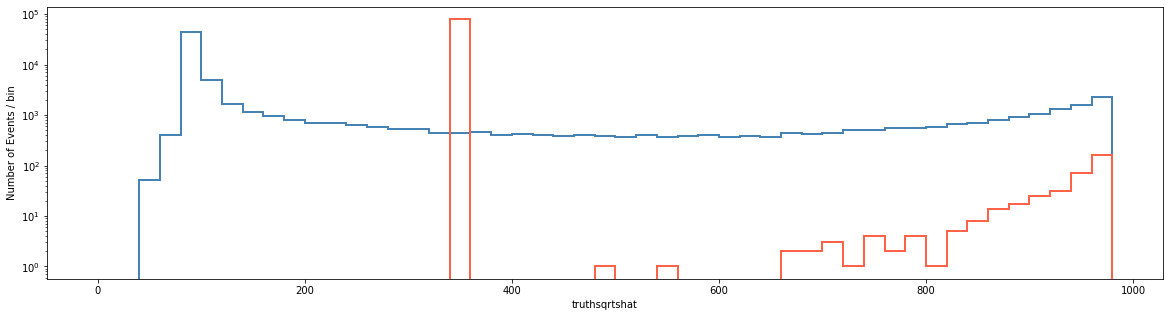

In [20]:
plot_something('truthsqrtshat',range(0,1000,20),1)

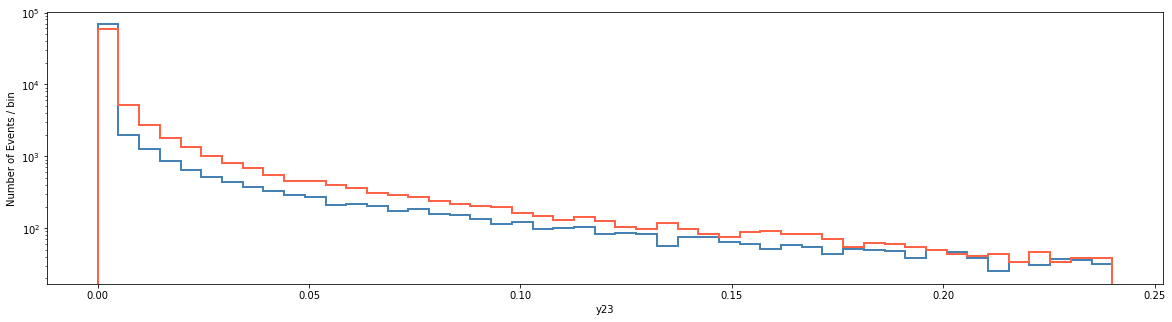

In [21]:
plot_something('y23',np.linspace(0,0.24,50),1)

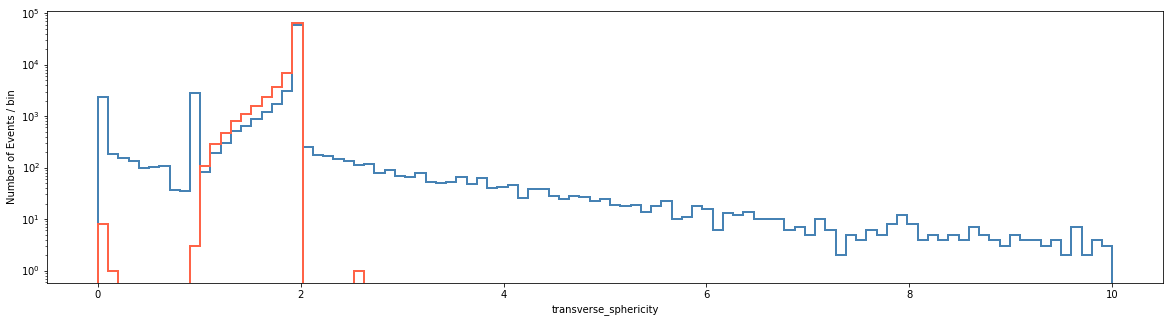

In [22]:
plot_something('transverse_sphericity',np.linspace(0,10,100),1)

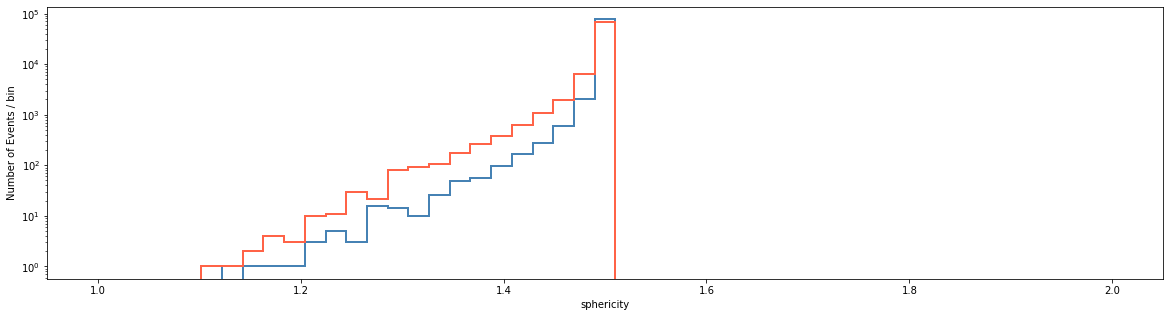

In [23]:
plot_something('sphericity',np.linspace(1.0,2,50),1)

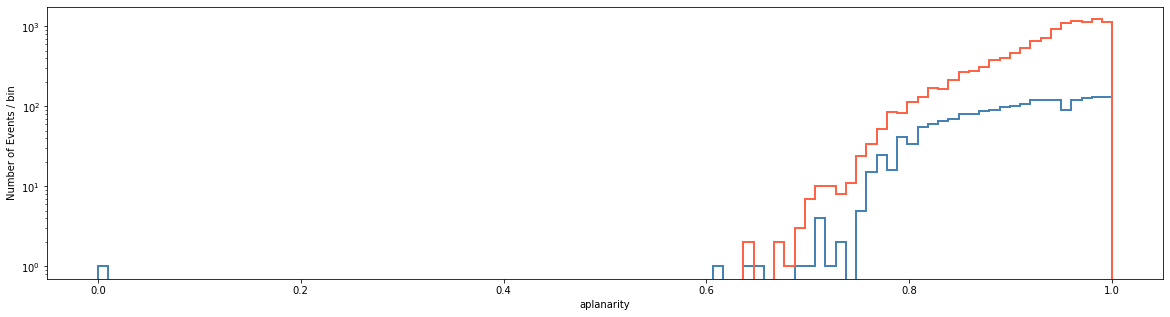

In [24]:
plot_something('aplanarity',np.linspace(0,1,100),1)

In [25]:
def plot_jets(index,R,doLog):
    plt.figure(figsize=(20,5))
    sig_arr = np.array([i['jets'][0][index] for i in sig_records[:79999]])
    #bkg_arr = np.array([i['jets'][0][index] for i in bg_records[:]])    
    plt.hist(bkg_arr, R, color="steelblue", histtype='step', linewidth=2)
    plt.hist(sig_arr, R, color="tomato", histtype='step', linewidth=2)
    #plt.hist(this_arr, bins=np.logspace(1.5,3,30))
    #plt.xscale('log')
    #plt.xticks(R)
    plt.xlabel(var)
    if doLog == True: plt.yscale('log')
    plt.ylabel("Number of Events / bin")

In [26]:
# didn't validate this plotting function works

# NN training